# Vehicle Insurance Claim Fraud Detection - ML2 course project


### Project prepared by Andrei Bysik (456993) and Mihail Slijov (474829)

## About the Dataset

### Vehicle Insurance Fraud Detection

Vehicle insurance fraud refers to intentional actions aimed at obtaining unjustified insurance payouts through false or exaggerated claims.  
Common fraud schemes include **staged accidents**, **phantom passengers** (individuals claiming injuries despite not being involved in the accident), and **exaggerated personal injury claims** following real incidents.

### Dataset Description

The dataset contains detailed information related to vehicle insurance claims, including:

- **Vehicle attributes** (e.g. vehicle type, model, and usage)
- **Accident details** (e.g. accident circumstances and reported damage)
- **Policy information** (e.g. policy type, tenure, and coverage details)

The target variable, **FraudFound_P**, is a binary indicator specifying whether an insurance claim is fraudulent (`1`) or legitimate (`0`).


### Modeling approach

Logistic Regression and Random Forest are used as baseline models.  
They are compared with more advanced classifiers: AdaBoost, XGBoost,  
LightGBM, CatBoost, and a Multilayer Perceptron (MLP) for fraud detection.


**Dataset link:** [Vehicle Claim Fraud Detection (Kaggle)](https://www.kaggle.com/datasets/shivamb/vehicle-claim-fraud-detection?resource=download)


In [ ]:
# Libraries
import pandas as pd
import os, ast, json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import optuna
import warnings
import joblib
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, precision_score, recall_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix


warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.INFO)



pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

### Explanatory analysis

In [2]:
# Load the dataset
df = pd.read_csv("fraud_oracle.csv")

In [3]:
# Preview the dataset
df.head()

Month  WeekOfMonth  DayOfWeek    Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday   Honda        Urban          Tuesday   
1   Jan            3  Wednesday   Honda        Urban           Monday   
2   Oct            5     Friday   Honda        Urban         Thursday   
3   Jun            2   Saturday  Toyota        Rural           Friday   
4   Jan            5     Monday   Honda        Urban          Tuesday   

  MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  Age          Fault  \
0          Jan                   1  Female        Single   21  Policy Holder   
1          Jan                   4    Male        Single   34  Policy Holder   
2          Nov                   2    Male       Married   47  Policy Holder   
3          Jul                   1    Male       Married   65    Third Party   
4          Feb                   2  Female        Single   27    Third Party   

          PolicyType VehicleCategory     VehiclePrice  FraudFound_P  \
0  Sport - Liability           Sport  more than 69000             0   
1  Sport - Collision           Sport  more than 69000             0   
2  Sport - Collision           Sport  more than 69000             0   
3  Sedan - Liability           Sport   20000 to 29000             0   
4  Sport - Collision           Sport  more than 69000             0   

   PolicyNumber  RepNumber  Deductible  DriverRating Days_Policy_Accident  \
0             1         12         300             1         more than 30   
1             2         15         400             4         more than 30   
2             3          7         400             3         more than 30   
3             4          4         400             2         more than 30   
4             5          3         400             1         more than 30   

  Days_Policy_Claim PastNumberOfClaims AgeOfVehicle AgeOfPolicyHolder  \
0      more than 30               none      3 years          26 to 30   
1      more than 30               none      6 years          31 to 35   
2      more than 30                  1      7 years          41 to 50   
3      more than 30                  1  more than 7          51 to 65   
4      more than 30               none      5 years          31 to 35   

  PoliceReportFiled WitnessPresent AgentType NumberOfSuppliments  \
0                No             No  External                none   
1               Yes             No  External                none   
2                No             No  External                none   
3               Yes             No  External         more than 5   
4                No             No  External                none   

  AddressChange_Claim NumberOfCars  Year BasePolicy  
0              1 year       3 to 4  1994  Liability  
1           no change    1 vehicle  1994  Collision  
2           no change    1 vehicle  1994  Collision  
3           no change    1 vehicle  1994  Liability  
4           no change    1 vehicle  1994  Collision

In [4]:
# Display column names
df.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy'],
      dtype='object')

### Data shape

In [5]:
# Check dataset dimensions
df.shape

(15420, 33)

In [6]:
# Check for missing values in each column
missing_df = df.isnull().sum().to_frame(name="missing_count").reset_index()
missing_df.rename(columns={"index": "column"}, inplace=True)

missing_df

column  missing_count
0                  Month              0
1            WeekOfMonth              0
2              DayOfWeek              0
3                   Make              0
4           AccidentArea              0
5       DayOfWeekClaimed              0
6           MonthClaimed              0
7     WeekOfMonthClaimed              0
8                    Sex              0
9          MaritalStatus              0
10                   Age              0
11                 Fault              0
12            PolicyType              0
13       VehicleCategory              0
14          VehiclePrice              0
15          FraudFound_P              0
16          PolicyNumber              0
17             RepNumber              0
18            Deductible              0
19          DriverRating              0
20  Days_Policy_Accident              0
21     Days_Policy_Claim              0
22    PastNumberOfClaims              0
23          AgeOfVehicle              0
24     AgeOfPolicyHolder              0
25     PoliceReportFiled              0
26        WitnessPresent              0
27             AgentType              0
28   NumberOfSuppliments              0
29   AddressChange_Claim              0
30          NumberOfCars              0
31                  Year              0
32            BasePolicy              0

In [7]:
# Check data types of each column
types_df = df.dtypes.to_frame(name="dtype").reset_index()
types_df.rename(columns={"index": "column"}, inplace=True) 

types_df

column   dtype
0                  Month  object
1            WeekOfMonth   int64
2              DayOfWeek  object
3                   Make  object
4           AccidentArea  object
5       DayOfWeekClaimed  object
6           MonthClaimed  object
7     WeekOfMonthClaimed   int64
8                    Sex  object
9          MaritalStatus  object
10                   Age   int64
11                 Fault  object
12            PolicyType  object
13       VehicleCategory  object
14          VehiclePrice  object
15          FraudFound_P   int64
16          PolicyNumber   int64
17             RepNumber   int64
18            Deductible   int64
19          DriverRating   int64
20  Days_Policy_Accident  object
21     Days_Policy_Claim  object
22    PastNumberOfClaims  object
23          AgeOfVehicle  object
24     AgeOfPolicyHolder  object
25     PoliceReportFiled  object
26        WitnessPresent  object
27             AgentType  object
28   NumberOfSuppliments  object
29   AddressChange_Claim  object
30          NumberOfCars  object
31                  Year   int64
32            BasePolicy  object

### Variable "Month"

In [8]:
# Display unique values in the Month column
df["Month"].unique()

array(['Dec', 'Jan', 'Oct', 'Jun', 'Feb', 'Nov', 'Apr', 'Mar', 'Aug',
       'Jul', 'May', 'Sep'], dtype=object)

In [9]:
# Count number of claims per month (ordered)
month_counts = df["Month"].value_counts().reindex(
    ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
)

month_counts


Month
Jan    1411
Feb    1266
Mar    1360
Apr    1280
May    1367
Jun    1321
Jul    1257
Aug    1127
Sep    1240
Oct    1305
Nov    1201
Dec    1285
Name: count, dtype: int64

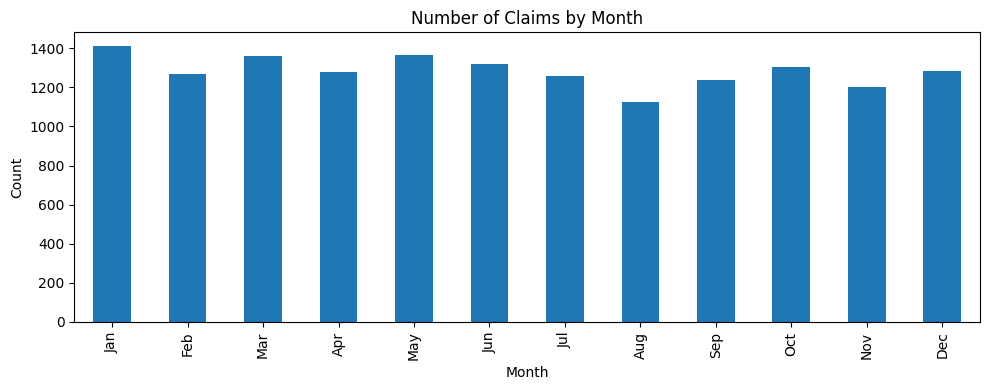

In [10]:
# Distribution of insurance claims by month
plt.figure(figsize=(10,4))
month_counts.plot(kind="bar")
plt.title("Number of Claims by Month")
plt.ylabel("Count")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Number of Claims by Month'}, xlabel='Month'>

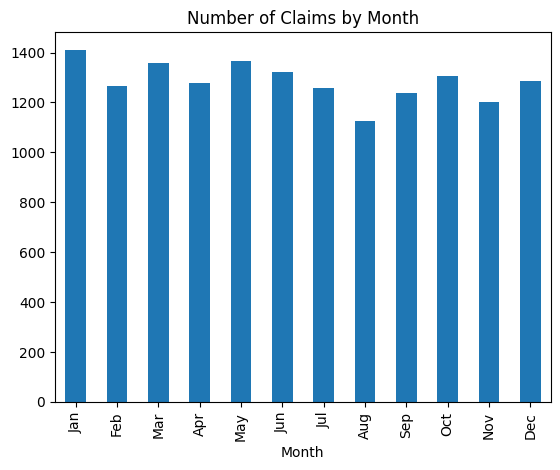

In [11]:
# Bar chart of the number of claims by month
month_counts.plot(kind="bar", title="Number of Claims by Month")

### Calculation of overall fraud rate

In [12]:
# Calculate overall fraud rate
overall_fraud_rate = df["FraudFound_P"].mean() 
overall_fraud_rate

0.05985732814526589

### Variable "FraudFound_P"

In [13]:
# Monthly fraud rate
fraud_rate_month = (
    df.groupby("Month")["FraudFound_P"]
    .mean()
    .reindex(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
)

fraud_rate_month


Month
Jan    0.061658
Feb    0.064771
Mar    0.075000
Apr    0.062500
May    0.068764
Jun    0.060560
Jul    0.047733
Aug    0.074534
Sep    0.061290
Oct    0.053640
Nov    0.038301
Dec    0.048249
Name: FraudFound_P, dtype: float64

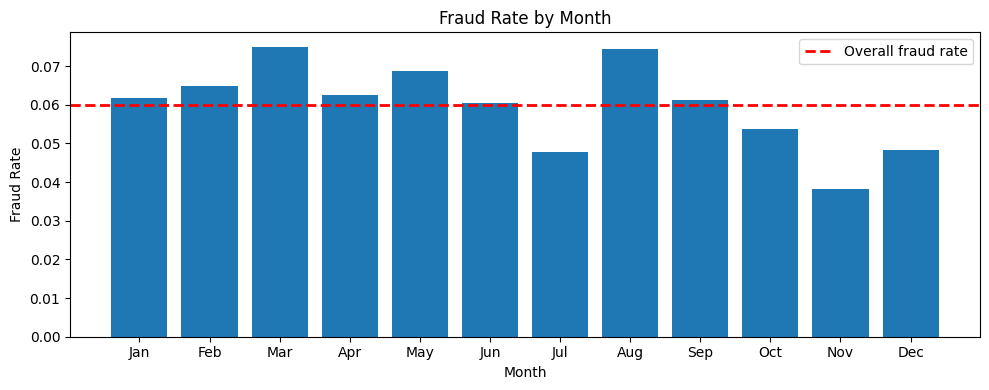

In [14]:
# Fraud rate by month compared to overall fraud rate
plt.figure(figsize=(10,4))
plt.bar(fraud_rate_month.index, fraud_rate_month.values)
plt.axhline(
    y=overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Month")
plt.ylabel("Fraud Rate")
plt.xlabel("Month")
plt.legend()
plt.tight_layout()
plt.show()


The **Month** variable displays moderate seasonality in fraud occurrence.  
Some months have higher fraud rates than the overall average, though no extreme deviations are present.  
As a result, the variable is kept as a categorical feature for modeling.


### Variable "WeekOfMonth"

In [15]:
# Display unique values of the WeekOfMonth variable
df["WeekOfMonth"].unique()

array([5, 3, 2, 4, 1], dtype=int64)

In [16]:
# Count number of claims by week of the month (sorted)
week_counts = df["WeekOfMonth"].value_counts().sort_index() ## sort for better view
week_counts

WeekOfMonth
1    3187
2    3558
3    3640
4    3398
5    1637
Name: count, dtype: int64

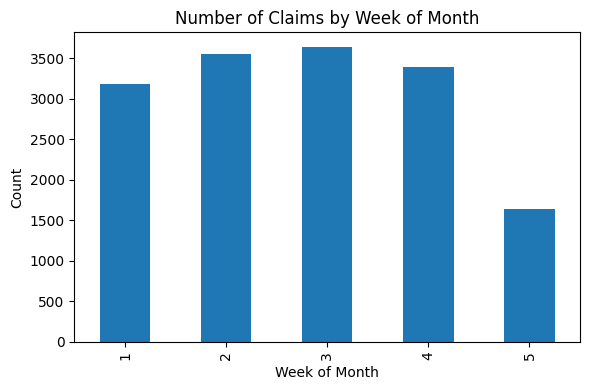

In [17]:
# Distribution of insurance claims by week of the month
plt.figure(figsize=(6,4))
week_counts.plot(kind="bar")
plt.title("Number of Claims by Week of Month")
plt.xlabel("Week of Month")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [18]:
# Fraud rate by week of the month
fraud_rate_week = (
    df.groupby("WeekOfMonth")["FraudFound_P"]
    .mean()
    .sort_index()
)

fraud_rate_week


WeekOfMonth
1    0.062755
2    0.063238
3    0.059066
4    0.056504
5    0.055589
Name: FraudFound_P, dtype: float64

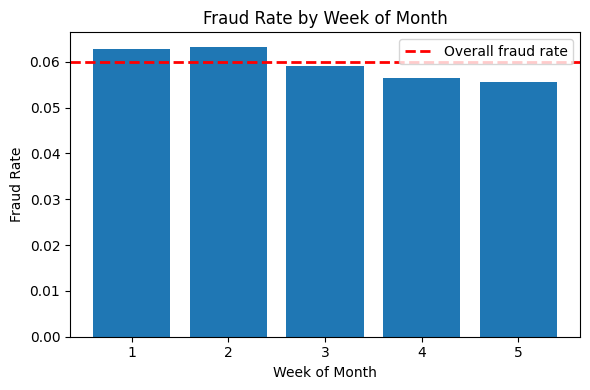

In [19]:
# Fraud rate by week of the month compared to overall fraud rate
plt.figure(figsize=(6,4))
plt.bar(fraud_rate_week.index.astype(str), fraud_rate_week.values)
plt.axhline(
    y=overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Week of Month")
plt.xlabel("Week of Month")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()


The presence of a fifth week in some months is due to the way the variable **WeekOfMonth** is defined.  
Weeks are assigned based on fixed day ranges (e.g. days 1–7, 8–14, etc.), rather than calendar weeks.  
As a result, months with 29–31 days include observations labeled as week 5.


The **WeekOfMonth** variable represents the position of an accident within the month.  
Only weak differences in fraud rates are observed across weeks.  
Thus, the variable is kept as a numerical feature for modeling.

### Variable - "DayOfWeek"

In [20]:
# Display unique values of the DayOfWeek variable
df["DayOfWeek"].unique()

array(['Wednesday', 'Friday', 'Saturday', 'Monday', 'Tuesday', 'Sunday',
       'Thursday'], dtype=object)

In [21]:
# Count number of claims by day of the week (ordered)
dow_order = ["Monday","Tuesday","Wednesday","Thursday",
             "Friday","Saturday","Sunday"]

dow_counts = df["DayOfWeek"].value_counts().reindex(dow_order) # sort days of week
dow_counts


DayOfWeek
Monday       2616
Tuesday      2300
Wednesday    2159
Thursday     2173
Friday       2445
Saturday     1982
Sunday       1745
Name: count, dtype: int64

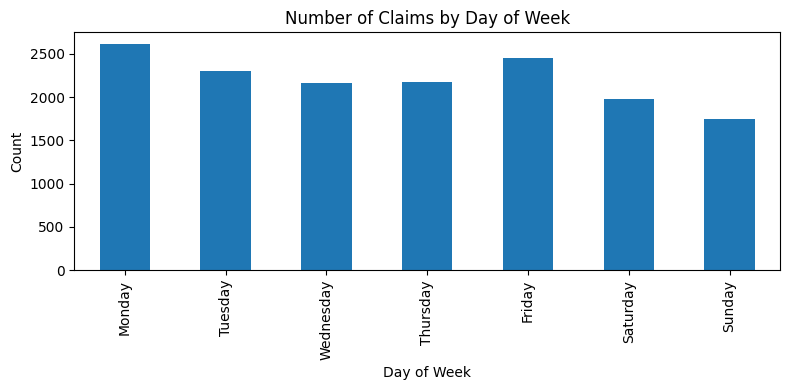

In [22]:
# Distribution of insurance claims by day of the week
plt.figure(figsize=(8,4))
dow_counts.plot(kind="bar")
plt.title("Number of Claims by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [23]:
# Fraud rate by day of the week
fraud_rate_dow = (
    df.groupby("DayOfWeek")["FraudFound_P"] #group with fraud
    .mean()
    .reindex(dow_order)
)

fraud_rate_dow


DayOfWeek
Monday       0.061162
Tuesday      0.052174
Wednesday    0.053265
Thursday     0.055223
Friday       0.062986
Saturday     0.066599
Sunday       0.069914
Name: FraudFound_P, dtype: float64

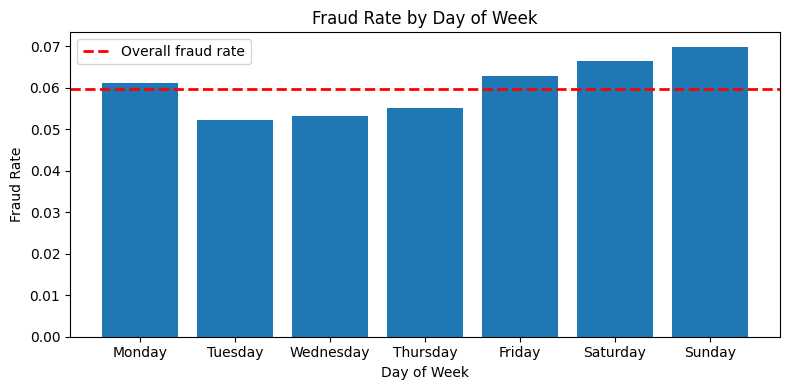

In [24]:
# Fraud rate by day of the week compared to overall fraud rate
plt.figure(figsize=(8,4))
plt.bar(fraud_rate_dow.index, fraud_rate_dow.values)
plt.axhline(
    y=overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()


The **DayOfWeek** variable represents the weekday of the accident.  
Only limited differences in fraud rates are observed across days, with values remaining close to the overall average.  
The variable is therefore kept as a categorical feature for modeling.

### Feature - "Make"

In [25]:
# Display unique vehicle manufacturers
df["Make"].unique()

array(['Honda', 'Toyota', 'Ford', 'Mazda', 'Chevrolet', 'Pontiac',
       'Accura', 'Dodge', 'Mercury', 'Jaguar', 'Nisson', 'VW', 'Saab',
       'Saturn', 'Porche', 'BMW', 'Mecedes', 'Ferrari', 'Lexus'],
      dtype=object)

In [26]:
# Count number of claims by vehicle manufacturer
make_counts = df["Make"].value_counts()
make_counts

Make
Pontiac      3837
Toyota       3121
Honda        2801
Mazda        2354
Chevrolet    1681
Accura        472
Ford          450
VW            283
Dodge         109
Saab          108
Mercury        83
Saturn         58
Nisson         30
BMW            15
Jaguar          6
Porche          5
Mecedes         4
Ferrari         2
Lexus           1
Name: count, dtype: int64

In [27]:
# List unique vehicle manufacturers
make_counts.index.tolist()

['Pontiac',
 'Toyota',
 'Honda',
 'Mazda',
 'Chevrolet',
 'Accura',
 'Ford',
 'VW',
 'Dodge',
 'Saab',
 'Mercury',
 'Saturn',
 'Nisson',
 'BMW',
 'Jaguar',
 'Porche',
 'Mecedes',
 'Ferrari',
 'Lexus']

In [28]:
# Mapping to correct misspelled vehicle manufacturers
make_correction_map = { 
    "Accura": "Acura",
    "Nisson": "Nissan",
    "Porche": "Porsche",
    "Mecedes": "Mercedes",
    "VW": "Volkswagen"
}

In [29]:
# Apply manufacturer name corrections
df["Make"] = df["Make"].replace(make_correction_map) 

In [30]:
# Recheck counts after correcting manufacturer names
df["Make"].value_counts()

Make
Pontiac       3837
Toyota        3121
Honda         2801
Mazda         2354
Chevrolet     1681
Acura          472
Ford           450
Volkswagen     283
Dodge          109
Saab           108
Mercury         83
Saturn          58
Nissan          30
BMW             15
Jaguar           6
Porsche          5
Mercedes         4
Ferrari          2
Lexus            1
Name: count, dtype: int64

In [31]:
# Summary statistics for claim counts by manufacturer
make_counts.describe()

count      19.000000
mean      811.578947
std      1262.750935
min         1.000000
25%        10.500000
50%       108.000000
75%      1076.500000
max      3837.000000
Name: count, dtype: float64

In [32]:
# Fraud rate by vehicle manufacturer
MIN_COUNT = 1

make_stats = (
    df.groupby("Make")
      .agg(
          count=("FraudFound_P", "size"),
          fraud_rate=("FraudFound_P", "mean")
      )
      .query("count >= @MIN_COUNT")
      .sort_values("fraud_rate", ascending=False)
)

make_stats

count  fraud_rate
Make                         
Mercedes        4    0.250000
Acura         472    0.125000
Saturn         58    0.103448
Saab          108    0.101852
Ford          450    0.073333
Mercury        83    0.072289
BMW            15    0.066667
Honda        2801    0.063906
Toyota       3121    0.059596
Chevrolet    1681    0.055919
Pontiac      3837    0.055512
Mazda        2354    0.052251
Nissan         30    0.033333
Volkswagen    283    0.028269
Dodge         109    0.018349
Lexus           1    0.000000
Porsche         5    0.000000
Jaguar          6    0.000000
Ferrari         2    0.000000

Categories with very small sample sizes, including those with 0% observed fraud, do not provide reliable information on fraud risk.
Such categories were treated as rare and considered for aggregation to reduce noise rather than being interpreted as low-risk groups.

In [33]:
# Fraud rate by manufacturer (filtered by minimum sample size)
# Remove small values by observing only the manufacturers with atleast 300+ cars
MIN_COUNT = 300 

make_stats_stable = (
    df.groupby("Make")
      .agg(
          count=("FraudFound_P", "size"),
          fraud_rate=("FraudFound_P", "mean")
      )
      .query("count >= @MIN_COUNT")
      .sort_values("fraud_rate", ascending=False)
)

make_stats_stable

count  fraud_rate
Make                        
Acura        472    0.125000
Ford         450    0.073333
Honda       2801    0.063906
Toyota      3121    0.059596
Chevrolet   1681    0.055919
Pontiac     3837    0.055512
Mazda       2354    0.052251

In [34]:
# Fraud rate by manufacturer sorted by sample size
make_stats = ( 
    df.groupby("Make")
      .agg(
          count=("FraudFound_P", "size"),
          fraud_rate=("FraudFound_P", "mean")
      )
      .sort_values("count", ascending=False)
)

make_stats[make_stats["count"] >= 300] 

count  fraud_rate
Make                        
Pontiac     3837    0.055512
Toyota      3121    0.059596
Honda       2801    0.063906
Mazda       2354    0.052251
Chevrolet   1681    0.055919
Acura        472    0.125000
Ford         450    0.073333

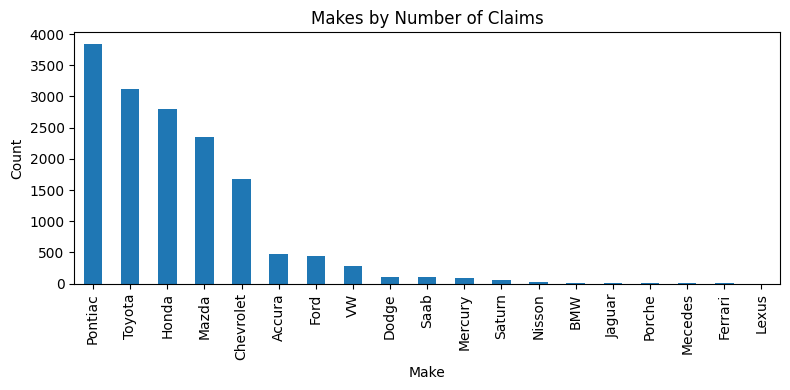

In [35]:
# Distribution of claims by vehicle manufacturer
plt.figure(figsize=(8,4))
make_counts.plot(kind="bar")
plt.title("Makes by Number of Claims")
plt.xlabel("Make")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

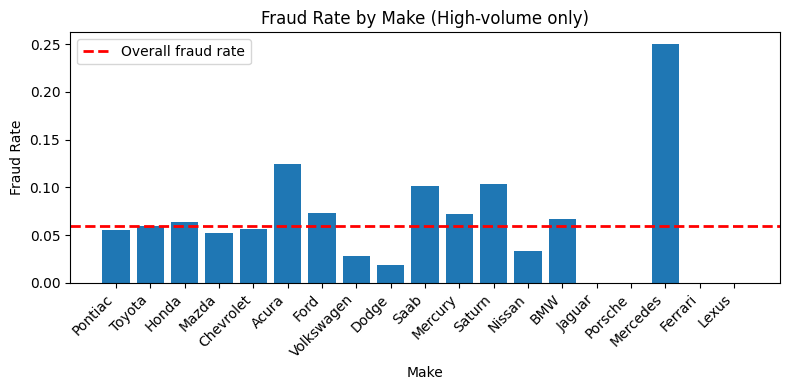

In [36]:
# Fraud rate by vehicle manufacturer compared to overall fraud rate
plt.figure(figsize=(8, 4))
plt.bar(make_stats.index, make_stats["fraud_rate"])
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Make (High-volume only)")
plt.xlabel("Make")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45, ha="right") 
plt.legend()
plt.tight_layout()
plt.show()


Some high-volume vehicle makes exhibit slightly higher fraud rates than the overall average.  
The **Make** variable is highly imbalanced, with most observations coming from a small number of manufacturers.  
Rare categories and minor naming inconsistencies are present.  
To avoid unstable estimates, appropriate grouping or encoding will be applied before modeling.

### Feature - "AccidentArea"

In [37]:
# Display unique values of the AccidentArea variable
df["AccidentArea"].unique()

array(['Urban', 'Rural'], dtype=object)

In [38]:
# Proportion of claims by accident area
df["AccidentArea"].value_counts(normalize=True)

AccidentArea
Urban    0.896368
Rural    0.103632
Name: proportion, dtype: float64

In [39]:
# Fraud rate by accident area
area_stats = (
    df.groupby("AccidentArea")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
)

area_stats

count  fraud_rate
AccidentArea                   
Rural          1598    0.083229
Urban         13822    0.057155

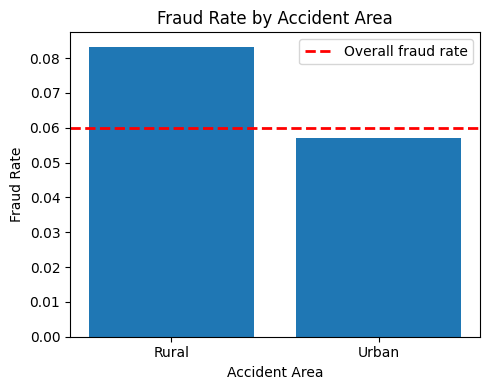

In [40]:
# Fraud rate by accident area compared to overall fraud rate
plt.figure(figsize=(5,4))
plt.bar(area_stats.index, area_stats["fraud_rate"])
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Accident Area")
plt.xlabel("Accident Area")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()


### Feature "DayOfWeekClaimed"

In [41]:
# Display unique values of the DayOfWeekClaimed variable
df["DayOfWeekClaimed"].unique()

array(['Tuesday', 'Monday', 'Thursday', 'Friday', 'Wednesday', 'Saturday',
       'Sunday', '0'], dtype=object)

In [42]:
# Replace invalid value with 'Unknown'
df["DayOfWeekClaimed"] = df["DayOfWeekClaimed"].replace("0", "Unknown")

Invalid placeholder values were replaced with **"Unknown"** to ensure consistent categorical encoding and avoid misleading interpretations during analysis.

In [43]:
# Recheck unique values after replacement
df["DayOfWeekClaimed"].unique()

array(['Tuesday', 'Monday', 'Thursday', 'Friday', 'Wednesday', 'Saturday',
       'Sunday', 'Unknown'], dtype=object)

In [44]:
# Count claims by day of week when the claim was filed
df["DayOfWeekClaimed"].value_counts()

DayOfWeekClaimed
Monday       3757
Tuesday      3375
Wednesday    2951
Thursday     2660
Friday       2497
Saturday      127
Sunday         52
Unknown         1
Name: count, dtype: int64

In [45]:
# Fraud rate by day of week when the claim was filed
df.groupby("DayOfWeekClaimed")["FraudFound_P"].agg(
    count="size",
    fraud_rate="mean"
)

count  fraud_rate
DayOfWeekClaimed                   
Friday             2497    0.065679
Monday             3757    0.057493
Saturday            127    0.078740
Sunday               52    0.057692
Thursday           2660    0.054135
Tuesday            3375    0.058667
Unknown               1    0.000000
Wednesday          2951    0.063707

In [46]:
# Proportion of claims by claimed day of the week
df["DayOfWeekClaimed"].value_counts(normalize=True)

DayOfWeekClaimed
Monday       0.243645
Tuesday      0.218872
Wednesday    0.191375
Thursday     0.172503
Friday       0.161933
Saturday     0.008236
Sunday       0.003372
Unknown      0.000065
Name: proportion, dtype: float64

In [47]:
# Fraud rate by day of week when the claim was filed
dow_claimed_stats = (
    df.groupby("DayOfWeekClaimed")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
      .sort_values("fraud_rate", ascending=False)
)

dow_claimed_stats

count  fraud_rate
DayOfWeekClaimed                   
Saturday            127    0.078740
Friday             2497    0.065679
Wednesday          2951    0.063707
Tuesday            3375    0.058667
Sunday               52    0.057692
Monday             3757    0.057493
Thursday           2660    0.054135
Unknown               1    0.000000

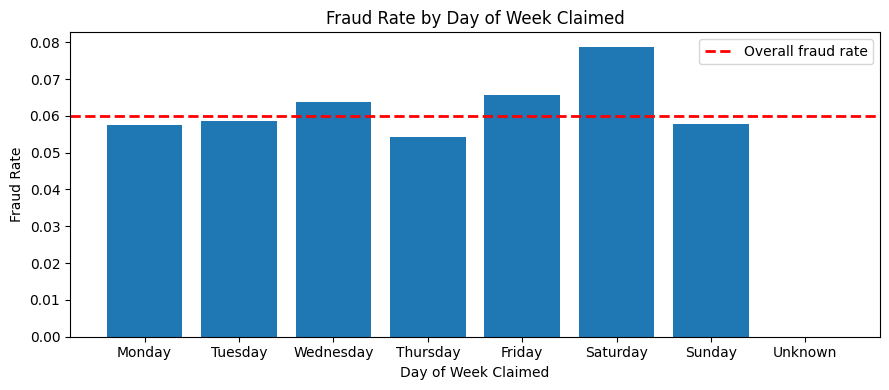

In [48]:
# Fraud rate by day of week when the claim was filed (ordered)
dow_order = [
    "Monday","Tuesday","Wednesday","Thursday",
    "Friday","Saturday","Sunday","Unknown"
]

plt.figure(figsize=(9,4))
plt.bar(
    dow_order,
    dow_claimed_stats.reindex(dow_order)["fraud_rate"]
)
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Day of Week Claimed")
plt.xlabel("Day of Week Claimed")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()

### Feature - "MonthClaimed"

In [49]:
# Check unique values in MonthClaimed
df["MonthClaimed"].unique()

array(['Jan', 'Nov', 'Jul', 'Feb', 'Mar', 'Dec', 'Apr', 'Aug', 'May',
       'Jun', 'Sep', 'Oct', '0'], dtype=object)

In [50]:
# Replace invalid month value "0" with explicit "Unknown" category
df["MonthClaimed"] = df["MonthClaimed"].replace("0", "Unknown")

Invalid values are replaced with a clear category to keep the dataset clean and suitable for analysis.

In [51]:
# Inspect unique values to identify invalid or inconsistent month entries
df["MonthClaimed"].unique()

array(['Jan', 'Nov', 'Jul', 'Feb', 'Mar', 'Dec', 'Apr', 'Aug', 'May',
       'Jun', 'Sep', 'Oct', 'Unknown'], dtype=object)

In [52]:
# Check frequency of each month to spot rare or invalid categories
df["MonthClaimed"].value_counts()

MonthClaimed
Jan        1446
May        1411
Mar        1348
Oct        1339
Jun        1293
Feb        1287
Nov        1285
Apr        1271
Sep        1242
Jul        1225
Dec        1146
Aug        1126
Unknown       1
Name: count, dtype: int64

In [53]:
# Group by claimed month to see how fraud rate changes across months
month_claimed_stats = (
    df.groupby("MonthClaimed")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
      .sort_values("fraud_rate", ascending=False)
)

month_claimed_stats

count  fraud_rate
MonthClaimed                   
Aug            1126    0.081705
May            1411    0.072289
Mar            1348    0.071958
Apr            1271    0.064516
Jan            1446    0.063624
Sep            1242    0.062802
Feb            1287    0.060606
Jun            1293    0.060325
Oct            1339    0.054518
Jul            1225    0.045714
Dec            1146    0.042757
Nov            1285    0.035798
Unknown           1    0.000000

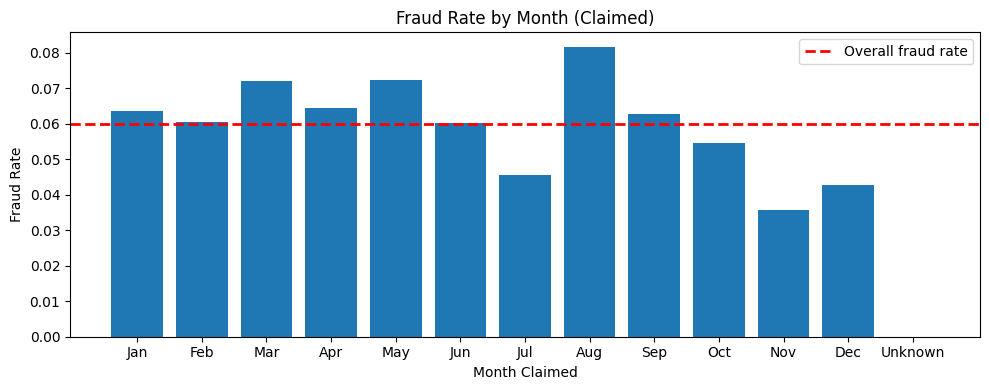

In [54]:
# Plot fraud rate by claimed month and compare it to the overall fraud rate
month_order = ["Jan","Feb","Mar","Apr","May","Jun",
               "Jul","Aug","Sep","Oct","Nov","Dec","Unknown"]

plt.figure(figsize=(10,4))
plt.bar(
    month_order,
    month_claimed_stats.reindex(month_order)["fraud_rate"]
)
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Month (Claimed)")
plt.xlabel("Month Claimed")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()

### Feature - "WeekOfMonthClaimed"

In [55]:
# Check unique week-of-month values for claimed accidents
df["WeekOfMonthClaimed"].unique()

array([1, 4, 2, 3, 5], dtype=int64)

A small insight not related to the study, but people don't usually do claims on last weeks, pushing it to next month.

In [56]:
# Count how many claims fall into each week of the month
week_claimed_counts = df["WeekOfMonthClaimed"].value_counts().sort_index()
week_claimed_counts

WeekOfMonthClaimed
1    3450
2    3720
3    3583
4    3433
5    1234
Name: count, dtype: int64

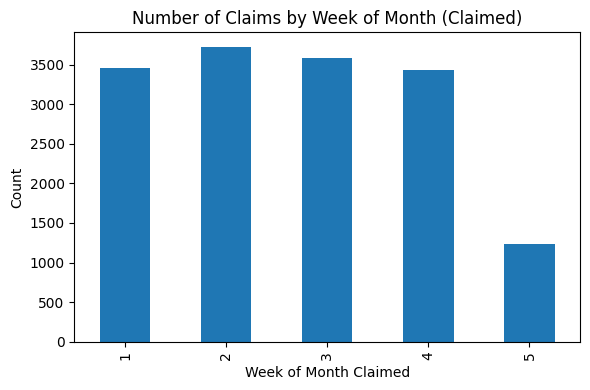

In [57]:
# Visualize distribution of claims across weeks of the month
plt.figure(figsize=(6,4))
week_claimed_counts.plot(kind="bar")
plt.title("Number of Claims by Week of Month (Claimed)")
plt.xlabel("Week of Month Claimed")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [58]:
# Compute fraud rate for each week of the claimed month
fraud_rate_week_claimed = (
    df.groupby("WeekOfMonthClaimed")["FraudFound_P"]
      .mean()
      .sort_index()
)

fraud_rate_week_claimed

WeekOfMonthClaimed
1    0.063768
2    0.055914
3    0.061680
4    0.060880
5    0.052674
Name: FraudFound_P, dtype: float64

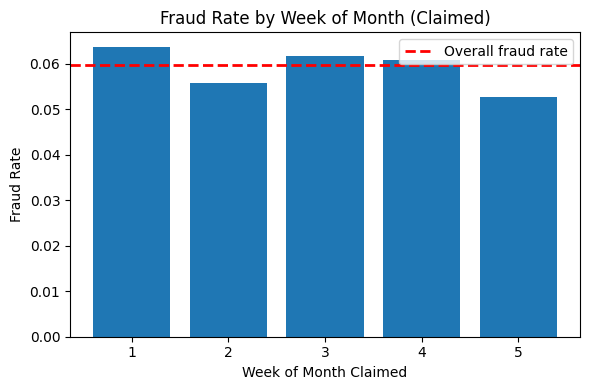

In [59]:
# Plot fraud rate by week of month and compare with overall fraud rate
plt.figure(figsize=(6,4))
plt.bar(
    fraud_rate_week_claimed.index.astype(str),
    fraud_rate_week_claimed.values
)
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Week of Month (Claimed)")
plt.xlabel("Week of Month Claimed")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()

### Feature - "Sex"

In [60]:
# Inspect unique gender categories in the dataset
df["Sex"].unique()

array(['Female', 'Male'], dtype=object)

In [61]:
# Count number of claims for each gender category
df["Sex"].value_counts()

Sex
Male      13000
Female     2420
Name: count, dtype: int64

In [62]:
# Check relative proportion of claims by gender
df["Sex"].value_counts(normalize=True)

Sex
Male      0.843061
Female    0.156939
Name: proportion, dtype: float64

In [63]:
# Group claims by gender to compare fraud rates between categories
sex_stats = (
    df.groupby("Sex")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
)

sex_stats

count  fraud_rate
Sex                      
Female   2420    0.043388
Male    13000    0.062923

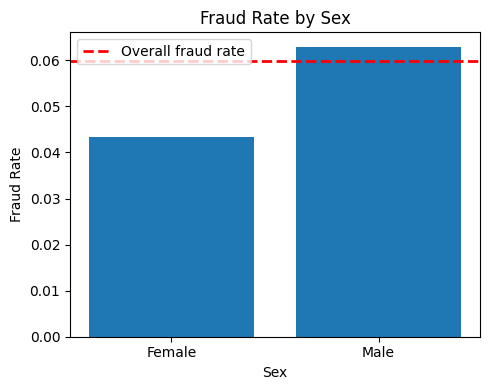

In [64]:
# Plot fraud rate by gender and compare it to the overall fraud rate
plt.figure(figsize=(5,4))
plt.bar(sex_stats.index, sex_stats["fraud_rate"])
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Sex")
plt.xlabel("Sex")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()

### Feature - "MatitalStatus"

In [65]:
# Inspect unique marital status categories in the dataset
df["MaritalStatus"].unique()

array(['Single', 'Married', 'Widow', 'Divorced'], dtype=object)

In [66]:
# Count number of claims for each marital status
df["MaritalStatus"].value_counts()

MaritalStatus
Married     10625
Single       4684
Divorced       76
Widow          35
Name: count, dtype: int64

In [67]:
# Check relative distribution of claims by marital status
df["MaritalStatus"].value_counts(normalize=True)

MaritalStatus
Married     0.689040
Single      0.303761
Divorced    0.004929
Widow       0.002270
Name: proportion, dtype: float64

In [68]:
# Compute claim counts and fraud rates by marital status
marital_stats = (
    df.groupby("MaritalStatus")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
      .sort_values("fraud_rate", ascending=False)
)

marital_stats

count  fraud_rate
MaritalStatus                   
Widow             35    0.085714
Married        10625    0.060141
Single          4684    0.059351
Divorced          76    0.039474

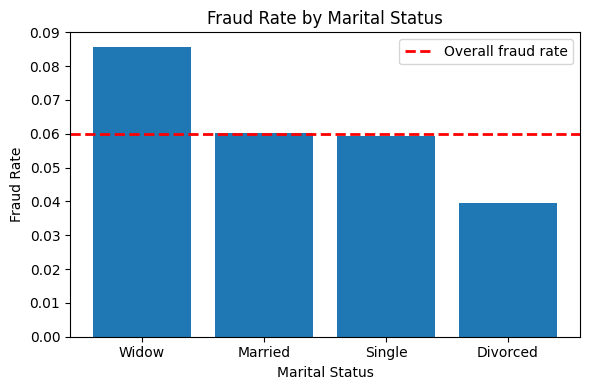

In [69]:
# Plot fraud rate by marital status and compare it with the overall fraud rate
plt.figure(figsize=(6,4))
plt.bar(marital_stats.index, marital_stats["fraud_rate"])
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()

### Feature - "Age" 


In [70]:
# Inspect unique age values to check range and potential anomalies
df["Age"].unique()

array([21, 34, 47, 65, 27, 20, 36,  0, 30, 42, 71, 52, 28, 61, 38, 41, 32,
       40, 63, 31, 45, 60, 39, 55, 35, 44, 72, 29, 37, 59, 49, 50, 26, 48,
       64, 33, 74, 23, 25, 56, 16, 68, 18, 51, 22, 53, 46, 43, 57, 54, 69,
       67, 19, 78, 77, 75, 80, 58, 73, 24, 76, 62, 79, 70, 17, 66],
      dtype=int64)

In [71]:
# Count how many records have age equal to zero (possible invalid or missing values)
(df["Age"] == 0).sum()

320

In [72]:
# Show summary statistics to understand the age distribution
df["Age"].describe()

count    15420.000000
mean        39.855707
std         13.492377
min          0.000000
25%         31.000000
50%         38.000000
75%         48.000000
max         80.000000
Name: Age, dtype: float64

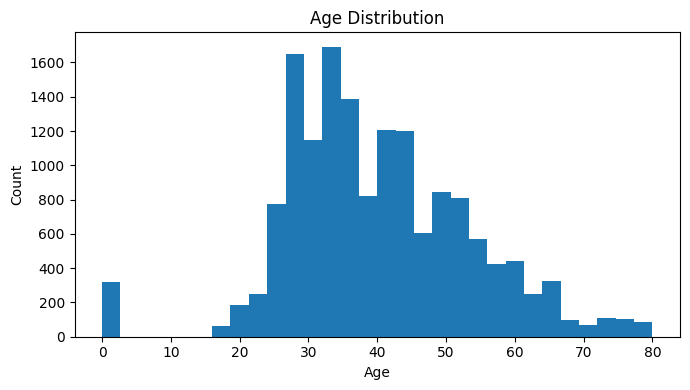

In [73]:
# Plot age distribution to visualize spread and outliers
plt.figure(figsize=(7,4))
plt.hist(df["Age"], bins=30)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Here `Age = 0` is not a valid age for a driver or a policy holder, in this dataset, `Age = 0` appears systematically (320 cases), which means missing or unrecorded age information.

In [74]:
# Count invalid age entries equal to zero
invalid_age_count = (df["Age"] == 0).sum() # sum unknown age
invalid_age_count

320

In [75]:
# Replace invalid age values (0) with NaN for proper handling
df.loc[df["Age"] == 0, "Age"] = np.nan

In [76]:
# Recheck age statistics after cleaning invalid values
df["Age"].describe()

count    15100.000000
mean        40.700331
std         12.309493
min         16.000000
25%         31.000000
50%         39.000000
75%         49.000000
max         80.000000
Name: Age, dtype: float64

In [77]:
# Check how large the fraction of missing age values is after cleaning
df["Age"].isna().mean()

0.020752269779507133

In [78]:
# Compare fraud rates between missing and non-missing age groups
df.assign(Age_missing=df["Age"].isna()) \
  .groupby("Age_missing")["FraudFound_P"] \
  .agg(count="size", fraud_rate="mean")

count  fraud_rate
Age_missing                   
False        15100    0.059073
True           320    0.096875

Claims with missing age have a noticeably higher fraud rate, suggesting that missing age itself may be a useful fraud indicator.

### Feature - "Fault"

In [79]:
# Inspect unique fault categories in the dataset
df["Fault"].unique()

array(['Policy Holder', 'Third Party'], dtype=object)

In [80]:
# Count how often each fault category appears in claims
df["Fault"].value_counts()

Fault
Policy Holder    11230
Third Party       4190
Name: count, dtype: int64

In [81]:
# Check relative distribution of fault categories across all claims
df["Fault"].value_counts(normalize=True)

Fault
Policy Holder    0.728275
Third Party      0.271725
Name: proportion, dtype: float64

In [82]:
# Compute claim counts and fraud rates by fault category
fault_stats = (
    df.groupby("Fault")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
)

fault_stats

count  fraud_rate
Fault                           
Policy Holder  11230    0.078896
Third Party     4190    0.008831

Fraud is much more common when the policy holder is at fault compared to third-party fault cases.

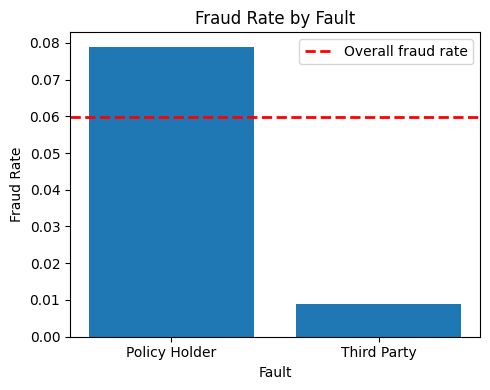

In [83]:
# Plot fraud rate by fault type and compare with the overall fraud rate
plt.figure(figsize=(5,4))
plt.bar(fault_stats.index, fault_stats["fraud_rate"])
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Fault")
plt.xlabel("Fault")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()


### Feature - "Policy Type"

In [84]:
# Inspect unique policy type categories
df["PolicyType"].unique()

array(['Sport - Liability', 'Sport - Collision', 'Sedan - Liability',
       'Utility - All Perils', 'Sedan - All Perils', 'Sedan - Collision',
       'Utility - Collision', 'Utility - Liability', 'Sport - All Perils'],
      dtype=object)

In [85]:
# Count number of claims for each policy type
policy_counts = df["PolicyType"].value_counts()
policy_counts

PolicyType
Sedan - Collision       5584
Sedan - Liability       4987
Sedan - All Perils      4087
Sport - Collision        348
Utility - All Perils     340
Utility - Collision       30
Sport - All Perils        22
Utility - Liability       21
Sport - Liability          1
Name: count, dtype: int64

In [86]:
# Check relative frequency of each policy type
policy_counts_normalized = df["PolicyType"].value_counts(normalize=True)
policy_counts_normalized

PolicyType
Sedan - Collision       0.362127
Sedan - Liability       0.323411
Sedan - All Perils      0.265045
Sport - Collision       0.022568
Utility - All Perils    0.022049
Utility - Collision     0.001946
Sport - All Perils      0.001427
Utility - Liability     0.001362
Sport - Liability       0.000065
Name: proportion, dtype: float64

In [87]:
# Compute claim counts and fraud rates by policy type
policy_stats = (
    df.groupby("PolicyType")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
      .sort_values("fraud_rate", ascending=False)
)

policy_stats

count  fraud_rate
PolicyType                             
Sport - Collision       348    0.137931
Utility - All Perils    340    0.120588
Sedan - All Perils     4087    0.100563
Utility - Collision      30    0.100000
Sedan - Collision      5584    0.068768
Sedan - Liability      4987    0.007219
Sport - All Perils       22    0.000000
Sport - Liability         1    0.000000
Utility - Liability      21    0.000000

In [88]:
# Keep only policy types with enough observations to make fraud rates more reliable
MIN_COUNT = 300

policy_stats_stable = policy_stats[policy_stats["count"] >= MIN_COUNT]
policy_stats_stable

count  fraud_rate
PolicyType                             
Sport - Collision       348    0.137931
Utility - All Perils    340    0.120588
Sedan - All Perils     4087    0.100563
Sedan - Collision      5584    0.068768
Sedan - Liability      4987    0.007219

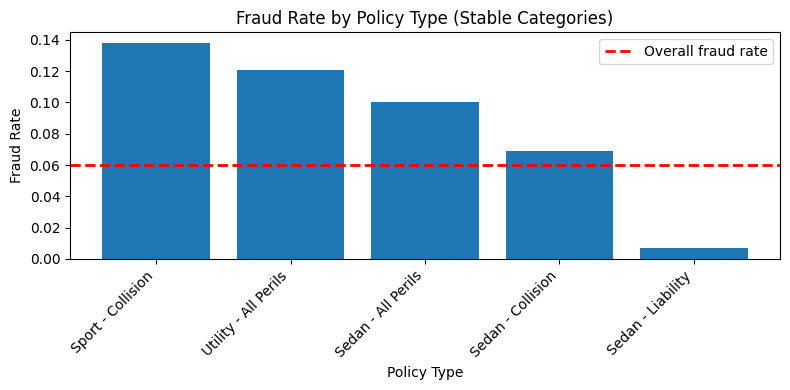

In [89]:
# Plot fraud rates for policy types with sufficient data and compare to overall fraud rate
plt.figure(figsize=(8,4))
plt.bar(policy_stats_stable.index, policy_stats_stable["fraud_rate"])
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Policy Type (Stable Categories)")
plt.xlabel("Policy Type")
plt.ylabel("Fraud Rate")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Feature - "VehicleCategory"

In [90]:
# Inspect unique vehicle category values
df["VehicleCategory"].unique()

array(['Sport', 'Utility', 'Sedan'], dtype=object)

In [91]:
# Count number of claims for each vehicle category
vehicle_counts = df["VehicleCategory"].value_counts()
vehicle_counts

VehicleCategory
Sedan      9671
Sport      5358
Utility     391
Name: count, dtype: int64

In [92]:
# Check relative distribution of claims across vehicle categories
vehicle_counts_normalized = df["VehicleCategory"].value_counts(normalize=True)
vehicle_counts_normalized

VehicleCategory
Sedan      0.627173
Sport      0.347471
Utility    0.025357
Name: proportion, dtype: float64

In [93]:
# Compute claim counts and fraud rates by vehicle category
vehicle_stats = (
    df.groupby("VehicleCategory")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
      .sort_values("fraud_rate", ascending=False)
)

vehicle_stats

count  fraud_rate
VehicleCategory                   
Utility            391    0.112532
Sedan             9671    0.082205
Sport             5358    0.015677

Utility and Sedan vehicles show higher fraud rates, while Sport vehicles have much lower observed fraud.

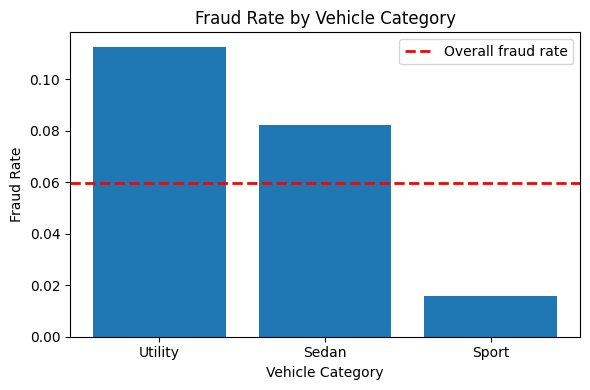

In [94]:
# Plot fraud rate by vehicle category and compare with the overall fraud rate
plt.figure(figsize=(6,4))
plt.bar(vehicle_stats.index, vehicle_stats["fraud_rate"])
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Vehicle Category")
plt.xlabel("Vehicle Category")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()

### Feature - "VehiclePrice"


In [95]:
# Inspect unique vehicle price categories in the dataset
df["VehiclePrice"].unique()

array(['more than 69000', '20000 to 29000', '30000 to 39000',
       'less than 20000', '40000 to 59000', '60000 to 69000'],
      dtype=object)

In [96]:
# Count claims by vehicle price range in a logical order
price_order = [ # Sort for interpretability
    "less than 20000",
    "20000 to 29000",
    "30000 to 39000",
    "40000 to 59000",
    "60000 to 69000",
    "more than 69000"
]

price_counts = df["VehiclePrice"].value_counts().reindex(price_order)
price_counts

VehiclePrice
less than 20000    1096
20000 to 29000     8079
30000 to 39000     3533
40000 to 59000      461
60000 to 69000       87
more than 69000    2164
Name: count, dtype: int64

In [97]:
# Check relative distribution of claims across vehicle price ranges
df["VehiclePrice"].value_counts(normalize=True).reindex(price_order)

VehiclePrice
less than 20000    0.071077
20000 to 29000     0.523930
30000 to 39000     0.229118
40000 to 59000     0.029896
60000 to 69000     0.005642
more than 69000    0.140337
Name: proportion, dtype: float64

In [98]:
# Compute claim counts and fraud rates for each vehicle price range
price_stats = (
    df.groupby("VehiclePrice")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
      .reindex(price_order)
)

price_stats

count  fraud_rate
VehiclePrice                      
less than 20000   1096    0.093978
20000 to 29000    8079    0.052110
30000 to 39000    3533    0.049533
40000 to 59000     461    0.067245
60000 to 69000      87    0.045977
more than 69000   2164    0.087338

Fraud rates are higher for very cheap and very expensive vehicles, while mid-priced vehicles show lower fraud levels.

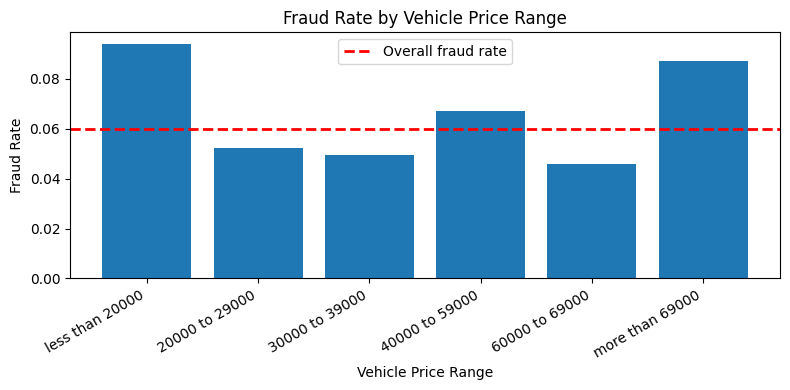

In [99]:
# Plot fraud rate across vehicle price ranges and compare with the overall fraud rate
plt.figure(figsize=(8,4))
plt.bar(price_stats.index, price_stats["fraud_rate"])
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Vehicle Price Range")
plt.xlabel("Vehicle Price Range")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=30, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

### Feature - "FraudFound_P"

In [100]:
# Inspect unique values of the target variable
df["FraudFound_P"].unique()

array([0, 1], dtype=int64)

In [101]:
# Check class counts to see the balance between fraud and non-fraud cases
df["FraudFound_P"].value_counts()

FraudFound_P
0    14497
1      923
Name: count, dtype: int64

In [102]:
# Check class proportions to understand target imbalance
df["FraudFound_P"].value_counts(normalize=True)

FraudFound_P
0    0.940143
1    0.059857
Name: proportion, dtype: float64

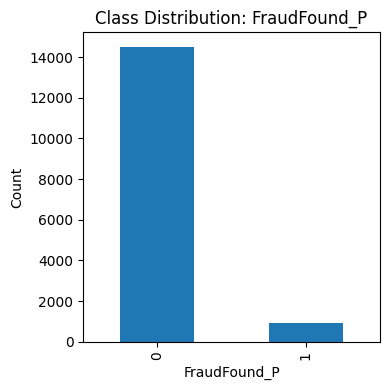

In [103]:
# Visualize class imbalance between fraud and non-fraud claims
plt.figure(figsize=(4,4))
df["FraudFound_P"].value_counts().plot(kind="bar")
plt.title("Class Distribution: FraudFound_P")
plt.xlabel("FraudFound_P")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Feature - "PolicyNumber"

Policy and report numbers are identifiers, not behavioral features, so they are excluded from the classification model.

In [104]:
# Check whether PolicyNumber is almost unique per row (identifier check)
df["PolicyNumber"].nunique(), df.shape[0]

(15420, 15420)

In [105]:
# Confirm that PolicyNumber behaves like an ID rather than a meaningful numeric feature
df["PolicyNumber"].describe()

count    15420.000000
mean      7710.500000
std       4451.514911
min          1.000000
25%       3855.750000
50%       7710.500000
75%      11565.250000
max      15420.000000
Name: PolicyNumber, dtype: float64

In [ ]:
# Group by policy number to verify it acts as an identifier, not a predictive feature
df.groupby("PolicyNumber")["FraudFound_P"].mean()

PolicyNumber
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
6        0.0
7        0.0
8        0.0
9        0.0
10       0.0
11       0.0
12       0.0
13       0.0
14       0.0
15       0.0
16       0.0
17       0.0
18       0.0
19       0.0
20       0.0
21       0.0
22       0.0
23       0.0
24       0.0
25       0.0
26       0.0
27       0.0
28       0.0
29       1.0
30       0.0
31       0.0
32       0.0
33       0.0
34       0.0
35       0.0
36       0.0
37       0.0
38       0.0
39       0.0
40       0.0
41       0.0
42       0.0
43       0.0
44       0.0
45       0.0
46       0.0
47       0.0
48       0.0
49       0.0
50       0.0
51       0.0
52       0.0
53       1.0
54       1.0
55       0.0
56       0.0
57       0.0
58       0.0
59       0.0
60       0.0
61       0.0
62       0.0
63       0.0
64       0.0
65       0.0
66       0.0
67       0.0
68       0.0
69       0.0
70       0.0
71       0.0
72       0.0
73       0.0
74       0.0
75       0.0
76       0.0

In [ ]:
# Check whether RepNumber is nearly unique per claim 
df["RepNumber"].nunique(), df.shape[0]

(16, 15420)

In [ ]:
# Check how often each report number appears to confirm it is an identifier
df["RepNumber"].value_counts()

RepNumber
7     1069
9      999
1      987
5      987
10     986
12     977
15     977
16     967
2      956
3      949
11     948
6      942
14     941
8      931
4      912
13     892
Name: count, dtype: int64

In [ ]:
# Verify that RepNumber does not carry meaningful fraud signal
df.groupby("RepNumber")["FraudFound_P"].mean()

RepNumber
1     0.063830
2     0.057531
3     0.063224
4     0.054825
5     0.052685
6     0.070064
7     0.069224
8     0.055854
9     0.065065
10    0.066937
11    0.059072
12    0.048106
13    0.065022
14    0.060574
15    0.050154
16    0.054809
Name: FraudFound_P, dtype: float64

### Feature -"Deductible"

Monthly insurance payment

In [ ]:
# Inspect unique deductible values to understand possible levels
df["Deductible"].unique()

array([300, 400, 500, 700], dtype=int64)

In [ ]:
# Check frequency of each deductible amount to see common levels
df["Deductible"].value_counts().sort_index()

Deductible
300        8
400    14838
500      263
700      311
Name: count, dtype: int64

In [ ]:
# Check relative distribution of deductible amounts
df["Deductible"].value_counts(normalize=True).sort_index()

Deductible
300    0.000519
400    0.962257
500    0.017056
700    0.020169
Name: proportion, dtype: float64

In [ ]:
# Compute claim counts and fraud rates for each deductible level
deductible_stats = (
    df.groupby("Deductible")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
      .sort_index()
)

deductible_stats

count  fraud_rate
Deductible                   
300             8    0.250000
400         14838    0.057690
500           263    0.178707
700           311    0.057878

Very low and uncommon deductible levels show higher fraud rates, while common deductibles have much lower fraud.

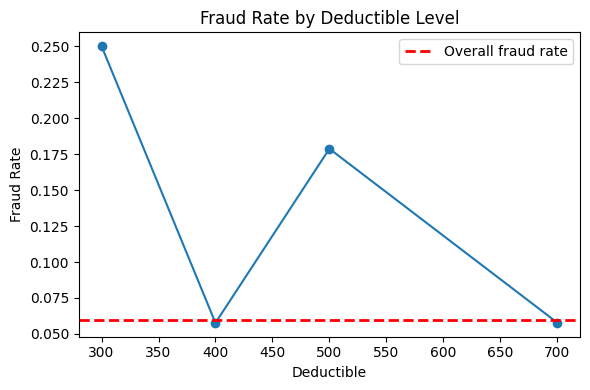

In [ ]:
# Plot fraud rate by deductible level and compare with overall fraud rate
plt.figure(figsize=(6,4))
plt.plot(
    deductible_stats.index,
    deductible_stats["fraud_rate"],
    marker="o"
)
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Deductible Level")
plt.xlabel("Deductible")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()


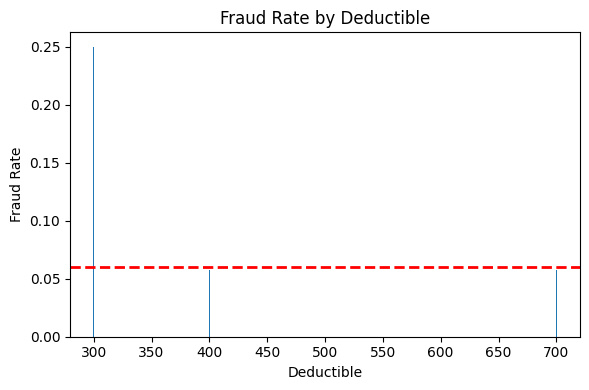

In [ ]:
# Plot fraud rate by deductible using bars for clearer comparison
plt.figure(figsize=(6,4))
plt.bar(deductible_stats.index, deductible_stats["fraud_rate"])
plt.axhline(overall_fraud_rate, color="red", linestyle="--", linewidth=2)
plt.xlabel("Deductible")
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate by Deductible")
plt.tight_layout()
plt.show()

### Feature -"DriverRating"

In [ ]:
# Inspect unique driver rating values to understand possible score levels
df["DriverRating"].unique()

array([1, 4, 3, 2], dtype=int64)

In [ ]:
# Check how frequently each driver rating appears in the data
df["DriverRating"].value_counts().sort_index()

DriverRating
1    3944
2    3801
3    3884
4    3791
Name: count, dtype: int64

In [ ]:
# Check relative distribution of driver ratings to see which scores are most common
df["DriverRating"].value_counts(normalize=True).sort_index()

DriverRating
1    0.255772
2    0.246498
3    0.251881
4    0.245850
Name: proportion, dtype: float64

In [ ]:
# Fraud rate varies across DriverRating levels
driver_rating_stats = (
    df.groupby("DriverRating")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
      .sort_index()
)

driver_rating_stats

count  fraud_rate
DriverRating                   
1              3944    0.058824
2              3801    0.056301
3              3884    0.062307
4              3791    0.061989

Fraud rates are very similar across DriverRating levels, with no clear monotonic relationship.

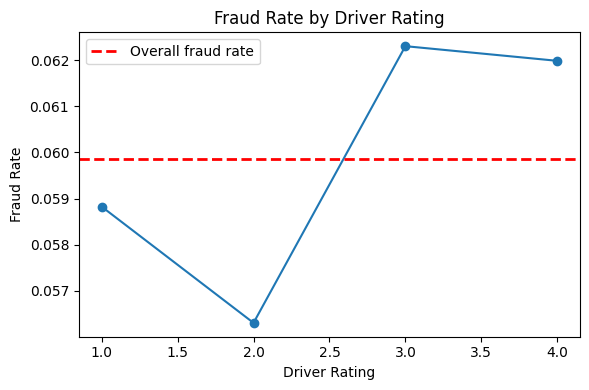

In [ ]:
# Plot of fraud rate by DriverRating with overall fraud rate as baseline
plt.figure(figsize=(6,4))
plt.plot(
    driver_rating_stats.index,
    driver_rating_stats["fraud_rate"],
    marker="o"
)
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Driver Rating")
plt.xlabel("Driver Rating")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()

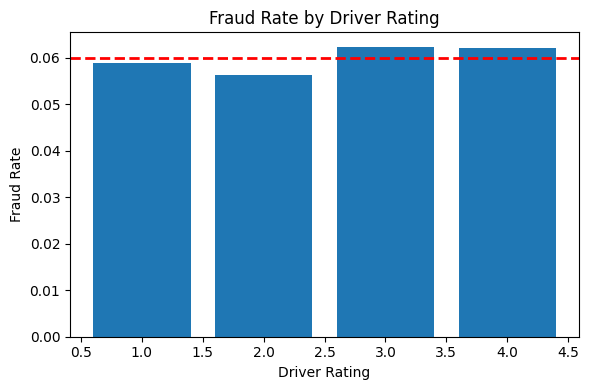

In [ ]:
# Bar plot of fraud rate by DriverRating compared to overall fraud level
plt.figure(figsize=(6,4))
plt.bar(driver_rating_stats.index, driver_rating_stats["fraud_rate"])
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2
)
plt.xlabel("Driver Rating")
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate by Driver Rating")
plt.tight_layout()
plt.show()

### Feature - "Days_Policy_Accident"

In [ ]:
# Inspect unique values of Days_Policy_Accident to understand category encoding
df["Days_Policy_Accident"].unique()

array(['more than 30', '15 to 30', 'none', '1 to 7', '8 to 15'],
      dtype=object)

In [ ]:
# Define ordered categories for Days_Policy_Accident
accident_order = [
    "none",
    "1 to 7",
    "8 to 15",
    "15 to 30",
    "more than 30"
]

In [ ]:
# Count observations per Days_Policy_Accident category
accident_counts = (
    df["Days_Policy_Accident"]
    .value_counts()
    .reindex(accident_order)
)

accident_counts

Days_Policy_Accident
none               55
1 to 7             14
8 to 15            55
15 to 30           49
more than 30    15247
Name: count, dtype: int64

In [ ]:
# Share of records in each Days_Policy_Accident category
df["Days_Policy_Accident"] \
  .value_counts(normalize=True) \
  .reindex(accident_order)

Days_Policy_Accident
none            0.003567
1 to 7          0.000908
8 to 15         0.003567
15 to 30        0.003178
more than 30    0.988781
Name: proportion, dtype: float64

In [ ]:
# Fraud rate by Days_Policy_Accident category
accident_stats = (
    df.groupby("Days_Policy_Accident")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
      .reindex(accident_order)
)

accident_stats

count  fraud_rate
Days_Policy_Accident                   
none                     55    0.163636
1 to 7                   14    0.071429
8 to 15                  55    0.090909
15 to 30                 49    0.061224
more than 30          15247    0.059356

Fraud rate is highest when no policy–accident delay is recorded, but this group is very small compared to the dominant “more than 30 days” category.

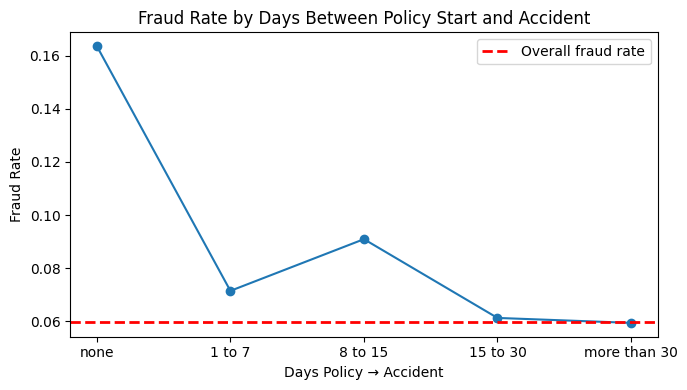

In [ ]:
# Plot fraud rate by Days_Policy_Accident with overall fraud rate reference
plt.figure(figsize=(7,4))
plt.plot(
    accident_stats.index,
    accident_stats["fraud_rate"],
    marker="o"
)
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Days Between Policy Start and Accident")
plt.xlabel("Days Policy → Accident")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()

### Feature - "Days_Policy_Claim"

In [ ]:
# Inspect unique values of Days_Policy_Claim to understand category encoding
df["Days_Policy_Claim"].unique()

array(['more than 30', '15 to 30', '8 to 15', 'none'], dtype=object)

In [ ]:
# Define ordered categories for Days_Policy_Claim
claim_order = [ 
    "none",
    "8 to 15",
    "15 to 30",
    "more than 30"
]

In [ ]:
# Count observations per Days_Policy_Claim category
claim_counts = (
    df["Days_Policy_Claim"]
    .value_counts()
    .reindex(claim_order)
)

claim_counts

Days_Policy_Claim
none                1
8 to 15            21
15 to 30           56
more than 30    15342
Name: count, dtype: int64

In [131]:
df["Days_Policy_Claim"] \
  .value_counts(normalize=True) \
  .reindex(claim_order)

Days_Policy_Claim
none            0.000065
8 to 15         0.001362
15 to 30        0.003632
more than 30    0.994942
Name: proportion, dtype: float64

In [ ]:
# Fraud rate by Days_Policy_Claim category
claim_stats = (
    df.groupby("Days_Policy_Claim")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
      .reindex(claim_order)
)

claim_stats

count  fraud_rate
Days_Policy_Claim                   
none                   1    0.000000
8 to 15               21    0.142857
15 to 30              56    0.107143
more than 30       15342    0.059575

Fraud rate is higher for shorter policy-to-claim delays, but these groups are small compared to the dominant “more than 30 days” category.

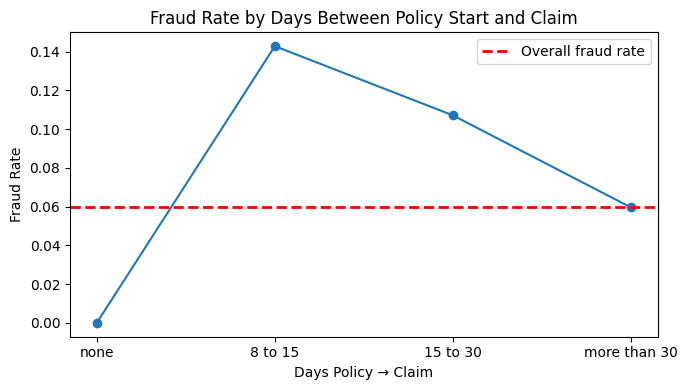

In [ ]:
# Plot fraud rate by Days_Policy_Claim with overall fraud rate reference
plt.figure(figsize=(7,4))
plt.plot(
    claim_stats.index,
    claim_stats["fraud_rate"],
    marker="o"
)
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Days Between Policy Start and Claim")
plt.xlabel("Days Policy → Claim")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()

### Feature - "PastNumberOfClaims"

In [ ]:
# Inspect unique values of PastNumberOfClaims to understand category encoding
df["PastNumberOfClaims"].unique()

array(['none', '1', '2 to 4', 'more than 4'], dtype=object)

In [ ]:
# Define ordered categories for PastNumberOfClaims
claims_order = [ 
    "none",
    "1",
    "2 to 4",
    "more than 4"
]

In [ ]:
# Count observations per PastNumberOfClaims category
claims_counts = (
    df["PastNumberOfClaims"]
    .value_counts()
    .reindex(claims_order)
)

claims_counts

PastNumberOfClaims
none           4352
1              3573
2 to 4         5485
more than 4    2010
Name: count, dtype: int64

In [ ]:
# Fraud rate by PastNumberOfClaims category
past_claims_stats = (
    df.groupby("PastNumberOfClaims")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
      .reindex(claims_order)
)

past_claims_stats

count  fraud_rate
PastNumberOfClaims                   
none                 4352    0.077895
1                    3573    0.062133
2 to 4               5485    0.053601
more than 4          2010    0.033831

Fraud rate decreases as the number of past claims increases, suggesting a counterintuitive but stable pattern.

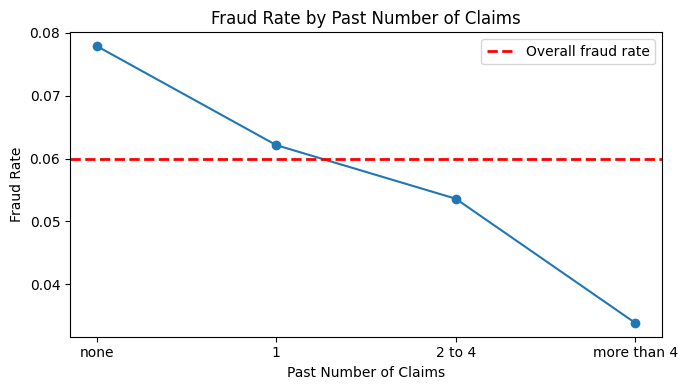

In [ ]:
# Plot fraud rate by PastNumberOfClaims with overall fraud rate reference
plt.figure(figsize=(7,4))
plt.plot(
    past_claims_stats.index,
    past_claims_stats["fraud_rate"],
    marker="o"
)
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Past Number of Claims")
plt.xlabel("Past Number of Claims")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()

### Feature - "AgeOfVehicle"

In [ ]:
# Inspect unique values of AgeOfVehicle to understand category encoding
df["AgeOfVehicle"].unique()

array(['3 years', '6 years', '7 years', 'more than 7', '5 years', 'new',
       '4 years', '2 years'], dtype=object)

In [ ]:
# Define ordered categories for AgeOfVehicle
vehicle_age_order = [
    "new",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "more than 7"
]

In [ ]:
# Count observations per AgeOfVehicle category
vehicle_age_counts = (
    df["AgeOfVehicle"]
    .value_counts()
    .reindex(vehicle_age_order)
)

vehicle_age_counts

AgeOfVehicle
new             373
2 years          73
3 years         152
4 years         229
5 years        1357
6 years        3448
7 years        5807
more than 7    3981
Name: count, dtype: int64

In [ ]:
# Share of records in each AgeOfVehicle category
df["AgeOfVehicle"] \
  .value_counts(normalize=True) \
  .reindex(vehicle_age_order)

AgeOfVehicle
new            0.024189
2 years        0.004734
3 years        0.009857
4 years        0.014851
5 years        0.088003
6 years        0.223606
7 years        0.376589
more than 7    0.258171
Name: proportion, dtype: float64

In [ ]:
# Fraud rate by AgeOfVehicle category
vehicle_age_stats = (
    df.groupby("AgeOfVehicle")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
      .reindex(vehicle_age_order)
)

vehicle_age_stats

count  fraud_rate
AgeOfVehicle                   
new             373    0.085791
2 years          73    0.041096
3 years         152    0.085526
4 years         229    0.091703
5 years        1357    0.070007
6 years        3448    0.066125
7 years        5807    0.055967
more than 7    3981    0.051746

Fraud rate is higher for very new and mid-aged vehicles, then gradually declines as vehicle age increases.

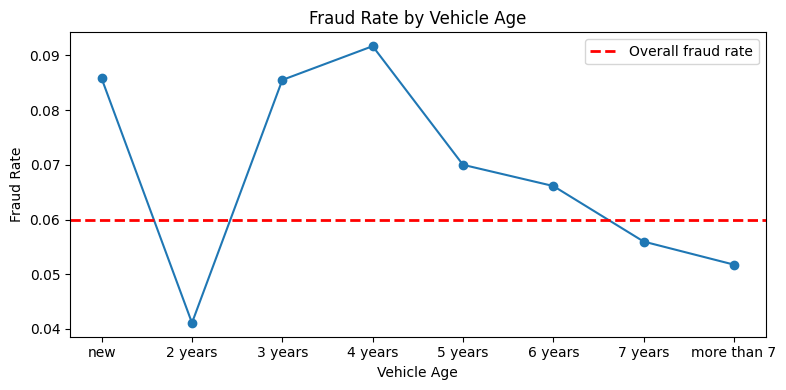

In [ ]:
# Plot fraud rate by AgeOfVehicle with overall fraud rate reference
plt.figure(figsize=(8,4))
plt.plot(
    vehicle_age_stats.index,
    vehicle_age_stats["fraud_rate"],
    marker="o"
)
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Vehicle Age")
plt.xlabel("Vehicle Age")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()


### Feature - "AgeOfPolicyHolder"

In [ ]:
# Inspect unique values of AgeOfPolicyHolder
df["AgeOfPolicyHolder"].unique()

array(['26 to 30', '31 to 35', '41 to 50', '51 to 65', '21 to 25',
       '36 to 40', '16 to 17', 'over 65', '18 to 20'], dtype=object)

In [ ]:
# Define ordered age groups for policyholders 
policyholder_age_order = [
    "16 to 17",
    "18 to 20",
    "21 to 25",
    "26 to 30",
    "31 to 35",
    "36 to 40",
    "41 to 50",
    "51 to 65",
    "over 65"
]

In [ ]:
# Count policyholders per age group in defined order

age_ph_counts = (
    df["AgeOfPolicyHolder"]
    .value_counts()
    .reindex(policyholder_age_order)
)

age_ph_counts

AgeOfPolicyHolder
16 to 17     320
18 to 20      15
21 to 25     108
26 to 30     613
31 to 35    5593
36 to 40    4043
41 to 50    2828
51 to 65    1392
over 65      508
Name: count, dtype: int64

In [ ]:
# Show proportion of policyholders in each age group
df["AgeOfPolicyHolder"] \
  .value_counts(normalize=True) \
  .reindex(policyholder_age_order)

AgeOfPolicyHolder
16 to 17    0.020752
18 to 20    0.000973
21 to 25    0.007004
26 to 30    0.039754
31 to 35    0.362711
36 to 40    0.262192
41 to 50    0.183398
51 to 65    0.090272
over 65     0.032944
Name: proportion, dtype: float64

In [ ]:
# Compute count and fraud rate by policyholder age group
age_ph_stats = (
    df.groupby("AgeOfPolicyHolder")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
      .reindex(policyholder_age_order)
)

age_ph_stats

count  fraud_rate
AgeOfPolicyHolder                   
16 to 17             320    0.096875
18 to 20              15    0.133333
21 to 25             108    0.148148
26 to 30             613    0.053834
31 to 35            5593    0.064366
36 to 40            4043    0.058620
41 to 50            2828    0.050919
51 to 65            1392    0.050287
over 65              508    0.059055

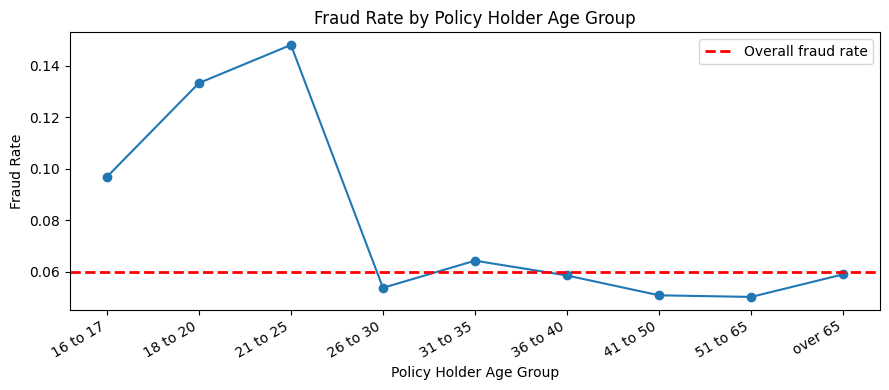

In [ ]:
# Plot fraud rate by policyholder age group with overall average reference
plt.figure(figsize=(9,4))
plt.plot(
    age_ph_stats.index,
    age_ph_stats["fraud_rate"],
    marker="o"
)
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Policy Holder Age Group")
plt.xlabel("Policy Holder Age Group")
plt.ylabel("Fraud Rate")
plt.legend()
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


### Feature - "PoliceReportFiled"

In [ ]:
# Inspect unique values of PoliceReportFiled
df["PoliceReportFiled"].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
# Show proportion of records by PoliceReportFiled status
df["PoliceReportFiled"].value_counts(normalize=True)

PoliceReportFiled
No     0.972244
Yes    0.027756
Name: proportion, dtype: float64

In [ ]:
# Compute count and fraud rate by PoliceReportFiled status
police_stats = (
    df.groupby("PoliceReportFiled")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
)

police_stats


count  fraud_rate
PoliceReportFiled                   
No                 14992    0.060499
Yes                  428    0.037383

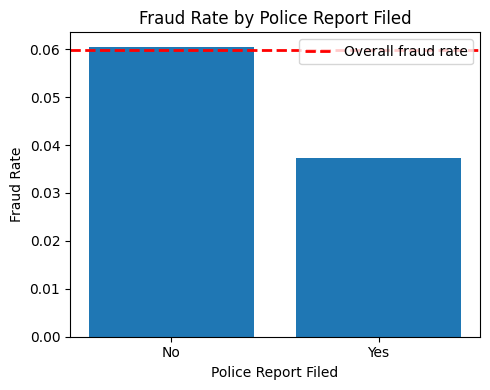

In [ ]:
# Plot fraud rate by PoliceReportFiled with overall average reference
plt.figure(figsize=(5,4))
plt.bar(police_stats.index, police_stats["fraud_rate"])
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Police Report Filed")
plt.xlabel("Police Report Filed")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()

### Feature - "WitnessPresent"

In [ ]:
# Inspect unique values of WitnessPresent
df["WitnessPresent"].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
# Count occurrences of each WitnessPresent category
df["WitnessPresent"].value_counts()

WitnessPresent
No     15333
Yes       87
Name: count, dtype: int64

In [ ]:
# Show proportion of records by WitnessPresent status
df["WitnessPresent"].value_counts(normalize=True)

WitnessPresent
No     0.994358
Yes    0.005642
Name: proportion, dtype: float64

In [ ]:
# Compute count and fraud rate by WitnessPresent status
witness_stats = (
    df.groupby("WitnessPresent")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
)

witness_stats

count  fraud_rate
WitnessPresent                   
No              15333    0.060001
Yes                87    0.034483

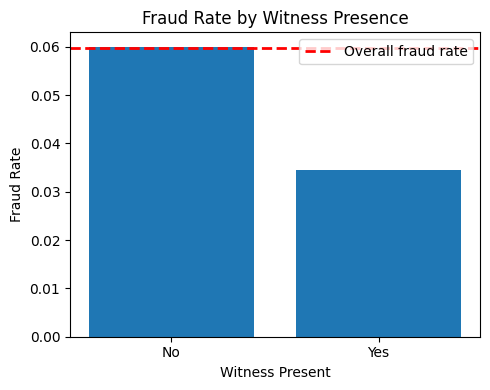

In [ ]:
# Plot fraud rate by WitnessPresent with overall average reference
plt.figure(figsize=(5,4))
plt.bar(witness_stats.index, witness_stats["fraud_rate"])
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Witness Presence")
plt.xlabel("Witness Present")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()

### Feature - "AgentType"

In [ ]:
# Inspect unique values of AgentType
df["AgentType"].unique()

array(['External', 'Internal'], dtype=object)

In [ ]:
# Count occurrences of each AgentType
df["AgentType"].value_counts()

AgentType
External    15179
Internal      241
Name: count, dtype: int64

In [ ]:
# Show proportion of records by AgentType
df["AgentType"].value_counts(normalize=True)

AgentType
External    0.984371
Internal    0.015629
Name: proportion, dtype: float64

In [ ]:
# Compute count and fraud rate by AgentType
agent_stats = (
    df.groupby("AgentType")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
)

agent_stats

count  fraud_rate
AgentType                   
External   15179    0.060544
Internal     241    0.016598

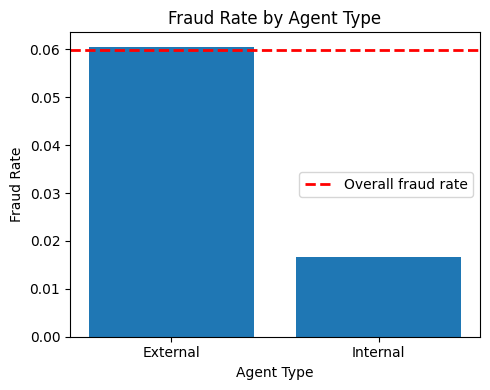

In [ ]:
# Plot fraud rate by AgentType with overall average reference
plt.figure(figsize=(5,4))
plt.bar(agent_stats.index, agent_stats["fraud_rate"])
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Agent Type")
plt.xlabel("Agent Type")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()


### Feature - "NumberOfSuppliments"

In [ ]:
# Inspect unique values of NumberOfSuppliments
df["NumberOfSuppliments"].unique()

array(['none', 'more than 5', '3 to 5', '1 to 2'], dtype=object)

In [ ]:
# Sort the number of suppliments 
supp_order = [
    "none",
    "1 to 2",
    "3 to 5",
    "more than 5"
]

In [ ]:
# Count number of supplements per category in defined order
supp_counts = (
    df["NumberOfSuppliments"]
    .value_counts()
    .reindex(supp_order)
)

supp_counts

NumberOfSuppliments
none           7047
1 to 2         2489
3 to 5         2017
more than 5    3867
Name: count, dtype: int64

In [ ]:
# Show proportion of records by number of supplements in defined order
df["NumberOfSuppliments"] \
  .value_counts(normalize=True) \
  .reindex(supp_order)

NumberOfSuppliments
none           0.457004
1 to 2         0.161414
3 to 5         0.130804
more than 5    0.250778
Name: proportion, dtype: float64

In [ ]:
# Compute count and fraud rate by NumberOfSuppliments in defined order
supp_stats = (
    df.groupby("NumberOfSuppliments")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
      .reindex(supp_order)
)

supp_stats

count  fraud_rate
NumberOfSuppliments                   
none                  7047    0.066979
1 to 2                2489    0.063881
3 to 5                2017    0.048091
more than 5           3867    0.050427

Fraud rate decreases slightly as the number of supplements increases.

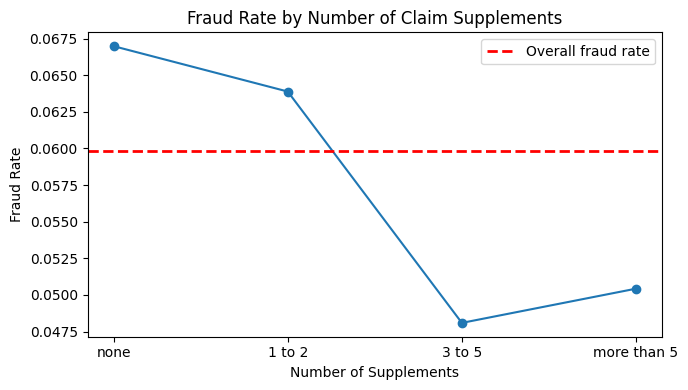

In [ ]:
# Plot fraud rate by NumberOfSuppliments with overall average reference
plt.figure(figsize=(7,4))
plt.plot(
    supp_stats.index,
    supp_stats["fraud_rate"],
    marker="o"
)
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Number of Claim Supplements")
plt.xlabel("Number of Supplements")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()

### Feature - "AddressChange_Claim"

In [ ]:
# Inspect unique values of AddressChange_Claim
df["AddressChange_Claim"].unique()

array(['1 year', 'no change', '4 to 8 years', '2 to 3 years',
       'under 6 months'], dtype=object)

In [ ]:
# Sort adress change claim
address_order = [ #sort adress change claim
    "under 6 months",
    "1 year",
    "2 to 3 years",
    "4 to 8 years",
    "no change"
]

In [ ]:
# Count records by AddressChange_Claim status in defined order
address_counts = (
    df["AddressChange_Claim"]
    .value_counts()
    .reindex(address_order)
)

address_counts

AddressChange_Claim
under 6 months        4
1 year              170
2 to 3 years        291
4 to 8 years        631
no change         14324
Name: count, dtype: int64

In [ ]:
# Show proportion of records by AddressChange_Claim status in defined order
df["AddressChange_Claim"] \
  .value_counts(normalize=True) \
  .reindex(address_order)

AddressChange_Claim
under 6 months    0.000259
1 year            0.011025
2 to 3 years      0.018872
4 to 8 years      0.040921
no change         0.928923
Name: proportion, dtype: float64

In [ ]:
# Compute count and fraud rate by AddressChange_Claim in defined order
address_stats = (
    df.groupby("AddressChange_Claim")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
      .reindex(address_order)
)

address_stats

count  fraud_rate
AddressChange_Claim                   
under 6 months           4    0.750000
1 year                 170    0.064706
2 to 3 years           291    0.175258
4 to 8 years           631    0.052298
no change            14324    0.057596

Fraud rate is highest for very recent address changes and lower for longer or no changes.

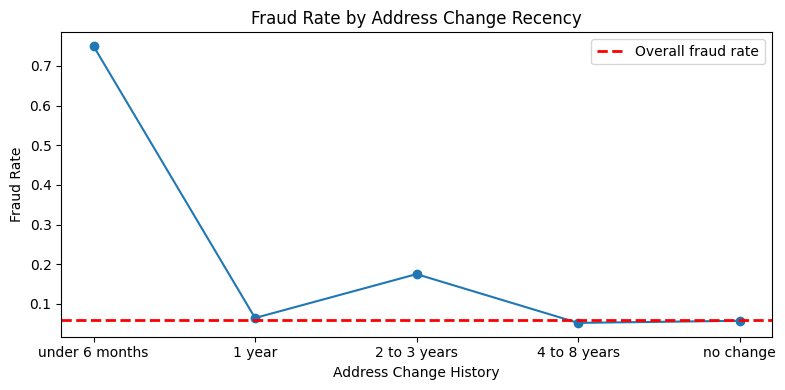

In [ ]:
# Plot fraud rate by AddressChange_Claim with overall average reference
plt.figure(figsize=(8,4))
plt.plot(
    address_stats.index,
    address_stats["fraud_rate"],
    marker="o"
)
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Address Change Recency")
plt.xlabel("Address Change History")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()

### Feature - "NumberOfCars"

In [ ]:
# Inspect unique values of NumberOfCars
df["NumberOfCars"].unique()

array(['3 to 4', '1 vehicle', '2 vehicles', '5 to 8', 'more than 8'],
      dtype=object)

In [ ]:
# Sort number of vehicles
cars_order = [ 
    "1 vehicle",
    "2 vehicles",
    "3 to 4",
    "5 to 8",
    "more than 8"
]

In [ ]:
# Count records by NumberOfCars in defined order
cars_counts = (
    df["NumberOfCars"]
    .value_counts()
    .reindex(cars_order)
)

cars_counts

NumberOfCars
1 vehicle      14316
2 vehicles       709
3 to 4           372
5 to 8            21
more than 8        2
Name: count, dtype: int64

In [ ]:
# Show proportion of records by NumberOfCars in defined order
df["NumberOfCars"] \
  .value_counts(normalize=True) \
  .reindex(cars_order)

NumberOfCars
1 vehicle      0.928405
2 vehicles     0.045979
3 to 4         0.024125
5 to 8         0.001362
more than 8    0.000130
Name: proportion, dtype: float64

In [ ]:
# Compute count and fraud rate by NumberOfCars in defined order
cars_stats = (
    df.groupby("NumberOfCars")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
      .reindex(cars_order)
)

cars_stats

count  fraud_rate
NumberOfCars                   
1 vehicle     14316    0.059374
2 vehicles      709    0.060649
3 to 4          372    0.077957
5 to 8           21    0.047619
more than 8       2    0.000000

Fraud rate is slightly higher for 3–4 cars, but data is sparse for many vehicles.

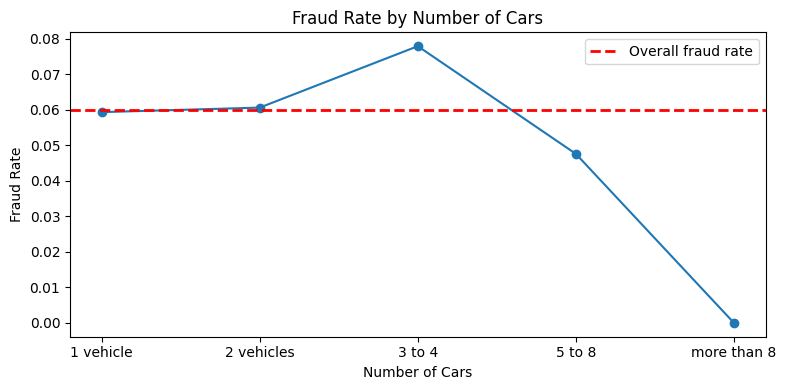

In [ ]:
# Plot fraud rate by NumberOfCars with overall average reference
plt.figure(figsize=(8,4))
plt.plot(
    cars_stats.index,
    cars_stats["fraud_rate"],
    marker="o"
)
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Number of Cars")
plt.xlabel("Number of Cars")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()

### Feature - "Year"

In [ ]:
# Inspect unique years 
df["Year"].unique()

Year
1994    6142
1995    5195
1996    4083
Name: count, dtype: int64

In [ ]:
# Count of records per Year
df["Year"].value_counts(normalize=True).sort_index()

Year
1994    0.398314
1995    0.336900
1996    0.264786
Name: proportion, dtype: float64

In [ ]:
# Compute count and fraud rate by Year of claim
year_stats = (
    df.groupby("Year")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
      .sort_index()
)

year_stats

count  fraud_rate
Year                   
1994   6142    0.066591
1995   5195    0.057940
1996   4083    0.052168

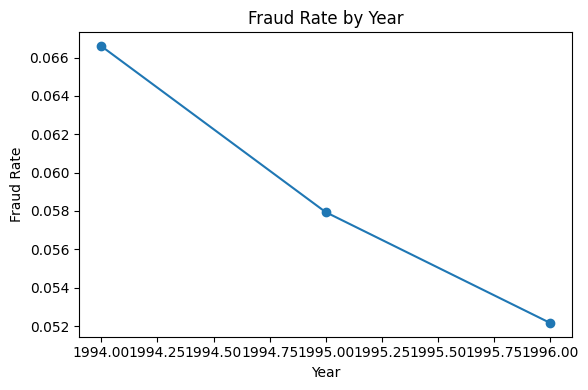

In [ ]:
# Plot fraud rate by Year of claim
plt.figure(figsize=(6,4))
plt.plot(
    year_stats.index,
    year_stats["fraud_rate"],
    marker="o"
)
plt.title("Fraud Rate by Year")
plt.xlabel("Year")
plt.ylabel("Fraud Rate")
plt.tight_layout()
plt.show()

Year was excluded from modeling as it represents a temporal index rather than an intrinsic fraud risk factor, and its inclusion could lead to overfitting to historical patterns.

### Feature - "Base Policy"

In [ ]:
# Inspect unique values of BasePolicy
df["BasePolicy"].unique()

# Different types of policy 
# Liability - protects from external factors (Weather, Theft)
# Collision - protects from collisions from policy holder and 3rd parties
# All perils - combines both policies above into one

array(['Liability', 'Collision', 'All Perils'], dtype=object)

In [ ]:
# Inspect unique values of BasePolicy
df["BasePolicy"].unique()

array(['Liability', 'Collision', 'All Perils'], dtype=object)

In [ ]:
# Show proportion of records by BasePolicy type
df["BasePolicy"].value_counts(normalize=True)

BasePolicy
Collision     0.386641
Liability     0.324838
All Perils    0.288521
Name: proportion, dtype: float64

In [ ]:
# Compute count and fraud rate by BasePolicy type
basepolicy_stats = (
    df.groupby("BasePolicy")["FraudFound_P"]
      .agg(count="size", fraud_rate="mean")
)

basepolicy_stats

count  fraud_rate
BasePolicy                   
All Perils   4449    0.101596
Collision    5962    0.072962
Liability    5009    0.007187

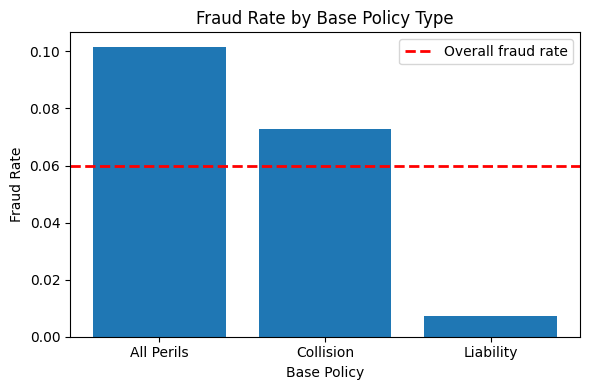

In [ ]:
# Plot fraud rate by BasePolicy with overall average reference
plt.figure(figsize=(6,4))
plt.bar(
    basepolicy_stats.index,
    basepolicy_stats["fraud_rate"]
)
plt.axhline(
    overall_fraud_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall fraud rate"
)

plt.title("Fraud Rate by Base Policy Type")
plt.xlabel("Base Policy")
plt.ylabel("Fraud Rate")
plt.legend()
plt.tight_layout()
plt.show()


## Feature engineering

In [ ]:
# Create summary table showing column types, number of unique values, and the unique values themselves
unique_df = pd.DataFrame({ 
    "column": df.columns,
    "dtype": df.dtypes.values,
    "n_unique": df.nunique().values,
    "unique_values": [df[col].unique() for col in df.columns]
})

unique_df

column    dtype  n_unique  \
0                  Month   object        12   
1            WeekOfMonth    int64         5   
2              DayOfWeek   object         7   
3                   Make   object        19   
4           AccidentArea   object         2   
5       DayOfWeekClaimed   object         8   
6           MonthClaimed   object        13   
7     WeekOfMonthClaimed    int64         5   
8                    Sex   object         2   
9          MaritalStatus   object         4   
10                   Age  float64        65   
11                 Fault   object         2   
12            PolicyType   object         9   
13       VehicleCategory   object         3   
14          VehiclePrice   object         6   
15          FraudFound_P    int64         2   
16          PolicyNumber    int64     15420   
17             RepNumber    int64        16   
18            Deductible    int64         4   
19          DriverRating    int64         4   
20  Days_Policy_Accident   object         5   
21     Days_Policy_Claim   object         4   
22    PastNumberOfClaims   object         4   
23          AgeOfVehicle   object         8   
24     AgeOfPolicyHolder   object         9   
25     PoliceReportFiled   object         2   
26        WitnessPresent   object         2   
27             AgentType   object         2   
28   NumberOfSuppliments   object         4   
29   AddressChange_Claim   object         5   
30          NumberOfCars   object         5   
31                  Year    int64         3   
32            BasePolicy   object         3   

                                                                                                                                                                                                                                                                                                                                                                                                    unique_values  
0                                                                                                                                                                                                                                                                                                                                                    [Dec, Jan, Oct, Jun, Feb, Nov, Apr, Mar, Aug, Jul, May, Sep]  
1                                                                                                                                                                                                                                                                                                                                                                                                 [5, 3, 2, 4, 1]  
2                                                                                                                                                                                                                                                                                                                                                [Wednesday, Friday, Saturday, Monday, Tuesday, Sunday, Thursday]  
3                                                                                                                                                                                                                                                       [Honda, Toyota, Ford, Mazda, Chevrolet, Pontiac, Acura, Dodge, Mercury, Jaguar, Nissan, Volkswagen, Saab, Saturn, Porsche, BMW, Mercedes, Ferrari, Lexus]  
4                                                                                                                                                                                                                                                                                                                                                                                                  [Urban, Rura

In [ ]:
# Set the target variable
y = df["FraudFound_P"]

# Prepare features by dropping unused columns
X = df.drop(
    columns=[
        "FraudFound_P",
        "PolicyNumber",
        "RepNumber",
        "Year"
    ]
)

### Train / Test / Val split

In [ ]:
# Split data: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.40,
    stratify=y,
    random_state=42
)

# Split temp (20% val, 20% test of full data)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)


### Binary flags

In [ ]:
def add_binary_flags(df):
    df = df.copy()

    # Early accident flag: none or 1 to 7 days
    df["Early_Accident_Flag"] = df["Days_Policy_Accident"].isin(
        ["none", "1 to 7"]
    ).astype(int)

    # Early claim flag: anything not more than 30 days
    df["Early_Claim_Flag"] = (
        df["Days_Policy_Claim"] != "more than 30"
    ).astype(int)

    # Missing age flag
    df["Age_Missing_Flag"] = df["Age"].isna().astype(int)

    # Multiple supplements flag: anything not "none"
    df["Multiple_Supplements_Flag"] = (
        df["NumberOfSuppliments"] != "none"
    ).astype(int)

    # Single vehicle flag
    df["Single_Vehicle_Flag"] = (
        df["NumberOfCars"] == "1 vehicle"
    ).astype(int)

    # Recent address change flag: under 6 months or 1 year
    df["Recent_Address_Change_Flag"] = df["AddressChange_Claim"].isin(
        ["under 6 months", "1 year"]
    ).astype(int)

    return df

In [ ]:
# Add binary flags to train, validation, and test sets
X_train = add_binary_flags(X_train)
X_val   = add_binary_flags(X_val)
X_test  = add_binary_flags(X_test)

In [ ]:
# Define mapping for binary columns
binary_map = {
    "PoliceReportFiled": {"Yes": 1, "No": 0},
    "WitnessPresent": {"Yes": 1, "No": 0},
    "AgentType": {"External": 1, "Internal": 0},
    "Sex": {"Male": 1, "Female": 0},
    "Fault": {"Policy Holder": 1, "Third Party": 0},
    "AccidentArea": {"Urban": 1, "Rural": 0},
}

# Function to apply binary mapping
def apply_binary_map(df):
    df = df.copy()
    for col, mapping in binary_map.items():
        df[col] = df[col].map(mapping)
    return df

# Apply binary mapping to datasets
X_train = apply_binary_map(X_train)
X_val   = apply_binary_map(X_val)
X_test  = apply_binary_map(X_test)

In [ ]:
# Define ordinal mappings for string columns
ORDINAL_MAPS = {
    "PastNumberOfClaims": {"none": 0, "1": 1, "2 to 4": 2, "more than 4": 3},
    "NumberOfSuppliments": {"none": 0, "1 to 2": 1, "3 to 5": 2, "more than 5": 3},
    "Days_Policy_Accident": {"none": 0, "1 to 7": 1, "8 to 15": 2, "15 to 30": 3, "more than 30": 4},
    "AgeOfVehicle": {"new": 0, "2 years": 1, "3 years": 2, "4 years": 3, "5 years": 4, "6 years": 5, "7 years": 6, "more than 7": 7},
    "AgeOfPolicyHolder": {"16 to 17": 0, "18 to 20": 1, "21 to 25": 2, "26 to 30": 3, "31 to 35": 4, "36 to 40": 5, "41 to 50": 6, "51 to 65": 7, "over 65": 8},
    "AddressChange_Claim": {"under 6 months": 0, "1 year": 1, "2 to 3 years": 2, "4 to 8 years": 3, "no change": 4},
    "NumberOfCars": {"1 vehicle": 1, "2 vehicles": 2, "3 to 4": 3, "5 to 8": 4, "more than 8": 5}
}

# Separate mapping for Days_Policy_Claim
days_policy_claim_map = {"none": 0, "8 to 15": 1, "15 to 30": 2, "more than 30": 3}

# Apply Days_Policy_Claim mapping
for df_ in [X_train, X_val, X_test]:
    df_["Days_Policy_Claim"] = df_["Days_Policy_Claim"].map(days_policy_claim_map)

# Function to apply ordinal mappings
def apply_ordinal_map(df):
    df = df.copy()
    for col, mapping in ORDINAL_MAPS.items():
        df[col] = df[col].map(mapping)
    return df

# Apply ordinal mapping to datasets
X_train = apply_ordinal_map(X_train)
X_val   = apply_ordinal_map(X_val)
X_test  = apply_ordinal_map(X_test)


In [ ]:
# Define nominal columns to one-hot encode
NOMINAL_COLS = [
    "Month",
    "DayOfWeek",
    "MonthClaimed",
    "DayOfWeekClaimed",
    "MaritalStatus",
    "VehicleCategory",
    "VehiclePrice",
    "BasePolicy",
    "Make"
]

# Apply one-hot encoding to training set
X_train = pd.get_dummies(X_train, columns=NOMINAL_COLS, drop_first=True)

# Align validation and test sets to training columns
X_val  = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

### Feature List

In [ ]:
# Get list of all feature names
feature_names = X_train.columns.tolist()

# Check number of features and display them
len(feature_names), feature_names

(92,
 ['WeekOfMonth',
  'AccidentArea',
  'WeekOfMonthClaimed',
  'Sex',
  'Age',
  'Fault',
  'PolicyType',
  'Deductible',
  'DriverRating',
  'Days_Policy_Accident',
  'Days_Policy_Claim',
  'PastNumberOfClaims',
  'AgeOfVehicle',
  'AgeOfPolicyHolder',
  'PoliceReportFiled',
  'WitnessPresent',
  'AgentType',
  'NumberOfSuppliments',
  'AddressChange_Claim',
  'NumberOfCars',
  'Early_Accident_Flag',
  'Early_Claim_Flag',
  'Age_Missing_Flag',
  'Multiple_Supplements_Flag',
  'Single_Vehicle_Flag',
  'Recent_Address_Change_Flag',
  'Month_Aug',
  'Month_Dec',
  'Month_Feb',
  'Month_Jan',
  'Month_Jul',
  'Month_Jun',
  'Month_Mar',
  'Month_May',
  'Month_Nov',
  'Month_Oct',
  'Month_Sep',
  'DayOfWeek_Monday',
  'DayOfWeek_Saturday',
  'DayOfWeek_Sunday',
  'DayOfWeek_Thursday',
  'DayOfWeek_Tuesday',
  'DayOfWeek_Wednesday',
  'MonthClaimed_Aug',
  'MonthClaimed_Dec',
  'MonthClaimed_Feb',
  'MonthClaimed_Jan',
  'MonthClaimed_Jul',
  'MonthClaimed_Jun',
  'MonthClaimed_Mar',
 

In [ ]:
# Print features in a human-readable numbered format
for i, col in enumerate(feature_names, 1):
    print(f"{i:03d}. {col}")

001. WeekOfMonth
002. AccidentArea
003. WeekOfMonthClaimed
004. Sex
005. Age
006. Fault
007. PolicyType
008. Deductible
009. DriverRating
010. Days_Policy_Accident
011. Days_Policy_Claim
012. PastNumberOfClaims
013. AgeOfVehicle
014. AgeOfPolicyHolder
015. PoliceReportFiled
016. WitnessPresent
017. AgentType
018. NumberOfSuppliments
019. AddressChange_Claim
020. NumberOfCars
021. Early_Accident_Flag
022. Early_Claim_Flag
023. Age_Missing_Flag
024. Multiple_Supplements_Flag
025. Single_Vehicle_Flag
026. Recent_Address_Change_Flag
027. Month_Aug
028. Month_Dec
029. Month_Feb
030. Month_Jan
031. Month_Jul
032. Month_Jun
033. Month_Mar
034. Month_May
035. Month_Nov
036. Month_Oct
037. Month_Sep
038. DayOfWeek_Monday
039. DayOfWeek_Saturday
040. DayOfWeek_Sunday
041. DayOfWeek_Thursday
042. DayOfWeek_Tuesday
043. DayOfWeek_Wednesday
044. MonthClaimed_Aug
045. MonthClaimed_Dec
046. MonthClaimed_Feb
047. MonthClaimed_Jan
048. MonthClaimed_Jul
049. MonthClaimed_Jun
050. MonthClaimed_Mar
051. M

In [ ]:
# Create a DataFrame of feature names
features_df = pd.DataFrame({
    "feature_name": feature_names
})

features_df

feature_name
0                    WeekOfMonth
1                   AccidentArea
2             WeekOfMonthClaimed
3                            Sex
4                            Age
5                          Fault
6                     PolicyType
7                     Deductible
8                   DriverRating
9           Days_Policy_Accident
10             Days_Policy_Claim
11            PastNumberOfClaims
12                  AgeOfVehicle
13             AgeOfPolicyHolder
14             PoliceReportFiled
15                WitnessPresent
16                     AgentType
17           NumberOfSuppliments
18           AddressChange_Claim
19                  NumberOfCars
20           Early_Accident_Flag
21              Early_Claim_Flag
22              Age_Missing_Flag
23     Multiple_Supplements_Flag
24           Single_Vehicle_Flag
25    Recent_Address_Change_Flag
26                     Month_Aug
27                     Month_Dec
28                     Month_Feb
29                     Month_Jan
30                     Month_Jul
31                     Month_Jun
32                     Month_Mar
33                     Month_May
34                     Month_Nov
35                     Month_Oct
36                     Month_Sep
37              DayOfWeek_Monday
38            DayOfWeek_Saturday
39              DayOfWeek_Sunday
40            DayOfWeek_Thursday
41             DayOfWeek_Tuesday
42           DayOfWeek_Wednesday
43              MonthClaimed_Aug
44              MonthClaimed_Dec
45              MonthClaimed_Feb
46              MonthClaimed_Jan
47              MonthClaimed_Jul
48              MonthClaimed_Jun
49              MonthClaimed_Mar
50              MonthClaimed_May
51              MonthClaimed_Nov
52              MonthClaimed_Oct
53              MonthClaimed_Sep
54          MonthClaimed_Unknown
55       DayOfWeekClaimed_Monday
56     DayOfWeekClaimed_Saturday
57       DayOfWeekClaimed_Sunday
58     DayOfWeekClaimed_Thursday
59      DayOfWeekClaimed_Tuesday
60      DayOfWeekClaimed_Unknown
61    DayOfWeekClaimed_Wednesday
62         MaritalStatus_Married
63          MaritalStatus_Single
64           MaritalStatus_Widow
65         VehicleCategory_Sport
66       VehicleCategory_Utility
67   VehiclePrice_30000 to 39000
68   VehiclePrice_40000 to 59000
69   VehiclePrice_60000 to 69000
70  VehiclePrice_less than 20000
71  VehiclePrice_more than 69000
72          BasePolicy_Collision
73          BasePolicy_Liability
74                      Make_BMW
75                Make_Chevrolet
76                    Make_Dodge
77                  Make_Ferrari
78                     Make_Ford
79                    Make_Honda
80                   Make_Jaguar
81                    Make_Lexus
82                    Make_Mazda
83                 Make_Mercedes
84                  Make_Mercury
85                   Make_Nissan
86                  Make_Pontiac
87                  Make_Porsche
88                     Make_Saab
89                   Make_Saturn
90                   Make_Toyota
91               Make_Volkswagen

In [ ]:
# Save feature list to CSV
features_df.to_csv("final_feature_list.csv", index=False)

In [ ]:
# Check if PolicyType equals VehicleCategory + BasePolicy
(df["VehicleCategory"] + " - " + df["BasePolicy"]).equals(df["PolicyType"])

False

In [ ]:
# Construct expected PolicyType
constructed = df["VehicleCategory"] + " - " + df["BasePolicy"]

# Create mask of mismatches
mismatch_mask = constructed != df["PolicyType"]

# Count number of mismatches
mismatch_mask.sum()

4987

In [ ]:
# Display first 20 rows where PolicyType does not match VehicleCategory + BasePolicy
df.loc[mismatch_mask, ["VehicleCategory", "BasePolicy", "PolicyType"]].head(20)

VehicleCategory BasePolicy         PolicyType
3            Sport  Liability  Sedan - Liability
11           Sport  Liability  Sedan - Liability
12           Sport  Liability  Sedan - Liability
14           Sport  Liability  Sedan - Liability
15           Sport  Liability  Sedan - Liability
18           Sport  Liability  Sedan - Liability
19           Sport  Liability  Sedan - Liability
20           Sport  Liability  Sedan - Liability
22           Sport  Liability  Sedan - Liability
23           Sport  Liability  Sedan - Liability
25           Sport  Liability  Sedan - Liability
35           Sport  Liability  Sedan - Liability
42           Sport  Liability  Sedan - Liability
47           Sport  Liability  Sedan - Liability
48           Sport  Liability  Sedan - Liability
50           Sport  Liability  Sedan - Liability
51           Sport  Liability  Sedan - Liability
58           Sport  Liability  Sedan - Liability
63           Sport  Liability  Sedan - Liability
67           Sport  Liability  Sedan - Liability

In [ ]:
# Strip whitespace from relevant columns
vc = df["VehicleCategory"].str.strip()
bp = df["BasePolicy"].str.strip()
pt = df["PolicyType"].str.strip()

# Construct cleaned PolicyType and check matches
constructed_clean = vc + " - " + bp
(constructed_clean == pt).value_counts()

True     10433
False     4987
Name: count, dtype: int64

### Inconsistencies with PolicyType - excluded from classification

When we checked `PolicyType`, it didn’t match up properly with `VehicleCategory` and `BasePolicy` in a lot of cases. It turns out `PolicyType` is kind of a messy label, not a basic feature of the policy.

What we did:  
We decided not to use `PolicyType`** in the model. Keeping `VehicleCategory` and `BasePolicy` instead means:

- The features actually make sense and are easy to explain.  
- We don’t add confusing or noisy information.  
- The model can focus on real, clean data.  

This way, the model stays interpretable and avoids learning weird mistakes from bad labels.

In [ ]:
# Drop PolicyType from datasets since it's inconsistent and not used
X_train = X_train.drop(columns=["PolicyType"])
X_val   = X_val.drop(columns=["PolicyType"])
X_test  = X_test.drop(columns=["PolicyType"])

In [ ]:
# Find columns in training set that contain NaNs
nan_cols = X_train.columns[X_train.isna().any()].tolist()
nan_cols

['Age']

### Median imputation for feature "Age"

In [ ]:
# Create a copy of X_train for median imputation
X_train_mi = X_train.copy()

# Fill missing Age values with median
X_train_mi["Age"] = X_train_mi["Age"].fillna(X_train_mi["Age"].median())

### Mutual Info Selection

In [ ]:
# Compute mutual information between features and target
mi = mutual_info_classif(
    X_train_mi,
    y_train,
    random_state=42
)

# Create a DataFrame of features and their MI scores, sorted
mi_df = (
    pd.DataFrame({
        "feature": X_train_mi.columns,
        "mi": mi
    })
    .sort_values("mi", ascending=False)
)

mi_df

feature        mi
72          BasePolicy_Liability  0.016885
5                          Fault  0.015831
64         VehicleCategory_Sport  0.013059
4                            Age  0.005895
18                  NumberOfCars  0.004861
17           AddressChange_Claim  0.004412
23           Single_Vehicle_Flag  0.004138
39            DayOfWeek_Thursday  0.003988
47              MonthClaimed_Jun  0.003897
63           MaritalStatus_Widow  0.003681
16           NumberOfSuppliments  0.003359
6                     Deductible  0.003359
11                  AgeOfVehicle  0.002888
0                    WeekOfMonth  0.002697
53          MonthClaimed_Unknown  0.002688
12             AgeOfPolicyHolder  0.002645
85                  Make_Pontiac  0.002645
58      DayOfWeekClaimed_Tuesday  0.002262
3                            Sex  0.002211
30                     Month_Jun  0.002191
61         MaritalStatus_Married  0.002174
59      DayOfWeekClaimed_Unknown  0.002164
76                  Make_Ferrari  0.002112
77                     Make_Ford  0.001959
74                Make_Chevrolet  0.001787
46              MonthClaimed_Jul  0.001658
15                     AgentType  0.001605
73                      Make_BMW  0.001525
13             PoliceReportFiled  0.001406
88                   Make_Saturn  0.001331
10            PastNumberOfClaims  0.001286
36              DayOfWeek_Monday  0.001204
84                   Make_Nissan  0.001090
71          BasePolicy_Collision  0.001086
51              MonthClaimed_Oct  0.001048
55     DayOfWeekClaimed_Saturday  0.001032
78                    Make_Honda  0.001022
25                     Month_Aug  0.001014
28                     Month_Jan  0.000997
82                 Make_Mercedes  0.000944
38              DayOfWeek_Sunday  0.000920
54       DayOfWeekClaimed_Monday  0.000836
75                    Make_Dodge  0.000807
48              MonthClaimed_Mar  0.000638
45              MonthClaimed_Jan  0.000628
35                     Month_Sep  0.000588
14                WitnessPresent  0.000575
22     Multiple_Supplements_Flag  0.000521
83                  Make_Mercury  0.000505
68   VehiclePrice_60000 to 69000  0.000492
44              MonthClaimed_Feb  0.000491
26                     Month_Dec  0.000457
1                   AccidentArea  0.000403
89                   Make_Toyota  0.000389
43              MonthClaimed_Dec  0.000377
52              MonthClaimed_Sep  0.000336
57     DayOfWeekClaimed_Thursday  0.000323
60    DayOfWeekClaimed_Wednesday  0.000322
40             DayOfWeek_Tuesday  0.000000
81                    Make_Mazda  0.000000
20              Early_Claim_Flag  0.000000
19           Early_Accident_Flag  0.000000
42              MonthClaimed_Aug  0.000000
79                   Make_Jaguar  0.000000
80                    Make_Lexus  0.000000
8           Days_Policy_Accident  0.000000
9              Days_Policy_Claim  0.000000
49              MonthClaimed_May  0.000000
7                   DriverRating  0.000000
86                  Make_Porsche  0.000000
87                     Make_Saab  0.000000
2             WeekOfMonthClaimed  0.000000
21              Age_Missing_Flag  0.000000
50              MonthClaimed_Nov  0.000000
24    Recent_Address_Change_Flag  0.000000
29                     Month_Jul  0.000000
56       DayOfWeekClaimed_Sunday  0.000000
34                     Month_Oct  0.000000
33                     Month_Nov  0.000000
32                     Month_May  0.000000
62          MaritalStatus_Single  0.000000
31                     Month_Mar  0.000000
65       VehicleCategory_Utility  0.000000
37            DayOfWeek_Saturday  0.000000
66   VehiclePrice_30000 to 39000  0.000000
67   VehiclePrice_40000 to 59000  0.000000
41           DayOfWeek_Wednesday  0.000000
69  VehiclePrice_less than 20000  0.000000
70  VehiclePrice_more than 69000  0.000000
27                     Month_Feb  0.000000
90               Make_Volkswagen  0.000000

In [ ]:
# Add a ranking column based on mutual information (descending order)
mi_df["mi_rank"] = mi_df["mi"].rank(
    ascending=False,
    method="average"
)

### Random Forrest selection

In [ ]:
# Fit a Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=400,
    min_samples_leaf=50,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=50,
                       n_estimators=400, n_jobs=-1, random_state=42)

In [ ]:
# Create a DataFrame of features with Random Forest importances
rf_df = pd.DataFrame({
    "feature": X_train.columns,
    "rf_importance": rf.feature_importances_
})

# Rank features by importance (descending)
rf_df["rf_rank"] = rf_df["rf_importance"].rank(
    ascending=False,
    method="average"
)

# Sort DataFrame by rank
rf_df = rf_df.sort_values("rf_rank")

### Permutation Importance

In [ ]:
# Compute permutation feature importance on validation set
perm = permutation_importance(
    rf,
    X_val,
    y_val,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc"
)

In [ ]:
# Create a DataFrame of permutation importances
perm_df = pd.DataFrame({
    "feature": X_train.columns,
    "perm_importance": perm.importances_mean
})

# Rank features by permutation importance (descending)
perm_df["perm_rank"] = perm_df["perm_importance"].rank(
    ascending=False,
    method="average"
)

# Sort DataFrame by rank
perm_df = perm_df.sort_values("perm_rank")

In [ ]:
# Merge permutation, Random Forest, and mutual information rankings
rank_all_df = (
    perm_df[["feature", "perm_importance", "perm_rank"]]
    .merge(
        rf_df[["feature", "rf_importance", "rf_rank"]],
        on="feature",
        how="left"
    )
    .merge(
        mi_df[["feature", "mi", "mi_rank"]],
        on="feature",
        how="left"
    )
)

### Feature Ranking

In [ ]:
# Sort all features by permutation importance rank (ascending)
rank_all_df.sort_values(by="perm_rank", ascending=True)

feature  perm_importance  perm_rank  rf_importance  \
0                          Fault         0.115919        1.0       0.263880   
1             PastNumberOfClaims         0.025425        2.0       0.030117   
2                   AgeOfVehicle         0.007139        3.0       0.016052   
3                            Sex         0.006385        4.0       0.004909   
4                    WeekOfMonth         0.003884        5.0       0.016238   
5                      AgentType         0.003440        6.0       0.001973   
6                   DriverRating         0.001941        7.0       0.012815   
7              PoliceReportFiled         0.001823        8.0       0.000849   
8             WeekOfMonthClaimed         0.001741        9.0       0.014422   
9      Multiple_Supplements_Flag         0.000940       10.0       0.006584   
10                  NumberOfCars         0.000322       11.0       0.000986   
11                  AccidentArea         0.000041       12.0       0.003236   
12    Recent_Address_Change_Flag         0.000004       13.0       0.000098   
63                     Month_Mar         0.000000       48.5       0.001787   
62              MonthClaimed_Nov         0.000000       48.5       0.009871   
61                     Month_Jul         0.000000       48.5       0.002853   
60                     Month_Jan         0.000000       48.5       0.001260   
59                     Month_Feb         0.000000       48.5       0.002362   
58                     Month_Dec         0.000000       48.5       0.003498   
57                     Month_Aug         0.000000       48.5       0.001407   
51              MonthClaimed_Jan         0.000000       48.5       0.001394   
55           Early_Accident_Flag         0.000000       48.5       0.000000   
54                WitnessPresent         0.000000       48.5       0.000000   
53             Days_Policy_Claim         0.000000       48.5       0.000000   
52              MonthClaimed_May         0.000000       48.5       0.002530   
64                     Month_May         0.000000       48.5       0.001975   
50              MonthClaimed_Oct         0.000000       48.5       0.001246   
56              Early_Claim_Flag         0.000000       48.5       0.000000   
65                     Month_Nov         0.000000       48.5       0.008528   
72                     Month_Sep         0.000000       48.5       0.001165   
67                     Month_Jun         0.000000       48.5       0.001215   
82               Make_Volkswagen         0.000000       48.5       0.001855   
81              MonthClaimed_Aug         0.000000       48.5       0.001563   
80            DayOfWeek_Saturday         0.000000       48.5       0.002266   
79              DayOfWeek_Sunday         0.000000       48.5       0.002073   
78            DayOfWeek_Thursday         0.000000       48.5       0.002769   
77             DayOfWeek_Tuesday         0.000000       48.5       0.002961   
76           DayOfWeek_Wednesday         0.000000       48.5       0.002973   
75                   Make_Toyota         0.000000       48.5       0.004699   
74              MonthClaimed_Dec         0.000000       48.5       0.004920   
73              MonthClaimed_Feb         0.000000       48.5       0.001450   
49                    Make_Lexus         0.000000       48.5       0.000000   
71              MonthClaimed_Jul         0.000000       48.5       0.000878   
70              MonthClaimed_Jun         0.000000       48.5       0.001399   
69              MonthClaimed_Mar         0.000000       48.5       0.003198   
68              DayOfWeek_Monday         0.000000       48.5       0.002619   
66                     Month_Oct         0.000000       48.5       0.001261   
48                      Make_BMW         0.000000       48.5       0.000000   
45              MonthClaimed_Sep         0.000000       48.5       0.001135   
46                    Make_Dodge         0.000000       48.5       0.000000

In [ ]:
# Sort all features by Random Forest rank and reset index
rank_all_df.sort_values(by="rf_rank", ascending=True).reset_index(drop=True)

feature  perm_importance  perm_rank  rf_importance  \
0                          Fault         0.115919        1.0       0.263880   
1           BasePolicy_Liability         0.000000       48.5       0.198145   
2          VehicleCategory_Sport         0.000000       48.5       0.156907   
3                            Age        -0.000173       86.0       0.039605   
4             PastNumberOfClaims         0.025425        2.0       0.030117   
5           BasePolicy_Collision         0.000000       48.5       0.029397   
6            NumberOfSuppliments        -0.004539       91.0       0.017725   
7              AgeOfPolicyHolder        -0.001552       90.0       0.016727   
8                    WeekOfMonth         0.003884        5.0       0.016238   
9                   AgeOfVehicle         0.007139        3.0       0.016052   
10  VehiclePrice_more than 69000         0.000000       48.5       0.015024   
11            WeekOfMonthClaimed         0.001741        9.0       0.014422   
12                  DriverRating         0.001941        7.0       0.012815   
13           AddressChange_Claim        -0.000123       84.0       0.011854   
14              MonthClaimed_Nov         0.000000       48.5       0.009871   
15                     Month_Nov         0.000000       48.5       0.008528   
16   VehiclePrice_30000 to 39000         0.000000       48.5       0.007061   
17     Multiple_Supplements_Flag         0.000940       10.0       0.006584   
18                    Deductible        -0.000638       89.0       0.005880   
19                    Make_Honda         0.000000       48.5       0.005198   
20              MonthClaimed_Dec         0.000000       48.5       0.004920   
21                           Sex         0.006385        4.0       0.004909   
22                   Make_Toyota         0.000000       48.5       0.004699   
23  VehiclePrice_less than 20000         0.000000       48.5       0.004589   
24                  Make_Pontiac         0.000000       48.5       0.004560   
25       DayOfWeekClaimed_Monday         0.000000       48.5       0.004390   
26         MaritalStatus_Married         0.000000       48.5       0.004286   
27      DayOfWeekClaimed_Tuesday         0.000000       48.5       0.004286   
28          MaritalStatus_Single         0.000000       48.5       0.003740   
29    DayOfWeekClaimed_Wednesday         0.000000       48.5       0.003542   
30                     Month_Dec         0.000000       48.5       0.003498   
31     DayOfWeekClaimed_Thursday         0.000000       48.5       0.003423   
32                    Make_Mazda         0.000000       48.5       0.003300   
33                  AccidentArea         0.000041       12.0       0.003236   
34              MonthClaimed_Mar         0.000000       48.5       0.003198   
35       VehicleCategory_Utility         0.000000       48.5       0.003000   
36           DayOfWeek_Wednesday         0.000000       48.5       0.002973   
37             DayOfWeek_Tuesday         0.000000       48.5       0.002961   
38                     Month_Jul         0.000000       48.5       0.002853   
39            DayOfWeek_Thursday         0.000000       48.5       0.002769   
40              DayOfWeek_Monday         0.000000       48.5       0.002619   
41              MonthClaimed_May         0.000000       48.5       0.002530   
42                     Month_Feb         0.000000       48.5       0.002362   
43            DayOfWeek_Saturday         0.000000       48.5       0.002266   
44              DayOfWeek_Sunday         0.000000       48.5       0.002073   
45                     Month_May         0.000000       48.5       0.001975   
46                     AgentType         0.003440        6.0       0.001973   
47                Make_Chevrolet         0.000000       48.5       0.001961   
48               Make_Volkswagen         0.000000       48.5       0.001855   
49                     Month_Mar         0.000000       48.5       0.001787

In [ ]:
# Sort all features by mutual information rank and reset index
rank_all_df.sort_values(by="mi_rank", ascending=True).reset_index(drop=True)

feature  perm_importance  perm_rank  rf_importance  \
0           BasePolicy_Liability         0.000000       48.5       0.198145   
1                          Fault         0.115919        1.0       0.263880   
2          VehicleCategory_Sport         0.000000       48.5       0.156907   
3                            Age        -0.000173       86.0       0.039605   
4                   NumberOfCars         0.000322       11.0       0.000986   
5            AddressChange_Claim        -0.000123       84.0       0.011854   
6            Single_Vehicle_Flag        -0.000365       87.0       0.001136   
7             DayOfWeek_Thursday         0.000000       48.5       0.002769   
8               MonthClaimed_Jun         0.000000       48.5       0.001399   
9            MaritalStatus_Widow         0.000000       48.5       0.000000   
10           NumberOfSuppliments        -0.004539       91.0       0.017725   
11                    Deductible        -0.000638       89.0       0.005880   
12                  AgeOfVehicle         0.007139        3.0       0.016052   
13                   WeekOfMonth         0.003884        5.0       0.016238   
14          MonthClaimed_Unknown         0.000000       48.5       0.000000   
15             AgeOfPolicyHolder        -0.001552       90.0       0.016727   
16                  Make_Pontiac         0.000000       48.5       0.004560   
17      DayOfWeekClaimed_Tuesday         0.000000       48.5       0.004286   
18                           Sex         0.006385        4.0       0.004909   
19                     Month_Jun         0.000000       48.5       0.001215   
20         MaritalStatus_Married         0.000000       48.5       0.004286   
21      DayOfWeekClaimed_Unknown         0.000000       48.5       0.000000   
22                  Make_Ferrari         0.000000       48.5       0.000000   
23                     Make_Ford         0.000000       48.5       0.000949   
24                Make_Chevrolet         0.000000       48.5       0.001961   
25              MonthClaimed_Jul         0.000000       48.5       0.000878   
26                     AgentType         0.003440        6.0       0.001973   
27                      Make_BMW         0.000000       48.5       0.000000   
28             PoliceReportFiled         0.001823        8.0       0.000849   
29                   Make_Saturn         0.000000       48.5       0.000000   
30            PastNumberOfClaims         0.025425        2.0       0.030117   
31              DayOfWeek_Monday         0.000000       48.5       0.002619   
32                   Make_Nissan         0.000000       48.5       0.000000   
33          BasePolicy_Collision         0.000000       48.5       0.029397   
34              MonthClaimed_Oct         0.000000       48.5       0.001246   
35     DayOfWeekClaimed_Saturday         0.000000       48.5       0.000000   
36                    Make_Honda         0.000000       48.5       0.005198   
37                     Month_Aug         0.000000       48.5       0.001407   
38                     Month_Jan         0.000000       48.5       0.001260   
39                 Make_Mercedes         0.000000       48.5       0.000000   
40              DayOfWeek_Sunday         0.000000       48.5       0.002073   
41       DayOfWeekClaimed_Monday         0.000000       48.5       0.004390   
42                    Make_Dodge         0.000000       48.5       0.000000   
43              MonthClaimed_Mar         0.000000       48.5       0.003198   
44              MonthClaimed_Jan         0.000000       48.5       0.001394   
45                     Month_Sep         0.000000       48.5       0.001165   
46                WitnessPresent         0.000000       48.5       0.000000   
47     Multiple_Supplements_Flag         0.000940       10.0       0.006584   
48                  Make_Mercury         0.000000       48.5       0.000000   
49   VehiclePrice_60000 to 69000         0.000000       48.5       0.000000

In [ ]:
# Create a dictionary to store different feature sets
feature_sets = {}

# Store all features as a single set
feature_sets["all_features"] = {
    "train": X_train.copy(),
    "val":   X_val.copy(),
    "test":  X_test.copy()
}

In [ ]:
# Build a feature set using the top-ranked features
def build_feature_set(rank_df, rank_col, top_k, X_train, X_val, X_test):
    # Select the top_k features based on the ranking column
    features = (
        rank_df
        .sort_values(rank_col, ascending=True)
        .head(top_k)["feature"]
        .tolist()
    )

    # Return a dictionary containing the feature names and corresponding data
    return {
        "features": features,
        "train": X_train[features],
        "val":   X_val[features],
        "test":  X_test[features]
    }

### Feature set creation

In [ ]:
# Select top features based on permutation importance
perm_ks = [12, 6] 

for k in perm_ks:
    name = f"perm_top_{k}"
    feature_sets[name] = build_feature_set(
        rank_all_df,
        rank_col="perm_rank",
        top_k=k,
        X_train=X_train,
        X_val=X_val,
        X_test=X_test
    )

In [ ]:
# Select top features based on random forest importance
rf_ks = [69, 60, 50, 40, 30, 20, 10, 5] 

for k in rf_ks:
    name = f"rf_top_{k}"
    feature_sets[name] = build_feature_set(
        rank_all_df,
        rank_col="rf_rank",
        top_k=k,
        X_train=X_train,
        X_val=X_val,
        X_test=X_test
    )

In [ ]:
# Select top features based on mutual information ranking
mi_ks = [57, 50, 40, 30, 20, 10, 5] 

for k in mi_ks:
    name = f"mi_top_{k}"
    feature_sets[name] = build_feature_set(
        rank_all_df,
        rank_col="mi_rank",
        top_k=k,
        X_train=X_train,
        X_val=X_val,
        X_test=X_test
    )


In [ ]:
# Display the shapes of all feature sets
for name, fs in feature_sets.items():
    print(
        f"{name:15s} | "
        f"train: {fs['train'].shape} | "
        f"val:   {fs['val'].shape} | "
        f"test:  {fs['test'].shape}"
    )

all_features    | train: (9252, 91) | val: (3084, 91) | test: (3084, 91)
perm_top_12     | train: (9252, 12) | val: (3084, 12) | test: (3084, 12)
perm_top_6      | train: (9252, 6) | val: (3084, 6) | test: (3084, 6)
rf_top_69       | train: (9252, 69) | val: (3084, 69) | test: (3084, 69)
rf_top_60       | train: (9252, 60) | val: (3084, 60) | test: (3084, 60)
rf_top_50       | train: (9252, 50) | val: (3084, 50) | test: (3084, 50)
rf_top_40       | train: (9252, 40) | val: (3084, 40) | test: (3084, 40)
rf_top_30       | train: (9252, 30) | val: (3084, 30) | test: (3084, 30)
rf_top_20       | train: (9252, 20) | val: (3084, 20) | test: (3084, 20)
rf_top_10       | train: (9252, 10) | val: (3084, 10) | test: (3084, 10)
rf_top_5        | train: (9252, 5) | val: (3084, 5) | test: (3084, 5)
mi_top_57       | train: (9252, 57) | val: (3084, 57) | test: (3084, 57)
mi_top_50       | train: (9252, 50) | val: (3084, 50) | test: (3084, 50)
mi_top_40       | train: (9252, 40) | val: (3084, 40) | t

We created several feature sets to compare how different numbers and types of features affect model performance.

all_features includes every available feature, while perm_top_*, rf_top_*, and mi_top_* contain only the top-ranked features according to permutation importance, random forest importance, and mutual information, respectively.

This approach allows us to evaluate whether using fewer, more informative features can improve model learning and generalization.

### Imbalance check

In [ ]:
# Check class distribution in the target
# This shows why we use PR-AUC: it is robust to class imbalance
print(df['FraudFound_P'].value_counts(normalize=True) * 100)

FraudFound_P
0    94.014267
1     5.985733
Name: proportion, dtype: float64


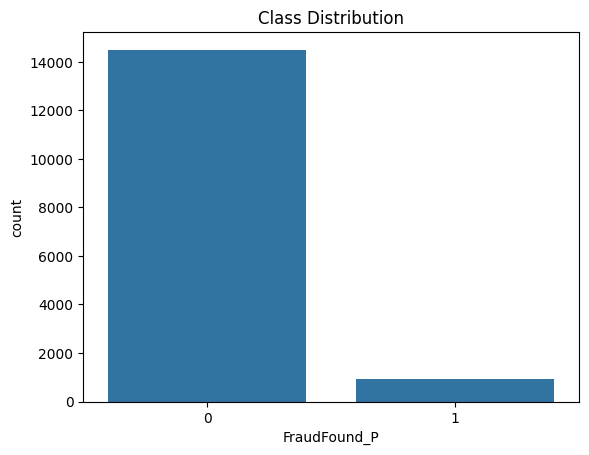

In [ ]:
# Visualize the distribution of the target variable
sns.countplot(x='FraudFound_P', data=df)
plt.title('Class Distribution')
plt.show()

In [ ]:
# Calculate and display the imbalance ratio of the target variable
counts = df['FraudFound_P'].value_counts()
imbalance_ratio = counts.max() / counts.min()
print(f"Imbalance Ratio: {imbalance_ratio:.2f}:1")

Imbalance Ratio: 15.71:1


The target variable is highly imbalanced, with an imbalance ratio of 15.71:1.

Because of this, we will prioritize PR-AUC over ROC-AUC, as PR-AUC focuses on correctly identifying the minority (fraud) class and is less affected by the large number of majority class samples.

## Modelling

### Logistic

### Baseline logistic regression

In [231]:
# Discuss an error that we have with "Age" NaNs and how it was solved -> zeros were replaced with NaNs and added flag for missings in F/E; 
# in modelling zeros will be replaced with median imputation, using simpleimputer

def train_eval_logreg_baseline(X_train, y_train, X_val, y_val):
    pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            penalty="l2",              # Use L2 regularization to prevent overfitting
            solver="liblinear",        # Optimization algorithm suitable for small datasets
            class_weight="balanced",  # Adjust weights to handle class imbalance
            max_iter=1000,             # Maximum number of training iterations
            random_state=42,
        )),
    ])

    pipeline.fit(X_train, y_train)

    # Predict class probabilities on the validation set and extract for the positive class
    val_proba = pipeline.predict_proba(X_val)[:, 1]

    return {
        "roc_auc": roc_auc_score(y_val, val_proba),
        "pr_auc": average_precision_score(y_val, val_proba),
        "model": "logreg_baseline",
    }


### Logistic regression with feature sets

In [232]:
logreg_results = []

for name, fs in tqdm(
    feature_sets.items(),
    desc="Logistic Regression – feature sets",
    total=len(feature_sets),
):
    m = train_eval_logreg_baseline(
        fs["train"], y_train,
        fs["val"],   y_val,
    )

    logreg_results.append({
        "feature_set": name,
        "n_features": fs["train"].shape[1],
        "roc_auc_val": m["roc_auc"],
        "pr_auc_val":  m["pr_auc"],
        "model":       m["model"],
    })

logreg_results_df = (
    pd.DataFrame(logreg_results)
      .sort_values("pr_auc_val", ascending=False) #IMPORTANT sort by PR-AUC
      .reset_index(drop=True)
)

display(logreg_results_df)


Logistic Regression – feature sets:   0%|          | 0/18 [00:00<?, ?it/s]

feature_set  n_features  roc_auc_val  pr_auc_val            model
0       rf_top_5           5     0.675247    0.125270  logreg_baseline
1    perm_top_12          12     0.682417    0.115713  logreg_baseline
2     perm_top_6           6     0.685746    0.113288  logreg_baseline
3      mi_top_57          57     0.653539    0.098962  logreg_baseline
4      rf_top_69          69     0.642640    0.097151  logreg_baseline
5      mi_top_30          30     0.647511    0.097129  logreg_baseline
6      mi_top_50          50     0.652909    0.094822  logreg_baseline
7      mi_top_40          40     0.649989    0.093267  logreg_baseline
8      rf_top_50          50     0.651331    0.092482  logreg_baseline
9   all_features          91     0.665908    0.092009  logreg_baseline
10     rf_top_60          60     0.650831    0.091208  logreg_baseline
11     rf_top_40          40     0.645935    0.091196  logreg_baseline
12     mi_top_20          20     0.632475    0.091176  logreg_baseline
13     rf_top_30          30     0.636077    0.090550  logreg_baseline
14     rf_top_20          20     0.623212    0.088170  logreg_baseline
15     rf_top_10          10     0.622875    0.083074  logreg_baseline
16     mi_top_10          10     0.568863    0.073636  logreg_baseline
17      mi_top_5           5     0.563588    0.064494  logreg_baseline

### Tuning Top 7 Feature Sets based on PR-AUC

In [233]:
# Tune Logistic Regression on ALL feature sets
logreg_fs = list(feature_sets.keys())

# optional: keep deterministic order (nice for reproducibility)
logreg_fs = sorted(logreg_fs)

print("LogReg FS to tune (ALL):", logreg_fs)
print("Count:", len(logreg_fs))  # should be 18

pre = {}

for fs_name in logreg_fs:
    fs = feature_sets[fs_name]

    pre[fs_name] = {
        "Xtr": fs["train"].values,
        "ytr": y_train.values,
        "Xva": fs["val"].values,
        "yva": y_val.values,
        "n_features": fs["train"].shape[1],
    }

for k, v in pre.items():
    print(f"✔ {k}: {v['n_features']} features")


LogReg FS to tune (ALL): ['all_features', 'mi_top_10', 'mi_top_20', 'mi_top_30', 'mi_top_40', 'mi_top_5', 'mi_top_50', 'mi_top_57', 'perm_top_12', 'perm_top_6', 'rf_top_10', 'rf_top_20', 'rf_top_30', 'rf_top_40', 'rf_top_5', 'rf_top_50', 'rf_top_60', 'rf_top_69']
Count: 18
✔ all_features: 91 features
✔ mi_top_10: 10 features
✔ mi_top_20: 20 features
✔ mi_top_30: 30 features
✔ mi_top_40: 40 features
✔ mi_top_5: 5 features
✔ mi_top_50: 50 features
✔ mi_top_57: 57 features
✔ perm_top_12: 12 features
✔ perm_top_6: 6 features
✔ rf_top_10: 10 features
✔ rf_top_20: 20 features
✔ rf_top_30: 30 features
✔ rf_top_40: 40 features
✔ rf_top_5: 5 features
✔ rf_top_50: 50 features
✔ rf_top_60: 60 features
✔ rf_top_69: 69 features


### Optuna PR-AUC Logistic Regression tuner 

In [235]:
def optuna_objective_logreg_pr_auc(trial, Xtr, ytr, Xva, yva):
    C = trial.suggest_float("C", 1e-3, 10.0, log=True)
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"])

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            C=C,                       # regularization strength (higher = weaker regularization)
            penalty=penalty,           # regularization type selected by Optuna
            solver="liblinear",        # solver that supports both L1 and L2 penalties
            class_weight="balanced",   # handle class imbalance automatically
            max_iter=2000,             # increase iterations to ensure convergence
            random_state=42,           
        )),
    ])

    pipe.fit(Xtr, ytr)

    val_proba = pipe.predict_proba(Xva)[:, 1]

    pr_auc = average_precision_score(yva, val_proba) # calculate precision recall

    return pr_auc


In [236]:
logreg_optuna_results = []
logreg_studies = {}

for fs_name, d in pre.items():
    print(f"\n🔍 PR-AUC tuning (LogReg) for: {fs_name}")

    study = optuna.create_study(direction="maximize") # Maximize PR-AUC

    study.optimize(
        lambda trial: optuna_objective_logreg_pr_auc(
            trial,
            d["Xtr"], d["ytr"],
            d["Xva"], d["yva"],
        ),
        n_trials=100,
        show_progress_bar=True,
    )

    logreg_studies[fs_name] = study

    best = study.best_trial
    best_params = best.params # select best params

    pipe = Pipeline([ # instantly create a model with the optuna parameters
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            C=best_params["C"],
            penalty=best_params["penalty"],
            solver="liblinear",
            class_weight="balanced",
            max_iter=2000,
            random_state=42,
        )),
    ])

    pipe.fit(d["Xtr"], d["ytr"])
    val_proba = pipe.predict_proba(d["Xva"])[:, 1] # predict probabilities of the positive class

    roc_auc = roc_auc_score(d["yva"], val_proba)
    pr_auc  = average_precision_score(d["yva"], val_proba)

    logreg_optuna_results.append({
        "feature_set": fs_name,
        "n_features": d["n_features"],
        "pr_auc_val": pr_auc,
        "roc_auc_val": roc_auc,
        "best_params": best_params,
    })

logreg_optuna_results_df = (
    pd.DataFrame(logreg_optuna_results)
      .sort_values("pr_auc_val", ascending=False)
      .reset_index(drop=True)
)

display(logreg_optuna_results_df)


[I 2026-01-15 11:53:39,870] A new study created in memory with name: no-name-81611e67-d037-43c4-bb23-31e8224fd04b



🔍 PR-AUC tuning (LogReg) for: all_features


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-15 11:53:40,146] Trial 0 finished with value: 0.09365755980581796 and parameters: {'C': 0.007125907954533802, 'penalty': 'l2'}. Best is trial 0 with value: 0.09365755980581796.
[I 2026-01-15 11:53:40,531] Trial 1 finished with value: 0.09182706471938447 and parameters: {'C': 0.16408011112762017, 'penalty': 'l2'}. Best is trial 0 with value: 0.09365755980581796.
[I 2026-01-15 11:53:40,681] Trial 2 finished with value: 0.07607634623722921 and parameters: {'C': 0.0011905075060177491, 'penalty': 'l1'}. Best is trial 0 with value: 0.09365755980581796.
[I 2026-01-15 11:53:41,038] Trial 3 finished with value: 0.08943142317306543 and parameters: {'C': 0.08485015952891696, 'penalty': 'l1'}. Best is trial 0 with value: 0.09365755980581796.
[I 2026-01-15 11:53:41,809] Trial 4 finished with value: 0.09081917703388126 and parameters: {'C': 0.1997426195962891, 'penalty': 'l1'}. Best is trial 0 with value: 0.09365755980581796.
[I 2026-01-15 11:53:41,982] Trial 5 finished with value: 0.0830

[I 2026-01-15 11:54:06,283] A new study created in memory with name: no-name-225b6f8e-d5c5-434a-8dfb-eab30ffdd5f5



🔍 PR-AUC tuning (LogReg) for: mi_top_10


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-15 11:54:06,322] Trial 0 finished with value: 0.07360192744082585 and parameters: {'C': 0.25788407443116884, 'penalty': 'l2'}. Best is trial 0 with value: 0.07360192744082585.
[I 2026-01-15 11:54:06,366] Trial 1 finished with value: 0.07356940304245142 and parameters: {'C': 0.20980548356125894, 'penalty': 'l1'}. Best is trial 0 with value: 0.07360192744082585.
[I 2026-01-15 11:54:06,395] Trial 2 finished with value: 0.08170874259156276 and parameters: {'C': 0.010621611221293834, 'penalty': 'l1'}. Best is trial 2 with value: 0.08170874259156276.
[I 2026-01-15 11:54:06,425] Trial 3 finished with value: 0.07362651488457231 and parameters: {'C': 0.2699038208870574, 'penalty': 'l2'}. Best is trial 2 with value: 0.08170874259156276.
[I 2026-01-15 11:54:06,447] Trial 4 finished with value: 0.08171410509692528 and parameters: {'C': 0.016093023249152315, 'penalty': 'l1'}. Best is trial 4 with value: 0.08171410509692528.
[I 2026-01-15 11:54:06,475] Trial 5 finished with value: 0.07356

[I 2026-01-15 11:54:09,542] A new study created in memory with name: no-name-1a2829aa-2a2a-4d6a-8d83-3f2d327d648d


[I 2026-01-15 11:54:09,411] Trial 96 finished with value: 0.07354207041319429 and parameters: {'C': 0.09153560908468265, 'penalty': 'l2'}. Best is trial 58 with value: 0.09423084576869387.
[I 2026-01-15 11:54:09,443] Trial 97 finished with value: 0.07356392885062833 and parameters: {'C': 0.060868028188495134, 'penalty': 'l2'}. Best is trial 58 with value: 0.09423084576869387.
[I 2026-01-15 11:54:09,476] Trial 98 finished with value: 0.09420098450031554 and parameters: {'C': 0.011690421420706809, 'penalty': 'l2'}. Best is trial 58 with value: 0.09423084576869387.
[I 2026-01-15 11:54:09,511] Trial 99 finished with value: 0.07363449316747896 and parameters: {'C': 1.2749152263699213, 'penalty': 'l2'}. Best is trial 58 with value: 0.09423084576869387.

🔍 PR-AUC tuning (LogReg) for: mi_top_20


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-15 11:54:09,668] Trial 0 finished with value: 0.09150507277321476 and parameters: {'C': 0.47066256797444794, 'penalty': 'l1'}. Best is trial 0 with value: 0.09150507277321476.
[I 2026-01-15 11:54:09,750] Trial 1 finished with value: 0.09142486134483319 and parameters: {'C': 0.5988930580677315, 'penalty': 'l1'}. Best is trial 0 with value: 0.09150507277321476.
[I 2026-01-15 11:54:09,790] Trial 2 finished with value: 0.08232492150016367 and parameters: {'C': 0.0038885919137392803, 'penalty': 'l1'}. Best is trial 0 with value: 0.09150507277321476.
[I 2026-01-15 11:54:09,842] Trial 3 finished with value: 0.09221999568073871 and parameters: {'C': 0.03881263107805921, 'penalty': 'l2'}. Best is trial 3 with value: 0.09221999568073871.
[I 2026-01-15 11:54:09,884] Trial 4 finished with value: 0.0901226493704987 and parameters: {'C': 0.001742828611063812, 'penalty': 'l2'}. Best is trial 3 with value: 0.09221999568073871.
[I 2026-01-15 11:54:09,940] Trial 5 finished with value: 0.09132

[I 2026-01-15 11:54:15,162] A new study created in memory with name: no-name-971b84ad-90d9-4057-bd6d-dd64260ab809


[I 2026-01-15 11:54:15,110] Trial 99 finished with value: 0.08973472767475353 and parameters: {'C': 0.006381963930518359, 'penalty': 'l2'}. Best is trial 96 with value: 0.09285686751708656.

🔍 PR-AUC tuning (LogReg) for: mi_top_30


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-15 11:54:15,272] Trial 0 finished with value: 0.0954567163509498 and parameters: {'C': 0.03963992313661027, 'penalty': 'l1'}. Best is trial 0 with value: 0.0954567163509498.
[I 2026-01-15 11:54:15,374] Trial 1 finished with value: 0.09713851734888823 and parameters: {'C': 0.6911810935959338, 'penalty': 'l2'}. Best is trial 1 with value: 0.09713851734888823.
[I 2026-01-15 11:54:15,497] Trial 2 finished with value: 0.09711351119211802 and parameters: {'C': 6.717568842740002, 'penalty': 'l1'}. Best is trial 1 with value: 0.09713851734888823.
[I 2026-01-15 11:54:15,622] Trial 3 finished with value: 0.09676032840315368 and parameters: {'C': 0.20039882914932733, 'penalty': 'l1'}. Best is trial 1 with value: 0.09713851734888823.
[I 2026-01-15 11:54:15,736] Trial 4 finished with value: 0.09688152237822571 and parameters: {'C': 0.3254553176691348, 'penalty': 'l1'}. Best is trial 1 with value: 0.09713851734888823.
[I 2026-01-15 11:54:15,811] Trial 5 finished with value: 0.094690215622

[I 2026-01-15 11:54:25,162] A new study created in memory with name: no-name-77bf6a36-9fd7-4f1e-98fd-4a81ec1297f4


[I 2026-01-15 11:54:25,061] Trial 99 finished with value: 0.09712557378805722 and parameters: {'C': 1.1004208440928729, 'penalty': 'l2'}. Best is trial 82 with value: 0.09715207333778256.

🔍 PR-AUC tuning (LogReg) for: mi_top_40


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-15 11:54:25,267] Trial 0 finished with value: 0.08232492150016367 and parameters: {'C': 0.0035181574635589213, 'penalty': 'l1'}. Best is trial 0 with value: 0.08232492150016367.
[I 2026-01-15 11:54:25,427] Trial 1 finished with value: 0.09780203021608855 and parameters: {'C': 0.18463456934666875, 'penalty': 'l1'}. Best is trial 1 with value: 0.09780203021608855.
[I 2026-01-15 11:54:25,557] Trial 2 finished with value: 0.09320527921559288 and parameters: {'C': 1.515021667426407, 'penalty': 'l2'}. Best is trial 1 with value: 0.09780203021608855.
[I 2026-01-15 11:54:25,627] Trial 3 finished with value: 0.08232492150016367 and parameters: {'C': 0.003019357823275838, 'penalty': 'l1'}. Best is trial 1 with value: 0.09780203021608855.
[I 2026-01-15 11:54:25,771] Trial 4 finished with value: 0.09314428309230649 and parameters: {'C': 7.530285258372815, 'penalty': 'l2'}. Best is trial 1 with value: 0.09780203021608855.
[I 2026-01-15 11:54:25,868] Trial 5 finished with value: 0.0988958

[I 2026-01-15 11:54:34,965] A new study created in memory with name: no-name-c358bdbc-f87c-4c8e-baef-d1f214838155


[I 2026-01-15 11:54:34,880] Trial 99 finished with value: 0.08232492150016367 and parameters: {'C': 0.0023898236800435463, 'penalty': 'l1'}. Best is trial 26 with value: 0.10150200374458843.

🔍 PR-AUC tuning (LogReg) for: mi_top_5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-15 11:54:34,992] Trial 0 finished with value: 0.06449408746902988 and parameters: {'C': 4.144695039030572, 'penalty': 'l2'}. Best is trial 0 with value: 0.06449408746902988.
[I 2026-01-15 11:54:35,009] Trial 1 finished with value: 0.06449408746902988 and parameters: {'C': 0.9352389336300079, 'penalty': 'l2'}. Best is trial 0 with value: 0.06449408746902988.
[I 2026-01-15 11:54:35,029] Trial 2 finished with value: 0.07509805653055723 and parameters: {'C': 0.2337150242356567, 'penalty': 'l1'}. Best is trial 2 with value: 0.07509805653055723.
[I 2026-01-15 11:54:35,050] Trial 3 finished with value: 0.06449408746902988 and parameters: {'C': 0.25528475934497735, 'penalty': 'l2'}. Best is trial 2 with value: 0.07509805653055723.
[I 2026-01-15 11:54:35,079] Trial 4 finished with value: 0.07607634623722921 and parameters: {'C': 0.007314541926397088, 'penalty': 'l1'}. Best is trial 4 with value: 0.07607634623722921.
[I 2026-01-15 11:54:35,110] Trial 5 finished with value: 0.064494087

[I 2026-01-15 11:54:37,303] A new study created in memory with name: no-name-85b3921a-7125-4433-920d-1163a6cfbb48


[I 2026-01-15 11:54:37,217] Trial 96 finished with value: 0.09482307416394165 and parameters: {'C': 0.006292415831845765, 'penalty': 'l2'}. Best is trial 52 with value: 0.09487086220606895.
[I 2026-01-15 11:54:37,238] Trial 97 finished with value: 0.0948563177065262 and parameters: {'C': 0.001262275134022664, 'penalty': 'l2'}. Best is trial 52 with value: 0.09487086220606895.
[I 2026-01-15 11:54:37,260] Trial 98 finished with value: 0.09477487581321495 and parameters: {'C': 0.00176380924111258, 'penalty': 'l2'}. Best is trial 52 with value: 0.09487086220606895.
[I 2026-01-15 11:54:37,281] Trial 99 finished with value: 0.09485510277730706 and parameters: {'C': 0.001525403915191687, 'penalty': 'l2'}. Best is trial 52 with value: 0.09487086220606895.

🔍 PR-AUC tuning (LogReg) for: mi_top_50


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-15 11:54:37,431] Trial 0 finished with value: 0.08232492150016367 and parameters: {'C': 0.004181698176469423, 'penalty': 'l1'}. Best is trial 0 with value: 0.08232492150016367.
[I 2026-01-15 11:54:37,664] Trial 1 finished with value: 0.09472916058429291 and parameters: {'C': 9.659206957429666, 'penalty': 'l1'}. Best is trial 1 with value: 0.09472916058429291.
[I 2026-01-15 11:54:37,805] Trial 2 finished with value: 0.09512455495559016 and parameters: {'C': 0.30049631112071057, 'penalty': 'l2'}. Best is trial 2 with value: 0.09512455495559016.
[I 2026-01-15 11:54:37,919] Trial 3 finished with value: 0.1009449354263674 and parameters: {'C': 0.0034380121276038054, 'penalty': 'l2'}. Best is trial 3 with value: 0.1009449354263674.
[I 2026-01-15 11:54:38,121] Trial 4 finished with value: 0.09471553379812278 and parameters: {'C': 6.174281339098318, 'penalty': 'l2'}. Best is trial 3 with value: 0.1009449354263674.
[I 2026-01-15 11:54:38,229] Trial 5 finished with value: 0.1006090369

[I 2026-01-15 11:54:50,245] A new study created in memory with name: no-name-fd7a9a8c-4a4b-41aa-85d2-9ee9b4680736


[I 2026-01-15 11:54:50,082] Trial 99 finished with value: 0.10096349468847791 and parameters: {'C': 0.003350015922350144, 'penalty': 'l2'}. Best is trial 92 with value: 0.10111767059140207.

🔍 PR-AUC tuning (LogReg) for: mi_top_57


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-15 11:54:50,436] Trial 0 finished with value: 0.1007323068372265 and parameters: {'C': 0.06343495006785288, 'penalty': 'l2'}. Best is trial 0 with value: 0.1007323068372265.
[I 2026-01-15 11:54:50,672] Trial 1 finished with value: 0.09889957211346173 and parameters: {'C': 1.70487233345101, 'penalty': 'l2'}. Best is trial 0 with value: 0.1007323068372265.
[I 2026-01-15 11:54:50,830] Trial 2 finished with value: 0.09584732888359107 and parameters: {'C': 0.026905080890704768, 'penalty': 'l1'}. Best is trial 0 with value: 0.1007323068372265.
[I 2026-01-15 11:54:50,994] Trial 3 finished with value: 0.10245873326115848 and parameters: {'C': 0.012239269482519381, 'penalty': 'l2'}. Best is trial 3 with value: 0.10245873326115848.
[I 2026-01-15 11:54:51,142] Trial 4 finished with value: 0.10286998792484338 and parameters: {'C': 0.002101187643885107, 'penalty': 'l2'}. Best is trial 4 with value: 0.10286998792484338.
[I 2026-01-15 11:54:51,258] Trial 5 finished with value: 0.0760763462

[I 2026-01-15 11:55:06,975] A new study created in memory with name: no-name-e5ad13e6-9ba7-4297-b80a-028fcdc37e07



🔍 PR-AUC tuning (LogReg) for: perm_top_12


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-15 11:55:07,009] Trial 0 finished with value: 0.11584067805306213 and parameters: {'C': 0.001689221330811003, 'penalty': 'l2'}. Best is trial 0 with value: 0.11584067805306213.
[I 2026-01-15 11:55:07,041] Trial 1 finished with value: 0.07607634623722921 and parameters: {'C': 0.0010170171639796997, 'penalty': 'l1'}. Best is trial 0 with value: 0.11584067805306213.
[I 2026-01-15 11:55:07,068] Trial 2 finished with value: 0.11571115619519518 and parameters: {'C': 0.022754820683584105, 'penalty': 'l2'}. Best is trial 0 with value: 0.11584067805306213.
[I 2026-01-15 11:55:07,094] Trial 3 finished with value: 0.1157577887387324 and parameters: {'C': 0.03094319514202081, 'penalty': 'l2'}. Best is trial 0 with value: 0.11584067805306213.
[I 2026-01-15 11:55:07,124] Trial 4 finished with value: 0.1159693252900216 and parameters: {'C': 0.0029418933784431133, 'penalty': 'l2'}. Best is trial 4 with value: 0.1159693252900216.
[I 2026-01-15 11:55:07,153] Trial 5 finished with value: 0.115

[I 2026-01-15 11:55:09,995] A new study created in memory with name: no-name-c4caccee-25d9-4e29-95f3-f8d134e94be4


[I 2026-01-15 11:55:09,896] Trial 96 finished with value: 0.11571544204725008 and parameters: {'C': 0.015452256796681394, 'penalty': 'l2'}. Best is trial 43 with value: 0.1160095774330997.
[I 2026-01-15 11:55:09,921] Trial 97 finished with value: 0.11575590363808097 and parameters: {'C': 0.004172466362313258, 'penalty': 'l2'}. Best is trial 43 with value: 0.1160095774330997.
[I 2026-01-15 11:55:09,946] Trial 98 finished with value: 0.11569715866051514 and parameters: {'C': 0.006990893656093091, 'penalty': 'l2'}. Best is trial 43 with value: 0.1160095774330997.
[I 2026-01-15 11:55:09,970] Trial 99 finished with value: 0.11600839276538225 and parameters: {'C': 0.001357028755360885, 'penalty': 'l2'}. Best is trial 43 with value: 0.1160095774330997.

🔍 PR-AUC tuning (LogReg) for: perm_top_6


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-15 11:55:10,021] Trial 0 finished with value: 0.07607634623722921 and parameters: {'C': 0.0013377706588006074, 'penalty': 'l1'}. Best is trial 0 with value: 0.07607634623722921.
[I 2026-01-15 11:55:10,037] Trial 1 finished with value: 0.11328804342277765 and parameters: {'C': 0.518356991758342, 'penalty': 'l2'}. Best is trial 1 with value: 0.11328804342277765.
[I 2026-01-15 11:55:10,058] Trial 2 finished with value: 0.11308927915532643 and parameters: {'C': 0.0773505777798847, 'penalty': 'l2'}. Best is trial 1 with value: 0.11328804342277765.
[I 2026-01-15 11:55:10,078] Trial 3 finished with value: 0.11328804342277767 and parameters: {'C': 0.582827966251208, 'penalty': 'l2'}. Best is trial 3 with value: 0.11328804342277767.
[I 2026-01-15 11:55:10,100] Trial 4 finished with value: 0.1130644900806485 and parameters: {'C': 0.01200183250533977, 'penalty': 'l2'}. Best is trial 3 with value: 0.11328804342277767.
[I 2026-01-15 11:55:10,117] Trial 5 finished with value: 0.0760763462

[I 2026-01-15 11:55:12,330] A new study created in memory with name: no-name-a719c260-5161-4be7-aefa-9e58cce02800


[I 2026-01-15 11:55:12,285] Trial 98 finished with value: 0.1149739381662404 and parameters: {'C': 0.015165365350163417, 'penalty': 'l1'}. Best is trial 42 with value: 0.11499665861436476.
[I 2026-01-15 11:55:12,307] Trial 99 finished with value: 0.11361710838595963 and parameters: {'C': 0.06493804826632263, 'penalty': 'l1'}. Best is trial 42 with value: 0.11499665861436476.

🔍 PR-AUC tuning (LogReg) for: rf_top_10


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-15 11:55:12,365] Trial 0 finished with value: 0.08320089716763455 and parameters: {'C': 0.7643920558405805, 'penalty': 'l2'}. Best is trial 0 with value: 0.08320089716763455.
[I 2026-01-15 11:55:12,393] Trial 1 finished with value: 0.08276661066588943 and parameters: {'C': 2.293425555328902, 'penalty': 'l2'}. Best is trial 0 with value: 0.08320089716763455.
[I 2026-01-15 11:55:12,415] Trial 2 finished with value: 0.07618114403584447 and parameters: {'C': 0.006125059355909025, 'penalty': 'l1'}. Best is trial 0 with value: 0.08320089716763455.
[I 2026-01-15 11:55:12,448] Trial 3 finished with value: 0.08530647098131847 and parameters: {'C': 0.1465078813431037, 'penalty': 'l2'}. Best is trial 3 with value: 0.08530647098131847.
[I 2026-01-15 11:55:12,493] Trial 4 finished with value: 0.08290085493421943 and parameters: {'C': 2.386093282083812, 'penalty': 'l1'}. Best is trial 3 with value: 0.08530647098131847.
[I 2026-01-15 11:55:12,519] Trial 5 finished with value: 0.08636149118

[I 2026-01-15 11:55:16,088] A new study created in memory with name: no-name-a9867d40-b82c-4341-ab1c-28d6b29b3bf8



🔍 PR-AUC tuning (LogReg) for: rf_top_20


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-15 11:55:16,147] Trial 0 finished with value: 0.08258591732216002 and parameters: {'C': 0.00605414624298776, 'penalty': 'l1'}. Best is trial 0 with value: 0.08258591732216002.
[I 2026-01-15 11:55:16,209] Trial 1 finished with value: 0.08892170632675697 and parameters: {'C': 0.15949399196737082, 'penalty': 'l2'}. Best is trial 1 with value: 0.08892170632675697.
[I 2026-01-15 11:55:16,303] Trial 2 finished with value: 0.08825482607178052 and parameters: {'C': 0.9959543101738701, 'penalty': 'l1'}. Best is trial 1 with value: 0.08892170632675697.
[I 2026-01-15 11:55:16,356] Trial 3 finished with value: 0.09577989706226811 and parameters: {'C': 0.0021455601329401887, 'penalty': 'l2'}. Best is trial 3 with value: 0.09577989706226811.
[I 2026-01-15 11:55:16,480] Trial 4 finished with value: 0.08791834424215088 and parameters: {'C': 2.6704894309449236, 'penalty': 'l1'}. Best is trial 3 with value: 0.09577989706226811.
[I 2026-01-15 11:55:16,555] Trial 5 finished with value: 0.087922

[I 2026-01-15 11:55:21,822] A new study created in memory with name: no-name-fd4ec207-9bd0-4e3d-90a9-13c0090c0694


[I 2026-01-15 11:55:21,669] Trial 97 finished with value: 0.09657771352640122 and parameters: {'C': 0.0013044902825540263, 'penalty': 'l2'}. Best is trial 82 with value: 0.09659516810073582.
[I 2026-01-15 11:55:21,711] Trial 98 finished with value: 0.095977123060115 and parameters: {'C': 0.0016922253595136748, 'penalty': 'l2'}. Best is trial 82 with value: 0.09659516810073582.
[I 2026-01-15 11:55:21,772] Trial 99 finished with value: 0.09501341171232063 and parameters: {'C': 0.0033828047444255647, 'penalty': 'l2'}. Best is trial 82 with value: 0.09659516810073582.

🔍 PR-AUC tuning (LogReg) for: rf_top_30


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-15 11:55:21,962] Trial 0 finished with value: 0.09071863431462665 and parameters: {'C': 0.5259128591294393, 'penalty': 'l2'}. Best is trial 0 with value: 0.09071863431462665.
[I 2026-01-15 11:55:22,073] Trial 1 finished with value: 0.09173102929580565 and parameters: {'C': 0.20675391461377166, 'penalty': 'l1'}. Best is trial 1 with value: 0.09173102929580565.
[I 2026-01-15 11:55:22,177] Trial 2 finished with value: 0.09554431363990654 and parameters: {'C': 0.03514554103781988, 'penalty': 'l1'}. Best is trial 2 with value: 0.09554431363990654.
[I 2026-01-15 11:55:22,264] Trial 3 finished with value: 0.08753592955754493 and parameters: {'C': 0.009922257510809726, 'penalty': 'l1'}. Best is trial 2 with value: 0.09554431363990654.
[I 2026-01-15 11:55:22,365] Trial 4 finished with value: 0.09122528196728091 and parameters: {'C': 0.3305513264412166, 'penalty': 'l1'}. Best is trial 2 with value: 0.09554431363990654.
[I 2026-01-15 11:55:22,486] Trial 5 finished with value: 0.0955091

[I 2026-01-15 11:55:30,465] A new study created in memory with name: no-name-112d273b-0059-4d3f-9677-5f983b4f65fc


[I 2026-01-15 11:55:30,284] Trial 98 finished with value: 0.0962141243998567 and parameters: {'C': 0.0016635745158423854, 'penalty': 'l2'}. Best is trial 53 with value: 0.09857743391929055.
[I 2026-01-15 11:55:30,368] Trial 99 finished with value: 0.09805013969727668 and parameters: {'C': 0.0037535848970676254, 'penalty': 'l2'}. Best is trial 53 with value: 0.09857743391929055.

🔍 PR-AUC tuning (LogReg) for: rf_top_40


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-15 11:55:30,591] Trial 0 finished with value: 0.09175194346818757 and parameters: {'C': 0.01586538611040296, 'penalty': 'l1'}. Best is trial 0 with value: 0.09175194346818757.
[I 2026-01-15 11:55:30,755] Trial 1 finished with value: 0.09635552111395594 and parameters: {'C': 0.04170533109466301, 'penalty': 'l1'}. Best is trial 1 with value: 0.09635552111395594.
[I 2026-01-15 11:55:30,884] Trial 2 finished with value: 0.09835233654895305 and parameters: {'C': 0.014602726192269015, 'penalty': 'l2'}. Best is trial 2 with value: 0.09835233654895305.
[I 2026-01-15 11:55:31,007] Trial 3 finished with value: 0.09860234129586831 and parameters: {'C': 0.01027574998309505, 'penalty': 'l2'}. Best is trial 3 with value: 0.09860234129586831.
[I 2026-01-15 11:55:31,149] Trial 4 finished with value: 0.09107125139030962 and parameters: {'C': 5.087866588532337, 'penalty': 'l2'}. Best is trial 3 with value: 0.09860234129586831.
[I 2026-01-15 11:55:31,293] Trial 5 finished with value: 0.0910640

[I 2026-01-15 11:55:41,183] A new study created in memory with name: no-name-d58e5f11-893e-43b6-804b-fbe1035cf1e5


[I 2026-01-15 11:55:41,085] Trial 99 finished with value: 0.09130784621523194 and parameters: {'C': 0.5640310817246813, 'penalty': 'l2'}. Best is trial 91 with value: 0.10054095499515518.

🔍 PR-AUC tuning (LogReg) for: rf_top_5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-15 11:55:41,219] Trial 0 finished with value: 0.0924099309245767 and parameters: {'C': 0.3447477728942739, 'penalty': 'l1'}. Best is trial 0 with value: 0.0924099309245767.
[I 2026-01-15 11:55:41,239] Trial 1 finished with value: 0.07607634623722921 and parameters: {'C': 0.0011398870408567527, 'penalty': 'l1'}. Best is trial 0 with value: 0.0924099309245767.
[I 2026-01-15 11:55:41,261] Trial 2 finished with value: 0.0924099309245767 and parameters: {'C': 0.011641104529310609, 'penalty': 'l1'}. Best is trial 0 with value: 0.0924099309245767.
[I 2026-01-15 11:55:41,280] Trial 3 finished with value: 0.07607634623722921 and parameters: {'C': 0.0028779488069735405, 'penalty': 'l1'}. Best is trial 0 with value: 0.0924099309245767.
[I 2026-01-15 11:55:41,300] Trial 4 finished with value: 0.12527006113254607 and parameters: {'C': 8.010669422795727, 'penalty': 'l2'}. Best is trial 4 with value: 0.12527006113254607.
[I 2026-01-15 11:55:41,327] Trial 5 finished with value: 0.0924099309

[I 2026-01-15 11:55:43,688] A new study created in memory with name: no-name-ac1df513-be03-45f6-8044-95eeb7aae15e


[I 2026-01-15 11:55:43,643] Trial 98 finished with value: 0.12527006113254607 and parameters: {'C': 9.937495581533687, 'penalty': 'l2'}. Best is trial 39 with value: 0.12527983085772162.
[I 2026-01-15 11:55:43,667] Trial 99 finished with value: 0.12527006113254607 and parameters: {'C': 6.1860453082380396, 'penalty': 'l2'}. Best is trial 39 with value: 0.12527983085772162.

🔍 PR-AUC tuning (LogReg) for: rf_top_50


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-15 11:55:43,827] Trial 0 finished with value: 0.08307920057244998 and parameters: {'C': 0.00676064567980254, 'penalty': 'l1'}. Best is trial 0 with value: 0.08307920057244998.
[I 2026-01-15 11:55:43,994] Trial 1 finished with value: 0.09408127706048207 and parameters: {'C': 0.022334749570097588, 'penalty': 'l1'}. Best is trial 1 with value: 0.09408127706048207.
[I 2026-01-15 11:55:44,177] Trial 2 finished with value: 0.09498978769929414 and parameters: {'C': 0.14304428380899356, 'penalty': 'l1'}. Best is trial 2 with value: 0.09498978769929414.
[I 2026-01-15 11:55:44,491] Trial 3 finished with value: 0.0924963520981637 and parameters: {'C': 1.5742115607041498, 'penalty': 'l1'}. Best is trial 2 with value: 0.09498978769929414.
[I 2026-01-15 11:55:44,655] Trial 4 finished with value: 0.09248501204284626 and parameters: {'C': 1.0142657149736571, 'penalty': 'l2'}. Best is trial 2 with value: 0.09498978769929414.
[I 2026-01-15 11:55:44,814] Trial 5 finished with value: 0.09232571

[I 2026-01-15 11:55:57,527] A new study created in memory with name: no-name-82109785-e838-426f-bd3b-685eeb066fbe



🔍 PR-AUC tuning (LogReg) for: rf_top_60


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-15 11:55:57,655] Trial 0 finished with value: 0.08945366436644656 and parameters: {'C': 0.010739154226324349, 'penalty': 'l1'}. Best is trial 0 with value: 0.08945366436644656.
[I 2026-01-15 11:55:57,861] Trial 1 finished with value: 0.09496138173532456 and parameters: {'C': 0.08759025007465564, 'penalty': 'l2'}. Best is trial 1 with value: 0.09496138173532456.
[I 2026-01-15 11:55:58,078] Trial 2 finished with value: 0.0973521098754194 and parameters: {'C': 0.06828581057843348, 'penalty': 'l1'}. Best is trial 2 with value: 0.0973521098754194.
[I 2026-01-15 11:55:58,208] Trial 3 finished with value: 0.09876109046372546 and parameters: {'C': 0.0014329481312464179, 'penalty': 'l2'}. Best is trial 3 with value: 0.09876109046372546.
[I 2026-01-15 11:55:58,363] Trial 4 finished with value: 0.101061573289482 and parameters: {'C': 0.005462498921039611, 'penalty': 'l2'}. Best is trial 4 with value: 0.101061573289482.
[I 2026-01-15 11:55:58,601] Trial 5 finished with value: 0.09235816

[I 2026-01-15 11:56:14,250] A new study created in memory with name: no-name-1d23b26f-188d-4371-886b-6be760f29716


[I 2026-01-15 11:56:14,115] Trial 99 finished with value: 0.07607634623722921 and parameters: {'C': 0.0015791244515058836, 'penalty': 'l1'}. Best is trial 41 with value: 0.10177442006075443.

🔍 PR-AUC tuning (LogReg) for: rf_top_69


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2026-01-15 11:56:14,500] Trial 0 finished with value: 0.09690435630552063 and parameters: {'C': 4.594440930642665, 'penalty': 'l2'}. Best is trial 0 with value: 0.09690435630552063.
[I 2026-01-15 11:56:14,776] Trial 1 finished with value: 0.097838544422232 and parameters: {'C': 0.16315818913526453, 'penalty': 'l2'}. Best is trial 1 with value: 0.097838544422232.
[I 2026-01-15 11:56:14,893] Trial 2 finished with value: 0.07607634623722921 and parameters: {'C': 0.0013542094635287801, 'penalty': 'l1'}. Best is trial 1 with value: 0.097838544422232.
[I 2026-01-15 11:56:15,117] Trial 3 finished with value: 0.09762956306117022 and parameters: {'C': 0.045037343835987585, 'penalty': 'l2'}. Best is trial 1 with value: 0.097838544422232.
[I 2026-01-15 11:56:15,608] Trial 4 finished with value: 0.09704306082533083 and parameters: {'C': 3.810330800875625, 'penalty': 'l1'}. Best is trial 1 with value: 0.097838544422232.
[I 2026-01-15 11:56:15,726] Trial 5 finished with value: 0.07607634623722921

feature_set  n_features  pr_auc_val  roc_auc_val  \
0       rf_top_5           5    0.125280     0.675259   
1    perm_top_12          12    0.116010     0.682740   
2     perm_top_6           6    0.114997     0.685075   
3      mi_top_57          57    0.104302     0.665630   
4      rf_top_60          60    0.101774     0.669783   
5      rf_top_50          50    0.101563     0.669106   
6      mi_top_40          40    0.101502     0.668676   
7      mi_top_50          50    0.101118     0.666561   
8      rf_top_69          69    0.100880     0.660624   
9      rf_top_40          40    0.100541     0.664705   
10  all_features          91    0.099678     0.664763   
11     rf_top_10          10    0.098801     0.658990   
12     rf_top_30          30    0.098577     0.659095   
13     mi_top_30          30    0.097152     0.647493   
14     rf_top_20          20    0.096595     0.650892   
15      mi_top_5           5    0.094871     0.646434   
16     mi_top_10          10    0.094231     0.656181   
17     mi_top_20          20    0.092857     0.634744   

                                      best_params  
0       {'C': 6.730874386454842, 'penalty': 'l2'}  
1   {'C': 0.0010611098806581677, 'penalty': 'l2'}  
2    {'C': 0.014691039418401896, 'penalty': 'l1'}  
3    {'C': 0.002603003557706024, 'penalty': 'l2'}  
4    {'C': 0.002573887196882617, 'penalty': 'l2'}  
5   {'C': 0.0031674291983501825, 'penalty': 'l2'}  
6   {'C': 0.0017850534383582978, 'penalty': 'l2'}  
7    {'C': 0.002386532400111117, 'penalty': 'l2'}  
8   {'C': 0.0028454639318645407, 'penalty': 'l2'}  
9    {'C': 0.002630471116435534, 'penalty': 'l2'}  
10   {'C': 0.001000682535243989, 'penalty': 'l2'}  
11   {'C': 0.001008605357188211, 'penalty': 'l2'}  
12   {'C': 0.002540783625150159, 'penalty': 'l2'}  
13     {'C': 0.5789843727523132, 'penalty': 'l2'}  
14   {'C': 0.001283548298400772, 'penalty': 'l2'}  
15  {'C': 0.0010478368939377764, 'penalty': 'l2'}  
16   {'C': 0.011326620701590885, 'penalty': 'l2'}  
17   {'C': 0.009305304433898943, 'penalty': 'l2'}

### Comparison For Logistic Regression: Baseline vs Optuna

In [237]:
# Create a copy of baseline Logistic Regression results
initial_logreg = logreg_results_df.copy()

# Mark these runs as baseline configurations
initial_logreg["config_type"] = "Initial (LogReg Baseline)"

# Store baseline hyperparameters in a consistent dict format
initial_logreg["params"] = [{
    "penalty": "l2",
    "solver": "liblinear",
    "class_weight": "balanced",
}] * len(initial_logreg)


# Create a copy of Optuna-tuned Logistic Regression results
tuned_logreg = logreg_optuna_results_df.copy()

# Mark these runs as Optuna-tuned configurations
tuned_logreg["config_type"] = "Optuna Tuned (PR-AUC)"

# Rename column to keep the same schema as baseline results
tuned_logreg.rename(columns={"best_params": "params"}, inplace=True)


# Combine baseline and tuned results into one table
final_logreg_comparison = (
    pd.concat([tuned_logreg, initial_logreg], ignore_index=True)
      .sort_values(
          by=["pr_auc_val", "config_type"],
          ascending=[False, True]
      )
      .reset_index(drop=True)
)

print("Final Logistic Regression Leaderboard (ranked by PR-AUC)")
display(final_logreg_comparison[
    ["feature_set", "config_type", "pr_auc_val", "roc_auc_val", "params"]
])

Final Logistic Regression Leaderboard (ranked by PR-AUC)


feature_set                config_type  pr_auc_val  roc_auc_val  \
0       rf_top_5      Optuna Tuned (PR-AUC)    0.125280     0.675259   
1       rf_top_5  Initial (LogReg Baseline)    0.125270     0.675247   
2    perm_top_12      Optuna Tuned (PR-AUC)    0.116010     0.682740   
3    perm_top_12  Initial (LogReg Baseline)    0.115713     0.682417   
4     perm_top_6      Optuna Tuned (PR-AUC)    0.114997     0.685075   
5     perm_top_6  Initial (LogReg Baseline)    0.113288     0.685746   
6      mi_top_57      Optuna Tuned (PR-AUC)    0.104302     0.665630   
7      rf_top_60      Optuna Tuned (PR-AUC)    0.101774     0.669783   
8      rf_top_50      Optuna Tuned (PR-AUC)    0.101563     0.669106   
9      mi_top_40      Optuna Tuned (PR-AUC)    0.101502     0.668676   
10     mi_top_50      Optuna Tuned (PR-AUC)    0.101118     0.666561   
11     rf_top_69      Optuna Tuned (PR-AUC)    0.100880     0.660624   
12     rf_top_40      Optuna Tuned (PR-AUC)    0.100541     0.664705   
13  all_features      Optuna Tuned (PR-AUC)    0.099678     0.664763   
14     mi_top_57  Initial (LogReg Baseline)    0.098962     0.653539   
15     rf_top_10      Optuna Tuned (PR-AUC)    0.098801     0.658990   
16     rf_top_30      Optuna Tuned (PR-AUC)    0.098577     0.659095   
17     mi_top_30      Optuna Tuned (PR-AUC)    0.097152     0.647493   
18     rf_top_69  Initial (LogReg Baseline)    0.097151     0.642640   
19     mi_top_30  Initial (LogReg Baseline)    0.097129     0.647511   
20     rf_top_20      Optuna Tuned (PR-AUC)    0.096595     0.650892   
21      mi_top_5      Optuna Tuned (PR-AUC)    0.094871     0.646434   
22     mi_top_50  Initial (LogReg Baseline)    0.094822     0.652909   
23     mi_top_10      Optuna Tuned (PR-AUC)    0.094231     0.656181   
24     mi_top_40  Initial (LogReg Baseline)    0.093267     0.649989   
25     mi_top_20      Optuna Tuned (PR-AUC)    0.092857     0.634744   
26     rf_top_50  Initial (LogReg Baseline)    0.092482     0.651331   
27  all_features  Initial (LogReg Baseline)    0.092009     0.665908   
28     rf_top_60  Initial (LogReg Baseline)    0.091208     0.650831   
29     rf_top_40  Initial (LogReg Baseline)    0.091196     0.645935   
30     mi_top_20  Initial (LogReg Baseline)    0.091176     0.632475   
31     rf_top_30  Initial (LogReg Baseline)    0.090550     0.636077   
32     rf_top_20  Initial (LogReg Baseline)    0.088170     0.623212   
33     rf_top_10  Initial (LogReg Baseline)    0.083074     0.622875   
34     mi_top_10  Initial (LogReg Baseline)    0.073636     0.568863   
35      mi_top_5  Initial (LogReg Baseline)    0.064494     0.563588   

                                                                  params  
0                              {'C': 6.730874386454842, 'penalty': 'l2'}  
1   {'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced'}  
2                          {'C': 0.0010611098806581677, 'penalty': 'l2'}  
3   {'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced'}  
4                           {'C': 0.014691039418401896, 'penalty': 'l1'}  
5   {'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced'}  
6                           {'C': 0.002603003557706024, 'penalty': 'l2'}  
7                           {'C': 0.002573887196882617, 'penalty': 'l2'}  
8                          {'C': 0.0031674291983501825, 'penalty': 'l2'}  
9                          {'C': 0.0017850534383582978, 'penalty': 'l2'}  
10                          {'C': 0.002386532400111117, 'penalty': 'l2'}  
11                         {'C': 0.0028454639318645407, 'penalty': 'l2'}  
12                          {'C': 0.002630471116435534, 'penalty': 'l2'}  
13                          {'C': 0.001000682535243989, 'penalty': 'l2'}  
14  {'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced'}  
15                          {'C': 0.001008605357188211, 'penalty': 'l2'}  
16                          {'C': 0.002540783625150159, 'penalty'

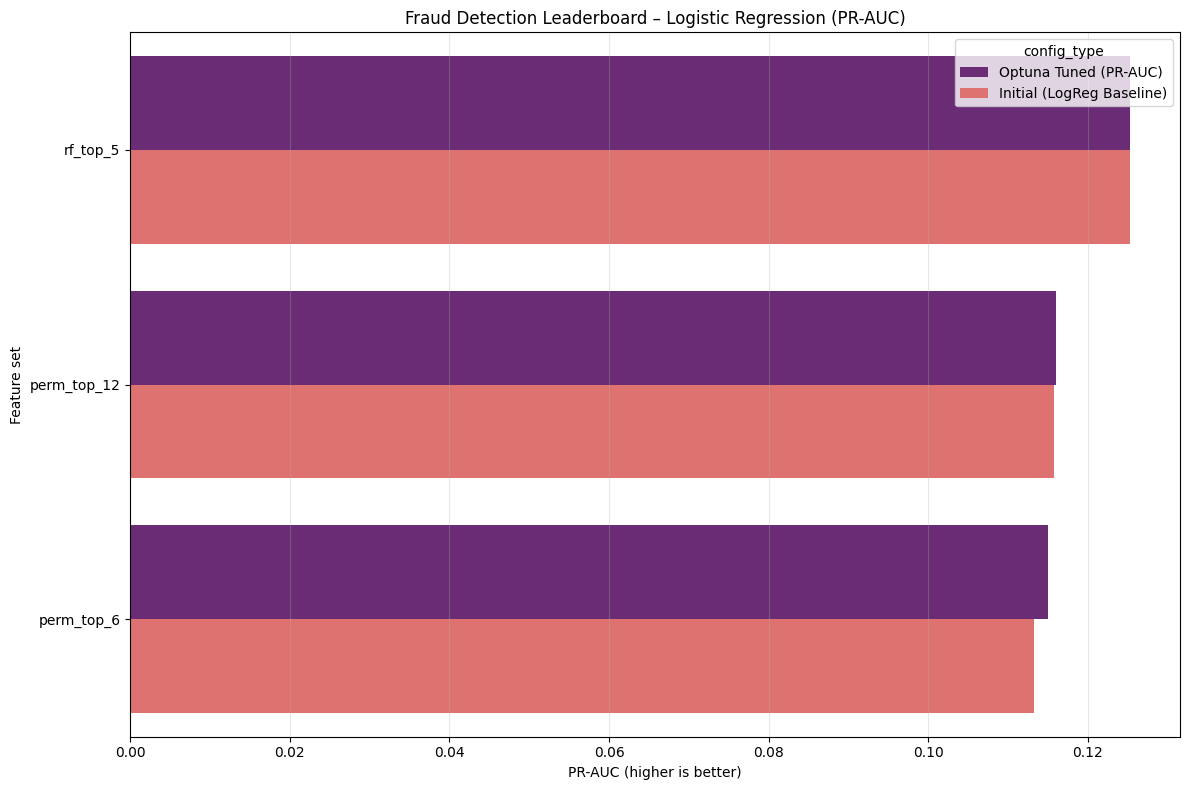

In [240]:
# Select top 3 models based on PR-AUC for visualization
top10 = (
    final_logreg_comparison
    .sort_values("pr_auc_val", ascending=False)
    .head(6)
)

plt.figure(figsize=(12, 8))

# Plot PR-AUC comparison for the top models
sns.barplot(
    data=top10,
    x="pr_auc_val",
    y="feature_set",
    hue="config_type",
    palette="magma",
)

plt.title("Fraud Detection Leaderboard – Logistic Regression (PR-AUC)")
plt.xlabel("PR-AUC (higher is better)")
plt.ylabel("Feature set")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


### PR-AUC for Logistic Regression(with Configuration) Best Performance

In [242]:
fc = final_logreg_comparison.copy()

# Parse params column safely into dict
def _parse_params(p):
    if isinstance(p, dict):
        return dict(p)
    if isinstance(p, str):
        try:
            return ast.literal_eval(p)
        except Exception:
            try:
                return json.loads(p)
            except Exception:
                return {}
    return {}

fc["params"] = fc["params"].map(_parse_params)

# Keep ONLY Optuna-tuned models
tuned = fc[fc["config_type"] == "Optuna Tuned (PR-AUC)"].copy()

# Take TOP-3 by PR-AUC
top3 = (
    tuned
    .sort_values("pr_auc_val", ascending=False)
    .head(3)
    .reset_index(drop=True)
)

ALLOWED = {
    "C",
    "penalty",
    "dual",
    "fit_intercept",
    "tol",
    "intercept_scaling",
    "class_weight",
    "random_state",
}

best_models_config = []

for _, r in top3.iterrows():
    fs = r["feature_set"]
    raw = r["params"] or {}

    cleaned = {}

    for k, v in raw.items():
        tail = str(k).split("__")[-1].lower()

        if tail == "c":
            cleaned["C"] = float(v)

        elif tail == "penalty":
            cleaned["penalty"] = "l1" if str(v).lower() == "l1" else "l2"

        elif tail == "dual":
            val = bool(v)
            if val and cleaned.get("penalty", "l2") != "l2":
                val = False
            cleaned["dual"] = val

        elif tail == "fit_intercept":
            cleaned["fit_intercept"] = bool(v)

        elif tail == "tol":
            cleaned["tol"] = float(v)

        elif tail == "intercept_scaling":
            cleaned["intercept_scaling"] = float(v)

        elif tail == "class_weight":
            cleaned["class_weight"] = v

        elif tail == "random_state":
            cleaned["random_state"] = v

    cleaned = {k: cleaned[k] for k in cleaned if k in ALLOWED}

    best_models_config.append({
        "name": f"logreg::{fs}",
        "feature_set": fs,
        "params": cleaned,
        "pr_auc_val": float(r["pr_auc_val"]),
        "roc_auc_val": float(r["roc_auc_val"]),
    })

print(f"Selected Logistic Regression models: {len(best_models_config)}")
for c in best_models_config:
    print(f" - {c['name']} | PR-AUC={c['pr_auc_val']:.4f} | params={c['params']}")


Selected Logistic Regression models: 3
 - logreg::rf_top_5 | PR-AUC=0.1253 | params={'C': 6.730874386454842, 'penalty': 'l2'}
 - logreg::perm_top_12 | PR-AUC=0.1160 | params={'C': 0.0010611098806581677, 'penalty': 'l2'}
 - logreg::perm_top_6 | PR-AUC=0.1150 | params={'C': 0.014691039418401896, 'penalty': 'l1'}


In [243]:
def train_and_save_logreg(
    X_train_val,
    y_train_val,
    feature_set_name,
    feature_names,
    best_params,
    save_dir,
    metrics=None,
):
    os.makedirs(save_dir, exist_ok=True)

    # make safe copy of params
    params = dict(best_params)

    # enforce required settings
    params.setdefault("class_weight", "balanced")
    params.setdefault("random_state", 42)

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            solver="liblinear",
            max_iter=2000,
            **params,
        )),
    ])

    pipe.fit(X_train_val[feature_names], y_train_val)

    payload = {
        "model": pipe,
        "family": "logistic_regression",
        "feature_set": feature_set_name,
        "features": list(feature_names),
        "params": params,
        "metrics": metrics or {},
    }

    path = os.path.join(save_dir, f"logreg_{feature_set_name}.joblib")
    joblib.dump(payload, path, compress=1)

    print(f"Saved: {path}")

In [244]:
os.makedirs("saved_models/logreg", exist_ok=True)

_cache = {}

for cfg in best_models_config:
    fs = cfg["feature_set"]

    # safety check
    if fs not in feature_sets:
        print(f"⚠️ Missing feature set '{fs}' — skip.")
        continue

    # cache train+val once per feature set
    if fs not in _cache:
        blob = feature_sets[fs]

        X_final = pd.concat([blob["train"], blob["val"]], axis=0)
        y_final = pd.concat([y_train, y_val], axis=0)

        feats = blob["train"].columns.tolist()
        _cache[fs] = (X_final, y_final, feats)

    X_final, y_final, feats = _cache[fs]

    print(f"Training {cfg['name']} with {len(feats)} features")

    train_and_save_logreg(
        X_train_val=X_final,
        y_train_val=y_final,
        feature_set_name=fs,
        feature_names=feats,
        best_params=cfg["params"],
        save_dir="saved_models/logreg",
        metrics={
            "pr_auc_val": cfg["pr_auc_val"],
            "roc_auc_val": cfg["roc_auc_val"],
        },
    )


Training logreg::rf_top_5 with 5 features
Saved: saved_models/logreg\logreg_rf_top_5.joblib
Training logreg::perm_top_12 with 12 features
Saved: saved_models/logreg\logreg_perm_top_12.joblib
Training logreg::perm_top_6 with 6 features
Saved: saved_models/logreg\logreg_perm_top_6.joblib


### Random forest

In [245]:
def train_eval_rf_baseline(X_train, y_train, X_val, y_val):
    # Random Forest does NOT handle NaNs → imputation required
    

    clf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),

        ("rf", RandomForestClassifier(
            n_estimators=300,
            max_depth=12, 
            min_samples_leaf=2,

            class_weight="balanced",

            n_jobs=-1,
            random_state=42,
        )),
    ])

    clf.fit(X_train, y_train)

    val_proba = clf.predict_proba(X_val)[:, 1] # again extract probability

    return {
        "roc_auc": roc_auc_score(y_val, val_proba),
        "pr_auc":  average_precision_score(y_val, val_proba),
        "config":  "true_baseline",
    }


### Random Forest with Feature Sets

In [246]:
rf_results = []

for name, fs in tqdm(
    feature_sets.items(),
    desc="Random Forest – feature sets",
    total=len(feature_sets),
):
    m = train_eval_rf_baseline(
        fs["train"], y_train,
        fs["val"],   y_val,
    )

    rf_results.append({
        "feature_set": name,
        "n_features": fs["train"].shape[1],
        "roc_auc_val": m["roc_auc"],
        "pr_auc_val":  m["pr_auc"],
        "best_config": m["config"],
    })

rf_results_df = (
    pd.DataFrame(rf_results)
      .sort_values("pr_auc_val", ascending=False)
      .reset_index(drop=True)
)

display(rf_results_df)


Random Forest – feature sets:   0%|          | 0/18 [00:00<?, ?it/s]

feature_set  n_features  roc_auc_val  pr_auc_val    best_config
0      mi_top_10          10     0.643430    0.116067  true_baseline
1      mi_top_20          20     0.646200    0.113285  true_baseline
2      rf_top_50          50     0.666799    0.106892  true_baseline
3      rf_top_60          60     0.660081    0.102745  true_baseline
4      rf_top_20          20     0.676606    0.102407  true_baseline
5      rf_top_40          40     0.667769    0.102312  true_baseline
6   all_features          91     0.653207    0.101814  true_baseline
7      rf_top_30          30     0.675464    0.101608  true_baseline
8      mi_top_40          40     0.659348    0.100738  true_baseline
9      mi_top_50          50     0.651392    0.100606  true_baseline
10     rf_top_69          69     0.650930    0.097915  true_baseline
11   perm_top_12          12     0.660758    0.096176  true_baseline
12     mi_top_57          57     0.649308    0.094644  true_baseline
13    perm_top_6           6     0.639235    0.091829  true_baseline
14     rf_top_10          10     0.637551    0.090834  true_baseline
15     mi_top_30          30     0.642699    0.087853  true_baseline
16      rf_top_5           5     0.623083    0.079087  true_baseline
17      mi_top_5           5     0.609373    0.077491  true_baseline

In [247]:
# Tune Random Forest on ALL feature sets (18/18)

rf_fs = list(feature_sets.keys())

# optional: keep deterministic order
rf_fs = sorted(rf_fs)

print("RF FS to tune (ALL):", rf_fs)
print("Count:", len(rf_fs))  # должно быть 18

pre = {}

for fs_name in rf_fs:
    fs = feature_sets[fs_name]

    pre[fs_name] = {
        "Xtr": fs["train"].values,
        "ytr": y_train.values,
        "Xva": fs["val"].values,
        "yva": y_val.values,
        "n_features": fs["train"].shape[1],
    }

for k, v in pre.items():
    print(f"✔ {k}: {v['n_features']} features")


RF FS to tune (ALL): ['all_features', 'mi_top_10', 'mi_top_20', 'mi_top_30', 'mi_top_40', 'mi_top_5', 'mi_top_50', 'mi_top_57', 'perm_top_12', 'perm_top_6', 'rf_top_10', 'rf_top_20', 'rf_top_30', 'rf_top_40', 'rf_top_5', 'rf_top_50', 'rf_top_60', 'rf_top_69']
Count: 18
✔ all_features: 91 features
✔ mi_top_10: 10 features
✔ mi_top_20: 20 features
✔ mi_top_30: 30 features
✔ mi_top_40: 40 features
✔ mi_top_5: 5 features
✔ mi_top_50: 50 features
✔ mi_top_57: 57 features
✔ perm_top_12: 12 features
✔ perm_top_6: 6 features
✔ rf_top_10: 10 features
✔ rf_top_20: 20 features
✔ rf_top_30: 30 features
✔ rf_top_40: 40 features
✔ rf_top_5: 5 features
✔ rf_top_50: 50 features
✔ rf_top_60: 60 features
✔ rf_top_69: 69 features


### Optuna PR-AUC Random Forest tuner 

In [248]:
def optuna_objective_rf_pr_auc(trial, Xtr, ytr, Xva, yva):
    n_estimators = trial.suggest_int("n_estimators", 200, 800, step=100)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 50)
    max_features = trial.suggest_categorical(
        "max_features",
        ["sqrt", "log2", 0.3, 0.5, 0.7, None],
    )

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("rf", RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            class_weight="balanced",
            n_jobs=-1,
            random_state=42,
        )),
    ])

    pipe.fit(Xtr, ytr)

    val_proba = pipe.predict_proba(Xva)[:, 1]

    return average_precision_score(yva, val_proba)


In [249]:
rf_optuna_results = []
rf_studies = {}

for fs_name, d in pre.items():
    print(f"\n🔍 PR-AUC tuning (Random Forest) for: {fs_name}")

    study = optuna.create_study(direction="maximize")

    study.optimize(
        lambda trial: optuna_objective_rf_pr_auc(
            trial,
            d["Xtr"], d["ytr"],
            d["Xva"], d["yva"],
        ),
        n_trials=50,
        show_progress_bar=True,
    )

    rf_studies[fs_name] = study

    best = study.best_trial
    p = best.params

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("rf", RandomForestClassifier(
            n_estimators=p["n_estimators"],
            max_depth=p["max_depth"],
            min_samples_leaf=p["min_samples_leaf"],
            max_features=p["max_features"],
            class_weight="balanced",
            n_jobs=-1,
            random_state=42,
        )),
    ])

    pipe.fit(d["Xtr"], d["ytr"])
    val_proba = pipe.predict_proba(d["Xva"])[:, 1]

    rf_optuna_results.append({
        "feature_set": fs_name,
        "n_features": d["n_features"],
        "pr_auc_val": average_precision_score(d["yva"], val_proba),
        "roc_auc_val": roc_auc_score(d["yva"], val_proba),
        "best_params": p,
    })

rf_optuna_results_df = (
    pd.DataFrame(rf_optuna_results)
      .sort_values("pr_auc_val", ascending=False)
      .reset_index(drop=True)
)

display(rf_optuna_results_df)



[I 2026-01-15 12:05:08,324] A new study created in memory with name: no-name-1e04b180-7ac3-44f0-9210-d47178877d27



🔍 PR-AUC tuning (Random Forest) for: all_features


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 12:05:11,384] Trial 0 finished with value: 0.10963660733252252 and parameters: {'n_estimators': 800, 'max_depth': 19, 'min_samples_leaf': 24, 'max_features': 0.5}. Best is trial 0 with value: 0.10963660733252252.
[I 2026-01-15 12:05:12,944] Trial 1 finished with value: 0.10236005988851599 and parameters: {'n_estimators': 600, 'max_depth': 18, 'min_samples_leaf': 42, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.10963660733252252.
[I 2026-01-15 12:05:14,096] Trial 2 finished with value: 0.13731086997751432 and parameters: {'n_estimators': 300, 'max_depth': 26, 'min_samples_leaf': 5, 'max_features': 0.3}. Best is trial 2 with value: 0.13731086997751432.
[I 2026-01-15 12:05:15,166] Trial 3 finished with value: 0.09424412409461791 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_leaf': 41, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.13731086997751432.
[I 2026-01-15 12:05:17,984] Trial 4 finished with value: 0.10796280554915813 and paramet

[I 2026-01-15 12:06:34,632] A new study created in memory with name: no-name-8b51bb1c-7539-4842-855c-50063ee0b341



🔍 PR-AUC tuning (Random Forest) for: mi_top_10


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 12:06:35,964] Trial 0 finished with value: 0.11890339632449723 and parameters: {'n_estimators': 400, 'max_depth': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.11890339632449723.
[I 2026-01-15 12:06:38,253] Trial 1 finished with value: 0.07872741041542676 and parameters: {'n_estimators': 800, 'max_depth': 16, 'min_samples_leaf': 29, 'max_features': 0.3}. Best is trial 0 with value: 0.11890339632449723.
[I 2026-01-15 12:06:40,405] Trial 2 finished with value: 0.07708851000068295 and parameters: {'n_estimators': 700, 'max_depth': 4, 'min_samples_leaf': 22, 'max_features': 0.3}. Best is trial 0 with value: 0.11890339632449723.
[I 2026-01-15 12:06:42,728] Trial 3 finished with value: 0.09603978794327406 and parameters: {'n_estimators': 800, 'max_depth': 15, 'min_samples_leaf': 34, 'max_features': None}. Best is trial 0 with value: 0.11890339632449723.
[I 2026-01-15 12:06:44,281] Trial 4 finished with value: 0.09035351744378664 and parameters

[I 2026-01-15 12:07:33,128] A new study created in memory with name: no-name-25072886-74ef-4b20-b284-ee10026d0e80



🔍 PR-AUC tuning (Random Forest) for: mi_top_20


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 12:07:34,140] Trial 0 finished with value: 0.09464639431946609 and parameters: {'n_estimators': 400, 'max_depth': 7, 'min_samples_leaf': 44, 'max_features': 0.7}. Best is trial 0 with value: 0.09464639431946609.
[I 2026-01-15 12:07:34,987] Trial 1 finished with value: 0.10490637810211477 and parameters: {'n_estimators': 300, 'max_depth': 30, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 1 with value: 0.10490637810211477.
[I 2026-01-15 12:07:36,039] Trial 2 finished with value: 0.07956329450403582 and parameters: {'n_estimators': 400, 'max_depth': 13, 'min_samples_leaf': 28, 'max_features': 'log2'}. Best is trial 1 with value: 0.10490637810211477.
[I 2026-01-15 12:07:38,207] Trial 3 finished with value: 0.08509819457314838 and parameters: {'n_estimators': 800, 'max_depth': 28, 'min_samples_leaf': 28, 'max_features': 0.3}. Best is trial 1 with value: 0.10490637810211477.
[I 2026-01-15 12:07:39,697] Trial 4 finished with value: 0.10271513715802918 and paramet

[I 2026-01-15 12:08:46,970] A new study created in memory with name: no-name-5b438049-ecc1-488f-afd1-86c25ae56016



🔍 PR-AUC tuning (Random Forest) for: mi_top_30


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 12:08:48,382] Trial 0 finished with value: 0.11073593204680293 and parameters: {'n_estimators': 500, 'max_depth': 15, 'min_samples_leaf': 2, 'max_features': 0.3}. Best is trial 0 with value: 0.11073593204680293.
[I 2026-01-15 12:08:49,264] Trial 1 finished with value: 0.1222328645304665 and parameters: {'n_estimators': 300, 'max_depth': 18, 'min_samples_leaf': 20, 'max_features': 0.5}. Best is trial 1 with value: 0.1222328645304665.
[I 2026-01-15 12:08:50,501] Trial 2 finished with value: 0.08136116476664283 and parameters: {'n_estimators': 500, 'max_depth': 8, 'min_samples_leaf': 21, 'max_features': 'log2'}. Best is trial 1 with value: 0.1222328645304665.
[I 2026-01-15 12:08:51,766] Trial 3 finished with value: 0.09962529758683426 and parameters: {'n_estimators': 500, 'max_depth': 3, 'min_samples_leaf': 1, 'max_features': 0.3}. Best is trial 1 with value: 0.1222328645304665.
[I 2026-01-15 12:08:53,865] Trial 4 finished with value: 0.1337172607730836 and parameters: {'n_e

[I 2026-01-15 12:10:29,120] A new study created in memory with name: no-name-5757a88a-a068-4670-801c-88eb646e0e25



🔍 PR-AUC tuning (Random Forest) for: mi_top_40


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 12:10:30,652] Trial 0 finished with value: 0.11944607843564159 and parameters: {'n_estimators': 500, 'max_depth': 16, 'min_samples_leaf': 5, 'max_features': 0.3}. Best is trial 0 with value: 0.11944607843564159.
[I 2026-01-15 12:10:32,242] Trial 1 finished with value: 0.09244357189037015 and parameters: {'n_estimators': 600, 'max_depth': 23, 'min_samples_leaf': 45, 'max_features': 'log2'}. Best is trial 0 with value: 0.11944607843564159.
[I 2026-01-15 12:10:34,240] Trial 2 finished with value: 0.09184988057472251 and parameters: {'n_estimators': 800, 'max_depth': 13, 'min_samples_leaf': 23, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.11944607843564159.
[I 2026-01-15 12:10:35,616] Trial 3 finished with value: 0.09499443873270413 and parameters: {'n_estimators': 500, 'max_depth': 22, 'min_samples_leaf': 43, 'max_features': 0.5}. Best is trial 0 with value: 0.11944607843564159.
[I 2026-01-15 12:10:37,751] Trial 4 finished with value: 0.10463273277687059 and parame

[I 2026-01-15 12:11:38,666] A new study created in memory with name: no-name-214c3670-e2c9-4aa1-8987-dc0d7bfca87a



🔍 PR-AUC tuning (Random Forest) for: mi_top_5


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 12:11:40,026] Trial 0 finished with value: 0.08268024941031286 and parameters: {'n_estimators': 500, 'max_depth': 29, 'min_samples_leaf': 13, 'max_features': 0.3}. Best is trial 0 with value: 0.08268024941031286.
[I 2026-01-15 12:11:41,203] Trial 1 finished with value: 0.07650927972760208 and parameters: {'n_estimators': 400, 'max_depth': 21, 'min_samples_leaf': 33, 'max_features': None}. Best is trial 0 with value: 0.08268024941031286.
[I 2026-01-15 12:11:43,790] Trial 2 finished with value: 0.07767462321777861 and parameters: {'n_estimators': 800, 'max_depth': 7, 'min_samples_leaf': 26, 'max_features': None}. Best is trial 0 with value: 0.08268024941031286.
[I 2026-01-15 12:11:44,953] Trial 3 finished with value: 0.07809515145880129 and parameters: {'n_estimators': 300, 'max_depth': 27, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.08268024941031286.
[I 2026-01-15 12:11:45,906] Trial 4 finished with value: 0.07738262611378716 and paramete

[I 2026-01-15 12:12:57,456] A new study created in memory with name: no-name-00ae0a99-8d8d-4d68-b2eb-2e109c51388f



🔍 PR-AUC tuning (Random Forest) for: mi_top_50


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 12:12:59,246] Trial 0 finished with value: 0.09308530556018059 and parameters: {'n_estimators': 600, 'max_depth': 27, 'min_samples_leaf': 40, 'max_features': 0.5}. Best is trial 0 with value: 0.09308530556018059.
[I 2026-01-15 12:13:01,419] Trial 1 finished with value: 0.0968005672288476 and parameters: {'n_estimators': 700, 'max_depth': 12, 'min_samples_leaf': 42, 'max_features': 0.7}. Best is trial 1 with value: 0.0968005672288476.
[I 2026-01-15 12:13:03,631] Trial 2 finished with value: 0.08988006830557824 and parameters: {'n_estimators': 800, 'max_depth': 30, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.0968005672288476.
[I 2026-01-15 12:13:05,345] Trial 3 finished with value: 0.09349761465930984 and parameters: {'n_estimators': 500, 'max_depth': 20, 'min_samples_leaf': 49, 'max_features': 0.7}. Best is trial 1 with value: 0.0968005672288476.
[I 2026-01-15 12:13:06,884] Trial 4 finished with value: 0.09156771713786509 and parameters: {

[I 2026-01-15 12:14:37,650] A new study created in memory with name: no-name-df95889d-454f-4bb7-8cde-c850bc015bf8



🔍 PR-AUC tuning (Random Forest) for: mi_top_57


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 12:14:40,209] Trial 0 finished with value: 0.08958825961382555 and parameters: {'n_estimators': 800, 'max_depth': 24, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.08958825961382555.
[I 2026-01-15 12:14:42,054] Trial 1 finished with value: 0.09996839114271741 and parameters: {'n_estimators': 400, 'max_depth': 16, 'min_samples_leaf': 45, 'max_features': None}. Best is trial 1 with value: 0.09996839114271741.
[I 2026-01-15 12:14:43,809] Trial 2 finished with value: 0.09224316345826974 and parameters: {'n_estimators': 600, 'max_depth': 16, 'min_samples_leaf': 25, 'max_features': 'log2'}. Best is trial 1 with value: 0.09996839114271741.
[I 2026-01-15 12:14:44,531] Trial 3 finished with value: 0.09441970952174586 and parameters: {'n_estimators': 200, 'max_depth': 6, 'min_samples_leaf': 35, 'max_features': 0.5}. Best is trial 1 with value: 0.09996839114271741.
[I 2026-01-15 12:14:46,639] Trial 4 finished with value: 0.09503436201931678 and parame

[I 2026-01-15 12:16:14,965] A new study created in memory with name: no-name-cf9a11cd-3c63-4d0c-b433-dccd8d88083d



🔍 PR-AUC tuning (Random Forest) for: perm_top_12


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 12:16:15,619] Trial 0 finished with value: 0.11887452165749117 and parameters: {'n_estimators': 200, 'max_depth': 7, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.11887452165749117.
[I 2026-01-15 12:16:17,044] Trial 1 finished with value: 0.11658001254698518 and parameters: {'n_estimators': 600, 'max_depth': 15, 'min_samples_leaf': 35, 'max_features': 0.3}. Best is trial 0 with value: 0.11887452165749117.
[I 2026-01-15 12:16:18,115] Trial 2 finished with value: 0.11873112824777933 and parameters: {'n_estimators': 400, 'max_depth': 7, 'min_samples_leaf': 24, 'max_features': 0.3}. Best is trial 0 with value: 0.11887452165749117.
[I 2026-01-15 12:16:18,946] Trial 3 finished with value: 0.11986135231541928 and parameters: {'n_estimators': 300, 'max_depth': 6, 'min_samples_leaf': 47, 'max_features': 0.3}. Best is trial 3 with value: 0.11986135231541928.
[I 2026-01-15 12:16:21,015] Trial 4 finished with value: 0.1027239315262046 and parameters: 

[I 2026-01-15 12:17:23,919] A new study created in memory with name: no-name-f7da3328-14e5-4060-889e-009d45411d35



🔍 PR-AUC tuning (Random Forest) for: perm_top_6


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 12:17:25,917] Trial 0 finished with value: 0.09785174137641939 and parameters: {'n_estimators': 800, 'max_depth': 22, 'min_samples_leaf': 12, 'max_features': 0.7}. Best is trial 0 with value: 0.09785174137641939.
[I 2026-01-15 12:17:27,522] Trial 1 finished with value: 0.10817508916172694 and parameters: {'n_estimators': 700, 'max_depth': 27, 'min_samples_leaf': 48, 'max_features': 0.7}. Best is trial 1 with value: 0.10817508916172694.
[I 2026-01-15 12:17:29,388] Trial 2 finished with value: 0.102853026237641 and parameters: {'n_estimators': 800, 'max_depth': 19, 'min_samples_leaf': 26, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.10817508916172694.
[I 2026-01-15 12:17:31,234] Trial 3 finished with value: 0.10326956960712877 and parameters: {'n_estimators': 800, 'max_depth': 26, 'min_samples_leaf': 27, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.10817508916172694.
[I 2026-01-15 12:17:32,134] Trial 4 finished with value: 0.11219141444461314 and paramet

[I 2026-01-15 12:18:31,660] A new study created in memory with name: no-name-db223712-ee69-4da4-8d2c-cfedca1f4f99



🔍 PR-AUC tuning (Random Forest) for: rf_top_10


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 12:18:33,613] Trial 0 finished with value: 0.0922654092606755 and parameters: {'n_estimators': 800, 'max_depth': 21, 'min_samples_leaf': 34, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.0922654092606755.
[I 2026-01-15 12:18:35,831] Trial 1 finished with value: 0.0899730110326096 and parameters: {'n_estimators': 800, 'max_depth': 7, 'min_samples_leaf': 33, 'max_features': 0.5}. Best is trial 0 with value: 0.0922654092606755.
[I 2026-01-15 12:18:37,701] Trial 2 finished with value: 0.09018900259604082 and parameters: {'n_estimators': 600, 'max_depth': 9, 'min_samples_leaf': 33, 'max_features': 0.5}. Best is trial 0 with value: 0.0922654092606755.
[I 2026-01-15 12:18:39,870] Trial 3 finished with value: 0.09159717506631289 and parameters: {'n_estimators': 800, 'max_depth': 9, 'min_samples_leaf': 43, 'max_features': 'log2'}. Best is trial 0 with value: 0.0922654092606755.
[I 2026-01-15 12:18:42,018] Trial 4 finished with value: 0.08757486537692326 and parameters: {'

[I 2026-01-15 12:19:24,392] A new study created in memory with name: no-name-0455aab6-1fa0-4a71-a3fa-9bad789e2ec0



🔍 PR-AUC tuning (Random Forest) for: rf_top_20


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 12:19:26,062] Trial 0 finished with value: 0.11634705494048464 and parameters: {'n_estimators': 500, 'max_depth': 6, 'min_samples_leaf': 25, 'max_features': 0.5}. Best is trial 0 with value: 0.11634705494048464.
[I 2026-01-15 12:19:27,884] Trial 1 finished with value: 0.1069799034256472 and parameters: {'n_estimators': 700, 'max_depth': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.11634705494048464.
[I 2026-01-15 12:19:29,105] Trial 2 finished with value: 0.09135902398142208 and parameters: {'n_estimators': 500, 'max_depth': 27, 'min_samples_leaf': 47, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.11634705494048464.
[I 2026-01-15 12:19:29,742] Trial 3 finished with value: 0.1273851849543681 and parameters: {'n_estimators': 200, 'max_depth': 28, 'min_samples_leaf': 20, 'max_features': 0.5}. Best is trial 3 with value: 0.1273851849543681.
[I 2026-01-15 12:19:31,993] Trial 4 finished with value: 0.10330233793369967 and parameters

[I 2026-01-15 12:20:49,887] A new study created in memory with name: no-name-60f8797f-8558-4b43-ba9c-b05c0e7d232b



🔍 PR-AUC tuning (Random Forest) for: rf_top_30


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 12:20:51,759] Trial 0 finished with value: 0.11570430882164562 and parameters: {'n_estimators': 500, 'max_depth': 16, 'min_samples_leaf': 34, 'max_features': 0.7}. Best is trial 0 with value: 0.11570430882164562.
[I 2026-01-15 12:20:52,975] Trial 1 finished with value: 0.15818176819435556 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_leaf': 27, 'max_features': 0.7}. Best is trial 1 with value: 0.15818176819435556.
[I 2026-01-15 12:20:53,740] Trial 2 finished with value: 0.10577470560099336 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 2, 'max_features': 0.3}. Best is trial 1 with value: 0.15818176819435556.
[I 2026-01-15 12:20:54,803] Trial 3 finished with value: 0.10049615996192456 and parameters: {'n_estimators': 400, 'max_depth': 21, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.15818176819435556.
[I 2026-01-15 12:20:55,396] Trial 4 finished with value: 0.10693740751768192 and parameters:

[I 2026-01-15 12:22:29,840] A new study created in memory with name: no-name-617b8a77-a113-4dbd-bf4b-8d963d5e95bb



🔍 PR-AUC tuning (Random Forest) for: rf_top_40


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 12:22:30,862] Trial 0 finished with value: 0.10012492994022822 and parameters: {'n_estimators': 300, 'max_depth': 12, 'min_samples_leaf': 46, 'max_features': 0.7}. Best is trial 0 with value: 0.10012492994022822.
[I 2026-01-15 12:22:32,296] Trial 1 finished with value: 0.16250096425655616 and parameters: {'n_estimators': 400, 'max_depth': 16, 'min_samples_leaf': 14, 'max_features': 0.5}. Best is trial 1 with value: 0.16250096425655616.
[I 2026-01-15 12:22:33,604] Trial 2 finished with value: 0.10058826737393652 and parameters: {'n_estimators': 500, 'max_depth': 29, 'min_samples_leaf': 36, 'max_features': 'log2'}. Best is trial 1 with value: 0.16250096425655616.
[I 2026-01-15 12:22:34,186] Trial 3 finished with value: 0.10697964664357226 and parameters: {'n_estimators': 200, 'max_depth': 21, 'min_samples_leaf': 35, 'max_features': 'log2'}. Best is trial 1 with value: 0.16250096425655616.
[I 2026-01-15 12:22:35,762] Trial 4 finished with value: 0.10379290182431575 and param

[I 2026-01-15 12:24:17,715] A new study created in memory with name: no-name-106dfea9-26ff-4401-b364-d59712f821d9



🔍 PR-AUC tuning (Random Forest) for: rf_top_5


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 12:24:18,699] Trial 0 finished with value: 0.08440718401420755 and parameters: {'n_estimators': 300, 'max_depth': 11, 'min_samples_leaf': 48, 'max_features': None}. Best is trial 0 with value: 0.08440718401420755.
[I 2026-01-15 12:24:21,374] Trial 1 finished with value: 0.08796385753348639 and parameters: {'n_estimators': 800, 'max_depth': 22, 'min_samples_leaf': 37, 'max_features': 'log2'}. Best is trial 1 with value: 0.08796385753348639.
[I 2026-01-15 12:24:22,028] Trial 2 finished with value: 0.07768675576942419 and parameters: {'n_estimators': 200, 'max_depth': 23, 'min_samples_leaf': 4, 'max_features': 0.3}. Best is trial 1 with value: 0.08796385753348639.
[I 2026-01-15 12:24:23,844] Trial 3 finished with value: 0.08690578742344371 and parameters: {'n_estimators': 700, 'max_depth': 21, 'min_samples_leaf': 35, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.08796385753348639.
[I 2026-01-15 12:24:26,114] Trial 4 finished with value: 0.08244674996542178 and param

[I 2026-01-15 12:25:54,546] A new study created in memory with name: no-name-ec7d7c82-1138-4c95-8635-8b5c6ced1ee8



🔍 PR-AUC tuning (Random Forest) for: rf_top_50


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 12:25:56,322] Trial 0 finished with value: 0.09587253329536309 and parameters: {'n_estimators': 700, 'max_depth': 8, 'min_samples_leaf': 33, 'max_features': 'log2'}. Best is trial 0 with value: 0.09587253329536309.
[I 2026-01-15 12:25:57,942] Trial 1 finished with value: 0.10203551999736901 and parameters: {'n_estimators': 500, 'max_depth': 15, 'min_samples_leaf': 46, 'max_features': 0.3}. Best is trial 1 with value: 0.10203551999736901.
[I 2026-01-15 12:25:59,233] Trial 2 finished with value: 0.09974131483275113 and parameters: {'n_estimators': 400, 'max_depth': 13, 'min_samples_leaf': 50, 'max_features': 0.3}. Best is trial 1 with value: 0.10203551999736901.
[I 2026-01-15 12:26:02,797] Trial 3 finished with value: 0.16205794155259276 and parameters: {'n_estimators': 700, 'max_depth': 19, 'min_samples_leaf': 27, 'max_features': None}. Best is trial 3 with value: 0.16205794155259276.
[I 2026-01-15 12:26:04,337] Trial 4 finished with value: 0.1701752922087123 and parameter

[I 2026-01-15 12:27:20,562] A new study created in memory with name: no-name-8d2767a3-7aba-453b-b1b1-e2709ae40204



🔍 PR-AUC tuning (Random Forest) for: rf_top_60


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 12:27:22,794] Trial 0 finished with value: 0.10270775452236439 and parameters: {'n_estimators': 600, 'max_depth': 18, 'min_samples_leaf': 27, 'max_features': 0.3}. Best is trial 0 with value: 0.10270775452236439.
[I 2026-01-15 12:27:24,520] Trial 1 finished with value: 0.09967869488554443 and parameters: {'n_estimators': 600, 'max_depth': 23, 'min_samples_leaf': 48, 'max_features': 'log2'}. Best is trial 0 with value: 0.10270775452236439.
[I 2026-01-15 12:27:25,617] Trial 2 finished with value: 0.11550089089370633 and parameters: {'n_estimators': 300, 'max_depth': 13, 'min_samples_leaf': 20, 'max_features': 0.5}. Best is trial 2 with value: 0.11550089089370633.
[I 2026-01-15 12:27:27,059] Trial 3 finished with value: 0.09389307609983852 and parameters: {'n_estimators': 500, 'max_depth': 15, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 2 with value: 0.11550089089370633.
[I 2026-01-15 12:27:29,978] Trial 4 finished with value: 0.11159390918872417 and param

[I 2026-01-15 12:28:47,579] A new study created in memory with name: no-name-7ca0b620-c724-4653-9dfc-1d466cafb62f



🔍 PR-AUC tuning (Random Forest) for: rf_top_69


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 12:28:49,051] Trial 0 finished with value: 0.09932064582057293 and parameters: {'n_estimators': 500, 'max_depth': 11, 'min_samples_leaf': 42, 'max_features': 'log2'}. Best is trial 0 with value: 0.09932064582057293.
[I 2026-01-15 12:28:52,796] Trial 1 finished with value: 0.11070196995870146 and parameters: {'n_estimators': 800, 'max_depth': 21, 'min_samples_leaf': 23, 'max_features': 0.5}. Best is trial 1 with value: 0.11070196995870146.
[I 2026-01-15 12:28:54,569] Trial 2 finished with value: 0.09841425618572275 and parameters: {'n_estimators': 600, 'max_depth': 16, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.11070196995870146.
[I 2026-01-15 12:28:59,277] Trial 3 finished with value: 0.14331826769379433 and parameters: {'n_estimators': 800, 'max_depth': 21, 'min_samples_leaf': 34, 'max_features': None}. Best is trial 3 with value: 0.14331826769379433.
[I 2026-01-15 12:29:00,917] Trial 4 finished with value: 0.1072070883631889 and param

feature_set  n_features  pr_auc_val  roc_auc_val  \
0      rf_top_40          40    0.179947     0.694899   
1      rf_top_50          50    0.177958     0.688369   
2      rf_top_60          60    0.176301     0.694237   
3      rf_top_30          30    0.174448     0.698465   
4      rf_top_20          20    0.173184     0.702363   
5      mi_top_50          50    0.173156     0.668451   
6      mi_top_40          40    0.172692     0.684695   
7   all_features          91    0.172488     0.704737   
8      rf_top_69          69    0.172335     0.696014   
9      mi_top_57          57    0.168481     0.690589   
10     mi_top_20          20    0.156783     0.677516   
11     mi_top_30          30    0.153137     0.680320   
12     mi_top_10          10    0.146830     0.664413   
13   perm_top_12          12    0.126574     0.676999   
14    perm_top_6           6    0.115458     0.672496   
15     rf_top_10          10    0.095072     0.636667   
16      rf_top_5           5    0.094426     0.660615   
17      mi_top_5           5    0.082680     0.618770   

                                                                               best_params  
0       {'n_estimators': 700, 'max_depth': 12, 'min_samples_leaf': 4, 'max_features': 0.7}  
1       {'n_estimators': 200, 'max_depth': 26, 'min_samples_leaf': 9, 'max_features': 0.7}  
2       {'n_estimators': 400, 'max_depth': 27, 'min_samples_leaf': 6, 'max_features': 0.5}  
3      {'n_estimators': 600, 'max_depth': 11, 'min_samples_leaf': 5, 'max_features': None}  
4       {'n_estimators': 500, 'max_depth': 9, 'min_samples_leaf': 1, 'max_features': None}  
5       {'n_estimators': 600, 'max_depth': 19, 'min_samples_leaf': 1, 'max_features': 0.7}  
6      {'n_estimators': 400, 'max_depth': 12, 'min_samples_leaf': 3, 'max_features': None}  
7       {'n_estimators': 300, 'max_depth': 9, 'min_samples_leaf': 1, 'max_features': None}  
8      {'n_estimators': 700, 'max_depth': 13, 'min_samples_leaf': 12, 'max_features': 0.7}  
9        {'n_estimators': 400, 'max_depth': 9, 'min_samples_leaf': 1, 'max_features': 0.7}  
10     {'n_estimators': 600, 'max_depth': 18, 'min_samples_leaf': 1, 'max_features': None}  
11      {'n_estimators': 700, 'max_depth': 4, 'min_samples_leaf': 9, 'max_features': None}  
12     {'n_estimators': 500, 'max_depth': 5, 'min_samples_leaf': 12, 'max_features': None}  
13  {'n_estimators': 800, 'max_depth': 17, 'min_samples_leaf': 45, 'max_features': 'log2'}  
14   {'n_estimators': 600, 'max_depth': 6, 'min_samples_leaf': 50, 'max_features': 'sqrt'}  
15    {'n_estimators': 300, 'max_depth': 15, 'min_samples_leaf': 49, 'max_features': None}  
16      {'n_estimators': 800, 'max_depth': 6, 'min_samples_leaf': 33, 'max_features': 0.3}  
17     {'n_estimators': 500, 'max_depth': 29, 'min_samples_leaf': 13, 'max_features': 0.3}

### Comparison For Random Forrest: Baseline vs Optuna

In [250]:
# ===============================
# Final Random Forest Leaderboard
# ===============================

# Baseline RF
initial_rf = rf_results_df.copy()

initial_rf["config_type"] = "Initial (RF Baseline)"

# make params a proper dict (not string), same format as Optuna
initial_rf["params"] = [{
    "n_estimators": 300,
    "max_depth": 12,
    "min_samples_leaf": 2,
    "class_weight": "balanced",
}] * len(initial_rf)


# Optuna-tuned RF
tuned_rf = rf_optuna_results_df.copy()

tuned_rf["config_type"] = "Optuna Tuned (PR-AUC)"
tuned_rf.rename(columns={"best_params": "params"}, inplace=True)


# Combine baseline + tuned (36 models total)
final_rf_comparison = (
    pd.concat([tuned_rf, initial_rf], ignore_index=True)
      .sort_values(
          by=["pr_auc_val", "config_type"],   # PR-AUC first, tuned before baseline
          ascending=[False, True]
      )
      .reset_index(drop=True)
)

print("🏆 Final Random Forest Leaderboard (PR-AUC priority)")
display(final_rf_comparison[[
    "feature_set",
    "config_type",
    "pr_auc_val",
    "roc_auc_val",
    "params",
]])

🏆 Final Random Forest Leaderboard (PR-AUC priority)


feature_set            config_type  pr_auc_val  roc_auc_val  \
0      rf_top_40  Optuna Tuned (PR-AUC)    0.179947     0.694899   
1      rf_top_50  Optuna Tuned (PR-AUC)    0.177958     0.688369   
2      rf_top_60  Optuna Tuned (PR-AUC)    0.176301     0.694237   
3      rf_top_30  Optuna Tuned (PR-AUC)    0.174448     0.698465   
4      rf_top_20  Optuna Tuned (PR-AUC)    0.173184     0.702363   
5      mi_top_50  Optuna Tuned (PR-AUC)    0.173156     0.668451   
6      mi_top_40  Optuna Tuned (PR-AUC)    0.172692     0.684695   
7   all_features  Optuna Tuned (PR-AUC)    0.172488     0.704737   
8      rf_top_69  Optuna Tuned (PR-AUC)    0.172335     0.696014   
9      mi_top_57  Optuna Tuned (PR-AUC)    0.168481     0.690589   
10     mi_top_20  Optuna Tuned (PR-AUC)    0.156783     0.677516   
11     mi_top_30  Optuna Tuned (PR-AUC)    0.153137     0.680320   
12     mi_top_10  Optuna Tuned (PR-AUC)    0.146830     0.664413   
13   perm_top_12  Optuna Tuned (PR-AUC)    0.126574     0.676999   
14     mi_top_10  Initial (RF Baseline)    0.116067     0.643430   
15    perm_top_6  Optuna Tuned (PR-AUC)    0.115458     0.672496   
16     mi_top_20  Initial (RF Baseline)    0.113285     0.646200   
17     rf_top_50  Initial (RF Baseline)    0.106892     0.666799   
18     rf_top_60  Initial (RF Baseline)    0.102745     0.660081   
19     rf_top_20  Initial (RF Baseline)    0.102407     0.676606   
20     rf_top_40  Initial (RF Baseline)    0.102312     0.667769   
21  all_features  Initial (RF Baseline)    0.101814     0.653207   
22     rf_top_30  Initial (RF Baseline)    0.101608     0.675464   
23     mi_top_40  Initial (RF Baseline)    0.100738     0.659348   
24     mi_top_50  Initial (RF Baseline)    0.100606     0.651392   
25     rf_top_69  Initial (RF Baseline)    0.097915     0.650930   
26   perm_top_12  Initial (RF Baseline)    0.096176     0.660758   
27     rf_top_10  Optuna Tuned (PR-AUC)    0.095072     0.636667   
28     mi_top_57  Initial (RF Baseline)    0.094644     0.649308   
29      rf_top_5  Optuna Tuned (PR-AUC)    0.094426     0.660615   
30    perm_top_6  Initial (RF Baseline)    0.091829     0.639235   
31     rf_top_10  Initial (RF Baseline)    0.090834     0.637551   
32     mi_top_30  Initial (RF Baseline)    0.087853     0.642699   
33      mi_top_5  Optuna Tuned (PR-AUC)    0.082680     0.618770   
34      rf_top_5  Initial (RF Baseline)    0.079087     0.623083   
35      mi_top_5  Initial (RF Baseline)    0.077491     0.609373   

                                                                                       params  
0          {'n_estimators': 700, 'max_depth': 12, 'min_samples_leaf': 4, 'max_features': 0.7}  
1          {'n_estimators': 200, 'max_depth': 26, 'min_samples_leaf': 9, 'max_features': 0.7}  
2          {'n_estimators': 400, 'max_depth': 27, 'min_samples_leaf': 6, 'max_features': 0.5}  
3         {'n_estimators': 600, 'max_depth': 11, 'min_samples_leaf': 5, 'max_features': None}  
4          {'n_estimators': 500, 'max_depth': 9, 'min_samples_leaf': 1, 'max_features': None}  
5          {'n_estimators': 600, 'max_depth': 19, 'min_samples_leaf': 1, 'max_features': 0.7}  
6         {'n_estimators': 400, 'max_depth': 12, 'min_samples_leaf': 3, 'max_features': None}  
7          {'n_estimators': 300, 'max_depth': 9, 'min_samples_leaf': 1, 'max_features': None}  
8         {'n_estimators': 700, 'max_depth': 13, 'min_samples_leaf': 12, 'max_features': 0.7}  
9           {'n_estimators': 400, 'max_depth': 9, 'min_samples_leaf': 1, 'max_features': 0.7}  
10        {'n_estimators': 600, 'max_depth': 18, 'min_samples_leaf': 1, 'max_features': None}  
11         {'n_estimators': 700, 'max_depth': 4, 'min_samples_leaf': 9, 'max_features': None}  
12        {'n_estimators': 500, 'max_depth': 5, 'min_samples_leaf': 12, 'max_features': None}  
13     {'n_estimators': 800, 'max_depth': 17, 'min_samples_leaf': 45, 'max_features': 'log2'}  
14  {'n_estimators': 300, 'max_depth': 12, 'min_

In [252]:
# Take only Optuna-tuned RF models
rf_tuned_only = final_rf_comparison[
    final_rf_comparison["config_type"] == "Optuna Tuned (PR-AUC)"
].copy()

# Select TOP-3 by PR-AUC
top3_rf = (
    rf_tuned_only
    .sort_values("pr_auc_val", ascending=False)
    .head(3)
    .reset_index(drop=True)
)

print("TOP-3 Random Forest models (Optuna, PR-AUC)")
display(top3_rf[[
    "feature_set",
    "pr_auc_val",
    "roc_auc_val",
    "params",
]])

TOP-3 Random Forest models (Optuna, PR-AUC)


feature_set  pr_auc_val  roc_auc_val  \
0   rf_top_40    0.179947     0.694899   
1   rf_top_50    0.177958     0.688369   
2   rf_top_60    0.176301     0.694237   

                                                                               params  
0  {'n_estimators': 700, 'max_depth': 12, 'min_samples_leaf': 4, 'max_features': 0.7}  
1  {'n_estimators': 200, 'max_depth': 26, 'min_samples_leaf': 9, 'max_features': 0.7}  
2  {'n_estimators': 400, 'max_depth': 27, 'min_samples_leaf': 6, 'max_features': 0.5}

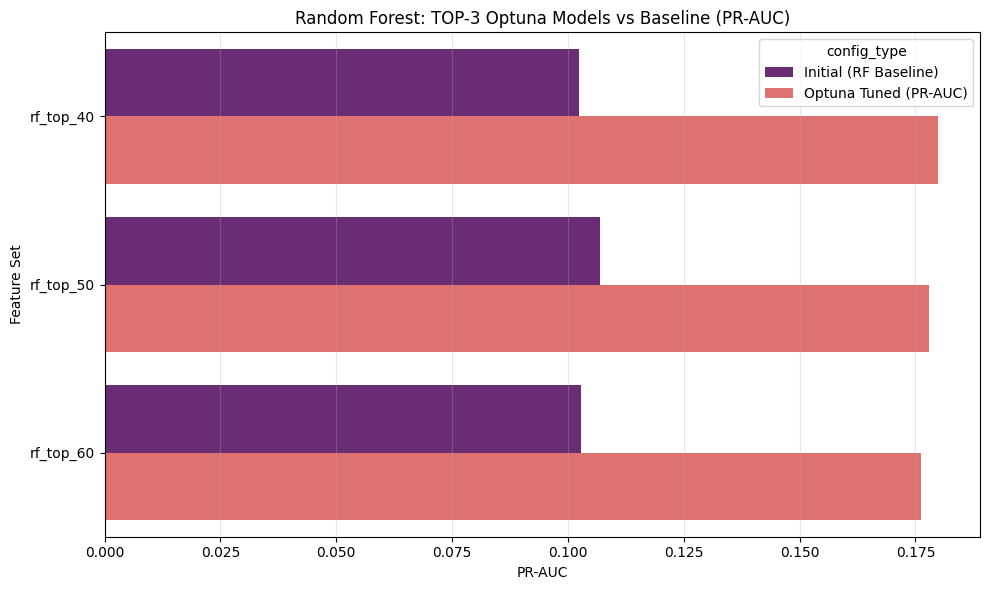

In [253]:
# Build comparison table: TOP-3 Optuna vs corresponding baselines
fs_top3 = top3_rf["feature_set"].tolist()

rf_compare = final_rf_comparison[
    final_rf_comparison["feature_set"].isin(fs_top3)
].copy()

# Keep only baseline + Optuna for those feature sets
rf_compare = rf_compare[
    rf_compare["config_type"].isin([
        "Optuna Tuned (PR-AUC)",
        "Initial (RF Baseline)"
    ])
]

# Sort for nicer plotting
rf_compare = rf_compare.sort_values(
    ["feature_set", "config_type"],
    ascending=[True, True]
)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=rf_compare,
    x="pr_auc_val",
    y="feature_set",
    hue="config_type",
    palette="magma",
)

plt.title("Random Forest: TOP-3 Optuna Models vs Baseline (PR-AUC)")
plt.xlabel("PR-AUC")
plt.ylabel("Feature Set")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


### Train and Save (Random Forest)

In [254]:
fr = final_rf_comparison.copy()

# Keep only Optuna-tuned Random Forest models
tuned_rf = fr.loc[
    fr["config_type"] == "Optuna Tuned (PR-AUC)"
].copy()

if tuned_rf.empty:
    raise ValueError("No Optuna Tuned RF models found")

# Select TOP-3 by PR-AUC
rows_rf = (
    tuned_rf
    .sort_values("pr_auc_val", ascending=False)
    .head(3)
    .reset_index(drop=True)
)

print("TOP-3 Random Forest models by PR-AUC (Optuna)")
display(rows_rf[[
    "feature_set",
    "pr_auc_val",
    "roc_auc_val",
    "params",
]])

TOP-3 Random Forest models by PR-AUC (Optuna)


feature_set  pr_auc_val  roc_auc_val  \
0   rf_top_40    0.179947     0.694899   
1   rf_top_50    0.177958     0.688369   
2   rf_top_60    0.176301     0.694237   

                                                                               params  
0  {'n_estimators': 700, 'max_depth': 12, 'min_samples_leaf': 4, 'max_features': 0.7}  
1  {'n_estimators': 200, 'max_depth': 26, 'min_samples_leaf': 9, 'max_features': 0.7}  
2  {'n_estimators': 400, 'max_depth': 27, 'min_samples_leaf': 6, 'max_features': 0.5}

In [255]:
def parse_params_safe(p):
    if isinstance(p, dict):
        return dict(p)
    if isinstance(p, str):
        try:
            return ast.literal_eval(p)
        except Exception:
            try:
                return json.loads(p)
            except Exception:
                return {}
    return {}

rf_models_config = []

for _, r in rows_rf.iterrows():
    fs = r["feature_set"]
    raw = parse_params_safe(r["params"])

    params = {
        "n_estimators": int(raw["n_estimators"]),
        "max_depth": None if raw.get("max_depth") in (None, "None") else int(raw["max_depth"]),
        "min_samples_leaf": int(raw["min_samples_leaf"]),
        "max_features": raw.get("max_features", None),
    }

    rf_models_config.append({
        "name": f"rf::{fs}",
        "feature_set": fs,
        "params": params,
        "class_weight": "balanced",
        "pr_auc_val": float(r["pr_auc_val"]),
        "roc_auc_val": float(r["roc_auc_val"]),
    })

print(f"RF models selected: {len(rf_models_config)}")
for c in rf_models_config:
    print(
        f"{c['name']} | "
        f"PR-AUC={c['pr_auc_val']:.4f} | "
        f"ROC-AUC={c['roc_auc_val']:.4f} | "
        f"params={c['params']}"
    )


RF models selected: 3
rf::rf_top_40 | PR-AUC=0.1799 | ROC-AUC=0.6949 | params={'n_estimators': 700, 'max_depth': 12, 'min_samples_leaf': 4, 'max_features': 0.7}
rf::rf_top_50 | PR-AUC=0.1780 | ROC-AUC=0.6884 | params={'n_estimators': 200, 'max_depth': 26, 'min_samples_leaf': 9, 'max_features': 0.7}
rf::rf_top_60 | PR-AUC=0.1763 | ROC-AUC=0.6942 | params={'n_estimators': 400, 'max_depth': 27, 'min_samples_leaf': 6, 'max_features': 0.5}


### Feature Sets (Random Forest)

In [256]:
os.makedirs("saved_models/rf", exist_ok=True)

_cache = {}

for cfg in rf_models_config:
    fs = cfg["feature_set"]

    if fs not in feature_sets:
        print(f"Missing feature set {fs}, skip")
        continue

    if fs not in _cache:
        blob = feature_sets[fs]

        X_final = pd.concat(
            [blob["train"], blob["val"]],
            axis=0
        )
        y_final = pd.concat(
            [y_train, y_val],
            axis=0
        )

        feats = blob["train"].columns.tolist()
        _cache[fs] = (X_final, y_final, feats)

    X_final, y_final, feats = _cache[fs]

    clf = RandomForestClassifier(
        n_jobs=-1,
        random_state=42,
        class_weight=cfg["class_weight"],
        **cfg["params"],
    )

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", clf),
    ])

    print(f"Training {cfg['name']} with {len(feats)} features")
    pipe.fit(X_final[feats], y_final)

    safe_name = cfg["name"].replace("::", "__")
    path = os.path.join("saved_models/rf", f"{safe_name}.joblib")

    joblib.dump(
        {
            "model": pipe,
            "family": "random_forest",
            "model_name": cfg["name"],
            "feature_set": fs,
            "features": feats,
            "params": {
                "class_weight": cfg["class_weight"],
                **cfg["params"],
            },
            "metrics": {
                "pr_auc": cfg["pr_auc_val"],
                "roc_auc": cfg["roc_auc_val"],
            },
        },
        path,
        compress=1,
    )

    print(f"Saved: {path}")


Training rf::rf_top_40 with 40 features
Saved: saved_models/rf\rf__rf_top_40.joblib
Training rf::rf_top_50 with 50 features
Saved: saved_models/rf\rf__rf_top_50.joblib
Training rf::rf_top_60 with 60 features
Saved: saved_models/rf\rf__rf_top_60.joblib


### AdaBoost

### Baseline AdaBoost

In [257]:
def train_eval_ada(X_train, y_train, X_val, y_val):
    configs = [
        dict(md=2, ml=10, ne=200, lr=0.10),
        dict(md=1, ml=20, ne=200, lr=0.10),
        dict(md=1, ml=30, ne=100, lr=0.07),
    ]

    best = {
        "roc_auc": -np.inf,
        "pr_auc":  -np.inf,
        "config":  None,
    }

    for hp in configs:
        try:
            stump = DecisionTreeClassifier(
                max_depth=hp["md"],
                min_samples_leaf=hp["ml"],
                class_weight="balanced",
                random_state=42,
            )

            try:
                clf = AdaBoostClassifier(
                    estimator=stump,
                    n_estimators=hp["ne"],
                    learning_rate=hp["lr"],
                    algorithm="SAMME",
                    random_state=42,
                )
            except TypeError:  # old sklearn
                clf = AdaBoostClassifier(
                    base_estimator=stump,
                    n_estimators=hp["ne"],
                    learning_rate=hp["lr"],
                    algorithm="SAMME",
                    random_state=42,
                )

            pipe = Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("clf", clf),
            ])

            pipe.fit(X_train, y_train)

            proba = pipe.predict_proba(X_val)[:, 1]

            roc = roc_auc_score(y_val, proba)
            pr  = average_precision_score(y_val, proba)

            if pr > best["pr_auc"]:
                best.update({
                    "roc_auc": roc,
                    "pr_auc":  pr,
                    "config":  hp,
                })

        except Exception:
            continue

    if best["config"] is None:
        stump = DecisionTreeClassifier(
            max_depth=2,
            min_samples_leaf=20,
            class_weight="balanced",
            random_state=42,
        )

        pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("clf", stump),
        ])

        pipe.fit(X_train, y_train)
        proba = pipe.predict_proba(X_val)[:, 1]

        return {
            "roc_auc": roc_auc_score(y_val, proba),
            "pr_auc":  average_precision_score(y_val, proba),
            "config":  "fallback_tree",
        }

    return best


In [258]:
ada_results = []
for name, fs in tqdm(feature_sets.items(), desc="AdaBoost – feature sets", total=len(feature_sets)):
    m = train_eval_ada(fs["train"], y_train, fs["val"], y_val)
    ada_results.append({
        "feature_set": name,
        "n_features": fs["train"].shape[1],
        "roc_auc_val": m["roc_auc"],
        "pr_auc_val":  m["pr_auc"],
    })

ada_results_df = (
    pd.DataFrame(ada_results)
    .sort_values("pr_auc_val", ascending=False)
    .reset_index(drop=True)
)
ada_results_df


AdaBoost – feature sets:   0%|          | 0/18 [00:00<?, ?it/s]

feature_set  n_features  roc_auc_val  pr_auc_val
0     perm_top_6           6     0.601246    0.077612
1    perm_top_12          12     0.601246    0.077612
2   all_features          91     0.611008    0.076076
3       rf_top_5           5     0.611008    0.076076
4      mi_top_10          10     0.611008    0.076076
5      mi_top_20          20     0.611008    0.076076
6      mi_top_30          30     0.611008    0.076076
7      mi_top_40          40     0.611008    0.076076
8      mi_top_50          50     0.611008    0.076076
9      mi_top_57          57     0.611008    0.076076
10     rf_top_10          10     0.611008    0.076076
11     rf_top_20          20     0.611008    0.076076
12     rf_top_30          30     0.611008    0.076076
13     rf_top_40          40     0.611008    0.076076
14     rf_top_50          50     0.611008    0.076076
15     rf_top_60          60     0.611008    0.076076
16     rf_top_69          69     0.611008    0.076076
17      mi_top_5           5     0.611008    0.076076

### Tuning Top 18 Feature Sets based on PR-AUC

In [259]:
# take all available feature sets
ada_fs = sorted(feature_sets.keys())
print("AdaBoost feature sets:", ada_fs)
print("Total:", len(ada_fs))  # should be 18

# prepare train and validation data with median imputation
pre = {}

for fs_name in ada_fs:
    fs = feature_sets[fs_name]

    imp = SimpleImputer(strategy="median")
    Xtr = imp.fit_transform(fs["train"]).astype(np.float32, copy=False)
    Xva = imp.transform(fs["val"]).astype(np.float32, copy=False)

    pre[fs_name] = {
        "Xtr": Xtr,
        "ytr": y_train.values,
        "Xva": Xva,
        "yva": y_val.values,
        "n_features": fs["train"].shape[1],
    }

# Optuna objective: optimize PR-AUC only
# ROC-AUC is computed and stored for later analysis
def optuna_objective_ada_pr_auc(trial, Xtr, ytr, Xva, yva):
    n_estimators = trial.suggest_int("n_estimators", 200, 1200, step=100)
    learning_rate = trial.suggest_float("learning_rate", 0.02, 0.20, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 3, 40)

    stump = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        class_weight="balanced",
        random_state=42 + trial.number,
    )

    clf = AdaBoostClassifier(
        estimator=stump,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        algorithm="SAMME",
        random_state=42,
    )

    try:
        clf.fit(Xtr, ytr)
        proba = clf.predict_proba(Xva)[:, 1]

        pr_auc = average_precision_score(yva, proba)
        roc_auc = roc_auc_score(yva, proba)

        trial.set_user_attr("roc_auc_val", roc_auc)
        return pr_auc

    except Exception:
        trial.set_user_attr("roc_auc_val", 0.5)
        return 0.0

AdaBoost feature sets: ['all_features', 'mi_top_10', 'mi_top_20', 'mi_top_30', 'mi_top_40', 'mi_top_5', 'mi_top_50', 'mi_top_57', 'perm_top_12', 'perm_top_6', 'rf_top_10', 'rf_top_20', 'rf_top_30', 'rf_top_40', 'rf_top_5', 'rf_top_50', 'rf_top_60', 'rf_top_69']
Total: 18


### Optuna PR-AUC AdaBoost Tuner

In [263]:
ada_optuna_results = []
ada_studies = {}

for fs_name, d in tqdm(pre.items(), desc="AdaBoost tuning", total=len(pre)):
    print(f"Tuning AdaBoost for feature set: {fs_name}")

    study = optuna.create_study(direction="maximize")

    study.optimize(
        lambda trial: optuna_objective_ada_pr_auc(
            trial,
            d["Xtr"], d["ytr"],
            d["Xva"], d["yva"],
        ),
        n_trials=10,
        show_progress_bar=True,
    )

    ada_studies[fs_name] = study

    best = study.best_trial
    best_params = best.params

    ada_optuna_results.append({
        "feature_set": fs_name,
        "n_features": d["n_features"],
        "pr_auc_val": best.value,
        "roc_auc_val": best.user_attrs.get("roc_auc_val", np.nan),
        "best_params": best_params,
    })

AdaBoost tuning:   0%|          | 0/18 [00:00<?, ?it/s]

[I 2026-01-15 12:40:00,861] A new study created in memory with name: no-name-4de20cd7-32f5-43da-a55c-60190a1a9c21


Tuning AdaBoost for feature set: all_features


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-15 12:40:17,876] Trial 0 finished with value: 0.08084365582168745 and parameters: {'n_estimators': 800, 'learning_rate': 0.036521619744621425, 'max_depth': 3, 'min_samples_leaf': 36}. Best is trial 0 with value: 0.08084365582168745.
[I 2026-01-15 12:40:24,712] Trial 1 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 400, 'learning_rate': 0.10172916471903526, 'max_depth': 2, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.08084365582168745.
[I 2026-01-15 12:40:26,513] Trial 2 finished with value: 0.08143632001302382 and parameters: {'n_estimators': 900, 'learning_rate': 0.09876317234258165, 'max_depth': 5, 'min_samples_leaf': 36}. Best is trial 2 with value: 0.08143632001302382.
[I 2026-01-15 12:40:39,337] Trial 3 finished with value: 0.08149779735682819 and parameters: {'n_estimators': 500, 'learning_rate': 0.12293757236336682, 'max_depth': 4, 'min_samples_leaf': 15}. Best is trial 3 with value: 0.08149779735682819.
[I 2026-01-15 12:40:40,202]

[I 2026-01-15 12:41:41,007] A new study created in memory with name: no-name-7988a80b-20df-490d-969f-de76d1946b1d


[I 2026-01-15 12:41:41,003] Trial 9 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 500, 'learning_rate': 0.034297760664332155, 'max_depth': 2, 'min_samples_leaf': 24}. Best is trial 3 with value: 0.08149779735682819.
Tuning AdaBoost for feature set: mi_top_10


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-15 12:41:47,107] Trial 0 finished with value: 0.08085664335664336 and parameters: {'n_estimators': 900, 'learning_rate': 0.02310049247081888, 'max_depth': 3, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.08085664335664336.
[I 2026-01-15 12:41:53,598] Trial 1 finished with value: 0.0812829525483304 and parameters: {'n_estimators': 900, 'learning_rate': 0.035123568463529715, 'max_depth': 4, 'min_samples_leaf': 22}. Best is trial 1 with value: 0.0812829525483304.
[I 2026-01-15 12:41:57,469] Trial 2 finished with value: 0.08085664335664336 and parameters: {'n_estimators': 500, 'learning_rate': 0.06158564894883115, 'max_depth': 4, 'min_samples_leaf': 39}. Best is trial 1 with value: 0.0812829525483304.
[I 2026-01-15 12:42:02,608] Trial 3 finished with value: 0.08085664335664336 and parameters: {'n_estimators': 700, 'learning_rate': 0.05300382311437727, 'max_depth': 4, 'min_samples_leaf': 31}. Best is trial 1 with value: 0.0812829525483304.
[I 2026-01-15 12:42:12,244] Tri

[I 2026-01-15 12:42:31,814] A new study created in memory with name: no-name-8f4c2acb-34cf-4001-bc0d-31accf9e72d9


[I 2026-01-15 12:42:31,800] Trial 9 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 700, 'learning_rate': 0.0267008409684275, 'max_depth': 2, 'min_samples_leaf': 5}. Best is trial 6 with value: 0.08149779735682819.
Tuning AdaBoost for feature set: mi_top_20


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-15 12:42:37,569] Trial 0 finished with value: 0.08084365582168745 and parameters: {'n_estimators': 500, 'learning_rate': 0.060150317048499095, 'max_depth': 3, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.08084365582168745.
[I 2026-01-15 12:42:39,436] Trial 1 finished with value: 0.08105618426103008 and parameters: {'n_estimators': 1200, 'learning_rate': 0.02107651530966101, 'max_depth': 5, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.08105618426103008.
[I 2026-01-15 12:42:40,357] Trial 2 finished with value: 0.08105618426103008 and parameters: {'n_estimators': 700, 'learning_rate': 0.07268487413850208, 'max_depth': 4, 'min_samples_leaf': 34}. Best is trial 1 with value: 0.08105618426103008.
[I 2026-01-15 12:42:49,327] Trial 3 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 1100, 'learning_rate': 0.04796973462743684, 'max_depth': 2, 'min_samples_leaf': 38}. Best is trial 1 with value: 0.08105618426103008.
[I 2026-01-15 12:42:59,77

[I 2026-01-15 12:43:14,873] A new study created in memory with name: no-name-1aa44d89-61c3-4210-92c4-906eee32c41c


[I 2026-01-15 12:43:14,870] Trial 9 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 800, 'learning_rate': 0.12273547811207218, 'max_depth': 2, 'min_samples_leaf': 39}. Best is trial 4 with value: 0.08149779735682819.
Tuning AdaBoost for feature set: mi_top_30


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-15 12:43:30,442] Trial 0 finished with value: 0.08181126833615227 and parameters: {'n_estimators': 1100, 'learning_rate': 0.19544850022803673, 'max_depth': 5, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.08181126833615227.
[I 2026-01-15 12:43:44,040] Trial 1 finished with value: 0.0812829525483304 and parameters: {'n_estimators': 1000, 'learning_rate': 0.024228400207171236, 'max_depth': 4, 'min_samples_leaf': 23}. Best is trial 0 with value: 0.08181126833615227.
[I 2026-01-15 12:43:55,577] Trial 2 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 1200, 'learning_rate': 0.13249261439422058, 'max_depth': 2, 'min_samples_leaf': 35}. Best is trial 0 with value: 0.08181126833615227.
[I 2026-01-15 12:43:56,008] Trial 3 finished with value: 0.08105618426103008 and parameters: {'n_estimators': 1000, 'learning_rate': 0.14259800393852703, 'max_depth': 5, 'min_samples_leaf': 35}. Best is trial 0 with value: 0.08181126833615227.
[I 2026-01-15 12:44:00,45

[I 2026-01-15 12:44:23,235] A new study created in memory with name: no-name-8a9c0ad3-5593-46b6-96ef-fc5df153953f


[I 2026-01-15 12:44:23,231] Trial 9 finished with value: 0.08149779735682819 and parameters: {'n_estimators': 700, 'learning_rate': 0.07778947480504549, 'max_depth': 4, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.08181126833615227.
Tuning AdaBoost for feature set: mi_top_40


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-15 12:44:37,096] Trial 0 finished with value: 0.08084365582168745 and parameters: {'n_estimators': 1100, 'learning_rate': 0.07060702845157003, 'max_depth': 3, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.08084365582168745.
[I 2026-01-15 12:44:49,575] Trial 1 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 1200, 'learning_rate': 0.03411260184099472, 'max_depth': 2, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.08084365582168745.
[I 2026-01-15 12:44:55,088] Trial 2 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 500, 'learning_rate': 0.1329315829678591, 'max_depth': 2, 'min_samples_leaf': 38}. Best is trial 0 with value: 0.08084365582168745.
[I 2026-01-15 12:44:55,829] Trial 3 finished with value: 0.08084365582168745 and parameters: {'n_estimators': 200, 'learning_rate': 0.13983563075637429, 'max_depth': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.08084365582168745.
[I 2026-01-15 12:45:05,140] 

[I 2026-01-15 12:45:49,570] A new study created in memory with name: no-name-76b3136e-4513-4648-b9b3-86f8645ec884


[I 2026-01-15 12:45:49,566] Trial 9 finished with value: 0.08189979150588629 and parameters: {'n_estimators': 1100, 'learning_rate': 0.09745502108426081, 'max_depth': 5, 'min_samples_leaf': 8}. Best is trial 6 with value: 0.08209309029771378.
Tuning AdaBoost for feature set: mi_top_5


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-15 12:45:53,465] Trial 0 finished with value: 0.07629980431452865 and parameters: {'n_estimators': 600, 'learning_rate': 0.15764209158749032, 'max_depth': 5, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.07629980431452865.
[I 2026-01-15 12:45:54,759] Trial 1 finished with value: 0.07480691636726115 and parameters: {'n_estimators': 1200, 'learning_rate': 0.03988026301002572, 'max_depth': 5, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.07629980431452865.
[I 2026-01-15 12:45:59,906] Trial 2 finished with value: 0.07482492851548024 and parameters: {'n_estimators': 800, 'learning_rate': 0.0301776371829186, 'max_depth': 4, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.07629980431452865.
[I 2026-01-15 12:46:00,681] Trial 3 finished with value: 0.07629087830384781 and parameters: {'n_estimators': 1100, 'learning_rate': 0.034999243197872947, 'max_depth': 5, 'min_samples_leaf': 38}. Best is trial 0 with value: 0.07629980431452865.
[I 2026-01-15 12:46:05,510]

[I 2026-01-15 12:46:25,636] A new study created in memory with name: no-name-9201fb2f-e05d-4b2d-bd91-0907b65a748f


[I 2026-01-15 12:46:25,628] Trial 9 finished with value: 0.07482492851548024 and parameters: {'n_estimators': 400, 'learning_rate': 0.0769813999017495, 'max_depth': 4, 'min_samples_leaf': 37}. Best is trial 0 with value: 0.07629980431452865.
Tuning AdaBoost for feature set: mi_top_50


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-15 12:46:27,447] Trial 0 finished with value: 0.08084365582168745 and parameters: {'n_estimators': 200, 'learning_rate': 0.06699073357784684, 'max_depth': 3, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.08084365582168745.
[I 2026-01-15 12:46:28,964] Trial 1 finished with value: 0.08143632001302382 and parameters: {'n_estimators': 500, 'learning_rate': 0.07809958810625349, 'max_depth': 4, 'min_samples_leaf': 31}. Best is trial 1 with value: 0.08143632001302382.
[I 2026-01-15 12:46:31,075] Trial 2 finished with value: 0.08084365582168745 and parameters: {'n_estimators': 1200, 'learning_rate': 0.05100616734024711, 'max_depth': 3, 'min_samples_leaf': 39}. Best is trial 1 with value: 0.08143632001302382.
[I 2026-01-15 12:46:38,431] Trial 3 finished with value: 0.08167014365154747 and parameters: {'n_estimators': 400, 'learning_rate': 0.13795322521771522, 'max_depth': 4, 'min_samples_leaf': 23}. Best is trial 3 with value: 0.08167014365154747.
[I 2026-01-15 12:46:42,479]

[I 2026-01-15 12:47:07,691] A new study created in memory with name: no-name-fcaa31d0-dc00-4eb3-aca0-47b31ed30710


[I 2026-01-15 12:47:07,686] Trial 9 finished with value: 0.08147219446638822 and parameters: {'n_estimators': 1000, 'learning_rate': 0.09827535910558617, 'max_depth': 4, 'min_samples_leaf': 27}. Best is trial 3 with value: 0.08167014365154747.
Tuning AdaBoost for feature set: mi_top_57


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-15 12:47:10,221] Trial 0 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 200, 'learning_rate': 0.03806966717661987, 'max_depth': 2, 'min_samples_leaf': 40}. Best is trial 0 with value: 0.07607634623722921.
[I 2026-01-15 12:47:15,754] Trial 1 finished with value: 0.08189174643178271 and parameters: {'n_estimators': 300, 'learning_rate': 0.19800750459211738, 'max_depth': 4, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.08189174643178271.
[I 2026-01-15 12:47:18,133] Trial 2 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 200, 'learning_rate': 0.08529980415668036, 'max_depth': 2, 'min_samples_leaf': 29}. Best is trial 1 with value: 0.08189174643178271.
[I 2026-01-15 12:47:18,914] Trial 3 finished with value: 0.08121948097707873 and parameters: {'n_estimators': 700, 'learning_rate': 0.14157788599241405, 'max_depth': 4, 'min_samples_leaf': 40}. Best is trial 1 with value: 0.08189174643178271.
[I 2026-01-15 12:47:19,397] T

[I 2026-01-15 12:48:20,011] A new study created in memory with name: no-name-ed910c6c-b63b-41bc-b7a1-14e62726671b


[I 2026-01-15 12:48:20,008] Trial 9 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 200, 'learning_rate': 0.02857134716792282, 'max_depth': 2, 'min_samples_leaf': 6}. Best is trial 6 with value: 0.08194761419734836.
Tuning AdaBoost for feature set: perm_top_12


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-15 12:48:20,032] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 800, 'learning_rate': 0.022667500226192763, 'max_depth': 4, 'min_samples_leaf': 28}. Best is trial 0 with value: 0.0.
[I 2026-01-15 12:48:20,044] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 600, 'learning_rate': 0.1564814597747131, 'max_depth': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.0.
[I 2026-01-15 12:48:20,063] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.0216649450227871, 'max_depth': 3, 'min_samples_leaf': 28}. Best is trial 0 with value: 0.0.
[I 2026-01-15 12:48:20,085] Trial 3 finished with value: 0.07761165835095796 and parameters: {'n_estimators': 600, 'learning_rate': 0.11621287531024317, 'max_depth': 2, 'min_samples_leaf': 31}. Best is trial 3 with value: 0.07761165835095796.
[I 2026-01-15 12:48:20,114] Trial 4 finished with value: 0.07761165835095796 and parameters: {'n_estimators': 1000, 'learning_

[I 2026-01-15 12:48:20,216] A new study created in memory with name: no-name-3f02da86-d6e8-451c-8719-80ed9d8184ee


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-15 12:48:20,363] A new study created in memory with name: no-name-e3d79473-30cb-401b-9554-b1b9ebc857ac


[I 2026-01-15 12:48:20,235] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.038521649268578956, 'max_depth': 4, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.0.
[I 2026-01-15 12:48:20,249] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 700, 'learning_rate': 0.04141091275828277, 'max_depth': 4, 'min_samples_leaf': 27}. Best is trial 0 with value: 0.0.
[I 2026-01-15 12:48:20,260] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 200, 'learning_rate': 0.11277972844406348, 'max_depth': 5, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.0.
[I 2026-01-15 12:48:20,292] Trial 3 finished with value: 0.07761165835095796 and parameters: {'n_estimators': 900, 'learning_rate': 0.02692067828309365, 'max_depth': 2, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.07761165835095796.
[I 2026-01-15 12:48:20,303] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 200, 'learning_rate': 0.04410

  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-15 12:48:23,055] Trial 0 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 300, 'learning_rate': 0.027649515712720212, 'max_depth': 3, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.07607634623722921.
[I 2026-01-15 12:48:33,753] Trial 1 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 1200, 'learning_rate': 0.0950451180421105, 'max_depth': 3, 'min_samples_leaf': 34}. Best is trial 0 with value: 0.07607634623722921.
[I 2026-01-15 12:48:33,942] Trial 2 finished with value: 0.07796386209065229 and parameters: {'n_estimators': 800, 'learning_rate': 0.15212856494966734, 'max_depth': 5, 'min_samples_leaf': 34}. Best is trial 2 with value: 0.07796386209065229.
[I 2026-01-15 12:48:39,979] Trial 3 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 700, 'learning_rate': 0.12909690750135555, 'max_depth': 3, 'min_samples_leaf': 8}. Best is trial 2 with value: 0.07796386209065229.
[I 2026-01-15 12:48:43,769] 

[I 2026-01-15 12:49:20,009] A new study created in memory with name: no-name-65128035-2e94-4158-9c5a-642b48041410


[I 2026-01-15 12:49:20,005] Trial 9 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 600, 'learning_rate': 0.05136341881332083, 'max_depth': 3, 'min_samples_leaf': 22}. Best is trial 2 with value: 0.07796386209065229.
Tuning AdaBoost for feature set: rf_top_20


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-15 12:49:31,513] Trial 0 finished with value: 0.08149779735682819 and parameters: {'n_estimators': 800, 'learning_rate': 0.07768983124026817, 'max_depth': 4, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.08149779735682819.
[I 2026-01-15 12:49:32,569] Trial 1 finished with value: 0.08085664335664336 and parameters: {'n_estimators': 900, 'learning_rate': 0.025324949751558908, 'max_depth': 5, 'min_samples_leaf': 33}. Best is trial 0 with value: 0.08149779735682819.
[I 2026-01-15 12:49:35,228] Trial 2 finished with value: 0.0810917149447339 and parameters: {'n_estimators': 1100, 'learning_rate': 0.03093404580604907, 'max_depth': 4, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.08149779735682819.
[I 2026-01-15 12:49:43,360] Trial 3 finished with value: 0.08149779735682819 and parameters: {'n_estimators': 600, 'learning_rate': 0.05320491876890361, 'max_depth': 4, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.08149779735682819.
[I 2026-01-15 12:49:59,533]

[I 2026-01-15 12:50:18,662] A new study created in memory with name: no-name-bb1637d8-2204-4845-9f65-cf051150293e


[I 2026-01-15 12:50:18,658] Trial 9 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 600, 'learning_rate': 0.1479981900231464, 'max_depth': 2, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.08149779735682819.
Tuning AdaBoost for feature set: rf_top_30


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-15 12:50:23,541] Trial 0 finished with value: 0.08084365582168745 and parameters: {'n_estimators': 700, 'learning_rate': 0.028209540142295556, 'max_depth': 4, 'min_samples_leaf': 38}. Best is trial 0 with value: 0.08084365582168745.
[I 2026-01-15 12:50:32,648] Trial 1 finished with value: 0.08084365582168745 and parameters: {'n_estimators': 700, 'learning_rate': 0.04506848084056841, 'max_depth': 3, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.08084365582168745.
[I 2026-01-15 12:50:45,724] Trial 2 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 1200, 'learning_rate': 0.17411865318043862, 'max_depth': 2, 'min_samples_leaf': 35}. Best is trial 0 with value: 0.08084365582168745.
[I 2026-01-15 12:50:51,315] Trial 3 finished with value: 0.08084365582168745 and parameters: {'n_estimators': 400, 'learning_rate': 0.09464034406270982, 'max_depth': 3, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.08084365582168745.
[I 2026-01-15 12:50:54,555

[I 2026-01-15 12:51:15,255] A new study created in memory with name: no-name-380c1ea7-d004-48d9-838b-ebcea6a85509


[I 2026-01-15 12:51:15,252] Trial 9 finished with value: 0.08084365582168745 and parameters: {'n_estimators': 1200, 'learning_rate': 0.04254790872676381, 'max_depth': 3, 'min_samples_leaf': 18}. Best is trial 5 with value: 0.08149779735682819.
Tuning AdaBoost for feature set: rf_top_40


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-15 12:51:27,847] Trial 0 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 1100, 'learning_rate': 0.06185061836629541, 'max_depth': 2, 'min_samples_leaf': 29}. Best is trial 0 with value: 0.07607634623722921.
[I 2026-01-15 12:51:31,064] Trial 1 finished with value: 0.08084365582168745 and parameters: {'n_estimators': 600, 'learning_rate': 0.03478090120919689, 'max_depth': 3, 'min_samples_leaf': 32}. Best is trial 1 with value: 0.08084365582168745.
[I 2026-01-15 12:51:32,051] Trial 2 finished with value: 0.0810917149447339 and parameters: {'n_estimators': 900, 'learning_rate': 0.099875117723385, 'max_depth': 4, 'min_samples_leaf': 27}. Best is trial 2 with value: 0.0810917149447339.
[I 2026-01-15 12:51:32,815] Trial 3 finished with value: 0.08149779735682819 and parameters: {'n_estimators': 1100, 'learning_rate': 0.1309338879927423, 'max_depth': 4, 'min_samples_leaf': 12}. Best is trial 3 with value: 0.08149779735682819.
[I 2026-01-15 12:51:36,260] Tri

[I 2026-01-15 12:52:16,977] A new study created in memory with name: no-name-92070500-3dcf-451a-b210-0444f4c55ef4


[I 2026-01-15 12:52:16,974] Trial 9 finished with value: 0.0810917149447339 and parameters: {'n_estimators': 500, 'learning_rate': 0.029421631261388848, 'max_depth': 5, 'min_samples_leaf': 28}. Best is trial 3 with value: 0.08149779735682819.
Tuning AdaBoost for feature set: rf_top_5


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-15 12:52:22,574] Trial 0 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07524402586847699, 'max_depth': 2, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.07607634623722921.
[I 2026-01-15 12:52:30,888] Trial 1 finished with value: 0.07748132222072716 and parameters: {'n_estimators': 1200, 'learning_rate': 0.08181098853034897, 'max_depth': 5, 'min_samples_leaf': 29}. Best is trial 1 with value: 0.07748132222072716.
[I 2026-01-15 12:52:36,936] Trial 2 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 900, 'learning_rate': 0.04395415166169281, 'max_depth': 3, 'min_samples_leaf': 11}. Best is trial 1 with value: 0.07748132222072716.
[I 2026-01-15 12:52:40,083] Trial 3 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 400, 'learning_rate': 0.04544751684791105, 'max_depth': 3, 'min_samples_leaf': 12}. Best is trial 1 with value: 0.07748132222072716.
[I 2026-01-15 12:52:41,304

[I 2026-01-15 12:52:55,980] A new study created in memory with name: no-name-373068f6-4336-4892-8ca5-0bacd44f630a


[I 2026-01-15 12:52:55,976] Trial 9 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 700, 'learning_rate': 0.14342483973099363, 'max_depth': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.07748132222072716.
Tuning AdaBoost for feature set: rf_top_50


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-15 12:52:59,733] Trial 0 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 300, 'learning_rate': 0.07742188183926701, 'max_depth': 2, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.07607634623722921.
[I 2026-01-15 12:53:17,790] Trial 1 finished with value: 0.08149779735682819 and parameters: {'n_estimators': 800, 'learning_rate': 0.1898885955295947, 'max_depth': 5, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.08149779735682819.
[I 2026-01-15 12:53:30,955] Trial 2 finished with value: 0.08149779735682819 and parameters: {'n_estimators': 700, 'learning_rate': 0.10712381897165725, 'max_depth': 4, 'min_samples_leaf': 18}. Best is trial 1 with value: 0.08149779735682819.
[I 2026-01-15 12:53:43,169] Trial 3 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 1000, 'learning_rate': 0.032015137781520875, 'max_depth': 2, 'min_samples_leaf': 24}. Best is trial 1 with value: 0.08149779735682819.
[I 2026-01-15 12:53:43,694] T

[I 2026-01-15 12:54:24,387] A new study created in memory with name: no-name-fe089f30-3f69-497b-9434-ea9336b6f84b


[I 2026-01-15 12:54:24,385] Trial 9 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 600, 'learning_rate': 0.03932245548540342, 'max_depth': 2, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.08149779735682819.
Tuning AdaBoost for feature set: rf_top_60


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-15 12:54:26,260] Trial 0 finished with value: 0.08149779735682819 and parameters: {'n_estimators': 1200, 'learning_rate': 0.05753677106163244, 'max_depth': 5, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.08149779735682819.
[I 2026-01-15 12:54:27,673] Trial 1 finished with value: 0.08084365582168745 and parameters: {'n_estimators': 600, 'learning_rate': 0.07544799617486522, 'max_depth': 3, 'min_samples_leaf': 34}. Best is trial 0 with value: 0.08149779735682819.
[I 2026-01-15 12:54:35,518] Trial 2 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 600, 'learning_rate': 0.07178529313978695, 'max_depth': 2, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.08149779735682819.
[I 2026-01-15 12:54:46,094] Trial 3 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 800, 'learning_rate': 0.0564414301589988, 'max_depth': 2, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.08149779735682819.
[I 2026-01-15 12:54:46,574] T

[I 2026-01-15 12:56:02,856] A new study created in memory with name: no-name-9c8e1b9f-a5a8-4700-99f6-b48589992d7b


[I 2026-01-15 12:56:02,856] Trial 9 finished with value: 0.0810917149447339 and parameters: {'n_estimators': 1100, 'learning_rate': 0.09402271931659278, 'max_depth': 5, 'min_samples_leaf': 32}. Best is trial 0 with value: 0.08149779735682819.
Tuning AdaBoost for feature set: rf_top_69


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-15 12:56:07,057] Trial 0 finished with value: 0.07607634623722921 and parameters: {'n_estimators': 300, 'learning_rate': 0.0545727723841099, 'max_depth': 2, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.07607634623722921.
[I 2026-01-15 12:56:09,853] Trial 1 finished with value: 0.08084365582168745 and parameters: {'n_estimators': 1100, 'learning_rate': 0.048070024824385604, 'max_depth': 3, 'min_samples_leaf': 21}. Best is trial 1 with value: 0.08084365582168745.
[I 2026-01-15 12:56:14,168] Trial 2 finished with value: 0.08189174643178271 and parameters: {'n_estimators': 1200, 'learning_rate': 0.038892873742177377, 'max_depth': 5, 'min_samples_leaf': 15}. Best is trial 2 with value: 0.08189174643178271.
[I 2026-01-15 12:56:15,801] Trial 3 finished with value: 0.0810917149447339 and parameters: {'n_estimators': 200, 'learning_rate': 0.07226601153894219, 'max_depth': 4, 'min_samples_leaf': 33}. Best is trial 2 with value: 0.08189174643178271.
[I 2026-01-15 12:56:26,096

### Comparison For AdaBoost: Baseline vs Optuna

In [265]:
ada_optuna_results_df = (
    pd.DataFrame(ada_optuna_results)
      .sort_values("pr_auc_val", ascending=False)
      .reset_index(drop=True)
)

# baseline AdaBoost results
initial_ada = ada_results_df.copy()

initial_ada["config_type"] = "Initial (AdaBoost Baseline)"

# store baseline params as dict (same format as Optuna)
initial_ada["params"] = [{
    "n_estimators": 400,
    "learning_rate": 0.05,
    "max_depth": 3,
    "min_samples_leaf": 10,
    "algorithm": "SAMME",
}] * len(initial_ada)


# Optuna-tuned AdaBoost results
tuned_ada = ada_optuna_results_df.copy()

tuned_ada["config_type"] = "Optuna Tuned (PR-AUC)"
tuned_ada.rename(columns={"best_params": "params"}, inplace=True)


# combine baseline + tuned (36 models total)
final_ada_comparison = (
    pd.concat([tuned_ada, initial_ada], ignore_index=True)
      .sort_values(
          by=["pr_auc_val", "config_type"],
          ascending=[False, True]
      )
      .reset_index(drop=True)
)

print("Final AdaBoost Leaderboard (ranked by PR-AUC)")
display(final_ada_comparison[[
    "feature_set",
    "config_type",
    "pr_auc_val",
    "roc_auc_val",
    "params",
]])

Final AdaBoost Leaderboard (ranked by PR-AUC)


feature_set                  config_type  pr_auc_val  roc_auc_val  \
0      mi_top_40        Optuna Tuned (PR-AUC)    0.082093     0.643187   
1      mi_top_57        Optuna Tuned (PR-AUC)    0.081948     0.642542   
2      rf_top_69        Optuna Tuned (PR-AUC)    0.081892     0.642276   
3      mi_top_30        Optuna Tuned (PR-AUC)    0.081811     0.641893   
4      mi_top_50        Optuna Tuned (PR-AUC)    0.081670     0.641219   
5      rf_top_20        Optuna Tuned (PR-AUC)    0.081498     0.640393   
6      rf_top_60        Optuna Tuned (PR-AUC)    0.081498     0.640393   
7      rf_top_50        Optuna Tuned (PR-AUC)    0.081498     0.640393   
8      rf_top_40        Optuna Tuned (PR-AUC)    0.081498     0.640393   
9      rf_top_30        Optuna Tuned (PR-AUC)    0.081498     0.640393   
10  all_features        Optuna Tuned (PR-AUC)    0.081498     0.640393   
11     mi_top_10        Optuna Tuned (PR-AUC)    0.081498     0.640393   
12     mi_top_20        Optuna Tuned (PR-AUC)    0.081498     0.640393   
13     rf_top_10        Optuna Tuned (PR-AUC)    0.077964     0.620288   
14    perm_top_6  Initial (AdaBoost Baseline)    0.077612     0.601246   
15   perm_top_12  Initial (AdaBoost Baseline)    0.077612     0.601246   
16   perm_top_12        Optuna Tuned (PR-AUC)    0.077612     0.601246   
17    perm_top_6        Optuna Tuned (PR-AUC)    0.077612     0.601246   
18      rf_top_5        Optuna Tuned (PR-AUC)    0.077481     0.617076   
19      mi_top_5        Optuna Tuned (PR-AUC)    0.076300     0.611511   
20  all_features  Initial (AdaBoost Baseline)    0.076076     0.611008   
21      rf_top_5  Initial (AdaBoost Baseline)    0.076076     0.611008   
22     mi_top_10  Initial (AdaBoost Baseline)    0.076076     0.611008   
23     mi_top_20  Initial (AdaBoost Baseline)    0.076076     0.611008   
24     mi_top_30  Initial (AdaBoost Baseline)    0.076076     0.611008   
25     mi_top_40  Initial (AdaBoost Baseline)    0.076076     0.611008   
26     mi_top_50  Initial (AdaBoost Baseline)    0.076076     0.611008   
27     mi_top_57  Initial (AdaBoost Baseline)    0.076076     0.611008   
28     rf_top_10  Initial (AdaBoost Baseline)    0.076076     0.611008   
29     rf_top_20  Initial (AdaBoost Baseline)    0.076076     0.611008   
30     rf_top_30  Initial (AdaBoost Baseline)    0.076076     0.611008   
31     rf_top_40  Initial (AdaBoost Baseline)    0.076076     0.611008   
32     rf_top_50  Initial (AdaBoost Baseline)    0.076076     0.611008   
33     rf_top_60  Initial (AdaBoost Baseline)    0.076076     0.611008   
34     rf_top_69  Initial (AdaBoost Baseline)    0.076076     0.611008   
35      mi_top_5  Initial (AdaBoost Baseline)    0.076076     0.611008   

                                                                                                        params  
0          {'n_estimators': 500, 'learning_rate': 0.03658699782690441, 'max_depth': 5, 'min_samples_leaf': 14}  
1          {'n_estimators': 900, 'learning_rate': 0.07996829848337862, 'max_depth': 5, 'min_samples_leaf': 14}  
2        {'n_estimators': 1200, 'learning_rate': 0.038892873742177377, 'max_depth': 5, 'min_samples_leaf': 15}  
3          {'n_estimators': 1100, 'learning_rate': 0.19544850022803673, 'max_depth': 5, 'min_samples_leaf': 7}  
4          {'n_estimators': 400, 'learning_rate': 0.13795322521771522, 'max_depth': 4, 'min_samples_leaf': 23}  
5          {'n_estimators': 800, 'learning_rate': 0.07768983124026817, 'max_depth': 4, 'min_samples_leaf': 15}  
6         {'n_estimators': 1200, 'learning_rate': 0.05753677106163244, 'max_depth': 5, 'min_samples_leaf': 18}  
7            {'n_estimators': 800, 'learning_rate': 0.1898885955295947, 'max_depth': 5, 'min_samples_leaf': 5}  
8          {'n_estimators': 1100, 'learning_rate': 0.1309338879927423, 'max_depth': 4, 'min_samples_leaf': 12}  
9          {'n_estimators': 200, 'learning_rate': 0.17282735712006503, 'max_depth': 4, 'min_samples_leaf': 14}  
10         {'n_estimato

In [266]:
# Select top-3 Optuna AdaBoost models by PR-AUC
optuna_ada = final_ada_comparison[
    final_ada_comparison["config_type"] == "Optuna Tuned (PR-AUC)"
].copy()

top3_optuna = (
    optuna_ada
    .sort_values("pr_auc_val", ascending=False)
    .head(3)
    .reset_index(drop=True)
)

# Get corresponding baseline models with the same feature sets
baseline_ada = final_ada_comparison[
    (final_ada_comparison["config_type"] == "Initial (AdaBoost Baseline)") &
    (final_ada_comparison["feature_set"].isin(top3_optuna["feature_set"]))
].copy()

# Combine Optuna and Baseline for comparison
ada_top3_compare = (
    pd.concat([top3_optuna, baseline_ada], ignore_index=True)
    .sort_values(["feature_set", "config_type"])
    .reset_index(drop=True)
)

print("Top-3 AdaBoost models: Optuna vs Baseline")
display(ada_top3_compare[[
    "feature_set",
    "config_type",
    "pr_auc_val",
    "roc_auc_val",
    "params",
]])

Top-3 AdaBoost models: Optuna vs Baseline


feature_set                  config_type  pr_auc_val  roc_auc_val  \
0   mi_top_40  Initial (AdaBoost Baseline)    0.076076     0.611008   
1   mi_top_40        Optuna Tuned (PR-AUC)    0.082093     0.643187   
2   mi_top_57  Initial (AdaBoost Baseline)    0.076076     0.611008   
3   mi_top_57        Optuna Tuned (PR-AUC)    0.081948     0.642542   
4   rf_top_69  Initial (AdaBoost Baseline)    0.076076     0.611008   
5   rf_top_69        Optuna Tuned (PR-AUC)    0.081892     0.642276   

                                                                                                       params  
0  {'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 10, 'algorithm': 'SAMME'}  
1         {'n_estimators': 500, 'learning_rate': 0.03658699782690441, 'max_depth': 5, 'min_samples_leaf': 14}  
2  {'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 10, 'algorithm': 'SAMME'}  
3         {'n_estimators': 900, 'learning_rate': 0.07996829848337862, 'max_depth': 5, 'min_samples_leaf': 14}  
4  {'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 10, 'algorithm': 'SAMME'}  
5       {'n_estimators': 1200, 'learning_rate': 0.038892873742177377, 'max_depth': 5, 'min_samples_leaf': 15}

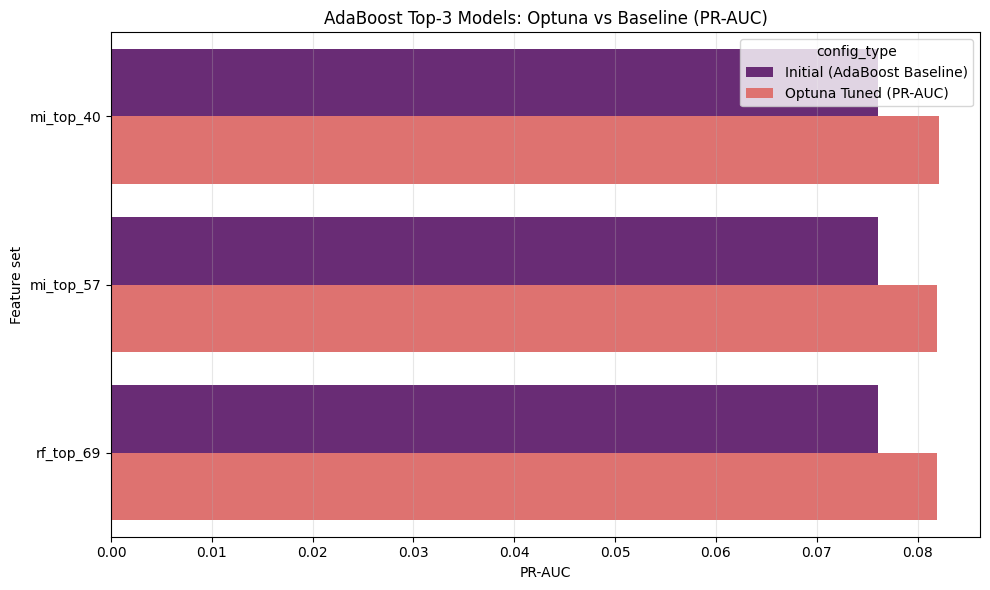

In [267]:
# Visualization
plt.figure(figsize=(10, 6))

sns.barplot(
    data=ada_top3_compare,
    x="pr_auc_val",
    y="feature_set",
    hue="config_type",
    palette="magma",
)

plt.title("AdaBoost Top-3 Models: Optuna vs Baseline (PR-AUC)")
plt.xlabel("PR-AUC")
plt.ylabel("Feature set")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


### Train and Save (AdaBoost)

In [268]:
# Select TOP-3 Optuna AdaBoost models globally by PR-AUC
fa = final_ada_comparison.copy()

tuned_a = fa[fa["config_type"] == "Optuna Tuned (PR-AUC)"].copy()
if tuned_a.empty:
    raise ValueError("No Optuna Tuned AdaBoost models found")

rows_a = (
    tuned_a
    .sort_values("pr_auc_val", ascending=False)
    .head(3)
    .reset_index(drop=True)
)

print("Top-3 AdaBoost models by PR-AUC")
display(rows_a[[
    "feature_set",
    "pr_auc_val",
    "roc_auc_val",
    "params",
]])

def _parse_params(p):
    if isinstance(p, dict):
        return dict(p)
    if isinstance(p, str):
        try:
            return ast.literal_eval(p)
        except Exception:
            try:
                return json.loads(p)
            except Exception:
                return {}
    return {}

ada_models_config = []

for _, r in rows_a.iterrows():
    fs = r["feature_set"]
    raw = _parse_params(r["params"])

    cleaned = {}
    if "n_estimators" in raw:
        cleaned["n_estimators"] = int(raw["n_estimators"])
    if "learning_rate" in raw:
        cleaned["learning_rate"] = float(raw["learning_rate"])
    if "max_depth" in raw:
        cleaned["max_depth"] = int(raw["max_depth"])
    if "min_samples_leaf" in raw:
        cleaned["min_samples_leaf"] = int(raw["min_samples_leaf"])

    cleaned.setdefault("n_estimators", 400)
    cleaned.setdefault("learning_rate", 0.05)
    cleaned.setdefault("max_depth", 3)
    cleaned.setdefault("min_samples_leaf", 10)
    cleaned["min_samples_split"] = max(20, 2 * cleaned["min_samples_leaf"])

    ada_models_config.append({
        "name": f"ada::{fs}",
        "feature_set": fs,
        "params": cleaned,
        "pr_auc_val": float(r["pr_auc_val"]),
        "roc_auc_val": float(r["roc_auc_val"]),
    })

print(f"AdaBoost models selected: {len(ada_models_config)}")
for c in ada_models_config:
    print(f" - {c['name']} | PR-AUC={c['pr_auc_val']:.4f} | params={c['params']}")

# Train and save TOP-3 AdaBoost models
os.makedirs("saved_models/adaboost", exist_ok=True)
_cache = {}

for cfg in ada_models_config:
    fs = cfg["feature_set"]

    if fs not in feature_sets:
        print(f"Missing feature set '{fs}' — skip")
        continue

    if fs not in _cache:
        blob = feature_sets[fs]
        X_final = pd.concat([blob["train"], blob["val"]], axis=0)
        y_final = pd.concat([y_train, y_val], axis=0)
        feats = blob["train"].columns.tolist()
        _cache[fs] = (X_final, y_final, feats)

    X_final, y_final, feats = _cache[fs]
    p = cfg["params"]

    stump = DecisionTreeClassifier(
        max_depth=p["max_depth"],
        min_samples_leaf=p["min_samples_leaf"],
        min_samples_split=p["min_samples_split"],
        random_state=42,
    )

    clf = AdaBoostClassifier(
        estimator=stump,
        n_estimators=p["n_estimators"],
        learning_rate=p["learning_rate"],
        algorithm="SAMME",
        random_state=42,
    )

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", clf),
    ])

    print(f"Training {cfg['name']} with {len(feats)} features")
    pipe.fit(X_final[feats], y_final)

    safe_name = cfg["name"].replace("::", "__")
    path = os.path.join("saved_models/adaboost", f"{safe_name}.joblib")

    joblib.dump({
        "model": pipe,
        "family": "adaboost",
        "model_name": cfg["name"],
        "feature_set": fs,
        "features": feats,
        "params": p,
        "metrics": {
            "pr_auc": cfg["pr_auc_val"],
            "roc_auc": cfg["roc_auc_val"],
        },
    }, path, compress=1)

    print(f"Saved: {path}")


Top-3 AdaBoost models by PR-AUC


feature_set  pr_auc_val  roc_auc_val  \
0   mi_top_40    0.082093     0.643187   
1   mi_top_57    0.081948     0.642542   
2   rf_top_69    0.081892     0.642276   

                                                                                                  params  
0    {'n_estimators': 500, 'learning_rate': 0.03658699782690441, 'max_depth': 5, 'min_samples_leaf': 14}  
1    {'n_estimators': 900, 'learning_rate': 0.07996829848337862, 'max_depth': 5, 'min_samples_leaf': 14}  
2  {'n_estimators': 1200, 'learning_rate': 0.038892873742177377, 'max_depth': 5, 'min_samples_leaf': 15}

AdaBoost models selected: 3
 - ada::mi_top_40 | PR-AUC=0.0821 | params={'n_estimators': 500, 'learning_rate': 0.03658699782690441, 'max_depth': 5, 'min_samples_leaf': 14, 'min_samples_split': 28}
 - ada::mi_top_57 | PR-AUC=0.0819 | params={'n_estimators': 900, 'learning_rate': 0.07996829848337862, 'max_depth': 5, 'min_samples_leaf': 14, 'min_samples_split': 28}
 - ada::rf_top_69 | PR-AUC=0.0819 | params={'n_estimators': 1200, 'learning_rate': 0.038892873742177377, 'max_depth': 5, 'min_samples_leaf': 15, 'min_samples_split': 30}
Training ada::mi_top_40 with 40 features
Saved: saved_models/adaboost\ada__mi_top_40.joblib
Training ada::mi_top_57 with 57 features
Saved: saved_models/adaboost\ada__mi_top_57.joblib
Training ada::rf_top_69 with 69 features
Saved: saved_models/adaboost\ada__rf_top_69.joblib


### XGBoost

### Baseline XgBoost

In [269]:
def train_eval_xgb(X_train, y_train, X_val, y_val):
    spw = (len(y_train) - y_train.sum()) / max(y_train.sum(), 1)

    configs = [
        dict(md=3, ne=300, lr=0.05, ss=0.8, cs=0.8),
        dict(md=2, ne=200, lr=0.05, ss=0.9, cs=0.9),
        dict(md=2, ne=150, lr=0.03, ss=1.0, cs=1.0),
    ]

    best = {
        "roc_auc": -np.inf,
        "pr_auc":  -np.inf,
        "config":  None,
    }

    for hp in configs:
        try:
            clf = XGBClassifier(
                objective="binary:logistic",
                max_depth=hp["md"],
                n_estimators=hp["ne"],
                learning_rate=hp["lr"],
                subsample=hp["ss"],
                colsample_bytree=hp["cs"],
                scale_pos_weight=spw,
                tree_method="hist",
                n_jobs=-1,
                random_state=42,
                verbosity=0,
            )

            clf.fit(X_train, y_train)

            proba = clf.predict_proba(X_val)[:, 1]

            roc = roc_auc_score(y_val, proba)
            pr  = average_precision_score(y_val, proba)

            if pr > best["pr_auc"]:
                best.update({
                    "roc_auc": roc,
                    "pr_auc":  pr,
                    "config":  hp,
                })

        except Exception:
            continue

    if best["config"] is None:
        clf = XGBClassifier(
            objective="binary:logistic",
            max_depth=1,
            n_estimators=50,
            learning_rate=0.1,
            scale_pos_weight=spw,
            tree_method="hist",
            n_jobs=-1,
            random_state=42,
            verbosity=0,
        )
        clf.fit(X_train, y_train)
        proba = clf.predict_proba(X_val)[:, 1]

        return {
            "roc_auc": roc_auc_score(y_val, proba),
            "pr_auc":  average_precision_score(y_val, proba),
            "config":  "fallback_stump",
        }

    return best


### XgBoost with feature sets

In [270]:
xgb_results = []

for name, fs in tqdm(
    feature_sets.items(),
    desc="XGBoost – feature sets",
    total=len(feature_sets),
):
    m = train_eval_xgb(fs["train"], y_train, fs["val"], y_val)

    xgb_results.append({
        "feature_set": name,
        "n_features": fs["train"].shape[1],
        "roc_auc_val": m["roc_auc"],
        "pr_auc_val":  m["pr_auc"],
        "best_config": m["config"],
    })

xgb_results_df = (
    pd.DataFrame(xgb_results)
      .sort_values("pr_auc_val", ascending=False)
      .reset_index(drop=True)
)

xgb_results_df


XGBoost – feature sets:   0%|          | 0/18 [00:00<?, ?it/s]

feature_set  n_features  roc_auc_val  pr_auc_val  \
0      mi_top_40          40     0.667272    0.151004   
1      mi_top_57          57     0.660534    0.150961   
2      rf_top_40          40     0.655588    0.146381   
3      mi_top_50          50     0.651714    0.144232   
4      mi_top_10          10     0.657832    0.142052   
5      rf_top_20          20     0.658209    0.141549   
6      rf_top_60          60     0.661014    0.141009   
7      mi_top_30          30     0.644468    0.137992   
8      rf_top_30          30     0.650116    0.137729   
9      rf_top_69          69     0.653860    0.137562   
10     rf_top_50          50     0.654225    0.135483   
11  all_features          91     0.655804    0.133624   
12     mi_top_20          20     0.639621    0.131862   
13   perm_top_12          12     0.682773    0.131386   
14    perm_top_6           6     0.683072    0.111541   
15     rf_top_10          10     0.638732    0.087624   
16      rf_top_5           5     0.644254    0.085788   
17      mi_top_5           5     0.619047    0.080012   

                                               best_config  
0   {'md': 3, 'ne': 300, 'lr': 0.05, 'ss': 0.8, 'cs': 0.8}  
1   {'md': 3, 'ne': 300, 'lr': 0.05, 'ss': 0.8, 'cs': 0.8}  
2   {'md': 3, 'ne': 300, 'lr': 0.05, 'ss': 0.8, 'cs': 0.8}  
3   {'md': 3, 'ne': 300, 'lr': 0.05, 'ss': 0.8, 'cs': 0.8}  
4   {'md': 3, 'ne': 300, 'lr': 0.05, 'ss': 0.8, 'cs': 0.8}  
5   {'md': 3, 'ne': 300, 'lr': 0.05, 'ss': 0.8, 'cs': 0.8}  
6   {'md': 3, 'ne': 300, 'lr': 0.05, 'ss': 0.8, 'cs': 0.8}  
7   {'md': 3, 'ne': 300, 'lr': 0.05, 'ss': 0.8, 'cs': 0.8}  
8   {'md': 3, 'ne': 300, 'lr': 0.05, 'ss': 0.8, 'cs': 0.8}  
9   {'md': 3, 'ne': 300, 'lr': 0.05, 'ss': 0.8, 'cs': 0.8}  
10  {'md': 3, 'ne': 300, 'lr': 0.05, 'ss': 0.8, 'cs': 0.8}  
11  {'md': 3, 'ne': 300, 'lr': 0.05, 'ss': 0.8, 'cs': 0.8}  
12  {'md': 3, 'ne': 300, 'lr': 0.05, 'ss': 0.8, 'cs': 0.8}  
13  {'md': 2, 'ne': 200, 'lr': 0.05, 'ss': 0.9, 'cs': 0.9}  
14  {'md': 2, 'ne': 150, 'lr': 0.03, 'ss': 1.0, 'cs': 1.0}  
15  {'md': 3, 'ne': 300, 'lr': 0.05, 'ss': 0.8, 'cs': 0.8}  
16  {'md': 3, 'ne': 300, 'lr': 0.05, 'ss': 0.8, 'cs': 0.8}  
17  {'md': 2, 'ne': 200, 'lr': 0.05, 'ss': 0.9, 'cs': 0.9}

### Tuning Top 7 Feature Sets based on PR-AUC

In [271]:
# Take all available feature sets
xgb_fs = sorted(feature_sets.keys())
print("XGBoost feature sets:", xgb_fs)
print("Total:", len(xgb_fs))  # Should be 18


# Prepare data once per feature set (XGBoost can handle NaNs)
pre = {}

for fs_name in xgb_fs:
    fs = feature_sets[fs_name]

    Xtr = fs["train"].values.astype(np.float32, copy=False)
    Xva = fs["val"].values.astype(np.float32, copy=False)
    ytr = y_train.values
    yva = y_val.values

    # Compute scale_pos_weight to handle class imbalance
    spw = (len(ytr) - ytr.sum()) / max(ytr.sum(), 1)

    pre[fs_name] = {
        "Xtr": Xtr,
        "ytr": ytr,
        "Xva": Xva,
        "yva": yva,
        "spw": spw,
        "n_features": fs["train"].shape[1],
    }

for k, v in pre.items():
    print(f"✔ {k}: {v['n_features']} features")


XGBoost feature sets: ['all_features', 'mi_top_10', 'mi_top_20', 'mi_top_30', 'mi_top_40', 'mi_top_5', 'mi_top_50', 'mi_top_57', 'perm_top_12', 'perm_top_6', 'rf_top_10', 'rf_top_20', 'rf_top_30', 'rf_top_40', 'rf_top_5', 'rf_top_50', 'rf_top_60', 'rf_top_69']
Total: 18
✔ all_features: 91 features
✔ mi_top_10: 10 features
✔ mi_top_20: 20 features
✔ mi_top_30: 30 features
✔ mi_top_40: 40 features
✔ mi_top_5: 5 features
✔ mi_top_50: 50 features
✔ mi_top_57: 57 features
✔ perm_top_12: 12 features
✔ perm_top_6: 6 features
✔ rf_top_10: 10 features
✔ rf_top_20: 20 features
✔ rf_top_30: 30 features
✔ rf_top_40: 40 features
✔ rf_top_5: 5 features
✔ rf_top_50: 50 features
✔ rf_top_60: 60 features
✔ rf_top_69: 69 features


### Optuna PR-AUC XgBoost Tuner

In [272]:
# Optuna objective for XGBoost
# Optimizes PR-AUC only
def optuna_objective_xgb_pr(trial, Xtr, ytr, Xva, yva, spw):

    params = {
        "objective": "binary:logistic",
        "tree_method": "hist",
        "n_jobs": -1,
        "verbosity": 0,
        "random_state": 42,

        # Fixed number of trees for fair comparison
        "n_estimators": 100,

        # Hyperparameters to tune
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 5.0),

        # Handle class imbalance
        "scale_pos_weight": spw,
    }

    try:
        clf = XGBClassifier(**params)
        clf.fit(Xtr, ytr)

        proba = clf.predict_proba(Xva)[:, 1]
        return average_precision_score(yva, proba)

    except Exception:
        return 0.0


In [274]:
xgb_pr_results = []
xgb_studies = {}

for fs_name in tqdm(xgb_fs, desc="XGBoost PR-AUC FS", total=len(xgb_fs)):
    print(f"Tuning XGBoost for feature set: {fs_name}")

    d = pre[fs_name]
    Xtr, ytr, Xva, yva, spw = (
        d["Xtr"], d["ytr"], d["Xva"], d["yva"], d["spw"]
    )

    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=42),
    )

    study.optimize(
        lambda tr: optuna_objective_xgb_pr(
            tr, Xtr, ytr, Xva, yva, spw
        ),
        n_trials=50,
        show_progress_bar=True,
        n_jobs=1,
    )

    xgb_studies[fs_name] = study
    best = study.best_trial

    # Refit best model to compute ROC-AUC
    best_clf = XGBClassifier(
        objective="binary:logistic",
        tree_method="hist",
        n_jobs=-1,
        verbosity=0,
        random_state=42,
        n_estimators=300,
        scale_pos_weight=spw,
        **best.params,
    )

    best_clf.fit(Xtr, ytr)
    proba = best_clf.predict_proba(Xva)[:, 1]

    xgb_pr_results.append({
        "feature_set": fs_name,
        "n_features": feature_sets[fs_name]["train"].shape[1],
        "pr_auc_val": best.value,
        "roc_auc_val": roc_auc_score(yva, proba),
        "best_params": best.params,
    })


XGBoost PR-AUC FS:   0%|          | 0/18 [00:00<?, ?it/s]

[I 2026-01-15 13:04:34,300] A new study created in memory with name: no-name-23db04cd-232f-4550-893d-d8959a86e688


Tuning XGBoost for feature set: all_features


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:04:34,549] Trial 0 finished with value: 0.13917232145537373 and parameters: {'learning_rate': 0.02757359293934948, 'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.7799726016810132, 'reg_lambda': 0.7613762547568976}. Best is trial 0 with value: 0.13917232145537373.
[I 2026-01-15 13:04:34,897] Trial 1 finished with value: 0.13580628589597502 and parameters: {'learning_rate': 0.10440040750544663, 'max_depth': 4, 'min_child_weight': 15, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 4.162213204002109, 'reg_lambda': 1.4555259980522428}. Best is trial 0 with value: 0.13917232145537373.
[I 2026-01-15 13:04:35,176] Trial 2 finished with value: 0.08333762152453347 and parameters: {'learning_rate': 0.016362239850894633, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 1.4561457009902097, 

[I 2026-01-15 13:04:45,953] A new study created in memory with name: no-name-91d7f48a-8096-4ece-a468-3a32e7121ec3


Tuning XGBoost for feature set: mi_top_10


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:04:46,078] Trial 0 finished with value: 0.09951478365330682 and parameters: {'learning_rate': 0.02757359293934948, 'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.7799726016810132, 'reg_lambda': 0.7613762547568976}. Best is trial 0 with value: 0.09951478365330682.
[I 2026-01-15 13:04:46,176] Trial 1 finished with value: 0.1274962065258035 and parameters: {'learning_rate': 0.10440040750544663, 'max_depth': 4, 'min_child_weight': 15, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 4.162213204002109, 'reg_lambda': 1.4555259980522428}. Best is trial 1 with value: 0.1274962065258035.
[I 2026-01-15 13:04:46,289] Trial 2 finished with value: 0.07721729539757852 and parameters: {'learning_rate': 0.016362239850894633, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 1.4561457009902097, 'r

[I 2026-01-15 13:04:52,809] A new study created in memory with name: no-name-e94ff890-3492-4528-bb8e-39c3681affab


Tuning XGBoost for feature set: mi_top_20


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:04:52,953] Trial 0 finished with value: 0.12331815488148265 and parameters: {'learning_rate': 0.02757359293934948, 'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.7799726016810132, 'reg_lambda': 0.7613762547568976}. Best is trial 0 with value: 0.12331815488148265.
[I 2026-01-15 13:04:53,042] Trial 1 finished with value: 0.12670965361893755 and parameters: {'learning_rate': 0.10440040750544663, 'max_depth': 4, 'min_child_weight': 15, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 4.162213204002109, 'reg_lambda': 1.4555259980522428}. Best is trial 1 with value: 0.12670965361893755.
[I 2026-01-15 13:04:53,105] Trial 2 finished with value: 0.08294910522674608 and parameters: {'learning_rate': 0.016362239850894633, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 1.4561457009902097, 

[I 2026-01-15 13:05:00,355] A new study created in memory with name: no-name-0cb6a6ca-e5e9-49b9-867b-642b14b55bd2


Tuning XGBoost for feature set: mi_top_30


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:05:00,565] Trial 0 finished with value: 0.12761019201022428 and parameters: {'learning_rate': 0.02757359293934948, 'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.7799726016810132, 'reg_lambda': 0.7613762547568976}. Best is trial 0 with value: 0.12761019201022428.
[I 2026-01-15 13:05:00,692] Trial 1 finished with value: 0.13266482981604785 and parameters: {'learning_rate': 0.10440040750544663, 'max_depth': 4, 'min_child_weight': 15, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 4.162213204002109, 'reg_lambda': 1.4555259980522428}. Best is trial 1 with value: 0.13266482981604785.
[I 2026-01-15 13:05:00,818] Trial 2 finished with value: 0.07645999624730909 and parameters: {'learning_rate': 0.016362239850894633, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 1.4561457009902097, 

[I 2026-01-15 13:05:08,656] A new study created in memory with name: no-name-09d96dca-3a96-4fdf-b9d1-0c8f5cb51b02


Tuning XGBoost for feature set: mi_top_40


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:05:08,862] Trial 0 finished with value: 0.14509412827419732 and parameters: {'learning_rate': 0.02757359293934948, 'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.7799726016810132, 'reg_lambda': 0.7613762547568976}. Best is trial 0 with value: 0.14509412827419732.
[I 2026-01-15 13:05:09,046] Trial 1 finished with value: 0.15591446822397367 and parameters: {'learning_rate': 0.10440040750544663, 'max_depth': 4, 'min_child_weight': 15, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 4.162213204002109, 'reg_lambda': 1.4555259980522428}. Best is trial 1 with value: 0.15591446822397367.
[I 2026-01-15 13:05:09,156] Trial 2 finished with value: 0.13742348794229006 and parameters: {'learning_rate': 0.016362239850894633, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 1.4561457009902097, 

[I 2026-01-15 13:05:18,490] A new study created in memory with name: no-name-a67475e7-1c11-4ffa-9f63-c738f2f3ee65


Tuning XGBoost for feature set: mi_top_5


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:05:18,598] Trial 0 finished with value: 0.08226250827457648 and parameters: {'learning_rate': 0.02757359293934948, 'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.7799726016810132, 'reg_lambda': 0.7613762547568976}. Best is trial 0 with value: 0.08226250827457648.
[I 2026-01-15 13:05:18,684] Trial 1 finished with value: 0.08071461394622223 and parameters: {'learning_rate': 0.10440040750544663, 'max_depth': 4, 'min_child_weight': 15, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 4.162213204002109, 'reg_lambda': 1.4555259980522428}. Best is trial 0 with value: 0.08226250827457648.
[I 2026-01-15 13:05:18,751] Trial 2 finished with value: 0.08047044799804896 and parameters: {'learning_rate': 0.016362239850894633, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 1.4561457009902097, 

[I 2026-01-15 13:05:24,736] A new study created in memory with name: no-name-de24e630-24ff-4903-a48f-731c492ab3b6


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:05:24,889] Trial 0 finished with value: 0.142233104775759 and parameters: {'learning_rate': 0.02757359293934948, 'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.7799726016810132, 'reg_lambda': 0.7613762547568976}. Best is trial 0 with value: 0.142233104775759.
[I 2026-01-15 13:05:25,021] Trial 1 finished with value: 0.14616061293143556 and parameters: {'learning_rate': 0.10440040750544663, 'max_depth': 4, 'min_child_weight': 15, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 4.162213204002109, 'reg_lambda': 1.4555259980522428}. Best is trial 1 with value: 0.14616061293143556.
[I 2026-01-15 13:05:25,134] Trial 2 finished with value: 0.07939847349574376 and parameters: {'learning_rate': 0.016362239850894633, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 1.4561457009902097, 'reg

[I 2026-01-15 13:05:33,543] A new study created in memory with name: no-name-f6c15b93-d1d8-44a6-b31e-f70d978d96c8


Tuning XGBoost for feature set: mi_top_57


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:05:33,705] Trial 0 finished with value: 0.13472712045641505 and parameters: {'learning_rate': 0.02757359293934948, 'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.7799726016810132, 'reg_lambda': 0.7613762547568976}. Best is trial 0 with value: 0.13472712045641505.
[I 2026-01-15 13:05:33,865] Trial 1 finished with value: 0.1459531677164733 and parameters: {'learning_rate': 0.10440040750544663, 'max_depth': 4, 'min_child_weight': 15, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 4.162213204002109, 'reg_lambda': 1.4555259980522428}. Best is trial 1 with value: 0.1459531677164733.
[I 2026-01-15 13:05:34,156] Trial 2 finished with value: 0.08410482889122801 and parameters: {'learning_rate': 0.016362239850894633, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 1.4561457009902097, 'r

[I 2026-01-15 13:05:43,391] A new study created in memory with name: no-name-2493183c-34c8-4df5-9998-0e5436a9590b


Tuning XGBoost for feature set: perm_top_12


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:05:43,506] Trial 0 finished with value: 0.11625570476119013 and parameters: {'learning_rate': 0.02757359293934948, 'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.7799726016810132, 'reg_lambda': 0.7613762547568976}. Best is trial 0 with value: 0.11625570476119013.
[I 2026-01-15 13:05:43,576] Trial 1 finished with value: 0.11231817537054836 and parameters: {'learning_rate': 0.10440040750544663, 'max_depth': 4, 'min_child_weight': 15, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 4.162213204002109, 'reg_lambda': 1.4555259980522428}. Best is trial 0 with value: 0.11625570476119013.
[I 2026-01-15 13:05:43,631] Trial 2 finished with value: 0.1044488185529388 and parameters: {'learning_rate': 0.016362239850894633, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 1.4561457009902097, '

[I 2026-01-15 13:05:49,277] A new study created in memory with name: no-name-43acc79e-acdf-4c92-83f3-33adec012392


Tuning XGBoost for feature set: perm_top_6


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:05:49,413] Trial 0 finished with value: 0.10765362753998133 and parameters: {'learning_rate': 0.02757359293934948, 'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.7799726016810132, 'reg_lambda': 0.7613762547568976}. Best is trial 0 with value: 0.10765362753998133.
[I 2026-01-15 13:05:49,520] Trial 1 finished with value: 0.10141179070152641 and parameters: {'learning_rate': 0.10440040750544663, 'max_depth': 4, 'min_child_weight': 15, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 4.162213204002109, 'reg_lambda': 1.4555259980522428}. Best is trial 0 with value: 0.10765362753998133.
[I 2026-01-15 13:05:49,589] Trial 2 finished with value: 0.11470135085144488 and parameters: {'learning_rate': 0.016362239850894633, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 1.4561457009902097, 

[I 2026-01-15 13:05:55,763] A new study created in memory with name: no-name-57fb5835-b2f8-473f-b3c8-c8f768fdba6d


Tuning XGBoost for feature set: rf_top_10


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:05:55,915] Trial 0 finished with value: 0.08871713820628391 and parameters: {'learning_rate': 0.02757359293934948, 'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.7799726016810132, 'reg_lambda': 0.7613762547568976}. Best is trial 0 with value: 0.08871713820628391.
[I 2026-01-15 13:05:56,058] Trial 1 finished with value: 0.09515678213275015 and parameters: {'learning_rate': 0.10440040750544663, 'max_depth': 4, 'min_child_weight': 15, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 4.162213204002109, 'reg_lambda': 1.4555259980522428}. Best is trial 1 with value: 0.09515678213275015.
[I 2026-01-15 13:05:56,134] Trial 2 finished with value: 0.08751249966375167 and parameters: {'learning_rate': 0.016362239850894633, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 1.4561457009902097, 

[I 2026-01-15 13:06:03,814] A new study created in memory with name: no-name-ebdecf8e-3ec7-4ec9-85f5-0a02b06480e9


Tuning XGBoost for feature set: rf_top_20


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:06:03,969] Trial 0 finished with value: 0.13077425256653516 and parameters: {'learning_rate': 0.02757359293934948, 'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.7799726016810132, 'reg_lambda': 0.7613762547568976}. Best is trial 0 with value: 0.13077425256653516.
[I 2026-01-15 13:06:04,080] Trial 1 finished with value: 0.1292798806695784 and parameters: {'learning_rate': 0.10440040750544663, 'max_depth': 4, 'min_child_weight': 15, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 4.162213204002109, 'reg_lambda': 1.4555259980522428}. Best is trial 0 with value: 0.13077425256653516.
[I 2026-01-15 13:06:04,159] Trial 2 finished with value: 0.13284861149631802 and parameters: {'learning_rate': 0.016362239850894633, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 1.4561457009902097, '

[I 2026-01-15 13:06:10,628] A new study created in memory with name: no-name-2551f2cb-1b91-43f1-bd64-e81449a2e543


Tuning XGBoost for feature set: rf_top_30


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:06:10,763] Trial 0 finished with value: 0.1348202912315649 and parameters: {'learning_rate': 0.02757359293934948, 'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.7799726016810132, 'reg_lambda': 0.7613762547568976}. Best is trial 0 with value: 0.1348202912315649.
[I 2026-01-15 13:06:10,864] Trial 1 finished with value: 0.11968763735033687 and parameters: {'learning_rate': 0.10440040750544663, 'max_depth': 4, 'min_child_weight': 15, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 4.162213204002109, 'reg_lambda': 1.4555259980522428}. Best is trial 0 with value: 0.1348202912315649.
[I 2026-01-15 13:06:10,946] Trial 2 finished with value: 0.09375683600611281 and parameters: {'learning_rate': 0.016362239850894633, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 1.4561457009902097, 're

[I 2026-01-15 13:06:18,994] A new study created in memory with name: no-name-79c35db5-0b4c-4ad7-a2a5-3e845f2e5625


Tuning XGBoost for feature set: rf_top_40


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:06:19,213] Trial 0 finished with value: 0.1440228767989874 and parameters: {'learning_rate': 0.02757359293934948, 'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.7799726016810132, 'reg_lambda': 0.7613762547568976}. Best is trial 0 with value: 0.1440228767989874.
[I 2026-01-15 13:06:19,320] Trial 1 finished with value: 0.1381480032950779 and parameters: {'learning_rate': 0.10440040750544663, 'max_depth': 4, 'min_child_weight': 15, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 4.162213204002109, 'reg_lambda': 1.4555259980522428}. Best is trial 0 with value: 0.1440228767989874.
[I 2026-01-15 13:06:19,400] Trial 2 finished with value: 0.09424586856766755 and parameters: {'learning_rate': 0.016362239850894633, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 1.4561457009902097, 'reg

[I 2026-01-15 13:06:29,158] A new study created in memory with name: no-name-28f11fed-530a-4723-99e3-491f8273df85


Tuning XGBoost for feature set: rf_top_5


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:06:29,277] Trial 0 finished with value: 0.08863967840854121 and parameters: {'learning_rate': 0.02757359293934948, 'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.7799726016810132, 'reg_lambda': 0.7613762547568976}. Best is trial 0 with value: 0.08863967840854121.
[I 2026-01-15 13:06:29,377] Trial 1 finished with value: 0.08595243237123261 and parameters: {'learning_rate': 0.10440040750544663, 'max_depth': 4, 'min_child_weight': 15, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 4.162213204002109, 'reg_lambda': 1.4555259980522428}. Best is trial 0 with value: 0.08863967840854121.
[I 2026-01-15 13:06:29,455] Trial 2 finished with value: 0.08998964769200925 and parameters: {'learning_rate': 0.016362239850894633, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 1.4561457009902097, 

[I 2026-01-15 13:06:37,561] A new study created in memory with name: no-name-ab407b6b-973b-4b78-b3cc-61ab6c719d85


Tuning XGBoost for feature set: rf_top_50


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:06:37,769] Trial 0 finished with value: 0.14202785710267649 and parameters: {'learning_rate': 0.02757359293934948, 'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.7799726016810132, 'reg_lambda': 0.7613762547568976}. Best is trial 0 with value: 0.14202785710267649.
[I 2026-01-15 13:06:37,937] Trial 1 finished with value: 0.12943528220972497 and parameters: {'learning_rate': 0.10440040750544663, 'max_depth': 4, 'min_child_weight': 15, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 4.162213204002109, 'reg_lambda': 1.4555259980522428}. Best is trial 0 with value: 0.14202785710267649.
[I 2026-01-15 13:06:38,058] Trial 2 finished with value: 0.09362402200908528 and parameters: {'learning_rate': 0.016362239850894633, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 1.4561457009902097, 

[I 2026-01-15 13:06:48,603] A new study created in memory with name: no-name-1c166412-1bf9-466c-aecb-b30d516c9ab0


Tuning XGBoost for feature set: rf_top_60


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:06:48,775] Trial 0 finished with value: 0.1384388450544225 and parameters: {'learning_rate': 0.02757359293934948, 'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.7799726016810132, 'reg_lambda': 0.7613762547568976}. Best is trial 0 with value: 0.1384388450544225.
[I 2026-01-15 13:06:48,899] Trial 1 finished with value: 0.13245880063140997 and parameters: {'learning_rate': 0.10440040750544663, 'max_depth': 4, 'min_child_weight': 15, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 4.162213204002109, 'reg_lambda': 1.4555259980522428}. Best is trial 0 with value: 0.1384388450544225.
[I 2026-01-15 13:06:49,019] Trial 2 finished with value: 0.08384707656638395 and parameters: {'learning_rate': 0.016362239850894633, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 1.4561457009902097, 're

[I 2026-01-15 13:06:59,778] A new study created in memory with name: no-name-90f12c7b-12d9-423a-a80b-841313f1f0b4


Tuning XGBoost for feature set: rf_top_69


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:07:00,025] Trial 0 finished with value: 0.14689041853482893 and parameters: {'learning_rate': 0.02757359293934948, 'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.7799726016810132, 'reg_lambda': 0.7613762547568976}. Best is trial 0 with value: 0.14689041853482893.
[I 2026-01-15 13:07:00,226] Trial 1 finished with value: 0.1309035683809 and parameters: {'learning_rate': 0.10440040750544663, 'max_depth': 4, 'min_child_weight': 15, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 4.162213204002109, 'reg_lambda': 1.4555259980522428}. Best is trial 0 with value: 0.14689041853482893.
[I 2026-01-15 13:07:00,416] Trial 2 finished with value: 0.083999036767928 and parameters: {'learning_rate': 0.016362239850894633, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 1.4561457009902097, 'reg_l

№## Comparison For XgBoost: Baseline vs Optuna

In [ ]:
# Convert Optuna XGBoost results to DataFrame
xgb_pr_results_df = (
    pd.DataFrame(xgb_pr_results)
      .sort_values("pr_auc_val", ascending=False)
      .reset_index(drop=True)
)

# Prepare baseline XGBoost results
initial_xgb = xgb_results_df.copy()

# Unify metric naming
initial_xgb = initial_xgb.rename(columns={
    "roc_auc_val": "roc_auc_score"
})

initial_xgb["config_type"] = "Initial (XGB Baseline)"

# Store baseline parameters as dict for consistency
initial_xgb["params"] = [{
    "n_estimators": 300,
    "learning_rate": 0.05,
    "max_depth": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
    "scale_pos_weight": "auto",
}] * len(initial_xgb)


# Prepare Optuna-tuned XGBoost results
tuned_xgb = xgb_pr_results_df.copy()

tuned_xgb["config_type"] = "Optuna Tuned (PR-AUC)"
tuned_xgb.rename(columns={
    "roc_auc_val": "roc_auc_score",
    "best_params": "params",
}, inplace=True)


# Combine baseline and Optuna results (36 models total)
final_xgb_comparison = (
    pd.concat([tuned_xgb, initial_xgb], ignore_index=True)
      .sort_values(
          by=["pr_auc_val", "feature_set"],
          ascending=[False, True]
      )
      .reset_index(drop=True)
)

print("Final XGBoost Leaderboard (ranked by PR-AUC)")
display(final_xgb_comparison[[
    "feature_set",
    "config_type",
    "pr_auc_val",
    "roc_auc_score",
    "params",
]])

Final XGBoost Leaderboard (ranked by PR-AUC)


feature_set             config_type  pr_auc_val  roc_auc_score  \
0      mi_top_40   Optuna Tuned (PR-AUC)    0.171128       0.672336   
1      mi_top_57   Optuna Tuned (PR-AUC)    0.164106       0.666252   
2      rf_top_69   Optuna Tuned (PR-AUC)    0.161071       0.685516   
3      rf_top_60   Optuna Tuned (PR-AUC)    0.160639       0.680903   
4   all_features   Optuna Tuned (PR-AUC)    0.158463       0.671680   
5      rf_top_20   Optuna Tuned (PR-AUC)    0.156888       0.654915   
6      rf_top_50   Optuna Tuned (PR-AUC)    0.155701       0.672841   
7      rf_top_40   Optuna Tuned (PR-AUC)    0.152955       0.659189   
8      mi_top_50   Optuna Tuned (PR-AUC)    0.152500       0.661083   
9      rf_top_30   Optuna Tuned (PR-AUC)    0.152052       0.660472   
10     mi_top_40  Initial (XGB Baseline)    0.151004       0.667272   
11     mi_top_57  Initial (XGB Baseline)    0.150961       0.660534   
12     mi_top_10   Optuna Tuned (PR-AUC)    0.147223       0.655499   
13     rf_top_40  Initial (XGB Baseline)    0.146381       0.655588   
14     mi_top_30   Optuna Tuned (PR-AUC)    0.144538       0.645454   
15     mi_top_50  Initial (XGB Baseline)    0.144232       0.651714   
16     mi_top_10  Initial (XGB Baseline)    0.142052       0.657832   
17     rf_top_20  Initial (XGB Baseline)    0.141549       0.658209   
18     rf_top_60  Initial (XGB Baseline)    0.141009       0.661014   
19     mi_top_20   Optuna Tuned (PR-AUC)    0.138456       0.642174   
20     mi_top_30  Initial (XGB Baseline)    0.137992       0.644468   
21     rf_top_30  Initial (XGB Baseline)    0.137729       0.650116   
22   perm_top_12   Optuna Tuned (PR-AUC)    0.137636       0.675289   
23     rf_top_69  Initial (XGB Baseline)    0.137562       0.653860   
24     rf_top_50  Initial (XGB Baseline)    0.135483       0.654225   
25  all_features  Initial (XGB Baseline)    0.133624       0.655804   
26     mi_top_20  Initial (XGB Baseline)    0.131862       0.639621   
27   perm_top_12  Initial (XGB Baseline)    0.131386       0.682773   
28    perm_top_6   Optuna Tuned (PR-AUC)    0.120432       0.677129   
29    perm_top_6  Initial (XGB Baseline)    0.111541       0.683072   
30     rf_top_10   Optuna Tuned (PR-AUC)    0.102233       0.645998   
31      rf_top_5   Optuna Tuned (PR-AUC)    0.090790       0.646576   
32     rf_top_10  Initial (XGB Baseline)    0.087624       0.638732   
33      rf_top_5  Initial (XGB Baseline)    0.085788       0.644254   
34      mi_top_5   Optuna Tuned (PR-AUC)    0.082263       0.620106   
35      mi_top_5  Initial (XGB Baseline)    0.080012       0.619047   

                                                                                                                                                                                                                        params  
0      {'learning_rate': 0.11781164220473428, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.7677410569512204, 'colsample_bytree': 0.9008057086740496, 'reg_alpha': 4.90927031573191, 'reg_lambda': 1.6351439780768775}  
1     {'learning_rate': 0.02769815147383419, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.7899857023931111, 'colsample_bytree': 0.9967825861452994, 'reg_alpha': 4.380268055790326, 'reg_lambda': 1.3456299113576367}  
2   {'learning_rate': 0.012173433446533426, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.6145853294753998, 'colsample_bytree': 0.7746079364278062, 'reg_alpha': 0.6363486898676374, 'reg_lambda': 4.0235935385139445}  
3       {'learning_rate': 0.014265519060283071, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.80540630933865, 'colsample_bytree': 0.6636064702161871, 'reg_alpha': 4.794538905467706, 'reg_lambda': 3.365142334963618}  
4    {'learning_rate': 0.026201243972801363, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.6240167306460933, 'colsample_bytree': 0.9867527089752834, 'reg_alpha': 1.509304102583161, 'reg_lambda': 1.6983781398854265}  
5   {'learning_rate': 0.011

In [277]:
# Select TOP-3 Optuna-tuned XGBoost models by PR-AUC
top3_optuna = (
    final_xgb_comparison[
        final_xgb_comparison["config_type"] == "Optuna Tuned (PR-AUC)"
    ]
    .sort_values("pr_auc_val", ascending=False)
    .head(3)
)

# Get corresponding baselines for the same feature sets
baseline_matches = final_xgb_comparison[
    (final_xgb_comparison["config_type"] == "Initial (XGB Baseline)") &
    (final_xgb_comparison["feature_set"].isin(top3_optuna["feature_set"]))
]

# Combine Optuna + Baseline (exactly 6 rows)
viz_df = (
    pd.concat([top3_optuna, baseline_matches], ignore_index=True)
    .sort_values(["feature_set", "config_type"])
)

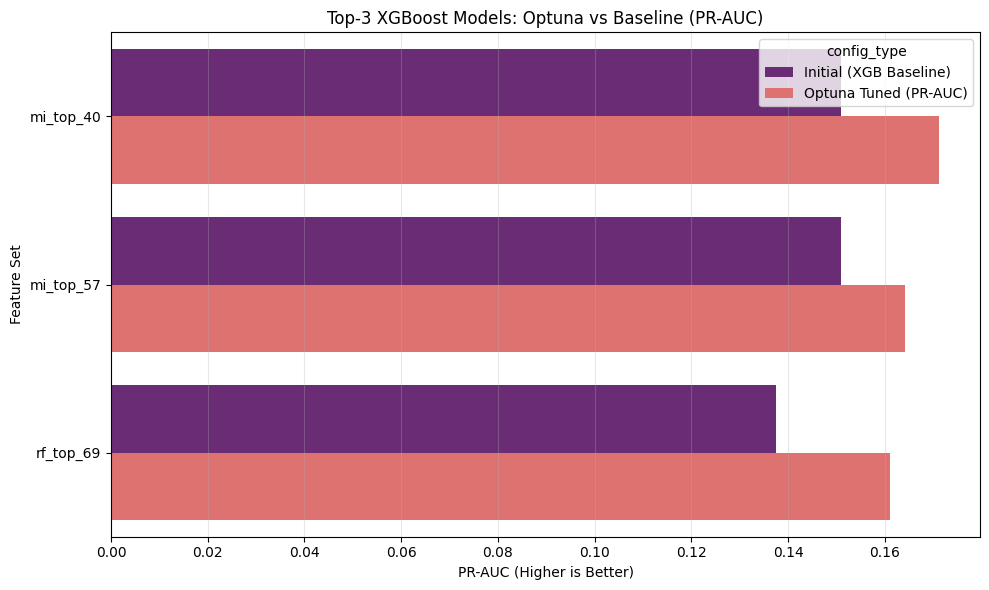

In [278]:
# Visualization
plt.figure(figsize=(10, 6))

sns.barplot(
    data=viz_df,
    x="pr_auc_val",
    y="feature_set",
    hue="config_type",
    palette="magma",
)

plt.title("Top-3 XGBoost Models: Optuna vs Baseline (PR-AUC)")
plt.xlabel("PR-AUC (Higher is Better)")
plt.ylabel("Feature Set")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


### Train and Save (XgBoost)

In [279]:
# Select TOP-3 Optuna-tuned XGBoost models by PR-AUC
fx = final_xgb_comparison.copy()

top3_xgb = (
    fx[fx["config_type"] == "Optuna Tuned (PR-AUC)"]
    .sort_values("pr_auc_val", ascending=False)
    .head(3)
    .reset_index(drop=True)
)

xgb_models_config = []

for _, r in top3_xgb.iterrows():
    fs = r["feature_set"]
    raw = r["params"]

    if isinstance(raw, dict):
        p = dict(raw)
    else:
        try:
            p = ast.literal_eval(raw)
        except Exception:
            try:
                p = json.loads(raw)
            except Exception:
                p = {}

    cleaned = {
        "learning_rate": float(p.get("learning_rate", 0.05)),
        "max_depth": int(p.get("max_depth", 4)),
        "min_child_weight": int(p.get("min_child_weight", 1)),
        "subsample": float(p.get("subsample", 0.8)),
        "colsample_bytree": float(p.get("colsample_bytree", 0.8)),
        "reg_alpha": float(p.get("reg_alpha", 0.0)),
        "reg_lambda": float(p.get("reg_lambda", 1.0)),
    }

    xgb_models_config.append({
        "name": f"xgb::{fs}",
        "feature_set": fs,
        "params": cleaned,
        "pr_auc_val": float(r["pr_auc_val"]),
        "roc_auc_val": float(r["roc_auc_score"]),
    })

print(f"XGBoost models selected: {len(xgb_models_config)}")
for c in xgb_models_config:
    print(f"- {c['name']} | PR-AUC={c['pr_auc_val']:.4f}")

# Train and save
os.makedirs("saved_models/xgboost", exist_ok=True)
_cache = {}

for cfg in xgb_models_config:
    fs = cfg["feature_set"]

    if fs not in feature_sets:
        print(f"Missing feature set {fs}, skip")
        continue

    if fs not in _cache:
        blob = feature_sets[fs]
        X_final = pd.concat([blob["train"], blob["val"]], axis=0)
        y_final = pd.concat([y_train, y_val], axis=0)
        feats = blob["train"].columns.tolist()

        pos = y_final.sum()
        neg = len(y_final) - pos
        spw = float(neg / max(pos, 1))

        _cache[fs] = (X_final, y_final, feats, spw)

    X_final, y_final, feats, spw = _cache[fs]

    clf = XGBClassifier(
        objective="binary:logistic",
        tree_method="hist",
        n_estimators=300,
        n_jobs=-1,
        verbosity=0,
        random_state=42,
        scale_pos_weight=spw,
        **cfg["params"],
    )

    print(f"Training {cfg['name']} with {len(feats)} features")
    clf.fit(X_final[feats], y_final)

    path = os.path.join(
        "saved_models/xgboost",
        cfg["name"].replace("::", "__") + ".joblib"
    )

    joblib.dump({
        "model": clf,
        "family": "xgboost",
        "model_name": cfg["name"],
        "feature_set": fs,
        "features": feats,
        "params": cfg["params"],
        "metrics": {
            "pr_auc": cfg["pr_auc_val"],
            "roc_auc": cfg["roc_auc_val"],
        },
    }, path, compress=1)

    print(f"Saved: {path}")


XGBoost models selected: 3
- xgb::mi_top_40 | PR-AUC=0.1711
- xgb::mi_top_57 | PR-AUC=0.1641
- xgb::rf_top_69 | PR-AUC=0.1611
Training xgb::mi_top_40 with 40 features


Saved: saved_models/xgboost\xgb__mi_top_40.joblib
Training xgb::mi_top_57 with 57 features
Saved: saved_models/xgboost\xgb__mi_top_57.joblib
Training xgb::rf_top_69 with 69 features
Saved: saved_models/xgboost\xgb__rf_top_69.joblib


№## LightGBM

### Baseline LightGBM

In [280]:
def train_eval_lgb_baseline(X_train, y_train, X_val, y_val):
    pos = y_train.sum()
    neg = len(y_train) - pos
    spw = neg / max(pos, 1)

    clf = LGBMClassifier(
        objective="binary",
        boosting_type="gbdt",

        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        num_leaves=8,
        min_child_samples=30,

        subsample=1.0,
        subsample_freq=0,
        colsample_bytree=1.0,

        scale_pos_weight=spw,

        n_jobs=-1,
        random_state=42,
        verbose=-1,
    )

    clf.fit(X_train, y_train)

    proba = clf.predict_proba(X_val)[:, 1]

    return {
        "roc_auc": roc_auc_score(y_val, proba),
        "pr_auc":  average_precision_score(y_val, proba),
        "config":  "true_baseline",
    }


### LightGBM with feature sets

In [281]:
lgb_results = []

for name, fs in tqdm(
    feature_sets.items(),
    desc="LightGBM – feature sets",
    total=len(feature_sets),
):
    m = train_eval_lgb_baseline(fs["train"], y_train, fs["val"], y_val)

    lgb_results.append({
        "feature_set": name,
        "n_features": fs["train"].shape[1],
        "roc_auc_val": m["roc_auc"],
        "pr_auc_val":  m["pr_auc"],
        "best_config": m["config"],
    })

lgb_results_df = (
    pd.DataFrame(lgb_results)
      .sort_values("pr_auc_val", ascending=False)
      .reset_index(drop=True)
)

display(lgb_results_df)


LightGBM – feature sets:   0%|          | 0/18 [00:00<?, ?it/s]

feature_set  n_features  roc_auc_val  pr_auc_val    best_config
0      rf_top_30          30     0.643475    0.131537  true_baseline
1      rf_top_20          20     0.648640    0.126752  true_baseline
2      rf_top_50          50     0.644058    0.126717  true_baseline
3   all_features          91     0.647972    0.125632  true_baseline
4      rf_top_40          40     0.639060    0.125344  true_baseline
5      mi_top_57          57     0.647254    0.124664  true_baseline
6      rf_top_60          60     0.647089    0.124372  true_baseline
7      mi_top_50          50     0.640634    0.123907  true_baseline
8      rf_top_69          69     0.641501    0.123594  true_baseline
9      mi_top_40          40     0.641374    0.122791  true_baseline
10     mi_top_30          30     0.637791    0.122646  true_baseline
11     mi_top_10          10     0.644588    0.119429  true_baseline
12   perm_top_12          12     0.675076    0.117644  true_baseline
13     mi_top_20          20     0.635405    0.115558  true_baseline
14    perm_top_6           6     0.660841    0.103381  true_baseline
15      rf_top_5           5     0.639306    0.084967  true_baseline
16     rf_top_10          10     0.630111    0.082689  true_baseline
17      mi_top_5           5     0.620883    0.079128  true_baseline

### Tuning Top 7 Feature Sets based on PR-AUC

In [282]:
# Take all available feature sets
lgb_fs = sorted(feature_sets.keys())
print("LightGBM feature sets:", lgb_fs)
print("Total:", len(lgb_fs))  # Should be 18


# Prepare data once per feature set
pre = {}

for fs_name in lgb_fs:
    fs = feature_sets[fs_name]

    Xtr = fs["train"].values.astype(np.float32, copy=False)
    Xva = fs["val"].values.astype(np.float32, copy=False)
    ytr = y_train.values
    yva = y_val.values

    # Compute scale_pos_weight for class imbalance
    pos = ytr.sum()
    neg = len(ytr) - pos
    spw = neg / max(pos, 1)

    pre[fs_name] = {
        "Xtr": Xtr,
        "ytr": ytr,
        "Xva": Xva,
        "yva": yva,
        "spw": spw,
        "n_features": fs["train"].shape[1],
    }

for k, v in pre.items():
    print(
        f"✔ {k}: {v['n_features']} features, "
        f"scale_pos_weight={v['spw']:.2f}"
    )

LightGBM feature sets: ['all_features', 'mi_top_10', 'mi_top_20', 'mi_top_30', 'mi_top_40', 'mi_top_5', 'mi_top_50', 'mi_top_57', 'perm_top_12', 'perm_top_6', 'rf_top_10', 'rf_top_20', 'rf_top_30', 'rf_top_40', 'rf_top_5', 'rf_top_50', 'rf_top_60', 'rf_top_69']
Total: 18
✔ all_features: 91 features, scale_pos_weight=15.70
✔ mi_top_10: 10 features, scale_pos_weight=15.70
✔ mi_top_20: 20 features, scale_pos_weight=15.70
✔ mi_top_30: 30 features, scale_pos_weight=15.70
✔ mi_top_40: 40 features, scale_pos_weight=15.70
✔ mi_top_5: 5 features, scale_pos_weight=15.70
✔ mi_top_50: 50 features, scale_pos_weight=15.70
✔ mi_top_57: 57 features, scale_pos_weight=15.70
✔ perm_top_12: 12 features, scale_pos_weight=15.70
✔ perm_top_6: 6 features, scale_pos_weight=15.70
✔ rf_top_10: 10 features, scale_pos_weight=15.70
✔ rf_top_20: 20 features, scale_pos_weight=15.70
✔ rf_top_30: 30 features, scale_pos_weight=15.70
✔ rf_top_40: 40 features, scale_pos_weight=15.70
✔ rf_top_5: 5 features, scale_pos_weigh

### Optuna PR-AUC LightGBM Tuner

In [283]:
# Optuna objective for LightGBM
# Optimizes PR-AUC, ROC-AUC is computed later
def optuna_objective_lgb(
    trial,
    Xtr, ytr,
    Xva, yva,
    spw,
):
    max_depth = trial.suggest_int("max_depth", 4, 10)

    max_leaves = min(2 ** max_depth, 256)
    num_leaves = trial.suggest_int(
        "num_leaves",
        16,
        max_leaves,
        log=True,
    )

    params = {
        "objective": "binary",
        "boosting_type": "gbdt",
        "n_jobs": -1,
        "random_state": 42,
        "verbose": -1,

        "n_estimators": 3000,
        "learning_rate": trial.suggest_float(
            "learning_rate", 0.005, 0.08, log=True
        ),

        "max_depth": max_depth,
        "num_leaves": num_leaves,

        "min_child_samples": trial.suggest_int(
            "min_child_samples", 5, 80
        ),

        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "subsample_freq": 1,
        "colsample_bytree": trial.suggest_float(
            "colsample_bytree", 0.6, 1.0
        ),

        "reg_alpha": trial.suggest_float(
            "reg_alpha", 1e-8, 10.0, log=True
        ),
        "reg_lambda": trial.suggest_float(
            "reg_lambda", 1e-8, 10.0, log=True
        ),

        "scale_pos_weight": spw,
    }

    try:
        model = LGBMClassifier(**params)

        model.fit(
            Xtr,
            ytr,
            eval_set=[(Xva, yva)],
            eval_metric="auc",
            callbacks=[
                lgb.early_stopping(
                    stopping_rounds=100,
                    verbose=False
                )
            ],
        )

        proba = model.predict_proba(Xva)[:, 1]
        return average_precision_score(yva, proba)

    except Exception:
        return 0.0

In [284]:
# Take all feature sets
lgb_fs = sorted(feature_sets.keys())
print("LightGBM feature sets:", lgb_fs)
print("Total:", len(lgb_fs))  # Should be 18

lgb_pr_results = []
lgb_studies = {}

for fs_name in tqdm(lgb_fs, desc="LightGBM PR-AUC FS", total=len(lgb_fs)):
    print(f"Tuning LightGBM for feature set: {fs_name}")

    d = pre[fs_name]
    Xtr, ytr, Xva, yva, spw = (
        d["Xtr"], d["ytr"], d["Xva"], d["yva"], d["spw"]
    )

    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=42),
    )

    study.optimize(
        lambda tr: optuna_objective_lgb(
            tr, Xtr, ytr, Xva, yva, spw
        ),
        n_trials=50,
        show_progress_bar=True,
        n_jobs=1,
    )

    lgb_studies[fs_name] = study
    best = study.best_trial

    best_clf = LGBMClassifier(
        objective="binary",
        boosting_type="gbdt",
        n_jobs=-1,
        random_state=42,
        verbose=-1,

        n_estimators=3000,
        subsample_freq=1,
        scale_pos_weight=spw,

        **best.params,
    )

    best_clf.fit(
        Xtr,
        ytr,
        eval_set=[(Xva, yva)],
        eval_metric="auc",
        callbacks=[
            lgb.early_stopping(
                stopping_rounds=100,
                verbose=False
            )
        ],
    )

    proba = best_clf.predict_proba(Xva)[:, 1]

    lgb_pr_results.append({
        "feature_set": fs_name,
        "n_features": feature_sets[fs_name]["train"].shape[1],
        "pr_auc_val": best.value,
        "roc_auc_val": roc_auc_score(yva, proba),
        "best_params": best.params,
    })

LightGBM feature sets: ['all_features', 'mi_top_10', 'mi_top_20', 'mi_top_30', 'mi_top_40', 'mi_top_5', 'mi_top_50', 'mi_top_57', 'perm_top_12', 'perm_top_6', 'rf_top_10', 'rf_top_20', 'rf_top_30', 'rf_top_40', 'rf_top_5', 'rf_top_50', 'rf_top_60', 'rf_top_69']
Total: 18


LightGBM PR-AUC FS:   0%|          | 0/18 [00:00<?, ?it/s]

[I 2026-01-15 13:11:55,580] A new study created in memory with name: no-name-5160d59e-4b70-4684-b99f-b30fe435ce10


Tuning LightGBM for feature set: all_features


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:11:56,416] Trial 0 finished with value: 0.10650159984403929 and parameters: {'max_depth': 6, 'num_leaves': 60, 'learning_rate': 0.038052091892039265, 'min_child_samples': 50, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.10650159984403929.
[I 2026-01-15 13:11:57,325] Trial 1 finished with value: 0.1218557298569929 and parameters: {'max_depth': 8, 'num_leaves': 113, 'learning_rate': 0.005293661964364217, 'min_child_samples': 78, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 1 with value: 0.1218557298569929.
[I 2026-01-15 13:11:58,140] Trial 2 finished with value: 0.12096644890956193 and parameters: {'max_depth': 6, 'num_leaves': 33, 'learning_rate': 0.016560888480945335, 'min_child_samples': 27, 'subsample': 0.8447411578889518, 'c

[I 2026-01-15 13:12:43,260] A new study created in memory with name: no-name-25602354-3b0e-498c-8e18-e9346915f875


Tuning LightGBM for feature set: mi_top_10


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:12:44,312] Trial 0 finished with value: 0.09851643259678709 and parameters: {'max_depth': 6, 'num_leaves': 60, 'learning_rate': 0.038052091892039265, 'min_child_samples': 50, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.09851643259678709.
[I 2026-01-15 13:12:45,539] Trial 1 finished with value: 0.07555318176004393 and parameters: {'max_depth': 8, 'num_leaves': 113, 'learning_rate': 0.005293661964364217, 'min_child_samples': 78, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 0 with value: 0.09851643259678709.
[I 2026-01-15 13:12:46,886] Trial 2 finished with value: 0.09275460990899487 and parameters: {'max_depth': 6, 'num_leaves': 33, 'learning_rate': 0.016560888480945335, 'min_child_samples': 27, 'subsample': 0.8447411578889518, 

[I 2026-01-15 13:13:38,837] A new study created in memory with name: no-name-b5b53a81-77c4-4abd-a59c-df5ba812da0b


Tuning LightGBM for feature set: mi_top_20


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:13:39,699] Trial 0 finished with value: 0.08395357791553783 and parameters: {'max_depth': 6, 'num_leaves': 60, 'learning_rate': 0.038052091892039265, 'min_child_samples': 50, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.08395357791553783.
[I 2026-01-15 13:13:40,752] Trial 1 finished with value: 0.11227681488067168 and parameters: {'max_depth': 8, 'num_leaves': 113, 'learning_rate': 0.005293661964364217, 'min_child_samples': 78, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 1 with value: 0.11227681488067168.
[I 2026-01-15 13:13:41,831] Trial 2 finished with value: 0.11167464643709929 and parameters: {'max_depth': 6, 'num_leaves': 33, 'learning_rate': 0.016560888480945335, 'min_child_samples': 27, 'subsample': 0.8447411578889518, 

[I 2026-01-15 13:14:25,516] A new study created in memory with name: no-name-438deb19-8f06-4b95-b644-edd0713302f1


Tuning LightGBM for feature set: mi_top_30


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:14:26,621] Trial 0 finished with value: 0.09367026366412208 and parameters: {'max_depth': 6, 'num_leaves': 60, 'learning_rate': 0.038052091892039265, 'min_child_samples': 50, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.09367026366412208.
[I 2026-01-15 13:14:27,674] Trial 1 finished with value: 0.12393934343497785 and parameters: {'max_depth': 8, 'num_leaves': 113, 'learning_rate': 0.005293661964364217, 'min_child_samples': 78, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 1 with value: 0.12393934343497785.
[I 2026-01-15 13:14:28,730] Trial 2 finished with value: 0.061005725423628594 and parameters: {'max_depth': 6, 'num_leaves': 33, 'learning_rate': 0.016560888480945335, 'min_child_samples': 27, 'subsample': 0.8447411578889518,

[I 2026-01-15 13:15:15,629] A new study created in memory with name: no-name-6c5f9c60-105a-47c0-8330-f1eb3fd2b93b


Tuning LightGBM for feature set: mi_top_40


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:15:16,538] Trial 0 finished with value: 0.10253005930425287 and parameters: {'max_depth': 6, 'num_leaves': 60, 'learning_rate': 0.038052091892039265, 'min_child_samples': 50, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.10253005930425287.
[I 2026-01-15 13:15:17,505] Trial 1 finished with value: 0.08591516875317737 and parameters: {'max_depth': 8, 'num_leaves': 113, 'learning_rate': 0.005293661964364217, 'min_child_samples': 78, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 0 with value: 0.10253005930425287.
[I 2026-01-15 13:15:18,450] Trial 2 finished with value: 0.09587916534469706 and parameters: {'max_depth': 6, 'num_leaves': 33, 'learning_rate': 0.016560888480945335, 'min_child_samples': 27, 'subsample': 0.8447411578889518, 

[I 2026-01-15 13:16:02,093] A new study created in memory with name: no-name-ef1b4e18-7206-474b-87b6-e2cc95096a15


Tuning LightGBM for feature set: mi_top_5


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:16:02,817] Trial 0 finished with value: 0.06114214295379628 and parameters: {'max_depth': 6, 'num_leaves': 60, 'learning_rate': 0.038052091892039265, 'min_child_samples': 50, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.06114214295379628.
[I 2026-01-15 13:16:03,805] Trial 1 finished with value: 0.07737411079692903 and parameters: {'max_depth': 8, 'num_leaves': 113, 'learning_rate': 0.005293661964364217, 'min_child_samples': 78, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 1 with value: 0.07737411079692903.
[I 2026-01-15 13:16:04,492] Trial 2 finished with value: 0.05792708621257053 and parameters: {'max_depth': 6, 'num_leaves': 33, 'learning_rate': 0.016560888480945335, 'min_child_samples': 27, 'subsample': 0.8447411578889518, 

[I 2026-01-15 13:16:42,988] A new study created in memory with name: no-name-d08fe1ea-62fa-4292-a982-3461b4455221


Tuning LightGBM for feature set: mi_top_50


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:16:44,032] Trial 0 finished with value: 0.1011261166846801 and parameters: {'max_depth': 6, 'num_leaves': 60, 'learning_rate': 0.038052091892039265, 'min_child_samples': 50, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.1011261166846801.
[I 2026-01-15 13:16:44,795] Trial 1 finished with value: 0.11711591419332908 and parameters: {'max_depth': 8, 'num_leaves': 113, 'learning_rate': 0.005293661964364217, 'min_child_samples': 78, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 1 with value: 0.11711591419332908.
[I 2026-01-15 13:16:45,486] Trial 2 finished with value: 0.1312779303227784 and parameters: {'max_depth': 6, 'num_leaves': 33, 'learning_rate': 0.016560888480945335, 'min_child_samples': 27, 'subsample': 0.8447411578889518, 'co

[I 2026-01-15 13:17:40,675] A new study created in memory with name: no-name-cd75b12f-bb0c-4301-bbc7-d7741335bee1


Tuning LightGBM for feature set: mi_top_57


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:17:41,435] Trial 0 finished with value: 0.093886678318999 and parameters: {'max_depth': 6, 'num_leaves': 60, 'learning_rate': 0.038052091892039265, 'min_child_samples': 50, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.093886678318999.
[I 2026-01-15 13:17:42,335] Trial 1 finished with value: 0.12421154607202256 and parameters: {'max_depth': 8, 'num_leaves': 113, 'learning_rate': 0.005293661964364217, 'min_child_samples': 78, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 1 with value: 0.12421154607202256.
[I 2026-01-15 13:17:43,119] Trial 2 finished with value: 0.107574690080354 and parameters: {'max_depth': 6, 'num_leaves': 33, 'learning_rate': 0.016560888480945335, 'min_child_samples': 27, 'subsample': 0.8447411578889518, 'colsa

[I 2026-01-15 13:18:34,114] A new study created in memory with name: no-name-0179b70b-3063-4ead-b2c9-af26a64fd140


Tuning LightGBM for feature set: perm_top_12


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:18:35,362] Trial 0 finished with value: 0.08293582446042184 and parameters: {'max_depth': 6, 'num_leaves': 60, 'learning_rate': 0.038052091892039265, 'min_child_samples': 50, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.08293582446042184.
[I 2026-01-15 13:18:36,540] Trial 1 finished with value: 0.09525908028840929 and parameters: {'max_depth': 8, 'num_leaves': 113, 'learning_rate': 0.005293661964364217, 'min_child_samples': 78, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 1 with value: 0.09525908028840929.
[I 2026-01-15 13:18:37,280] Trial 2 finished with value: 0.08745945675466431 and parameters: {'max_depth': 6, 'num_leaves': 33, 'learning_rate': 0.016560888480945335, 'min_child_samples': 27, 'subsample': 0.8447411578889518, 

[I 2026-01-15 13:19:22,213] A new study created in memory with name: no-name-12153c18-2d08-44fc-8a1e-1018902b4bbd


Tuning LightGBM for feature set: perm_top_6


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:19:23,159] Trial 0 finished with value: 0.07963682012073103 and parameters: {'max_depth': 6, 'num_leaves': 60, 'learning_rate': 0.038052091892039265, 'min_child_samples': 50, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.07963682012073103.
[I 2026-01-15 13:19:24,074] Trial 1 finished with value: 0.10955064319037977 and parameters: {'max_depth': 8, 'num_leaves': 113, 'learning_rate': 0.005293661964364217, 'min_child_samples': 78, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 1 with value: 0.10955064319037977.
[I 2026-01-15 13:19:25,039] Trial 2 finished with value: 0.08309028264740391 and parameters: {'max_depth': 6, 'num_leaves': 33, 'learning_rate': 0.016560888480945335, 'min_child_samples': 27, 'subsample': 0.8447411578889518, 

[I 2026-01-15 13:20:15,960] A new study created in memory with name: no-name-63d591ac-fbb6-4f52-b92d-7429a1eede55


Tuning LightGBM for feature set: rf_top_10


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:20:16,680] Trial 0 finished with value: 0.07565102922017347 and parameters: {'max_depth': 6, 'num_leaves': 60, 'learning_rate': 0.038052091892039265, 'min_child_samples': 50, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.07565102922017347.
[I 2026-01-15 13:20:17,455] Trial 1 finished with value: 0.07442773953122007 and parameters: {'max_depth': 8, 'num_leaves': 113, 'learning_rate': 0.005293661964364217, 'min_child_samples': 78, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 0 with value: 0.07565102922017347.
[I 2026-01-15 13:20:18,186] Trial 2 finished with value: 0.08259870354091628 and parameters: {'max_depth': 6, 'num_leaves': 33, 'learning_rate': 0.016560888480945335, 'min_child_samples': 27, 'subsample': 0.8447411578889518, 

[I 2026-01-15 13:21:08,911] A new study created in memory with name: no-name-14f1d069-b388-4954-b295-d179291fa8d7


Tuning LightGBM for feature set: rf_top_20


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:21:09,796] Trial 0 finished with value: 0.09981436536509182 and parameters: {'max_depth': 6, 'num_leaves': 60, 'learning_rate': 0.038052091892039265, 'min_child_samples': 50, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.09981436536509182.
[I 2026-01-15 13:21:10,950] Trial 1 finished with value: 0.11815213559269387 and parameters: {'max_depth': 8, 'num_leaves': 113, 'learning_rate': 0.005293661964364217, 'min_child_samples': 78, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 1 with value: 0.11815213559269387.
[I 2026-01-15 13:21:11,946] Trial 2 finished with value: 0.10278876701867606 and parameters: {'max_depth': 6, 'num_leaves': 33, 'learning_rate': 0.016560888480945335, 'min_child_samples': 27, 'subsample': 0.8447411578889518, 

[I 2026-01-15 13:21:59,881] A new study created in memory with name: no-name-c5581ad9-1957-4159-8380-40ac894ea42c


Tuning LightGBM for feature set: rf_top_30


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:22:00,719] Trial 0 finished with value: 0.09768188344014646 and parameters: {'max_depth': 6, 'num_leaves': 60, 'learning_rate': 0.038052091892039265, 'min_child_samples': 50, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.09768188344014646.
[I 2026-01-15 13:22:01,723] Trial 1 finished with value: 0.10728154177830548 and parameters: {'max_depth': 8, 'num_leaves': 113, 'learning_rate': 0.005293661964364217, 'min_child_samples': 78, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 1 with value: 0.10728154177830548.
[I 2026-01-15 13:22:02,511] Trial 2 finished with value: 0.09750587442712681 and parameters: {'max_depth': 6, 'num_leaves': 33, 'learning_rate': 0.016560888480945335, 'min_child_samples': 27, 'subsample': 0.8447411578889518, 

[I 2026-01-15 13:22:48,542] A new study created in memory with name: no-name-97fcfa04-d25f-4cfc-89c6-4a6cd23e248c


Tuning LightGBM for feature set: rf_top_40


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:22:49,489] Trial 0 finished with value: 0.1011261166846801 and parameters: {'max_depth': 6, 'num_leaves': 60, 'learning_rate': 0.038052091892039265, 'min_child_samples': 50, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.1011261166846801.
[I 2026-01-15 13:22:50,472] Trial 1 finished with value: 0.13904718028512125 and parameters: {'max_depth': 8, 'num_leaves': 113, 'learning_rate': 0.005293661964364217, 'min_child_samples': 78, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 1 with value: 0.13904718028512125.
[I 2026-01-15 13:22:51,689] Trial 2 finished with value: 0.10343669134857854 and parameters: {'max_depth': 6, 'num_leaves': 33, 'learning_rate': 0.016560888480945335, 'min_child_samples': 27, 'subsample': 0.8447411578889518, 'c

[I 2026-01-15 13:23:47,401] A new study created in memory with name: no-name-e171d5f2-baaa-4787-9076-f8e53b0fb9f4


Tuning LightGBM for feature set: rf_top_5


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:23:48,551] Trial 0 finished with value: 0.06114214295379628 and parameters: {'max_depth': 6, 'num_leaves': 60, 'learning_rate': 0.038052091892039265, 'min_child_samples': 50, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.06114214295379628.
[I 2026-01-15 13:23:49,343] Trial 1 finished with value: 0.08232877840102765 and parameters: {'max_depth': 8, 'num_leaves': 113, 'learning_rate': 0.005293661964364217, 'min_child_samples': 78, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 1 with value: 0.08232877840102765.
[I 2026-01-15 13:23:50,028] Trial 2 finished with value: 0.07492000771960627 and parameters: {'max_depth': 6, 'num_leaves': 33, 'learning_rate': 0.016560888480945335, 'min_child_samples': 27, 'subsample': 0.8447411578889518, 

[I 2026-01-15 13:24:35,410] A new study created in memory with name: no-name-4633b999-bdea-4b50-9430-1ea19d7b2170


Tuning LightGBM for feature set: rf_top_50


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:24:36,400] Trial 0 finished with value: 0.1011261166846801 and parameters: {'max_depth': 6, 'num_leaves': 60, 'learning_rate': 0.038052091892039265, 'min_child_samples': 50, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.1011261166846801.
[I 2026-01-15 13:24:37,519] Trial 1 finished with value: 0.11689881348106848 and parameters: {'max_depth': 8, 'num_leaves': 113, 'learning_rate': 0.005293661964364217, 'min_child_samples': 78, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 1 with value: 0.11689881348106848.
[I 2026-01-15 13:24:38,633] Trial 2 finished with value: 0.09772807496970654 and parameters: {'max_depth': 6, 'num_leaves': 33, 'learning_rate': 0.016560888480945335, 'min_child_samples': 27, 'subsample': 0.8447411578889518, 'c

[I 2026-01-15 13:25:30,220] A new study created in memory with name: no-name-4c8c0207-7c6a-446a-b03b-52625011ef09


Tuning LightGBM for feature set: rf_top_60


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:25:31,619] Trial 0 finished with value: 0.06703104881793388 and parameters: {'max_depth': 6, 'num_leaves': 60, 'learning_rate': 0.038052091892039265, 'min_child_samples': 50, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.06703104881793388.
[I 2026-01-15 13:25:32,946] Trial 1 finished with value: 0.11297141132333133 and parameters: {'max_depth': 8, 'num_leaves': 113, 'learning_rate': 0.005293661964364217, 'min_child_samples': 78, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 1 with value: 0.11297141132333133.
[I 2026-01-15 13:25:33,883] Trial 2 finished with value: 0.09714746892166247 and parameters: {'max_depth': 6, 'num_leaves': 33, 'learning_rate': 0.016560888480945335, 'min_child_samples': 27, 'subsample': 0.8447411578889518, 

[I 2026-01-15 13:26:22,453] A new study created in memory with name: no-name-3c7ec1e0-9e49-4241-9811-8803933a1aa0


Tuning LightGBM for feature set: rf_top_69


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:26:23,584] Trial 0 finished with value: 0.10257835156937505 and parameters: {'max_depth': 6, 'num_leaves': 60, 'learning_rate': 0.038052091892039265, 'min_child_samples': 50, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.10257835156937505.
[I 2026-01-15 13:26:24,517] Trial 1 finished with value: 0.1357740024627709 and parameters: {'max_depth': 8, 'num_leaves': 113, 'learning_rate': 0.005293661964364217, 'min_child_samples': 78, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 1 with value: 0.1357740024627709.
[I 2026-01-15 13:26:25,221] Trial 2 finished with value: 0.10329348548584671 and parameters: {'max_depth': 6, 'num_leaves': 33, 'learning_rate': 0.016560888480945335, 'min_child_samples': 27, 'subsample': 0.8447411578889518, 'c

№## Comparison For LightGBM: Baseline vs Optuna

In [286]:
# Convert your Optuna results list into a DataFrame
lgb_pr_results_df = pd.DataFrame(lgb_pr_results)

# Prepare baseline LightGBM results
initial_lgb = lgb_results_df.copy()

initial_lgb["config_type"] = "Initial (LGB Baseline)"

# Store baseline parameters as dict for consistency
initial_lgb["params"] = [{
    "n_estimators": 300,
    "learning_rate": 0.05,
    "max_depth": 5,
    "subsample": 0.8,
    "subsample_freq": 1,
    "colsample_bytree": 0.8,
    "boosting_type": "gbdt",
    "scale_pos_weight": "auto",
}] * len(initial_lgb)


# Prepare Optuna-tuned LightGBM results
tuned_lgb = lgb_pr_results_df.copy()

tuned_lgb["config_type"] = "Optuna Tuned (PR-AUC)"
tuned_lgb.rename(columns={"best_params": "params"}, inplace=True)


# Combine baseline and Optuna results (36 models total)
final_lgb_comparison = (
    pd.concat([tuned_lgb, initial_lgb], ignore_index=True)
      .sort_values(
          by=["pr_auc_val", "feature_set"],
          ascending=[False, True]
      )
      .reset_index(drop=True)
)

print("Final LightGBM Leaderboard (ranked by PR-AUC)")
display(final_lgb_comparison[[
    "feature_set",
    "config_type",
    "pr_auc_val",
    "roc_auc_val",
    "params",
]])

Final LightGBM Leaderboard (ranked by PR-AUC)


feature_set             config_type  pr_auc_val  roc_auc_val  \
0      mi_top_57   Optuna Tuned (PR-AUC)    0.160533     0.683395   
1      rf_top_40   Optuna Tuned (PR-AUC)    0.157491     0.695407   
2   all_features   Optuna Tuned (PR-AUC)    0.155563     0.700555   
3      rf_top_69   Optuna Tuned (PR-AUC)    0.153672     0.663108   
4      mi_top_50   Optuna Tuned (PR-AUC)    0.149714     0.701930   
5      rf_top_60   Optuna Tuned (PR-AUC)    0.143573     0.701574   
6      rf_top_30   Optuna Tuned (PR-AUC)    0.143524     0.687778   
7      mi_top_40   Optuna Tuned (PR-AUC)    0.140475     0.680165   
8      rf_top_20   Optuna Tuned (PR-AUC)    0.137503     0.699029   
9      mi_top_20   Optuna Tuned (PR-AUC)    0.136156     0.654737   
10     rf_top_50   Optuna Tuned (PR-AUC)    0.134760     0.680948   
11     mi_top_30   Optuna Tuned (PR-AUC)    0.134107     0.645427   
12     rf_top_30  Initial (LGB Baseline)    0.131537     0.643475   
13     rf_top_20  Initial (LGB Baseline)    0.126752     0.648640   
14     rf_top_50  Initial (LGB Baseline)    0.126717     0.644058   
15  all_features  Initial (LGB Baseline)    0.125632     0.647972   
16     rf_top_40  Initial (LGB Baseline)    0.125344     0.639060   
17     mi_top_57  Initial (LGB Baseline)    0.124664     0.647254   
18     rf_top_60  Initial (LGB Baseline)    0.124372     0.647089   
19     mi_top_50  Initial (LGB Baseline)    0.123907     0.640634   
20     rf_top_69  Initial (LGB Baseline)    0.123594     0.641501   
21     mi_top_40  Initial (LGB Baseline)    0.122791     0.641374   
22     mi_top_30  Initial (LGB Baseline)    0.122646     0.637791   
23     mi_top_10  Initial (LGB Baseline)    0.119429     0.644588   
24   perm_top_12  Initial (LGB Baseline)    0.117644     0.675076   
25    perm_top_6   Optuna Tuned (PR-AUC)    0.116084     0.660687   
26     mi_top_20  Initial (LGB Baseline)    0.115558     0.635405   
27   perm_top_12   Optuna Tuned (PR-AUC)    0.112453     0.665158   
28     mi_top_10   Optuna Tuned (PR-AUC)    0.104825     0.647705   
29    perm_top_6  Initial (LGB Baseline)    0.103381     0.660841   
30     rf_top_10   Optuna Tuned (PR-AUC)    0.102323     0.645906   
31      rf_top_5   Optuna Tuned (PR-AUC)    0.096002     0.667723   
32      rf_top_5  Initial (LGB Baseline)    0.084967     0.639306   
33      mi_top_5   Optuna Tuned (PR-AUC)    0.083970     0.644906   
34     rf_top_10  Initial (LGB Baseline)    0.082689     0.630111   
35      mi_top_5  Initial (LGB Baseline)    0.079128     0.620883   

                                                                                                                                                                                                                                                      params  
0        {'max_depth': 8, 'num_leaves': 45, 'learning_rate': 0.0071679632125232, 'min_child_samples': 16, 'subsample': 0.7657724769815869, 'colsample_bytree': 0.6400540770073654, 'reg_alpha': 0.0018044480358258303, 'reg_lambda': 1.6164201035758062e-07}  
1     {'max_depth': 10, 'num_leaves': 80, 'learning_rate': 0.0055258787840800315, 'min_child_samples': 39, 'subsample': 0.6589045438667185, 'colsample_bytree': 0.859808869935063, 'reg_alpha': 9.776379135072488e-07, 'reg_lambda': 2.0409794304671907e-08}  
2        {'max_depth': 10, 'num_leaves': 53, 'learning_rate': 0.005045644302086374, 'min_child_samples': 13, 'subsample': 0.7703777260933239, 'colsample_bytree': 0.753196357483992, 'reg_alpha': 1.067098050760308e-05, 'reg_lambda': 0.043600614896359184}  
3   {'max_depth': 10, 'num_leaves': 190, 'learning_rate': 0.007148934057909833, 'min_child_samples': 37, 'subsample': 0.9085745502421775, 'colsample_bytree': 0.7317904605232353, 'reg_alpha': 0.00011225529773874799, 'reg_lambda': 1.6557409028951677e-07}  
4       {'max_depth': 8, 'num_leaves': 77, 'learning_rate': 0.007520999537357352, 'min_child_samples': 12, 'subsample': 0.8499077433758349, 'colsample_bytree': 0.73122025149972

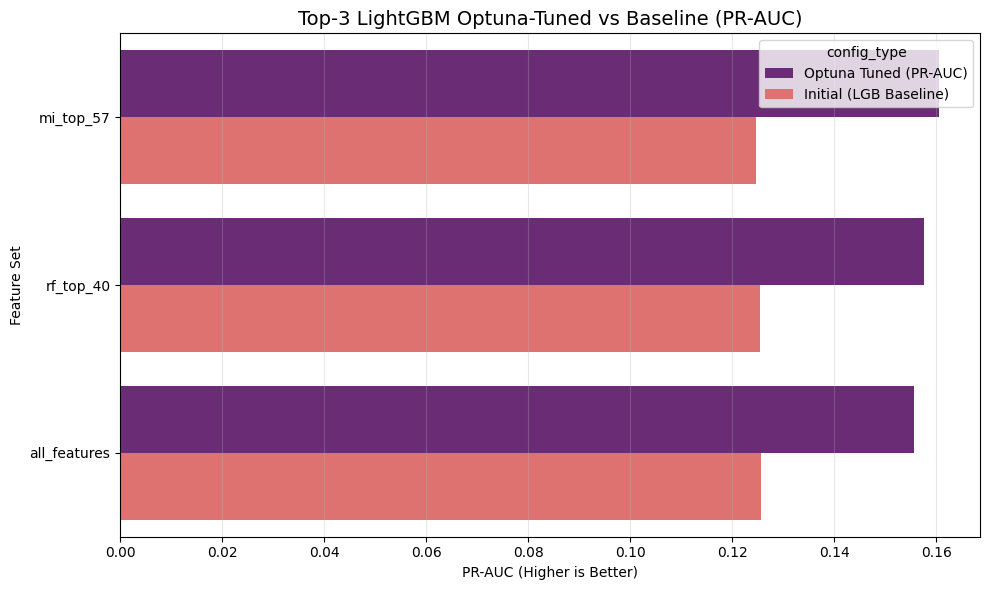

In [287]:
# Take a copy of final leaderboard
fl = final_lgb_comparison.copy()

# Filter only Optuna-tuned models
tuned_lgb = fl[fl["config_type"] == "Optuna Tuned (PR-AUC)"]

# Take top 3 PR-AUC winners
top3_lgb = tuned_lgb.sort_values("pr_auc_val", ascending=False).head(3)

# Include the corresponding baseline models for the same feature sets
baseline_lgb = fl[
    (fl["config_type"] == "Initial (LGB Baseline)") &
    (fl["feature_set"].isin(top3_lgb["feature_set"]))
]

# Combine top3 tuned + baseline for visualization
viz_lgb = pd.concat([top3_lgb, baseline_lgb], ignore_index=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=viz_lgb,
    x="pr_auc_val",
    y="feature_set",
    hue="config_type",
    palette="magma",
)
plt.title("Top-3 LightGBM Optuna-Tuned vs Baseline (PR-AUC)", fontsize=14)
plt.xlabel("PR-AUC (Higher is Better)")
plt.ylabel("Feature Set")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


### Train and Save (LightGBM)

In [289]:
import os
import joblib
import json
import ast
from lightgbm import LGBMClassifier

# Copy the final LGB leaderboard
fl = final_lgb_comparison.copy()

# Filter only Optuna-tuned models
tuned_l = fl[fl["config_type"] == "Optuna Tuned (PR-AUC)"]

# Take top 3 by PR-AUC
rows_l = tuned_l.sort_values("pr_auc_val", ascending=False).head(3)

# Build configuration list
lgb_models_config = []
for _, r in rows_l.iterrows():
    fs = r["feature_set"]
    raw = r["params"]

    if isinstance(raw, dict):
        p = dict(raw)
    else:
        try:
            p = ast.literal_eval(raw)
        except Exception:
            try:
                p = json.loads(raw)
            except Exception:
                p = {}

    cleaned = {}
    if "learning_rate" in p:      cleaned["learning_rate"]      = float(p["learning_rate"])
    if "max_depth" in p:          cleaned["max_depth"]          = int(p["max_depth"])
    if "num_leaves" in p:         cleaned["num_leaves"]         = int(p["num_leaves"])
    if "min_child_samples" in p:  cleaned["min_child_samples"]  = int(p["min_child_samples"])
    if "subsample" in p:          cleaned["subsample"]          = float(p["subsample"])
    if "colsample_bytree" in p:   cleaned["colsample_bytree"]   = float(p["colsample_bytree"])
    if "reg_alpha" in p:          cleaned["reg_alpha"]          = float(p["reg_alpha"])
    if "reg_lambda" in p:         cleaned["reg_lambda"]         = float(p["reg_lambda"])

    # Set defaults if missing
    cleaned.setdefault("learning_rate", 0.05)
    cleaned.setdefault("max_depth", 5)
    cleaned.setdefault("num_leaves", 31)
    cleaned.setdefault("min_child_samples", 20)
    cleaned.setdefault("subsample", 0.8)
    cleaned.setdefault("colsample_bytree", 0.8)
    cleaned.setdefault("reg_alpha", 0.0)
    cleaned.setdefault("reg_lambda", 1.0)

    lgb_models_config.append({
        "name": f"lgb::{fs}",
        "feature_set": fs,
        "params": cleaned,
        "pr_auc_val": float(r["pr_auc_val"]),
        "roc_auc_val": float(r["roc_auc_val"]),
    })

print(f"Top 3 LightGBM PR-AUC winners: {len(lgb_models_config)}")
for c in lgb_models_config:
    print(f" - {c['name']} → {c['params']}")

# Train and save models
os.makedirs("saved_models/lightgbm", exist_ok=True)
_cache = {}

for cfg in lgb_models_config:
    fs = cfg["feature_set"]
    if fs not in feature_sets:
        print(f"Missing feature set '{fs}' — skip.")
        continue

    if fs not in _cache:
        blob = feature_sets[fs]
        X_final = pd.concat([blob["train"], blob["val"]], axis=0)
        y_final = pd.concat([y_train, y_val], axis=0)
        feats = blob["train"].columns.tolist()

        pos = y_final.sum()
        neg = len(y_final) - pos
        spw = float(neg / max(pos, 1))

        _cache[fs] = (X_final, y_final, feats, spw)

    X_final, y_final, feats, spw = _cache[fs]
    p = cfg["params"]

    clf = LGBMClassifier(
        objective="binary",
        boosting_type="gbdt",
        n_estimators=800,
        subsample_freq=1,
        n_jobs=-1,
        random_state=42,
        verbose=-1,
        scale_pos_weight=spw,
        **p,
    )

    print(f"Training {cfg['name']} with {len(feats)} features")
    clf.fit(X_final[feats], y_final)

    safe_name = cfg["name"].replace("::", "__")
    path = os.path.join("saved_models/lightgbm", f"{safe_name}.joblib")

    joblib.dump({
        "model": clf,
        "family": "lightgbm",
        "model_name": cfg["name"],
        "feature_set": fs,
        "features": feats,
        "params": p,
        "metrics": {
            "pr_auc": cfg["pr_auc_val"],
            "roc_auc": cfg["roc_auc_val"],
        },
    }, path, compress=1)

    print(f"Saved: {path}")


Top 3 LightGBM PR-AUC winners: 3
 - lgb::mi_top_57 → {'learning_rate': 0.0071679632125232, 'max_depth': 8, 'num_leaves': 45, 'min_child_samples': 16, 'subsample': 0.7657724769815869, 'colsample_bytree': 0.6400540770073654, 'reg_alpha': 0.0018044480358258303, 'reg_lambda': 1.6164201035758062e-07}
 - lgb::rf_top_40 → {'learning_rate': 0.0055258787840800315, 'max_depth': 10, 'num_leaves': 80, 'min_child_samples': 39, 'subsample': 0.6589045438667185, 'colsample_bytree': 0.859808869935063, 'reg_alpha': 9.776379135072488e-07, 'reg_lambda': 2.0409794304671907e-08}
 - lgb::all_features → {'learning_rate': 0.005045644302086374, 'max_depth': 10, 'num_leaves': 53, 'min_child_samples': 13, 'subsample': 0.7703777260933239, 'colsample_bytree': 0.753196357483992, 'reg_alpha': 1.067098050760308e-05, 'reg_lambda': 0.043600614896359184}
Training lgb::mi_top_57 with 57 features
Saved: saved_models/lightgbm\lgb__mi_top_57.joblib
Training lgb::rf_top_40 with 40 features
Saved: saved_models/lightgbm\lgb__rf

№## CatBoost

### Baseline CatBoost

In [290]:
def train_eval_cat_baseline(
    X_train, y_train,
    X_val, y_val,
    cat_features=None,  # list of column indices or names
):

    clf = CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="PRAUC",

        iterations=200,
        learning_rate=0.1,
        depth=3,
        min_data_in_leaf=30,

        auto_class_weights="Balanced",

        bootstrap_type="No",
        random_seed=42,

        verbose=False,
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        cat_features=cat_features,
        verbose=False,
    )

    proba = clf.predict_proba(X_val)[:, 1]

    return {
        "roc_auc": roc_auc_score(y_val, proba),
        "pr_auc":  average_precision_score(y_val, proba),
        "config":  "true_baseline",
    }


### CatBoost with feature sets

In [291]:
cat_results = []

for name, fs in tqdm(
    feature_sets.items(),
    desc="CatBoost – feature sets",
    total=len(feature_sets),
):
    m = train_eval_cat_baseline(
        fs["train"], y_train,
        fs["val"],   y_val
    )

    cat_results.append({
        "feature_set": name,
        "n_features": fs["train"].shape[1],
        "roc_auc_val": m["roc_auc"],
        "pr_auc_val":  m["pr_auc"],
        "best_config": m["config"],
    })

cat_results_df = (
    pd.DataFrame(cat_results)
      .sort_values("pr_auc_val", ascending=False)
      .reset_index(drop=True)
)

display(cat_results_df)


CatBoost – feature sets:   0%|          | 0/18 [00:00<?, ?it/s]

feature_set  n_features  roc_auc_val  pr_auc_val    best_config
0     perm_top_6           6     0.675227    0.117577  true_baseline
1   all_features          91     0.667680    0.112085  true_baseline
2      rf_top_40          40     0.652305    0.098579  true_baseline
3      mi_top_40          40     0.652305    0.098579  true_baseline
4      rf_top_10          10     0.654765    0.095560  true_baseline
5      rf_top_60          60     0.648436    0.093929  true_baseline
6    perm_top_12          12     0.645770    0.084629  true_baseline
7      mi_top_50          50     0.638162    0.082074  true_baseline
8      mi_top_20          20     0.619009    0.078189  true_baseline
9      rf_top_20          20     0.614007    0.076525  true_baseline
10     rf_top_50          50     0.611008    0.076076  true_baseline
11      rf_top_5           5     0.611008    0.076076  true_baseline
12     mi_top_57          57     0.611008    0.076076  true_baseline
13     mi_top_30          30     0.611008    0.076076  true_baseline
14      mi_top_5           5     0.611008    0.076076  true_baseline
15     rf_top_69          69     0.605138    0.075271  true_baseline
16     mi_top_10          10     0.605138    0.075271  true_baseline
17     rf_top_30          30     0.603835    0.074701  true_baseline

### Tuning Top 7 Feature Sets based on PR-AUC

In [292]:
# Take all available feature sets
cat_fs = sorted(feature_sets.keys())
print("CatBoost feature sets:", cat_fs)
print("Total:", len(cat_fs))  # Should be 18


# Prepare data for CatBoost
cat_pre = {}

for fs_name in cat_fs:
    fs = feature_sets[fs_name]

    Xtr = fs["train"]
    Xva = fs["val"]

    ytr = y_train.values
    yva = y_val.values

    cat_pre[fs_name] = {
        "Xtr": Xtr,
        "ytr": ytr,
        "Xva": Xva,
        "yva": yva,
        "n_features": Xtr.shape[1],
        "feature_names": list(Xtr.columns),
    }

for k, v in cat_pre.items():
    print(f"✔ {k}: {v['n_features']} features")


CatBoost feature sets: ['all_features', 'mi_top_10', 'mi_top_20', 'mi_top_30', 'mi_top_40', 'mi_top_5', 'mi_top_50', 'mi_top_57', 'perm_top_12', 'perm_top_6', 'rf_top_10', 'rf_top_20', 'rf_top_30', 'rf_top_40', 'rf_top_5', 'rf_top_50', 'rf_top_60', 'rf_top_69']
Total: 18
✔ all_features: 91 features
✔ mi_top_10: 10 features
✔ mi_top_20: 20 features
✔ mi_top_30: 30 features
✔ mi_top_40: 40 features
✔ mi_top_5: 5 features
✔ mi_top_50: 50 features
✔ mi_top_57: 57 features
✔ perm_top_12: 12 features
✔ perm_top_6: 6 features
✔ rf_top_10: 10 features
✔ rf_top_20: 20 features
✔ rf_top_30: 30 features
✔ rf_top_40: 40 features
✔ rf_top_5: 5 features
✔ rf_top_50: 50 features
✔ rf_top_60: 60 features
✔ rf_top_69: 69 features


### Optuna PR-AUC CatBoost Tuner

In [293]:
# Optuna objective for CatBoost
# Optimizes PR-AUC, ROC-AUC is computed later
def optuna_objective_cat(
    trial,
    Xtr, ytr,
    Xva, yva,
    cat_features=None,
):
    params = {
        "loss_function": "Logloss",
        "eval_metric": "PRAUC",

        "iterations": 3000,
        "learning_rate": trial.suggest_float(
            "learning_rate", 0.005, 0.2, log=True
        ),
        "depth": trial.suggest_int(
            "depth", 4, 10
        ),

        "min_data_in_leaf": trial.suggest_int(
            "min_data_in_leaf", 5, 100
        ),

        "l2_leaf_reg": trial.suggest_float(
            "l2_leaf_reg", 1e-8, 10.0, log=True
        ),

        "auto_class_weights": "Balanced",

        "bootstrap_type": "No",
        "random_seed": 42,
        "verbose": False,
    }

    try:
        model = CatBoostClassifier(**params)

        model.fit(
            Xtr,
            ytr,
            eval_set=(Xva, yva),
            cat_features=cat_features,
            early_stopping_rounds=100,
            verbose=False,
        )

        proba = model.predict_proba(Xva)[:, 1]
        return average_precision_score(yva, proba)

    except Exception:
        return 0.0

In [294]:
# Take all available feature sets
cat_fs = sorted(feature_sets.keys())
print("CatBoost feature sets:", cat_fs)
print("Total:", len(cat_fs))  # Should be 18

cat_pr_results = []
cat_studies = {}

for fs_name in tqdm(cat_fs, desc="CatBoost PR-AUC FS", total=len(cat_fs)):
    print(f"Tuning CatBoost for feature set: {fs_name}")

    d = cat_pre[fs_name]
    Xtr, ytr = d["Xtr"], d["ytr"]
    Xva, yva = d["Xva"], d["yva"]

    # Detect categorical features automatically
    cat_cols = list(
        Xtr.select_dtypes(include=["object", "category"]).columns
    )
    cat_cols = cat_cols if len(cat_cols) > 0 else None

    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=42),
    )

    study.optimize(
        lambda tr: optuna_objective_cat(
            tr,
            Xtr, ytr,
            Xva, yva,
            cat_features=cat_cols,
        ),
        n_trials=50,
        show_progress_bar=True,
        n_jobs=1,
    )

    cat_studies[fs_name] = study
    best = study.best_trial

    best_clf = CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="PRAUC",

        iterations=3000,
        auto_class_weights="Balanced",
        bootstrap_type="No",
        random_seed=42,
        verbose=False,

        **best.params,
    )

    best_clf.fit(
        Xtr,
        ytr,
        eval_set=(Xva, yva),
        cat_features=cat_cols,
        early_stopping_rounds=100,
        verbose=False,
    )

    proba = best_clf.predict_proba(Xva)[:, 1]

    cat_pr_results.append({
        "feature_set": fs_name,
        "n_features": d["n_features"],
        "n_cat_features": 0 if cat_cols is None else len(cat_cols),
        "pr_auc_val": best.value,
        "roc_auc_val": roc_auc_score(yva, proba),
        "best_params": best.params,
    })

CatBoost feature sets: ['all_features', 'mi_top_10', 'mi_top_20', 'mi_top_30', 'mi_top_40', 'mi_top_5', 'mi_top_50', 'mi_top_57', 'perm_top_12', 'perm_top_6', 'rf_top_10', 'rf_top_20', 'rf_top_30', 'rf_top_40', 'rf_top_5', 'rf_top_50', 'rf_top_60', 'rf_top_69']
Total: 18


CatBoost PR-AUC FS:   0%|          | 0/18 [00:00<?, ?it/s]

[I 2026-01-15 13:33:03,041] A new study created in memory with name: no-name-1531d654-cca1-4ff0-8631-0f0b5d0382d2


Tuning CatBoost for feature set: all_features


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:33:04,972] Trial 0 finished with value: 0.12070378563334988 and parameters: {'learning_rate': 0.019906996673933378, 'depth': 10, 'min_data_in_leaf': 75, 'l2_leaf_reg': 0.0024430162614261413}. Best is trial 0 with value: 0.12070378563334988.
[I 2026-01-15 13:33:05,595] Trial 1 finished with value: 0.07571865740884728 and parameters: {'learning_rate': 0.00889039845957559, 'depth': 5, 'min_data_in_leaf': 10, 'l2_leaf_reg': 0.6245760287469893}. Best is trial 0 with value: 0.12070378563334988.
[I 2026-01-15 13:33:06,587] Trial 2 finished with value: 0.13892760422235964 and parameters: {'learning_rate': 0.045918988705873284, 'depth': 8, 'min_data_in_leaf': 6, 'l2_leaf_reg': 5.360294728728285}. Best is trial 2 with value: 0.13892760422235964.
[I 2026-01-15 13:33:08,349] Trial 3 finished with value: 0.13560984916375124 and parameters: {'learning_rate': 0.10779361932748845, 'depth': 5, 'min_data_in_leaf': 22, 'l2_leaf_reg': 4.4734294104626844e-07}. Best is trial 2 with value: 0

[I 2026-01-15 13:34:28,232] A new study created in memory with name: no-name-2ab88823-6cce-49c8-b107-0338c71a0946


Tuning CatBoost for feature set: mi_top_10


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:34:29,000] Trial 0 finished with value: 0.1253258188699008 and parameters: {'learning_rate': 0.019906996673933378, 'depth': 10, 'min_data_in_leaf': 75, 'l2_leaf_reg': 0.0024430162614261413}. Best is trial 0 with value: 0.1253258188699008.
[I 2026-01-15 13:34:29,587] Trial 1 finished with value: 0.13182113949704108 and parameters: {'learning_rate': 0.00889039845957559, 'depth': 5, 'min_data_in_leaf': 10, 'l2_leaf_reg': 0.6245760287469893}. Best is trial 1 with value: 0.13182113949704108.
[I 2026-01-15 13:34:30,406] Trial 2 finished with value: 0.09422147149153678 and parameters: {'learning_rate': 0.045918988705873284, 'depth': 8, 'min_data_in_leaf': 6, 'l2_leaf_reg': 5.360294728728285}. Best is trial 1 with value: 0.13182113949704108.
[I 2026-01-15 13:34:31,324] Trial 3 finished with value: 0.10496761150837583 and parameters: {'learning_rate': 0.10779361932748845, 'depth': 5, 'min_data_in_leaf': 22, 'l2_leaf_reg': 4.4734294104626844e-07}. Best is trial 1 with value: 0.1

[I 2026-01-15 13:34:59,149] A new study created in memory with name: no-name-c355ba78-57f3-4e0a-8556-19952dc581ed


Tuning CatBoost for feature set: mi_top_20


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:35:00,458] Trial 0 finished with value: 0.10049945763040949 and parameters: {'learning_rate': 0.019906996673933378, 'depth': 10, 'min_data_in_leaf': 75, 'l2_leaf_reg': 0.0024430162614261413}. Best is trial 0 with value: 0.10049945763040949.
[I 2026-01-15 13:35:01,206] Trial 1 finished with value: 0.13058483341327962 and parameters: {'learning_rate': 0.00889039845957559, 'depth': 5, 'min_data_in_leaf': 10, 'l2_leaf_reg': 0.6245760287469893}. Best is trial 1 with value: 0.13058483341327962.
[I 2026-01-15 13:35:02,035] Trial 2 finished with value: 0.10049945763040949 and parameters: {'learning_rate': 0.045918988705873284, 'depth': 8, 'min_data_in_leaf': 6, 'l2_leaf_reg': 5.360294728728285}. Best is trial 1 with value: 0.13058483341327962.
[I 2026-01-15 13:35:02,596] Trial 3 finished with value: 0.10049945763040949 and parameters: {'learning_rate': 0.10779361932748845, 'depth': 5, 'min_data_in_leaf': 22, 'l2_leaf_reg': 4.4734294104626844e-07}. Best is trial 1 with value: 0

[I 2026-01-15 13:35:41,244] A new study created in memory with name: no-name-fc5b62a2-1507-4af7-8634-d69ee37d76cb


Tuning CatBoost for feature set: mi_top_30


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:35:42,630] Trial 0 finished with value: 0.11109021581973244 and parameters: {'learning_rate': 0.019906996673933378, 'depth': 10, 'min_data_in_leaf': 75, 'l2_leaf_reg': 0.0024430162614261413}. Best is trial 0 with value: 0.11109021581973244.
[I 2026-01-15 13:35:43,180] Trial 1 finished with value: 0.10642154826740076 and parameters: {'learning_rate': 0.00889039845957559, 'depth': 5, 'min_data_in_leaf': 10, 'l2_leaf_reg': 0.6245760287469893}. Best is trial 0 with value: 0.11109021581973244.
[I 2026-01-15 13:35:44,047] Trial 2 finished with value: 0.11128821748684709 and parameters: {'learning_rate': 0.045918988705873284, 'depth': 8, 'min_data_in_leaf': 6, 'l2_leaf_reg': 5.360294728728285}. Best is trial 2 with value: 0.11128821748684709.
[I 2026-01-15 13:35:44,642] Trial 3 finished with value: 0.10642154826740076 and parameters: {'learning_rate': 0.10779361932748845, 'depth': 5, 'min_data_in_leaf': 22, 'l2_leaf_reg': 4.4734294104626844e-07}. Best is trial 2 with value: 0

[I 2026-01-15 13:36:29,831] A new study created in memory with name: no-name-dfceb630-56f1-40c1-b6f9-59267d1acd0c


Tuning CatBoost for feature set: mi_top_40


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:36:32,348] Trial 0 finished with value: 0.15150247091023758 and parameters: {'learning_rate': 0.019906996673933378, 'depth': 10, 'min_data_in_leaf': 75, 'l2_leaf_reg': 0.0024430162614261413}. Best is trial 0 with value: 0.15150247091023758.
[I 2026-01-15 13:36:33,305] Trial 1 finished with value: 0.15938977997518644 and parameters: {'learning_rate': 0.00889039845957559, 'depth': 5, 'min_data_in_leaf': 10, 'l2_leaf_reg': 0.6245760287469893}. Best is trial 1 with value: 0.15938977997518644.
[I 2026-01-15 13:36:34,867] Trial 2 finished with value: 0.13267132115913385 and parameters: {'learning_rate': 0.045918988705873284, 'depth': 8, 'min_data_in_leaf': 6, 'l2_leaf_reg': 5.360294728728285}. Best is trial 1 with value: 0.15938977997518644.
[I 2026-01-15 13:36:35,894] Trial 3 finished with value: 0.15280962988956073 and parameters: {'learning_rate': 0.10779361932748845, 'depth': 5, 'min_data_in_leaf': 22, 'l2_leaf_reg': 4.4734294104626844e-07}. Best is trial 1 with value: 0

[I 2026-01-15 13:38:09,500] A new study created in memory with name: no-name-142b89c1-5325-468d-9f30-146cc99fdd70


Tuning CatBoost for feature set: mi_top_5


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:38:10,032] Trial 0 finished with value: 0.07607634623722921 and parameters: {'learning_rate': 0.019906996673933378, 'depth': 10, 'min_data_in_leaf': 75, 'l2_leaf_reg': 0.0024430162614261413}. Best is trial 0 with value: 0.07607634623722921.
[I 2026-01-15 13:38:10,529] Trial 1 finished with value: 0.07607634623722921 and parameters: {'learning_rate': 0.00889039845957559, 'depth': 5, 'min_data_in_leaf': 10, 'l2_leaf_reg': 0.6245760287469893}. Best is trial 0 with value: 0.07607634623722921.
[I 2026-01-15 13:38:11,113] Trial 2 finished with value: 0.07607634623722921 and parameters: {'learning_rate': 0.045918988705873284, 'depth': 8, 'min_data_in_leaf': 6, 'l2_leaf_reg': 5.360294728728285}. Best is trial 0 with value: 0.07607634623722921.
[I 2026-01-15 13:38:11,576] Trial 3 finished with value: 0.07607634623722921 and parameters: {'learning_rate': 0.10779361932748845, 'depth': 5, 'min_data_in_leaf': 22, 'l2_leaf_reg': 4.4734294104626844e-07}. Best is trial 0 with value: 0

[I 2026-01-15 13:38:37,036] A new study created in memory with name: no-name-01e28423-4a1a-43ee-a1c8-527d84bd951c


Tuning CatBoost for feature set: mi_top_50


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:38:38,638] Trial 0 finished with value: 0.10864851416263839 and parameters: {'learning_rate': 0.019906996673933378, 'depth': 10, 'min_data_in_leaf': 75, 'l2_leaf_reg': 0.0024430162614261413}. Best is trial 0 with value: 0.10864851416263839.
[I 2026-01-15 13:38:39,307] Trial 1 finished with value: 0.11252391496581421 and parameters: {'learning_rate': 0.00889039845957559, 'depth': 5, 'min_data_in_leaf': 10, 'l2_leaf_reg': 0.6245760287469893}. Best is trial 1 with value: 0.11252391496581421.
[I 2026-01-15 13:38:40,297] Trial 2 finished with value: 0.15803952296264998 and parameters: {'learning_rate': 0.045918988705873284, 'depth': 8, 'min_data_in_leaf': 6, 'l2_leaf_reg': 5.360294728728285}. Best is trial 2 with value: 0.15803952296264998.
[I 2026-01-15 13:38:40,937] Trial 3 finished with value: 0.11252391496581421 and parameters: {'learning_rate': 0.10779361932748845, 'depth': 5, 'min_data_in_leaf': 22, 'l2_leaf_reg': 4.4734294104626844e-07}. Best is trial 2 with value: 0

[I 2026-01-15 13:39:29,427] A new study created in memory with name: no-name-8fbc8f65-ad03-4536-81cd-9175662329ee


Tuning CatBoost for feature set: mi_top_57


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:39:31,123] Trial 0 finished with value: 0.07607634623722921 and parameters: {'learning_rate': 0.019906996673933378, 'depth': 10, 'min_data_in_leaf': 75, 'l2_leaf_reg': 0.0024430162614261413}. Best is trial 0 with value: 0.07607634623722921.
[I 2026-01-15 13:39:31,739] Trial 1 finished with value: 0.07607634623722921 and parameters: {'learning_rate': 0.00889039845957559, 'depth': 5, 'min_data_in_leaf': 10, 'l2_leaf_reg': 0.6245760287469893}. Best is trial 0 with value: 0.07607634623722921.
[I 2026-01-15 13:39:32,678] Trial 2 finished with value: 0.07607634623722921 and parameters: {'learning_rate': 0.045918988705873284, 'depth': 8, 'min_data_in_leaf': 6, 'l2_leaf_reg': 5.360294728728285}. Best is trial 0 with value: 0.07607634623722921.
[I 2026-01-15 13:39:33,271] Trial 3 finished with value: 0.07607634623722921 and parameters: {'learning_rate': 0.10779361932748845, 'depth': 5, 'min_data_in_leaf': 22, 'l2_leaf_reg': 4.4734294104626844e-07}. Best is trial 0 with value: 0

[I 2026-01-15 13:40:18,880] A new study created in memory with name: no-name-ef4ee13e-462d-48d4-a2dc-594ca08b59a5


Tuning CatBoost for feature set: perm_top_12


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:40:19,667] Trial 0 finished with value: 0.09890311986318262 and parameters: {'learning_rate': 0.019906996673933378, 'depth': 10, 'min_data_in_leaf': 75, 'l2_leaf_reg': 0.0024430162614261413}. Best is trial 0 with value: 0.09890311986318262.
[I 2026-01-15 13:40:20,245] Trial 1 finished with value: 0.1266063140062857 and parameters: {'learning_rate': 0.00889039845957559, 'depth': 5, 'min_data_in_leaf': 10, 'l2_leaf_reg': 0.6245760287469893}. Best is trial 1 with value: 0.1266063140062857.
[I 2026-01-15 13:40:21,119] Trial 2 finished with value: 0.1175851633840316 and parameters: {'learning_rate': 0.045918988705873284, 'depth': 8, 'min_data_in_leaf': 6, 'l2_leaf_reg': 5.360294728728285}. Best is trial 1 with value: 0.1266063140062857.
[I 2026-01-15 13:40:21,818] Trial 3 finished with value: 0.12772710947240157 and parameters: {'learning_rate': 0.10779361932748845, 'depth': 5, 'min_data_in_leaf': 22, 'l2_leaf_reg': 4.4734294104626844e-07}. Best is trial 3 with value: 0.127

[I 2026-01-15 13:40:55,505] A new study created in memory with name: no-name-df2a3fa5-7e55-44c5-b646-81e2b9f3a1e0


Tuning CatBoost for feature set: perm_top_6


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:40:56,051] Trial 0 finished with value: 0.10954002500197299 and parameters: {'learning_rate': 0.019906996673933378, 'depth': 10, 'min_data_in_leaf': 75, 'l2_leaf_reg': 0.0024430162614261413}. Best is trial 0 with value: 0.10954002500197299.
[I 2026-01-15 13:40:57,145] Trial 1 finished with value: 0.11380566653724578 and parameters: {'learning_rate': 0.00889039845957559, 'depth': 5, 'min_data_in_leaf': 10, 'l2_leaf_reg': 0.6245760287469893}. Best is trial 1 with value: 0.11380566653724578.
[I 2026-01-15 13:40:57,768] Trial 2 finished with value: 0.11016711900704326 and parameters: {'learning_rate': 0.045918988705873284, 'depth': 8, 'min_data_in_leaf': 6, 'l2_leaf_reg': 5.360294728728285}. Best is trial 1 with value: 0.11380566653724578.
[I 2026-01-15 13:40:58,304] Trial 3 finished with value: 0.11052518595606307 and parameters: {'learning_rate': 0.10779361932748845, 'depth': 5, 'min_data_in_leaf': 22, 'l2_leaf_reg': 4.4734294104626844e-07}. Best is trial 1 with value: 0

[I 2026-01-15 13:41:37,923] A new study created in memory with name: no-name-b2b7606c-d9fb-490b-8453-8ff983930cd9


Tuning CatBoost for feature set: rf_top_10


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:41:39,044] Trial 0 finished with value: 0.10070411761683563 and parameters: {'learning_rate': 0.019906996673933378, 'depth': 10, 'min_data_in_leaf': 75, 'l2_leaf_reg': 0.0024430162614261413}. Best is trial 0 with value: 0.10070411761683563.
[I 2026-01-15 13:41:39,615] Trial 1 finished with value: 0.08749431037635824 and parameters: {'learning_rate': 0.00889039845957559, 'depth': 5, 'min_data_in_leaf': 10, 'l2_leaf_reg': 0.6245760287469893}. Best is trial 0 with value: 0.10070411761683563.
[I 2026-01-15 13:41:40,259] Trial 2 finished with value: 0.09555436342131822 and parameters: {'learning_rate': 0.045918988705873284, 'depth': 8, 'min_data_in_leaf': 6, 'l2_leaf_reg': 5.360294728728285}. Best is trial 0 with value: 0.10070411761683563.
[I 2026-01-15 13:41:40,775] Trial 3 finished with value: 0.08749431037635824 and parameters: {'learning_rate': 0.10779361932748845, 'depth': 5, 'min_data_in_leaf': 22, 'l2_leaf_reg': 4.4734294104626844e-07}. Best is trial 0 with value: 0

[I 2026-01-15 13:42:15,416] A new study created in memory with name: no-name-dfd5fb77-055b-41c7-8269-be9cef2d9c67


Tuning CatBoost for feature set: rf_top_20


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:42:16,906] Trial 0 finished with value: 0.12478838053092231 and parameters: {'learning_rate': 0.019906996673933378, 'depth': 10, 'min_data_in_leaf': 75, 'l2_leaf_reg': 0.0024430162614261413}. Best is trial 0 with value: 0.12478838053092231.
[I 2026-01-15 13:42:18,976] Trial 1 finished with value: 0.131696811029551 and parameters: {'learning_rate': 0.00889039845957559, 'depth': 5, 'min_data_in_leaf': 10, 'l2_leaf_reg': 0.6245760287469893}. Best is trial 1 with value: 0.131696811029551.
[I 2026-01-15 13:42:20,385] Trial 2 finished with value: 0.14114197172103551 and parameters: {'learning_rate': 0.045918988705873284, 'depth': 8, 'min_data_in_leaf': 6, 'l2_leaf_reg': 5.360294728728285}. Best is trial 2 with value: 0.14114197172103551.
[I 2026-01-15 13:42:21,594] Trial 3 finished with value: 0.13111747007537228 and parameters: {'learning_rate': 0.10779361932748845, 'depth': 5, 'min_data_in_leaf': 22, 'l2_leaf_reg': 4.4734294104626844e-07}. Best is trial 2 with value: 0.141

[I 2026-01-15 13:43:45,778] A new study created in memory with name: no-name-21c40ab4-8945-479d-8313-fd05e32701e0


Tuning CatBoost for feature set: rf_top_30


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:43:48,260] Trial 0 finished with value: 0.10008647613047694 and parameters: {'learning_rate': 0.019906996673933378, 'depth': 10, 'min_data_in_leaf': 75, 'l2_leaf_reg': 0.0024430162614261413}. Best is trial 0 with value: 0.10008647613047694.
[I 2026-01-15 13:43:48,878] Trial 1 finished with value: 0.13928073047899175 and parameters: {'learning_rate': 0.00889039845957559, 'depth': 5, 'min_data_in_leaf': 10, 'l2_leaf_reg': 0.6245760287469893}. Best is trial 1 with value: 0.13928073047899175.
[I 2026-01-15 13:43:50,596] Trial 2 finished with value: 0.12961312505320416 and parameters: {'learning_rate': 0.045918988705873284, 'depth': 8, 'min_data_in_leaf': 6, 'l2_leaf_reg': 5.360294728728285}. Best is trial 1 with value: 0.13928073047899175.
[I 2026-01-15 13:43:51,400] Trial 3 finished with value: 0.12309940874740091 and parameters: {'learning_rate': 0.10779361932748845, 'depth': 5, 'min_data_in_leaf': 22, 'l2_leaf_reg': 4.4734294104626844e-07}. Best is trial 1 with value: 0

[I 2026-01-15 13:45:19,272] A new study created in memory with name: no-name-84c99262-e182-49a7-93bd-f3694048733f


Tuning CatBoost for feature set: rf_top_40


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:45:21,230] Trial 0 finished with value: 0.16294110952247787 and parameters: {'learning_rate': 0.019906996673933378, 'depth': 10, 'min_data_in_leaf': 75, 'l2_leaf_reg': 0.0024430162614261413}. Best is trial 0 with value: 0.16294110952247787.
[I 2026-01-15 13:45:21,881] Trial 1 finished with value: 0.13229517483521508 and parameters: {'learning_rate': 0.00889039845957559, 'depth': 5, 'min_data_in_leaf': 10, 'l2_leaf_reg': 0.6245760287469893}. Best is trial 0 with value: 0.16294110952247787.
[I 2026-01-15 13:45:23,206] Trial 2 finished with value: 0.13161365140574866 and parameters: {'learning_rate': 0.045918988705873284, 'depth': 8, 'min_data_in_leaf': 6, 'l2_leaf_reg': 5.360294728728285}. Best is trial 0 with value: 0.16294110952247787.
[I 2026-01-15 13:45:24,429] Trial 3 finished with value: 0.15674241787517845 and parameters: {'learning_rate': 0.10779361932748845, 'depth': 5, 'min_data_in_leaf': 22, 'l2_leaf_reg': 4.4734294104626844e-07}. Best is trial 0 with value: 0

[I 2026-01-15 13:46:21,345] A new study created in memory with name: no-name-60db6092-c440-456d-8379-22abd6fea6bc


Tuning CatBoost for feature set: rf_top_5


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:46:21,893] Trial 0 finished with value: 0.07607634623722921 and parameters: {'learning_rate': 0.019906996673933378, 'depth': 10, 'min_data_in_leaf': 75, 'l2_leaf_reg': 0.0024430162614261413}. Best is trial 0 with value: 0.07607634623722921.
[I 2026-01-15 13:46:22,352] Trial 1 finished with value: 0.07607634623722921 and parameters: {'learning_rate': 0.00889039845957559, 'depth': 5, 'min_data_in_leaf': 10, 'l2_leaf_reg': 0.6245760287469893}. Best is trial 0 with value: 0.07607634623722921.
[I 2026-01-15 13:46:22,854] Trial 2 finished with value: 0.07607634623722921 and parameters: {'learning_rate': 0.045918988705873284, 'depth': 8, 'min_data_in_leaf': 6, 'l2_leaf_reg': 5.360294728728285}. Best is trial 0 with value: 0.07607634623722921.
[I 2026-01-15 13:46:23,301] Trial 3 finished with value: 0.07607634623722921 and parameters: {'learning_rate': 0.10779361932748845, 'depth': 5, 'min_data_in_leaf': 22, 'l2_leaf_reg': 4.4734294104626844e-07}. Best is trial 0 with value: 0

[I 2026-01-15 13:46:49,505] A new study created in memory with name: no-name-de7f9d10-bbbd-442c-b9b1-4d78f9601757


Tuning CatBoost for feature set: rf_top_50


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:46:51,149] Trial 0 finished with value: 0.141452060464402 and parameters: {'learning_rate': 0.019906996673933378, 'depth': 10, 'min_data_in_leaf': 75, 'l2_leaf_reg': 0.0024430162614261413}. Best is trial 0 with value: 0.141452060464402.
[I 2026-01-15 13:46:51,736] Trial 1 finished with value: 0.09657195138200692 and parameters: {'learning_rate': 0.00889039845957559, 'depth': 5, 'min_data_in_leaf': 10, 'l2_leaf_reg': 0.6245760287469893}. Best is trial 0 with value: 0.141452060464402.
[I 2026-01-15 13:46:52,674] Trial 2 finished with value: 0.10652987797528558 and parameters: {'learning_rate': 0.045918988705873284, 'depth': 8, 'min_data_in_leaf': 6, 'l2_leaf_reg': 5.360294728728285}. Best is trial 0 with value: 0.141452060464402.
[I 2026-01-15 13:46:53,305] Trial 3 finished with value: 0.09657195138200692 and parameters: {'learning_rate': 0.10779361932748845, 'depth': 5, 'min_data_in_leaf': 22, 'l2_leaf_reg': 4.4734294104626844e-07}. Best is trial 0 with value: 0.1414520

[I 2026-01-15 13:47:59,975] A new study created in memory with name: no-name-dd32e990-fe35-472d-935c-ee5e6d530e38


Tuning CatBoost for feature set: rf_top_60


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:48:01,840] Trial 0 finished with value: 0.12442747669655678 and parameters: {'learning_rate': 0.019906996673933378, 'depth': 10, 'min_data_in_leaf': 75, 'l2_leaf_reg': 0.0024430162614261413}. Best is trial 0 with value: 0.12442747669655678.
[I 2026-01-15 13:48:02,466] Trial 1 finished with value: 0.09392906233111234 and parameters: {'learning_rate': 0.00889039845957559, 'depth': 5, 'min_data_in_leaf': 10, 'l2_leaf_reg': 0.6245760287469893}. Best is trial 0 with value: 0.12442747669655678.
[I 2026-01-15 13:48:05,167] Trial 2 finished with value: 0.12570864787599886 and parameters: {'learning_rate': 0.045918988705873284, 'depth': 8, 'min_data_in_leaf': 6, 'l2_leaf_reg': 5.360294728728285}. Best is trial 2 with value: 0.12570864787599886.
[I 2026-01-15 13:48:05,796] Trial 3 finished with value: 0.09392906233111234 and parameters: {'learning_rate': 0.10779361932748845, 'depth': 5, 'min_data_in_leaf': 22, 'l2_leaf_reg': 4.4734294104626844e-07}. Best is trial 2 with value: 0

[I 2026-01-15 13:49:00,409] A new study created in memory with name: no-name-ae4d7b13-dc86-47e7-8bd2-02a653e4cdd6


Tuning CatBoost for feature set: rf_top_69


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-15 13:49:02,999] Trial 0 finished with value: 0.11572016047079063 and parameters: {'learning_rate': 0.019906996673933378, 'depth': 10, 'min_data_in_leaf': 75, 'l2_leaf_reg': 0.0024430162614261413}. Best is trial 0 with value: 0.11572016047079063.
[I 2026-01-15 13:49:03,819] Trial 1 finished with value: 0.10152132854633249 and parameters: {'learning_rate': 0.00889039845957559, 'depth': 5, 'min_data_in_leaf': 10, 'l2_leaf_reg': 0.6245760287469893}. Best is trial 0 with value: 0.11572016047079063.
[I 2026-01-15 13:49:04,847] Trial 2 finished with value: 0.11376826557929665 and parameters: {'learning_rate': 0.045918988705873284, 'depth': 8, 'min_data_in_leaf': 6, 'l2_leaf_reg': 5.360294728728285}. Best is trial 0 with value: 0.11572016047079063.
[I 2026-01-15 13:49:05,588] Trial 3 finished with value: 0.11561997796844303 and parameters: {'learning_rate': 0.10779361932748845, 'depth': 5, 'min_data_in_leaf': 22, 'l2_leaf_reg': 4.4734294104626844e-07}. Best is trial 0 with value: 0

№## Comparison For CatBoost: Baseline vs Optuna

In [295]:
# Prepare baseline CatBoost results
initial_cat = cat_results_df.copy()

initial_cat["config_type"] = "Initial (CatBoost Baseline)"

# Store baseline params as dict for consistency
initial_cat["params"] = [{
    "iterations": 200,
    "learning_rate": 0.1,
    "depth": 3,
    "min_data_in_leaf": 30,
    "auto_class_weights": "Balanced",
    "bootstrap_type": "No",
}] * len(initial_cat)


# Prepare Optuna-tuned CatBoost results
tuned_cat = pd.DataFrame(cat_pr_results).copy()

tuned_cat["config_type"] = "Optuna Tuned (PR-AUC)"
tuned_cat.rename(columns={"best_params": "params"}, inplace=True)


# Combine baseline and Optuna results (36 models total)
final_cat_comparison = (
    pd.concat([tuned_cat, initial_cat], ignore_index=True)
      .sort_values(
          by=["pr_auc_val", "feature_set"],
          ascending=[False, True]
      )
      .reset_index(drop=True)
)

print("Final CatBoost Leaderboard (ranked by PR-AUC)")
display(final_cat_comparison[[
    "feature_set",
    "config_type",
    "pr_auc_val",
    "roc_auc_val",
    "params",
]])

Final CatBoost Leaderboard (ranked by PR-AUC)


feature_set                  config_type  pr_auc_val  roc_auc_val  \
0      mi_top_40        Optuna Tuned (PR-AUC)    0.179044     0.690252   
1      rf_top_40        Optuna Tuned (PR-AUC)    0.171636     0.685381   
2      rf_top_60        Optuna Tuned (PR-AUC)    0.168366     0.690513   
3      rf_top_20        Optuna Tuned (PR-AUC)    0.167133     0.681183   
4      rf_top_50        Optuna Tuned (PR-AUC)    0.166115     0.698333   
5   all_features        Optuna Tuned (PR-AUC)    0.163921     0.677202   
6      mi_top_50        Optuna Tuned (PR-AUC)    0.159569     0.719164   
7      rf_top_30        Optuna Tuned (PR-AUC)    0.158090     0.679464   
8      rf_top_69        Optuna Tuned (PR-AUC)    0.151527     0.671156   
9      mi_top_20        Optuna Tuned (PR-AUC)    0.148255     0.669897   
10     mi_top_10        Optuna Tuned (PR-AUC)    0.143022     0.705560   
11   perm_top_12        Optuna Tuned (PR-AUC)    0.135973     0.678544   
12     mi_top_30        Optuna Tuned (PR-AUC)    0.131090     0.675115   
13    perm_top_6        Optuna Tuned (PR-AUC)    0.120059     0.672773   
14    perm_top_6  Initial (CatBoost Baseline)    0.117577     0.675227   
15  all_features  Initial (CatBoost Baseline)    0.112085     0.667680   
16     rf_top_10        Optuna Tuned (PR-AUC)    0.110563     0.651436   
17     mi_top_40  Initial (CatBoost Baseline)    0.098579     0.652305   
18     rf_top_40  Initial (CatBoost Baseline)    0.098579     0.652305   
19     rf_top_10  Initial (CatBoost Baseline)    0.095560     0.654765   
20     rf_top_60  Initial (CatBoost Baseline)    0.093929     0.648436   
21   perm_top_12  Initial (CatBoost Baseline)    0.084629     0.645770   
22     mi_top_50  Initial (CatBoost Baseline)    0.082074     0.638162   
23     mi_top_20  Initial (CatBoost Baseline)    0.078189     0.619009   
24     rf_top_20  Initial (CatBoost Baseline)    0.076525     0.614007   
25     mi_top_30  Initial (CatBoost Baseline)    0.076076     0.611008   
26      mi_top_5        Optuna Tuned (PR-AUC)    0.076076     0.611008   
27      mi_top_5  Initial (CatBoost Baseline)    0.076076     0.611008   
28     mi_top_57        Optuna Tuned (PR-AUC)    0.076076     0.611008   
29     mi_top_57  Initial (CatBoost Baseline)    0.076076     0.611008   
30      rf_top_5        Optuna Tuned (PR-AUC)    0.076076     0.611008   
31      rf_top_5  Initial (CatBoost Baseline)    0.076076     0.611008   
32     rf_top_50  Initial (CatBoost Baseline)    0.076076     0.611008   
33     mi_top_10  Initial (CatBoost Baseline)    0.075271     0.605138   
34     rf_top_69  Initial (CatBoost Baseline)    0.075271     0.605138   
35     rf_top_30  Initial (CatBoost Baseline)    0.074701     0.603835   

                                                                                                                                     params  
0                           {'learning_rate': 0.03964794511177035, 'depth': 8, 'min_data_in_leaf': 49, 'l2_leaf_reg': 0.006232657908019014}  
1                          {'learning_rate': 0.03164494702427761, 'depth': 7, 'min_data_in_leaf': 68, 'l2_leaf_reg': 0.0022305922438070726}  
2                           {'learning_rate': 0.02605925224565416, 'depth': 7, 'min_data_in_leaf': 68, 'l2_leaf_reg': 0.027931713437818157}  
3                           {'learning_rate': 0.009023725395613113, 'depth': 10, 'min_data_in_leaf': 84, 'l2_leaf_reg': 3.4044180225531115}  
4                            {'learning_rate': 0.010013455067893317, 'depth': 10, 'min_data_in_leaf': 98, 'l2_leaf_reg': 2.030299283632945}  
5                               {'learning_rate': 0.1025648213761766, 'depth': 8, 'min_data_in_leaf': 18, 'l2_leaf_reg': 5.306845843847801}  
6                            {'learning_rate': 0.009864324159990322, 'depth': 8, 'min_data_in_leaf': 31, 'l2_leaf_reg': 0.8461130631891065}  
7                            {'learning_rate': 0.00803795758146568, 'depth': 10, 'min_data_in_leaf': 12, 'l2_leaf_reg': 3.14118685

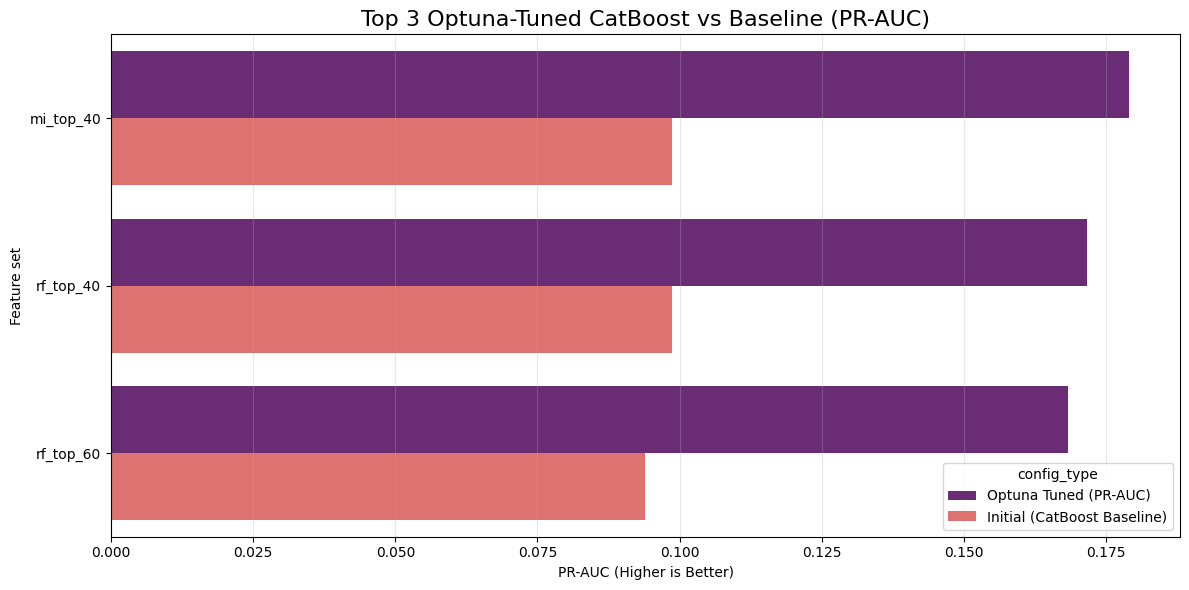

In [ ]:
# Copy the final CatBoost leaderboard
fc = final_cat_comparison.copy()

# Select only Optuna-tuned models
tuned_cat = fc[fc["config_type"] == "Optuna Tuned (PR-AUC)"]

# Take top 3 by PR-AUC
top3_tuned = tuned_cat.sort_values("pr_auc_val", ascending=False).head(3)

# Find the corresponding baseline models for the same feature sets
baseline_cat = fc[
    (fc["config_type"] == "Initial (CatBoost Baseline)") &
    (fc["feature_set"].isin(top3_tuned["feature_set"]))
]

# Combine top3 tuned + their baselines
visualize_cat = pd.concat([top3_tuned, baseline_cat], ignore_index=True)

# Sort by PR-AUC descending for visualization
visualize_cat = visualize_cat.sort_values("pr_auc_val", ascending=False)

# Plot
plt.figure(figsize=(12, 6))

sns.barplot(
    data=visualize_cat,
    x="pr_auc_val",
    y="feature_set",
    hue="config_type",
    palette="magma"
)

plt.title("Top 3 Optuna-Tuned CatBoost vs Baseline (PR-AUC)", fontsize=16)
plt.xlabel("PR-AUC (Higher is Better)")
plt.ylabel("Feature set")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


### Train and Save (CatBoost)

In [297]:
import os
import joblib
import json
import ast
from catboost import CatBoostClassifier
import pandas as pd

# Copy final CatBoost leaderboard
fc = final_cat_comparison.copy()

# Filter Optuna-tuned models and select top 3 by PR-AUC
tuned_c = fc[fc["config_type"] == "Optuna Tuned (PR-AUC)"]
rows_c = tuned_c.sort_values("pr_auc_val", ascending=False).head(3)

# Build configuration list
cat_models_config = []
for _, r in rows_c.iterrows():
    fs = r["feature_set"]
    raw = r["params"]

    if isinstance(raw, dict):
        p = dict(raw)
    else:
        try:
            p = ast.literal_eval(raw)
        except Exception:
            try:
                p = json.loads(raw)
            except Exception:
                p = {}

    cleaned = {}
    if "learning_rate" in p:      cleaned["learning_rate"] = float(p["learning_rate"])
    if "depth" in p:              cleaned["depth"] = int(p["depth"])
    if "min_data_in_leaf" in p:   cleaned["min_data_in_leaf"] = int(p["min_data_in_leaf"])
    if "l2_leaf_reg" in p:       cleaned["l2_leaf_reg"] = float(p["l2_leaf_reg"])

    # Defaults
    cleaned.setdefault("learning_rate", 0.05)
    cleaned.setdefault("depth", 6)
    cleaned.setdefault("min_data_in_leaf", 20)
    cleaned.setdefault("l2_leaf_reg", 3.0)

    cat_models_config.append({
        "name": f"cat::{fs}",
        "feature_set": fs,
        "params": cleaned,
        "pr_auc_val": float(r["pr_auc_val"]),
        "roc_auc_val": float(r["roc_auc_val"]),
    })

print(f"Top 3 CatBoost PR-AUC winners:")
for c in cat_models_config:
    print(f" - {c['name']} → {c['params']}")

# Train and save top 3
os.makedirs("saved_models/catboost", exist_ok=True)
_cache = {}

for cfg in cat_models_config:
    fs = cfg["feature_set"]

    if fs not in feature_sets:
        print(f"Missing feature set '{fs}' — skip.")
        continue

    if fs not in _cache:
        blob = feature_sets[fs]
        X_final = pd.concat([blob["train"], blob["val"]], axis=0)
        y_final = pd.concat([y_train, y_val], axis=0)
        feats = blob["train"].columns.tolist()
        cat_cols = list(X_final.select_dtypes(include=["object", "category"]).columns)
        cat_cols = cat_cols if len(cat_cols) > 0 else None
        _cache[fs] = (X_final, y_final, feats, cat_cols)

    X_final, y_final, feats, cat_cols = _cache[fs]
    p = cfg["params"]

    clf = CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="PRAUC",
        iterations=1000,
        auto_class_weights="Balanced",
        bootstrap_type="No",
        random_seed=42,
        verbose=False,
        allow_writing_files=False,
        **p,
    )

    print(f"Training {cfg['name']} with {len(feats)} features…")
    clf.fit(X_final[feats], y_final, cat_features=cat_cols, verbose=False)

    safe_name = cfg["name"].replace("::", "__")
    path = os.path.join("saved_models/catboost", f"{safe_name}.joblib")
    joblib.dump(
        {
            "model": clf,
            "family": "catboost",
            "model_name": cfg["name"],
            "feature_set": fs,
            "features": feats,
            "cat_features": cat_cols,
            "params": p,
            "metrics": {
                "pr_auc": cfg["pr_auc_val"],
                "roc_auc": cfg["roc_auc_val"],
            },
        },
        path,
        compress=1,
    )
    print(f"Saved: {path}")

Top 3 CatBoost PR-AUC winners:
 - cat::mi_top_40 → {'learning_rate': 0.03964794511177035, 'depth': 8, 'min_data_in_leaf': 49, 'l2_leaf_reg': 0.006232657908019014}
 - cat::rf_top_40 → {'learning_rate': 0.03164494702427761, 'depth': 7, 'min_data_in_leaf': 68, 'l2_leaf_reg': 0.0022305922438070726}
 - cat::rf_top_60 → {'learning_rate': 0.02605925224565416, 'depth': 7, 'min_data_in_leaf': 68, 'l2_leaf_reg': 0.027931713437818157}
Training cat::mi_top_40 with 40 features…


Saved: saved_models/catboost\cat__mi_top_40.joblib
Training cat::rf_top_40 with 40 features…
Saved: saved_models/catboost\cat__rf_top_40.joblib
Training cat::rf_top_60 with 60 features…
Saved: saved_models/catboost\cat__rf_top_60.joblib


№## MLP

### Baseline MLP

In [298]:
def train_eval_mlp_baseline(
    X_train, y_train,
    X_val, y_val,
):
    clf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),  
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            hidden_layer_sizes=(64, 32),   
            activation="relu",
            solver="adam",

            alpha=1e-4,
            learning_rate_init=1e-3,

            max_iter=300,
            early_stopping=True,           
            n_iter_no_change=20,

            random_state=42,
            verbose=False,
        ))
    ])

    clf.fit(X_train, y_train)

    proba = clf.predict_proba(X_val)[:, 1]

    return {
        "roc_auc": roc_auc_score(y_val, proba),
        "pr_auc":  average_precision_score(y_val, proba),
        "config":  "true_baseline",
    }


### MLP with feature sets

In [299]:
mlp_results = []

for name, fs in tqdm(
    feature_sets.items(),
    desc="MLP – feature sets",
    total=len(feature_sets),
):
    m = train_eval_mlp_baseline(
        fs["train"], y_train,
        fs["val"],   y_val
    )

    mlp_results.append({
        "feature_set": name,
        "n_features": fs["train"].shape[1],
        "roc_auc_val": m["roc_auc"],
        "pr_auc_val":  m["pr_auc"],
        "best_config": m["config"],
    })

mlp_results_df = (
    pd.DataFrame(mlp_results)
      .sort_values("pr_auc_val", ascending=False)
      .reset_index(drop=True)
)

display(mlp_results_df)


MLP – feature sets:   0%|          | 0/18 [00:00<?, ?it/s]

feature_set  n_features  roc_auc_val  pr_auc_val    best_config
0      mi_top_20          20     0.631047    0.103392  true_baseline
1      rf_top_60          60     0.576172    0.089311  true_baseline
2   all_features          91     0.654517    0.088676  true_baseline
3      rf_top_69          69     0.601002    0.086393  true_baseline
4      rf_top_10          10     0.596075    0.082568  true_baseline
5       rf_top_5           5     0.622669    0.078960  true_baseline
6      mi_top_30          30     0.585136    0.078225  true_baseline
7      rf_top_30          30     0.577234    0.075894  true_baseline
8      rf_top_40          40     0.605071    0.073115  true_baseline
9      mi_top_10          10     0.578251    0.070683  true_baseline
10     mi_top_50          50     0.538110    0.070238  true_baseline
11     mi_top_40          40     0.531389    0.069840  true_baseline
12     mi_top_57          57     0.554831    0.069793  true_baseline
13     rf_top_50          50     0.543842    0.069456  true_baseline
14      mi_top_5           5     0.561610    0.069162  true_baseline
15   perm_top_12          12     0.538789    0.069106  true_baseline
16    perm_top_6           6     0.530366    0.064165  true_baseline
17     rf_top_20          20     0.470861    0.059014  true_baseline

### Tuning Top 7 Feature Sets based on PR-AUC

In [300]:
print("MLP FS to tune (PR-AUC only): all feature sets")

mlp_pre = {}

for fs_name, fs in feature_sets.items():
    Xtr = fs["train"]
    Xva = fs["val"]

    ytr = y_train.values
    yva = y_val.values

    mlp_pre[fs_name] = {
        "Xtr": Xtr,
        "ytr": ytr,
        "Xva": Xva,
        "yva": yva,
        "n_features": Xtr.shape[1],
        "feature_names": list(Xtr.columns),
    }

for k, v in mlp_pre.items():
    print(f"✔ {k}: {v['n_features']} features")

MLP FS to tune (PR-AUC only): all feature sets
✔ all_features: 91 features
✔ perm_top_12: 12 features
✔ perm_top_6: 6 features
✔ rf_top_69: 69 features
✔ rf_top_60: 60 features
✔ rf_top_50: 50 features
✔ rf_top_40: 40 features
✔ rf_top_30: 30 features
✔ rf_top_20: 20 features
✔ rf_top_10: 10 features
✔ rf_top_5: 5 features
✔ mi_top_57: 57 features
✔ mi_top_50: 50 features
✔ mi_top_40: 40 features
✔ mi_top_30: 30 features
✔ mi_top_20: 20 features
✔ mi_top_10: 10 features
✔ mi_top_5: 5 features


### Optuna PR-AUC MLP Tuner

In [301]:
def optuna_objective_mlp(
    trial,
    Xtr, ytr,
    Xva, yva,
):
    h1 = trial.suggest_int("h1", 32, 256, log=True)
    h2 = trial.suggest_int("h2", 16, 128, log=True)

    alpha = trial.suggest_float("alpha", 1e-6, 1e-2, log=True)
    lr    = trial.suggest_float("learning_rate_init", 1e-4, 5e-3, log=True)

    model = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            hidden_layer_sizes=(h1, h2),
            activation="relu",
            solver="adam",

            alpha=alpha,
            learning_rate_init=lr,

            max_iter=500,
            early_stopping=True,
            n_iter_no_change=20,

            random_state=42,
            verbose=False,
        )),
    ])

    try:
        model.fit(Xtr, ytr)
        proba = model.predict_proba(Xva)[:, 1]
        return average_precision_score(yva, proba)

    except Exception:
        return 0.0

In [302]:
mlp_pr_results = []
mlp_studies = {}

for fs_name, d in tqdm(
    mlp_pre.items(),
    desc="MLP PR-AUC tuning",
    total=len(mlp_pre),
):
    print(f"Tuning MLP for feature set: {fs_name}")

    Xtr, ytr = d["Xtr"], d["ytr"]
    Xva, yva = d["Xva"], d["yva"]

    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=42),
    )

    study.optimize(
        lambda tr: optuna_objective_mlp(
            tr,
            Xtr, ytr,
            Xva, yva,
        ),
        n_trials=5,
        show_progress_bar=True,
        n_jobs=1,
    )

    mlp_studies[fs_name] = study
    best = study.best_trial

    best_clf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            hidden_layer_sizes=(
                best.params["h1"],
                best.params["h2"],
            ),
            activation="relu",
            solver="adam",

            alpha=best.params["alpha"],
            learning_rate_init=best.params["learning_rate_init"],

            max_iter=500,
            early_stopping=True,
            n_iter_no_change=20,

            random_state=42,
            verbose=False,
        )),
    ])

    best_clf.fit(Xtr, ytr)
    proba = best_clf.predict_proba(Xva)[:, 1]

    mlp_pr_results.append({
        "feature_set": fs_name,
        "n_features": d["n_features"],
        "pr_auc_val": best.value,
        "roc_auc_val": roc_auc_score(yva, proba),
        "best_params": best.params,
    })


MLP PR-AUC tuning:   0%|          | 0/18 [00:00<?, ?it/s]

[I 2026-01-15 13:55:37,552] A new study created in memory with name: no-name-fdbdc4b7-f433-410f-b8c4-0f11fc26d6ab


Tuning MLP for feature set: all_features


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2026-01-15 13:55:39,752] Trial 0 finished with value: 0.05960456870745879 and parameters: {'h1': 69, 'h2': 116, 'alpha': 0.0008471801418819979, 'learning_rate_init': 0.0010401663679887319}. Best is trial 0 with value: 0.05960456870745879.
[I 2026-01-15 13:55:41,019] Trial 1 finished with value: 0.08180682314984768 and parameters: {'h1': 44, 'h2': 22, 'alpha': 1.7073967431528114e-06, 'learning_rate_init': 0.0029621516588303515}. Best is trial 1 with value: 0.08180682314984768.
[I 2026-01-15 13:55:43,556] Trial 2 finished with value: 0.08989438875000935 and parameters: {'h1': 111, 'h2': 69, 'alpha': 1.2087541473056965e-06, 'learning_rate_init': 0.0044447541666908135}. Best is trial 2 with value: 0.08989438875000935.
[I 2026-01-15 13:55:45,881] Trial 3 finished with value: 0.07525404982112494 and parameters: {'h1': 181, 'h2': 24, 'alpha': 5.337032762603957e-06, 'learning_rate_init': 0.0002049268011541737}. Best is trial 2 with value: 0.08989438875000935.
[I 2026-01-15 13:55:47,833] Tri

[I 2026-01-15 13:55:50,239] A new study created in memory with name: no-name-c5c5e04d-de5d-485c-a356-78f36bd7caa2


Tuning MLP for feature set: perm_top_12


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2026-01-15 13:55:52,225] Trial 0 finished with value: 0.08165971530287865 and parameters: {'h1': 69, 'h2': 116, 'alpha': 0.0008471801418819979, 'learning_rate_init': 0.0010401663679887319}. Best is trial 0 with value: 0.08165971530287865.
[I 2026-01-15 13:55:52,830] Trial 1 finished with value: 0.09636631535814567 and parameters: {'h1': 44, 'h2': 22, 'alpha': 1.7073967431528114e-06, 'learning_rate_init': 0.0029621516588303515}. Best is trial 1 with value: 0.09636631535814567.
[I 2026-01-15 13:55:55,052] Trial 2 finished with value: 0.10737703653263247 and parameters: {'h1': 111, 'h2': 69, 'alpha': 1.2087541473056965e-06, 'learning_rate_init': 0.0044447541666908135}. Best is trial 2 with value: 0.10737703653263247.
[I 2026-01-15 13:55:57,103] Trial 3 finished with value: 0.07124735286449138 and parameters: {'h1': 181, 'h2': 24, 'alpha': 5.337032762603957e-06, 'learning_rate_init': 0.0002049268011541737}. Best is trial 2 with value: 0.10737703653263247.
[I 2026-01-15 13:55:58,460] Tri

[I 2026-01-15 13:56:00,520] A new study created in memory with name: no-name-116c5370-5aea-43c8-b09e-0c2f9f304b6e


Tuning MLP for feature set: perm_top_6


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2026-01-15 13:56:02,193] Trial 0 finished with value: 0.09717688181141296 and parameters: {'h1': 69, 'h2': 116, 'alpha': 0.0008471801418819979, 'learning_rate_init': 0.0010401663679887319}. Best is trial 0 with value: 0.09717688181141296.
[I 2026-01-15 13:56:02,854] Trial 1 finished with value: 0.1078126856889233 and parameters: {'h1': 44, 'h2': 22, 'alpha': 1.7073967431528114e-06, 'learning_rate_init': 0.0029621516588303515}. Best is trial 1 with value: 0.1078126856889233.
[I 2026-01-15 13:56:04,706] Trial 2 finished with value: 0.10942153073626704 and parameters: {'h1': 111, 'h2': 69, 'alpha': 1.2087541473056965e-06, 'learning_rate_init': 0.0044447541666908135}. Best is trial 2 with value: 0.10942153073626704.
[I 2026-01-15 13:56:06,649] Trial 3 finished with value: 0.08454198092874946 and parameters: {'h1': 181, 'h2': 24, 'alpha': 5.337032762603957e-06, 'learning_rate_init': 0.0002049268011541737}. Best is trial 2 with value: 0.10942153073626704.
[I 2026-01-15 13:56:08,232] Trial

[I 2026-01-15 13:56:10,141] A new study created in memory with name: no-name-a8128428-b117-4763-857d-7d4a6052745e


Tuning MLP for feature set: rf_top_69


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2026-01-15 13:56:12,333] Trial 0 finished with value: 0.07137161471869866 and parameters: {'h1': 69, 'h2': 116, 'alpha': 0.0008471801418819979, 'learning_rate_init': 0.0010401663679887319}. Best is trial 0 with value: 0.07137161471869866.
[I 2026-01-15 13:56:13,462] Trial 1 finished with value: 0.11459388685566466 and parameters: {'h1': 44, 'h2': 22, 'alpha': 1.7073967431528114e-06, 'learning_rate_init': 0.0029621516588303515}. Best is trial 1 with value: 0.11459388685566466.
[I 2026-01-15 13:56:15,815] Trial 2 finished with value: 0.078194275053196 and parameters: {'h1': 111, 'h2': 69, 'alpha': 1.2087541473056965e-06, 'learning_rate_init': 0.0044447541666908135}. Best is trial 1 with value: 0.11459388685566466.
[I 2026-01-15 13:56:17,854] Trial 3 finished with value: 0.06939028008981951 and parameters: {'h1': 181, 'h2': 24, 'alpha': 5.337032762603957e-06, 'learning_rate_init': 0.0002049268011541737}. Best is trial 1 with value: 0.11459388685566466.
[I 2026-01-15 13:56:19,470] Trial

[I 2026-01-15 13:56:20,822] A new study created in memory with name: no-name-c4bb9a5e-e529-4c7c-8cce-dec852a4cfda


Tuning MLP for feature set: rf_top_60


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2026-01-15 13:56:23,116] Trial 0 finished with value: 0.08984126535782619 and parameters: {'h1': 69, 'h2': 116, 'alpha': 0.0008471801418819979, 'learning_rate_init': 0.0010401663679887319}. Best is trial 0 with value: 0.08984126535782619.
[I 2026-01-15 13:56:24,399] Trial 1 finished with value: 0.09705555933423424 and parameters: {'h1': 44, 'h2': 22, 'alpha': 1.7073967431528114e-06, 'learning_rate_init': 0.0029621516588303515}. Best is trial 1 with value: 0.09705555933423424.
[I 2026-01-15 13:56:27,234] Trial 2 finished with value: 0.09524619378542305 and parameters: {'h1': 111, 'h2': 69, 'alpha': 1.2087541473056965e-06, 'learning_rate_init': 0.0044447541666908135}. Best is trial 1 with value: 0.09705555933423424.
[I 2026-01-15 13:56:29,468] Trial 3 finished with value: 0.05920462847032924 and parameters: {'h1': 181, 'h2': 24, 'alpha': 5.337032762603957e-06, 'learning_rate_init': 0.0002049268011541737}. Best is trial 1 with value: 0.09705555933423424.
[I 2026-01-15 13:56:31,101] Tri

[I 2026-01-15 13:56:32,065] A new study created in memory with name: no-name-7c192674-281f-4548-bfeb-6c1f6c3071b3


Tuning MLP for feature set: rf_top_50


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2026-01-15 13:56:35,377] Trial 0 finished with value: 0.10765536941948582 and parameters: {'h1': 69, 'h2': 116, 'alpha': 0.0008471801418819979, 'learning_rate_init': 0.0010401663679887319}. Best is trial 0 with value: 0.10765536941948582.
[I 2026-01-15 13:56:36,190] Trial 1 finished with value: 0.11455329364341679 and parameters: {'h1': 44, 'h2': 22, 'alpha': 1.7073967431528114e-06, 'learning_rate_init': 0.0029621516588303515}. Best is trial 1 with value: 0.11455329364341679.
[I 2026-01-15 13:56:38,064] Trial 2 finished with value: 0.09139893731833666 and parameters: {'h1': 111, 'h2': 69, 'alpha': 1.2087541473056965e-06, 'learning_rate_init': 0.0044447541666908135}. Best is trial 1 with value: 0.11455329364341679.
[I 2026-01-15 13:56:39,977] Trial 3 finished with value: 0.0647035268207155 and parameters: {'h1': 181, 'h2': 24, 'alpha': 5.337032762603957e-06, 'learning_rate_init': 0.0002049268011541737}. Best is trial 1 with value: 0.11455329364341679.
[I 2026-01-15 13:56:41,771] Tria

[I 2026-01-15 13:56:42,900] A new study created in memory with name: no-name-be1d5488-d4ea-4e5a-9acc-6b705835be19


Tuning MLP for feature set: rf_top_40


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2026-01-15 13:56:46,128] Trial 0 finished with value: 0.07840372823027998 and parameters: {'h1': 69, 'h2': 116, 'alpha': 0.0008471801418819979, 'learning_rate_init': 0.0010401663679887319}. Best is trial 0 with value: 0.07840372823027998.
[I 2026-01-15 13:56:47,236] Trial 1 finished with value: 0.09349614576219215 and parameters: {'h1': 44, 'h2': 22, 'alpha': 1.7073967431528114e-06, 'learning_rate_init': 0.0029621516588303515}. Best is trial 1 with value: 0.09349614576219215.
[I 2026-01-15 13:56:49,807] Trial 2 finished with value: 0.0907509672031906 and parameters: {'h1': 111, 'h2': 69, 'alpha': 1.2087541473056965e-06, 'learning_rate_init': 0.0044447541666908135}. Best is trial 1 with value: 0.09349614576219215.
[I 2026-01-15 13:56:52,154] Trial 3 finished with value: 0.08186790961008003 and parameters: {'h1': 181, 'h2': 24, 'alpha': 5.337032762603957e-06, 'learning_rate_init': 0.0002049268011541737}. Best is trial 1 with value: 0.09349614576219215.
[I 2026-01-15 13:56:54,579] Tria

[I 2026-01-15 13:56:55,441] A new study created in memory with name: no-name-afc3f357-1728-4a93-923c-cf9ed54e2a51


Tuning MLP for feature set: rf_top_30


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2026-01-15 13:56:57,540] Trial 0 finished with value: 0.07676024839111703 and parameters: {'h1': 69, 'h2': 116, 'alpha': 0.0008471801418819979, 'learning_rate_init': 0.0010401663679887319}. Best is trial 0 with value: 0.07676024839111703.
[I 2026-01-15 13:56:58,350] Trial 1 finished with value: 0.07972225627798221 and parameters: {'h1': 44, 'h2': 22, 'alpha': 1.7073967431528114e-06, 'learning_rate_init': 0.0029621516588303515}. Best is trial 1 with value: 0.07972225627798221.
[I 2026-01-15 13:57:00,572] Trial 2 finished with value: 0.08516792956758637 and parameters: {'h1': 111, 'h2': 69, 'alpha': 1.2087541473056965e-06, 'learning_rate_init': 0.0044447541666908135}. Best is trial 2 with value: 0.08516792956758637.
[I 2026-01-15 13:57:02,927] Trial 3 finished with value: 0.07301911095874183 and parameters: {'h1': 181, 'h2': 24, 'alpha': 5.337032762603957e-06, 'learning_rate_init': 0.0002049268011541737}. Best is trial 2 with value: 0.08516792956758637.
[I 2026-01-15 13:57:04,858] Tri

[I 2026-01-15 13:57:07,071] A new study created in memory with name: no-name-196c27a4-4c62-4820-84d4-431c6a88a848


Tuning MLP for feature set: rf_top_20


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2026-01-15 13:57:10,467] Trial 0 finished with value: 0.1310771021337695 and parameters: {'h1': 69, 'h2': 116, 'alpha': 0.0008471801418819979, 'learning_rate_init': 0.0010401663679887319}. Best is trial 0 with value: 0.1310771021337695.
[I 2026-01-15 13:57:11,135] Trial 1 finished with value: 0.08142762250937684 and parameters: {'h1': 44, 'h2': 22, 'alpha': 1.7073967431528114e-06, 'learning_rate_init': 0.0029621516588303515}. Best is trial 0 with value: 0.1310771021337695.
[I 2026-01-15 13:57:13,328] Trial 2 finished with value: 0.08361055103813715 and parameters: {'h1': 111, 'h2': 69, 'alpha': 1.2087541473056965e-06, 'learning_rate_init': 0.0044447541666908135}. Best is trial 0 with value: 0.1310771021337695.
[I 2026-01-15 13:57:15,974] Trial 3 finished with value: 0.06133686449545779 and parameters: {'h1': 181, 'h2': 24, 'alpha': 5.337032762603957e-06, 'learning_rate_init': 0.0002049268011541737}. Best is trial 0 with value: 0.1310771021337695.
[I 2026-01-15 13:57:17,883] Trial 4 

[I 2026-01-15 13:57:21,739] A new study created in memory with name: no-name-1be9d73e-e050-40f9-b078-05483b080a1f


Tuning MLP for feature set: rf_top_10


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2026-01-15 13:57:23,716] Trial 0 finished with value: 0.0762208348798371 and parameters: {'h1': 69, 'h2': 116, 'alpha': 0.0008471801418819979, 'learning_rate_init': 0.0010401663679887319}. Best is trial 0 with value: 0.0762208348798371.
[I 2026-01-15 13:57:24,352] Trial 1 finished with value: 0.08351922304107416 and parameters: {'h1': 44, 'h2': 22, 'alpha': 1.7073967431528114e-06, 'learning_rate_init': 0.0029621516588303515}. Best is trial 1 with value: 0.08351922304107416.
[I 2026-01-15 13:57:26,646] Trial 2 finished with value: 0.09800879997725676 and parameters: {'h1': 111, 'h2': 69, 'alpha': 1.2087541473056965e-06, 'learning_rate_init': 0.0044447541666908135}. Best is trial 2 with value: 0.09800879997725676.
[I 2026-01-15 13:57:28,958] Trial 3 finished with value: 0.06683341802020926 and parameters: {'h1': 181, 'h2': 24, 'alpha': 5.337032762603957e-06, 'learning_rate_init': 0.0002049268011541737}. Best is trial 2 with value: 0.09800879997725676.
[I 2026-01-15 13:57:30,685] Trial

[I 2026-01-15 13:57:32,680] A new study created in memory with name: no-name-2730fd7b-b1b3-45f4-b003-a5de656ff125


Tuning MLP for feature set: rf_top_5


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2026-01-15 13:57:34,596] Trial 0 finished with value: 0.08231332616652248 and parameters: {'h1': 69, 'h2': 116, 'alpha': 0.0008471801418819979, 'learning_rate_init': 0.0010401663679887319}. Best is trial 0 with value: 0.08231332616652248.
[I 2026-01-15 13:57:35,210] Trial 1 finished with value: 0.08992548821844518 and parameters: {'h1': 44, 'h2': 22, 'alpha': 1.7073967431528114e-06, 'learning_rate_init': 0.0029621516588303515}. Best is trial 1 with value: 0.08992548821844518.
[I 2026-01-15 13:57:36,820] Trial 2 finished with value: 0.07897519527579129 and parameters: {'h1': 111, 'h2': 69, 'alpha': 1.2087541473056965e-06, 'learning_rate_init': 0.0044447541666908135}. Best is trial 1 with value: 0.08992548821844518.
[I 2026-01-15 13:57:38,415] Trial 3 finished with value: 0.07092260630366554 and parameters: {'h1': 181, 'h2': 24, 'alpha': 5.337032762603957e-06, 'learning_rate_init': 0.0002049268011541737}. Best is trial 1 with value: 0.08992548821844518.
[I 2026-01-15 13:57:39,644] Tri

[I 2026-01-15 13:57:40,256] A new study created in memory with name: no-name-b082f153-c8bf-4fee-ae57-b56ed7d4f6ac


Tuning MLP for feature set: mi_top_57


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2026-01-15 13:57:42,735] Trial 0 finished with value: 0.11682253981445628 and parameters: {'h1': 69, 'h2': 116, 'alpha': 0.0008471801418819979, 'learning_rate_init': 0.0010401663679887319}. Best is trial 0 with value: 0.11682253981445628.
[I 2026-01-15 13:57:44,124] Trial 1 finished with value: 0.09299638738561442 and parameters: {'h1': 44, 'h2': 22, 'alpha': 1.7073967431528114e-06, 'learning_rate_init': 0.0029621516588303515}. Best is trial 0 with value: 0.11682253981445628.
[I 2026-01-15 13:57:46,503] Trial 2 finished with value: 0.09123294426687233 and parameters: {'h1': 111, 'h2': 69, 'alpha': 1.2087541473056965e-06, 'learning_rate_init': 0.0044447541666908135}. Best is trial 0 with value: 0.11682253981445628.
[I 2026-01-15 13:57:48,654] Trial 3 finished with value: 0.05011652841378007 and parameters: {'h1': 181, 'h2': 24, 'alpha': 5.337032762603957e-06, 'learning_rate_init': 0.0002049268011541737}. Best is trial 0 with value: 0.11682253981445628.
[I 2026-01-15 13:57:50,377] Tri

[I 2026-01-15 13:57:52,430] A new study created in memory with name: no-name-63963ffb-6614-4edf-900d-80409f31285b


Tuning MLP for feature set: mi_top_50


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2026-01-15 13:57:55,533] Trial 0 finished with value: 0.09055816822127849 and parameters: {'h1': 69, 'h2': 116, 'alpha': 0.0008471801418819979, 'learning_rate_init': 0.0010401663679887319}. Best is trial 0 with value: 0.09055816822127849.
[I 2026-01-15 13:57:56,568] Trial 1 finished with value: 0.083517417406864 and parameters: {'h1': 44, 'h2': 22, 'alpha': 1.7073967431528114e-06, 'learning_rate_init': 0.0029621516588303515}. Best is trial 0 with value: 0.09055816822127849.
[I 2026-01-15 13:57:58,713] Trial 2 finished with value: 0.08518308533245143 and parameters: {'h1': 111, 'h2': 69, 'alpha': 1.2087541473056965e-06, 'learning_rate_init': 0.0044447541666908135}. Best is trial 0 with value: 0.09055816822127849.
[I 2026-01-15 13:58:00,441] Trial 3 finished with value: 0.05584353952283996 and parameters: {'h1': 181, 'h2': 24, 'alpha': 5.337032762603957e-06, 'learning_rate_init': 0.0002049268011541737}. Best is trial 0 with value: 0.09055816822127849.
[I 2026-01-15 13:58:02,297] Trial

[I 2026-01-15 13:58:05,571] A new study created in memory with name: no-name-2782b9eb-dc69-4d0f-983f-6f2b1cf54da9


Tuning MLP for feature set: mi_top_40


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2026-01-15 13:58:09,912] Trial 0 finished with value: 0.07767908576279564 and parameters: {'h1': 69, 'h2': 116, 'alpha': 0.0008471801418819979, 'learning_rate_init': 0.0010401663679887319}. Best is trial 0 with value: 0.07767908576279564.
[I 2026-01-15 13:58:11,078] Trial 1 finished with value: 0.09374399770307924 and parameters: {'h1': 44, 'h2': 22, 'alpha': 1.7073967431528114e-06, 'learning_rate_init': 0.0029621516588303515}. Best is trial 1 with value: 0.09374399770307924.
[I 2026-01-15 13:58:13,470] Trial 2 finished with value: 0.09057381573686278 and parameters: {'h1': 111, 'h2': 69, 'alpha': 1.2087541473056965e-06, 'learning_rate_init': 0.0044447541666908135}. Best is trial 1 with value: 0.09374399770307924.
[I 2026-01-15 13:58:16,132] Trial 3 finished with value: 0.09440335366945315 and parameters: {'h1': 181, 'h2': 24, 'alpha': 5.337032762603957e-06, 'learning_rate_init': 0.0002049268011541737}. Best is trial 3 with value: 0.09440335366945315.
[I 2026-01-15 13:58:17,486] Tri

[I 2026-01-15 13:58:19,966] A new study created in memory with name: no-name-1d1dc7f6-8dfc-48f5-9655-aa1bba77b694


Tuning MLP for feature set: mi_top_30


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2026-01-15 13:58:21,767] Trial 0 finished with value: 0.07643861620784895 and parameters: {'h1': 69, 'h2': 116, 'alpha': 0.0008471801418819979, 'learning_rate_init': 0.0010401663679887319}. Best is trial 0 with value: 0.07643861620784895.
[I 2026-01-15 13:58:23,322] Trial 1 finished with value: 0.09717614261615065 and parameters: {'h1': 44, 'h2': 22, 'alpha': 1.7073967431528114e-06, 'learning_rate_init': 0.0029621516588303515}. Best is trial 1 with value: 0.09717614261615065.
[I 2026-01-15 13:58:27,040] Trial 2 finished with value: 0.09264311370047129 and parameters: {'h1': 111, 'h2': 69, 'alpha': 1.2087541473056965e-06, 'learning_rate_init': 0.0044447541666908135}. Best is trial 1 with value: 0.09717614261615065.
[I 2026-01-15 13:58:29,943] Trial 3 finished with value: 0.06189594510283379 and parameters: {'h1': 181, 'h2': 24, 'alpha': 5.337032762603957e-06, 'learning_rate_init': 0.0002049268011541737}. Best is trial 1 with value: 0.09717614261615065.
[I 2026-01-15 13:58:31,501] Tri

[I 2026-01-15 13:58:32,826] A new study created in memory with name: no-name-cbf0de42-d858-4017-a9c5-0b6fb0ffbd58


Tuning MLP for feature set: mi_top_20


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2026-01-15 13:58:35,498] Trial 0 finished with value: 0.1072862805307811 and parameters: {'h1': 69, 'h2': 116, 'alpha': 0.0008471801418819979, 'learning_rate_init': 0.0010401663679887319}. Best is trial 0 with value: 0.1072862805307811.
[I 2026-01-15 13:58:36,110] Trial 1 finished with value: 0.08665683295078339 and parameters: {'h1': 44, 'h2': 22, 'alpha': 1.7073967431528114e-06, 'learning_rate_init': 0.0029621516588303515}. Best is trial 0 with value: 0.1072862805307811.
[I 2026-01-15 13:58:39,453] Trial 2 finished with value: 0.11338747337600852 and parameters: {'h1': 111, 'h2': 69, 'alpha': 1.2087541473056965e-06, 'learning_rate_init': 0.0044447541666908135}. Best is trial 2 with value: 0.11338747337600852.
[I 2026-01-15 13:58:41,091] Trial 3 finished with value: 0.0668438451400786 and parameters: {'h1': 181, 'h2': 24, 'alpha': 5.337032762603957e-06, 'learning_rate_init': 0.0002049268011541737}. Best is trial 2 with value: 0.11338747337600852.
[I 2026-01-15 13:58:42,321] Trial 4

[I 2026-01-15 13:58:45,757] A new study created in memory with name: no-name-1eb7b925-79e0-4ffe-9bac-55777610d633


Tuning MLP for feature set: mi_top_10


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2026-01-15 13:58:47,523] Trial 0 finished with value: 0.08008900126597297 and parameters: {'h1': 69, 'h2': 116, 'alpha': 0.0008471801418819979, 'learning_rate_init': 0.0010401663679887319}. Best is trial 0 with value: 0.08008900126597297.
[I 2026-01-15 13:58:48,074] Trial 1 finished with value: 0.06966366196425108 and parameters: {'h1': 44, 'h2': 22, 'alpha': 1.7073967431528114e-06, 'learning_rate_init': 0.0029621516588303515}. Best is trial 0 with value: 0.08008900126597297.
[I 2026-01-15 13:58:51,291] Trial 2 finished with value: 0.1336161309218185 and parameters: {'h1': 111, 'h2': 69, 'alpha': 1.2087541473056965e-06, 'learning_rate_init': 0.0044447541666908135}. Best is trial 2 with value: 0.1336161309218185.
[I 2026-01-15 13:58:52,963] Trial 3 finished with value: 0.06117583499078889 and parameters: {'h1': 181, 'h2': 24, 'alpha': 5.337032762603957e-06, 'learning_rate_init': 0.0002049268011541737}. Best is trial 2 with value: 0.1336161309218185.
[I 2026-01-15 13:58:54,202] Trial 

[I 2026-01-15 13:58:57,049] A new study created in memory with name: no-name-22ca5c92-05af-47c7-bbed-1c1a18b37f5d


Tuning MLP for feature set: mi_top_5


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2026-01-15 13:58:58,624] Trial 0 finished with value: 0.08444802824726982 and parameters: {'h1': 69, 'h2': 116, 'alpha': 0.0008471801418819979, 'learning_rate_init': 0.0010401663679887319}. Best is trial 0 with value: 0.08444802824726982.
[I 2026-01-15 13:58:59,119] Trial 1 finished with value: 0.07761094500871311 and parameters: {'h1': 44, 'h2': 22, 'alpha': 1.7073967431528114e-06, 'learning_rate_init': 0.0029621516588303515}. Best is trial 0 with value: 0.08444802824726982.
[I 2026-01-15 13:59:01,901] Trial 2 finished with value: 0.06740097773720188 and parameters: {'h1': 111, 'h2': 69, 'alpha': 1.2087541473056965e-06, 'learning_rate_init': 0.0044447541666908135}. Best is trial 0 with value: 0.08444802824726982.
[I 2026-01-15 13:59:03,197] Trial 3 finished with value: 0.06029309082506683 and parameters: {'h1': 181, 'h2': 24, 'alpha': 5.337032762603957e-06, 'learning_rate_init': 0.0002049268011541737}. Best is trial 0 with value: 0.08444802824726982.
[I 2026-01-15 13:59:04,435] Tri

№## Comparison For MLP: Baseline vs Optuna

In [306]:
# Convert results list to DataFrame
mlp_pr_df = pd.DataFrame(mlp_pr_results)

initial_mlp = mlp_results_df.copy()

initial_mlp["config_type"] = "Initial (MLP Baseline)"

initial_mlp["params"] = str({
    "hidden_layer_sizes": (64, 32),
    "activation": "relu",
    "solver": "adam",
    "alpha": 1e-4,
    "learning_rate_init": 1e-3,
    "max_iter": 300,
    "early_stopping": True,
    "n_iter_no_change": 20,
    "imputer": "median",
    "scaler": "standard",
})

tuned_mlp = mlp_pr_df.copy()
tuned_mlp["config_type"] = "Optuna Tuned (PR-AUC)"
tuned_mlp.rename(columns={"best_params": "params"}, inplace=True)

final_mlp_comparison = (
    pd.concat([tuned_mlp, initial_mlp], ignore_index=True)
      .sort_values(
          by=["pr_auc_val", "feature_set"],
          ascending=[False, True]
      )
      .reset_index(drop=True)
)

print("Final MLP Leaderboard (PR-AUC priority)")
display(final_mlp_comparison[[
    "feature_set",
    "config_type",
    "pr_auc_val",
    "roc_auc_val",
    "params",
]])

Final MLP Leaderboard (PR-AUC priority)


feature_set             config_type  pr_auc_val  roc_auc_val  \
0      mi_top_10   Optuna Tuned (PR-AUC)    0.133616     0.665334   
1      rf_top_20   Optuna Tuned (PR-AUC)    0.131077     0.689328   
2      mi_top_57   Optuna Tuned (PR-AUC)    0.116823     0.624044   
3      rf_top_69   Optuna Tuned (PR-AUC)    0.114594     0.647501   
4      rf_top_50   Optuna Tuned (PR-AUC)    0.114553     0.668787   
5      mi_top_20   Optuna Tuned (PR-AUC)    0.113387     0.624225   
6     perm_top_6   Optuna Tuned (PR-AUC)    0.109422     0.682403   
7    perm_top_12   Optuna Tuned (PR-AUC)    0.107377     0.672449   
8      mi_top_20  Initial (MLP Baseline)    0.103392     0.631047   
9      rf_top_10   Optuna Tuned (PR-AUC)    0.098009     0.649885   
10     mi_top_30   Optuna Tuned (PR-AUC)    0.097176     0.656811   
11     rf_top_60   Optuna Tuned (PR-AUC)    0.097056     0.648183   
12     mi_top_40   Optuna Tuned (PR-AUC)    0.094403     0.672607   
13     rf_top_40   Optuna Tuned (PR-AUC)    0.093496     0.634361   
14     mi_top_50   Optuna Tuned (PR-AUC)    0.090558     0.642910   
15      rf_top_5   Optuna Tuned (PR-AUC)    0.089925     0.668731   
16  all_features   Optuna Tuned (PR-AUC)    0.089894     0.660956   
17     rf_top_60  Initial (MLP Baseline)    0.089311     0.576172   
18  all_features  Initial (MLP Baseline)    0.088676     0.654517   
19     rf_top_69  Initial (MLP Baseline)    0.086393     0.601002   
20     rf_top_30   Optuna Tuned (PR-AUC)    0.085168     0.655677   
21      mi_top_5   Optuna Tuned (PR-AUC)    0.084448     0.638639   
22     rf_top_10  Initial (MLP Baseline)    0.082568     0.596075   
23      rf_top_5  Initial (MLP Baseline)    0.078960     0.622669   
24     mi_top_30  Initial (MLP Baseline)    0.078225     0.585136   
25     rf_top_30  Initial (MLP Baseline)    0.075894     0.577234   
26     rf_top_40  Initial (MLP Baseline)    0.073115     0.605071   
27     mi_top_10  Initial (MLP Baseline)    0.070683     0.578251   
28     mi_top_50  Initial (MLP Baseline)    0.070238     0.538110   
29     mi_top_40  Initial (MLP Baseline)    0.069840     0.531389   
30     mi_top_57  Initial (MLP Baseline)    0.069793     0.554831   
31     rf_top_50  Initial (MLP Baseline)    0.069456     0.543842   
32      mi_top_5  Initial (MLP Baseline)    0.069162     0.561610   
33   perm_top_12  Initial (MLP Baseline)    0.069106     0.538789   
34    perm_top_6  Initial (MLP Baseline)    0.064165     0.530366   
35     rf_top_20  Initial (MLP Baseline)    0.059014     0.470861   

                                                                                                                                                                                                                                params  
0                                                                                                                                  {'h1': 111, 'h2': 69, 'alpha': 1.2087541473056965e-06, 'learning_rate_init': 0.0044447541666908135}  
1                                                                                                                                   {'h1': 69, 'h2': 116, 'alpha': 0.0008471801418819979, 'learning_rate_init': 0.0010401663679887319}  
2                                                                                                                                   {'h1': 69, 'h2': 116, 'alpha': 0.0008471801418819979, 'learning_rate_init': 0.0010401663679887319}  
3                                                                                                                                   {'h1': 44, 'h2': 22, 'alpha': 1.7073967431528114e-06, 'learning_rate_init': 0.0029621516588303515}  
4                                                                                                                                   {'h1': 44, 'h2': 22, 'alpha': 1.7073967431528114e-06, 'learning_rate_init': 0.0029621516588303515}  
5                                                    

🏆 Top 3 Optuna-tuned MLP vs Baseline


feature_set             config_type  pr_auc_val  roc_auc_val  \
0   mi_top_10   Optuna Tuned (PR-AUC)    0.133616     0.665334   
1   rf_top_20   Optuna Tuned (PR-AUC)    0.131077     0.689328   
2   mi_top_57   Optuna Tuned (PR-AUC)    0.116823     0.624044   
3   mi_top_10  Initial (MLP Baseline)    0.070683     0.578251   
4   mi_top_57  Initial (MLP Baseline)    0.069793     0.554831   
5   rf_top_20  Initial (MLP Baseline)    0.059014     0.470861   

                                                                                                                                                                                                                               params  
0                                                                                                                                 {'h1': 111, 'h2': 69, 'alpha': 1.2087541473056965e-06, 'learning_rate_init': 0.0044447541666908135}  
1                                                                                                                                  {'h1': 69, 'h2': 116, 'alpha': 0.0008471801418819979, 'learning_rate_init': 0.0010401663679887319}  
2                                                                                                                                  {'h1': 69, 'h2': 116, 'alpha': 0.0008471801418819979, 'learning_rate_init': 0.0010401663679887319}  
3  {'hidden_layer_sizes': (64, 32), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate_init': 0.001, 'max_iter': 300, 'early_stopping': True, 'n_iter_no_change': 20, 'imputer': 'median', 'scaler': 'standard'}  
4  {'hidden_layer_sizes': (64, 32), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate_init': 0.001, 'max_iter': 300, 'early_stopping': True, 'n_iter_no_change': 20, 'imputer': 'median', 'scaler': 'standard'}  
5  {'hidden_layer_sizes': (64, 32), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate_init': 0.001, 'max_iter': 300, 'early_stopping': True, 'n_iter_no_change': 20, 'imputer': 'median', 'scaler': 'standard'}

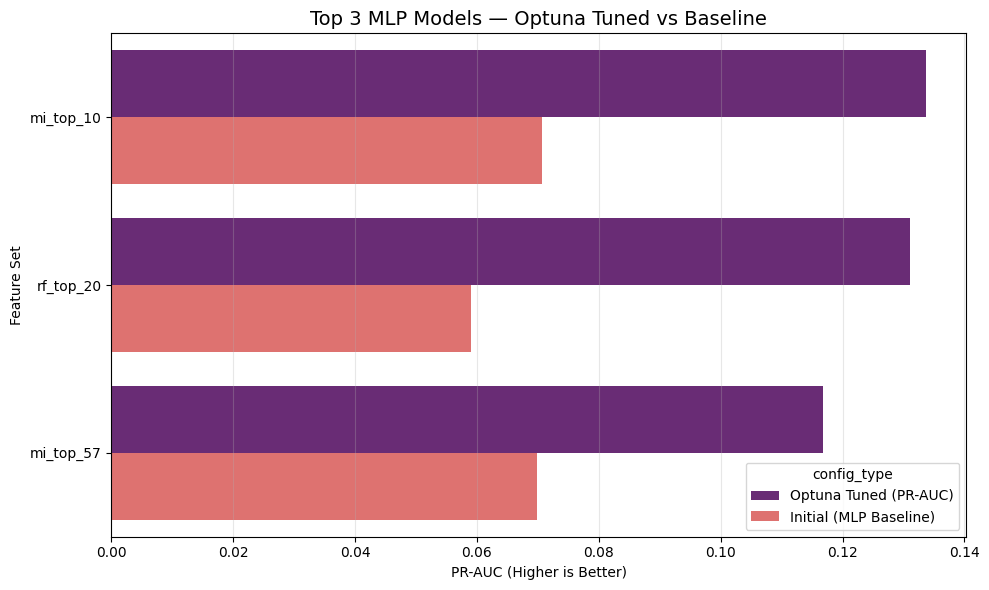

In [307]:
# Take top 3 Optuna-tuned MLPs
top3_tuned = mlp_pr_df.sort_values("pr_auc_val", ascending=False).head(3)
top3_tuned["config_type"] = "Optuna Tuned (PR-AUC)"
top3_tuned.rename(columns={"best_params": "params"}, inplace=True)

# Get baseline rows corresponding to the top 3 feature sets
baseline_rows = initial_mlp[initial_mlp["feature_set"].isin(top3_tuned["feature_set"])]

# Combine top 3 tuned + their baseline
top3_comparison = pd.concat([top3_tuned, baseline_rows], ignore_index=True)

# Sort for plotting
top3_comparison = top3_comparison.sort_values(
    by=["pr_auc_val", "feature_set"],
    ascending=[False, True]
).reset_index(drop=True)

# Display
print("🏆 Top 3 Optuna-tuned MLP vs Baseline")
display(top3_comparison[[
    "feature_set",
    "config_type",
    "pr_auc_val",
    "roc_auc_val",
    "params",
]])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top3_comparison,
    x="pr_auc_val",
    y="feature_set",
    hue="config_type",
    palette="magma",
)
plt.title("Top 3 MLP Models — Optuna Tuned vs Baseline", fontsize=14)
plt.xlabel("PR-AUC (Higher is Better)")
plt.ylabel("Feature Set")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


### Train and Save (MLP)

In [311]:
# Sort mlp_models_config by PR-AUC and take top 3
mlp_top3 = sorted(mlp_models_config, key=lambda x: x["pr_auc_val"], reverse=True)[:3]

# Make directory if not exists
os.makedirs("saved_models/mlp", exist_ok=True)

# Save each top 3 MLP config
for cfg in mlp_top3:
    safe_name = cfg["name"].replace("::", "__")
    path = os.path.join("saved_models/mlp", f"{safe_name}_p3.joblib")
    
    joblib.dump({
        "model_name": cfg["name"],
        "feature_set": cfg["feature_set"],
        "params": cfg["params"],
        "metrics": {
            "pr_auc": cfg["pr_auc_val"],
            "roc_auc": cfg["roc_auc_val"],
        },
    }, path, compress=1)
    
    print(f"Saved top-3 MLP Optuna model: {path}")


Saved top-3 MLP Optuna model: saved_models/mlp\mlp__mi_top_10_p3.joblib
Saved top-3 MLP Optuna model: saved_models/mlp\mlp__rf_top_20_p3.joblib
Saved top-3 MLP Optuna model: saved_models/mlp\mlp__mi_top_57_p3.joblib


### Feature Sets (MLP)

In [312]:
# Ensure directory exists
os.makedirs("saved_models/mlp", exist_ok=True)
_cache = {}

# Take only top 3 Optuna-tuned MLPs
mlp_top3 = sorted(mlp_models_config, key=lambda x: x["pr_auc_val"], reverse=True)[:3]

for cfg in mlp_top3:
    fs = cfg["feature_set"]

    if fs not in feature_sets:
        print(f"⚠️ Missing feature set '{fs}' — skip.")
        continue

    if fs not in _cache:
        blob = feature_sets[fs]
        X_final = pd.concat([blob["train"], blob["val"]], axis=0)
        y_final = pd.concat([y_train, y_val], axis=0)
        feats = blob["train"].columns.tolist()
        _cache[fs] = (X_final, y_final, feats)

    X_final, y_final, feats = _cache[fs]
    p = cfg["params"]

    clf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            hidden_layer_sizes=p["hidden_layer_sizes"],
            alpha=p["alpha"],
            learning_rate_init=p["learning_rate_init"],
            activation="relu",
            solver="adam",
            max_iter=500,
            early_stopping=True,
            n_iter_no_change=20,
            random_state=42,
            verbose=False,
        )),
    ])

    print(f"Training {cfg['name']} with {len(feats)} features…")
    clf.fit(X_final[feats], y_final)

    safe_name = cfg["name"].replace("::", "__")
    path = os.path.join("saved_models/mlp", f"{safe_name}_p3.joblib")

    joblib.dump({
        "model": clf,
        "family": "mlp",
        "model_name": cfg["name"],
        "feature_set": fs,
        "features": feats,
        "params": dict(p),
        "metrics": {
            "pr_auc": float(cfg["pr_auc_val"]),
            "roc_auc": float(cfg["roc_auc_val"]),
        },
    }, path, compress=1)

    print(f"Saved top-3 MLP Optuna model: {path}")


Training mlp::mi_top_10 with 10 features…


Saved top-3 MLP Optuna model: saved_models/mlp\mlp__mi_top_10_p3.joblib
Training mlp::rf_top_20 with 20 features…
Saved top-3 MLP Optuna model: saved_models/mlp\mlp__rf_top_20_p3.joblib
Training mlp::mi_top_57 with 57 features…
Saved top-3 MLP Optuna model: saved_models/mlp\mlp__mi_top_57_p3.joblib


# Results

In [313]:
def safe_predict_score(model, X):
    """
    Returns continuous score for ranking metrics (ROC / PR AUC).
    """
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X)
        return p[:, 1]

    if hasattr(model, "decision_function"):
        return model.decision_function(X)

    raise ValueError("Model does not provide probabilistic scores")


MODELS_DIR = "saved_models"

models = []

for root, _, files in os.walk(MODELS_DIR):
    for fname in files:
        if not fname.endswith(".joblib"):
            continue

        path = os.path.join(root, fname)

        try:
            blob = joblib.load(path)
        except Exception as e:
            print(f"❌ Failed to load {path}: {e}")
            continue

        models.append({
            "path": path,
            "family": blob.get("family", "unknown"),
            "model_name": blob.get("model_name", fname),
            "feature_set": blob.get("feature_set"),
            "features": blob.get("features"),
            "model": blob.get("model"),
        })

print(f"✅ Loaded models: {len(models)}")


results = []

for m in models:
    name   = m["model_name"]
    family = m["family"]
    feats  = m["features"]
    model  = m["model"]

    if not isinstance(feats, (list, tuple)):
        print(f"⚠️ Invalid feature list for {name} — skipped.")
        continue

    try:
        Xtr = X_train[feats]
        Xva = X_val[feats]
        Xte = X_test[feats]
    except KeyError:
        print(f"⚠️ Feature mismatch for {name} — skipped.")
        continue

    try:
        s_tr = safe_predict_score(model, Xtr)
        pr_tr  = average_precision_score(y_train, s_tr)
        roc_tr = roc_auc_score(y_train, s_tr)

        s_va = safe_predict_score(model, Xva)
        pr_va  = average_precision_score(y_val, s_va)
        roc_va = roc_auc_score(y_val, s_va)

        s_te = safe_predict_score(model, Xte)
        pr_te  = average_precision_score(y_test, s_te)
        roc_te = roc_auc_score(y_test, s_te)

    except ValueError as e:
        print(f"⚠️ Metric failure for {name}: {e}")
        continue

    results.append({
        "model_name": name,
        "family": family,
        "n_features": len(feats),

        "pr_auc_train": pr_tr,
        "roc_auc_train": roc_tr,

        "pr_auc_val": pr_va,
        "roc_auc_val": roc_va,

        "pr_auc_test": pr_te,
        "roc_auc_test": roc_te,

        "gap_train_test": pr_tr - pr_te,
        "gap_val_test": pr_va - pr_te,
    })

final_eval_df = (
    pd.DataFrame(results)
      .sort_values("pr_auc_val", ascending=False)
      .reset_index(drop=True)
)

display(final_eval_df)


✅ Loaded models: 21


model_name               family  n_features  pr_auc_train  \
0              cat::rf_top_40             catboost          40      0.999143   
1              cat::mi_top_40             catboost          40      0.997550   
2               rf::rf_top_60        random_forest          60      0.957926   
3              cat::rf_top_60             catboost          60      0.999888   
4               rf::rf_top_50        random_forest          50      0.876550   
5              lgb::rf_top_40             lightgbm          40      0.833337   
6           lgb::all_features             lightgbm          91      0.888924   
7              lgb::mi_top_57             lightgbm          57      0.782953   
8               rf::rf_top_40        random_forest          40      0.713676   
9              xgb::mi_top_40              xgboost          40      0.546050   
10             xgb::mi_top_57              xgboost          57      0.513126   
11             mlp::rf_top_20                  mlp          20      0.374669   
12             ada::mi_top_57             adaboost          57      0.324859   
13             ada::rf_top_69             adaboost          69      0.291814   
14             ada::mi_top_40             adaboost          40      0.291019   
15             xgb::rf_top_69              xgboost          69      0.256308   
16             mlp::mi_top_10                  mlp          10      0.209204   
17     logreg_rf_top_5.joblib  logistic_regression           5      0.144055   
18   logreg_perm_top_6.joblib  logistic_regression           6      0.127215   
19  logreg_perm_top_12.joblib  logistic_regression          12      0.125857   
20             mlp::mi_top_57                  mlp          57      0.101628   

    roc_auc_train  pr_auc_val  roc_auc_val  pr_auc_test  roc_auc_test  \
0        0.999955    0.971672     0.998138     0.109069      0.680834   
1        0.999862    0.959347     0.997356     0.110677      0.682249   
2        0.998388    0.881412     0.993607     0.152133      0.726636   
3        0.999993    0.869364     0.989451     0.107971      0.692206   
4        0.992913    0.774618     0.985780     0.150195      0.727519   
5        0.989815    0.541494     0.950027     0.159855      0.731548   
6        0.993243    0.479092     0.930035     0.167745      0.726391   
7        0.981867    0.384755     0.898092     0.165444      0.727192   
8        0.978585    0.367966     0.902855     0.151218      0.727899   
9        0.952913    0.365036     0.889695     0.150127      0.708306   
10       0.934505    0.300346     0.844272     0.159031      0.726665   
11       0.887455    0.272212     0.800798     0.141355      0.704368   
12       0.867735    0.266186     0.780913     0.156903      0.732106   
13       0.864611    0.248040     0.767431     0.161748      0.734518   
14       0.848756    0.245806     0.768779     0.161123      0.733697   
15       0.844240    0.206518     0.754090     0.168302      0.745030   
16       0.803219    0.146973     0.693995     0.120830      0.675910   
17       0.765318    0.126804     0.679788     0.114567      0.704219   
18       0.704583    0.113803     0.686018     0.114101      0.699018   
19       0.706892    0.113257     0.688059     0.124028      0.706116   
20       0.650810    0.108444     0.662575     0.106255      0.676255   

    gap_train_test  gap_val_test  
0         0.890074      0.862603  
1         0.886873      0.848670  
2         0.805793      0.729279  
3         0.891918      0.761394  
4         0.726355      0.624423  
5         0.673482      0.381639  
6         0.721180      0.311347  
7         0.617509      0.219311  
8         0.562458      0.216748  
9         0.395924      0.214909  
10        0.354095      0.141315  
11        0.233314      0.130857  
12        0.167956      0.109284  
13        0.130066      0.086292  
14        0.129896      0.084683  
15        0.088005      0.038215  
16        0.088374      0.026143  
17        0.029488   

## Final Model

Selected Model: xgb::rf_top_69

We chose this model because it achieves the highest test PR AUC (0.168) and ROC AUC (0.745) while maintaining a low train-test gap (0.088). 

Other top-performing models (like CatBoost cat::rf_top_40) show near-perfect training scores but fail on the test set due to severe overfitting.

In [314]:
# Selected model for final evaluation
# The model was choosen that balances PR-AUC on validation/test and generalization, avoiding huge train-test gaps
SELECTED_MODEL_NAME = "xgb::rf_top_69"

# Load the selected model from our saved models list
selected = next(
    m for m in models
    if m["model_name"] == SELECTED_MODEL_NAME
)

model_final   = selected["model"]
final_features = selected["features"]

# Combine training and validation sets for final fit
X_trval = pd.concat([X_train, X_val])[final_features]
y_trval = pd.concat([y_train, y_val])

model_final.fit(X_trval, y_trval)

# Test set evaluation
X_te = X_test[final_features]
y_te = y_test

y_score = model_final.predict_proba(X_te)[:, 1]

pr_test  = average_precision_score(y_te, y_score)
roc_test = roc_auc_score(y_te, y_score)

print(f"Final PR AUC (test):  {pr_test:.4f}")
print(f"Final ROC AUC (test): {roc_test:.4f}")


Final PR AUC (test):  0.1683
Final ROC AUC (test): 0.7450


In [315]:
# Select the final features for the test set
X_te = X_test[final_features]
y_te = y_test.values

# Get predicted probabilities for the positive class
y_score = model_final.predict_proba(X_te)[:, 1]

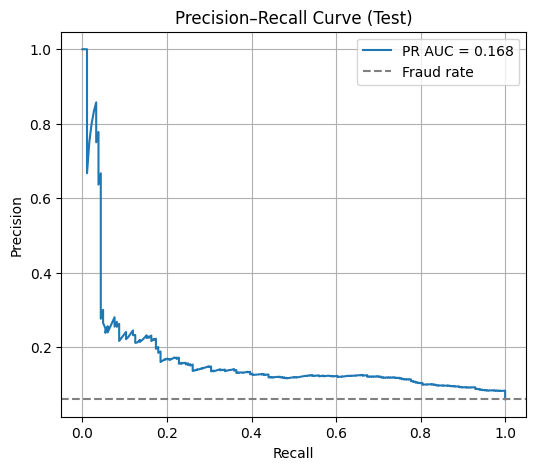

In [316]:
# Compute precision-recall curve and PR-AUC
precision, recall, thresholds = precision_recall_curve(y_te, y_score)
pr_auc = average_precision_score(y_te, y_score)

# Plot the Precision–Recall curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
plt.axhline(y=y_te.mean(), linestyle="--", color="gray", label="Fraud rate")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test)")
plt.legend()
plt.grid(True)
plt.show()


The Precision–Recall curve shows how well the model identifies fraud across different thresholds, with precision dropping as recall increases.

The PR AUC of 0.168 is above the baseline fraud rate (dashed line), indicating the model captures some signal despite the class imbalance.

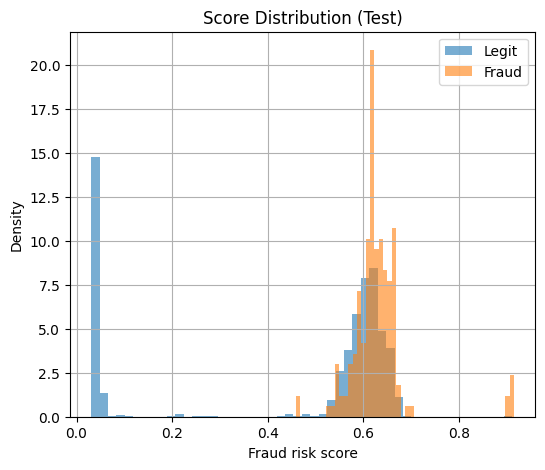

In [318]:
# Plot the distribution of predicted fraud scores for each class
plt.figure(figsize=(6, 5))

plt.hist(y_score[y_te == 0], bins=50, alpha=0.6, label="Legit", density=True)
plt.hist(y_score[y_te == 1], bins=50, alpha=0.6, label="Fraud", density=True)

plt.xlabel("Fraud risk score")
plt.ylabel("Density")
plt.title("Score Distribution (Test)")
plt.legend()
plt.grid(True)
plt.show()


The score distribution shows that fraudulent cases tend to have higher predicted risk scores than legitimate ones.

However, there is still substantial overlap between the classes, which explains why the model’s precision is limited at higher recall levels.

We can say that this highlights the challenge of detecting fraud in an imbalanced dataset.

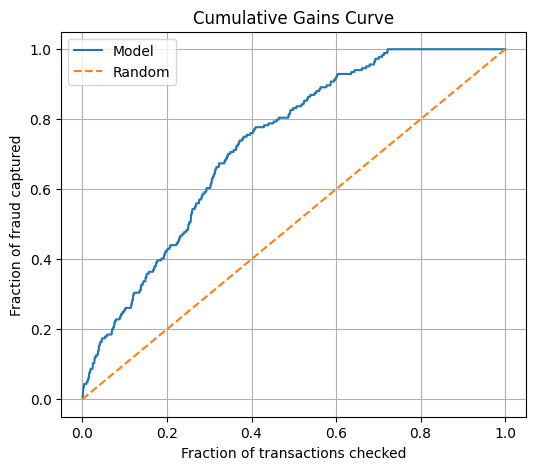

In [319]:
# Plot the Cumulative Gains curve to evaluate fraud detection efficiency
order = np.argsort(-y_score)   
y_sorted = y_te[order]        

cum_fraud = np.cumsum(y_sorted)   
total_fraud = y_sorted.sum()       

perc_checked = np.arange(1, len(y_sorted) + 1) / len(y_sorted)  
fraud_captured = cum_fraud / total_fraud                        

plt.figure(figsize=(6, 5))
plt.plot(perc_checked, fraud_captured, label="Model")
plt.plot([0, 1], [0, 1], "--", label="Random")
plt.xlabel("Fraction of transactions checked")
plt.ylabel("Fraction of fraud captured")
plt.title("Cumulative Gains Curve")
plt.legend()
plt.grid(True)
plt.show()


The Cumulative Gains Curve illustrates that the model captures a large proportion of fraud by examining only a small fraction of transactions.

Compared to the random baseline, the model prioritizes high-risk cases more efficiently, demonstrating its effectiveness in imbalanced datasets.

This metric highlights the model’s ability to focus investigative resources on the most relevant transactions.

In [327]:
# Threshold Analysis
rows_threshold = []

# Evaluate thresholds corresponding to top 1% to top 20% of predicted scores
for q in np.arange(0.99, 0.80, -0.01):  # 0.99, 0.98, ..., 0.81
    thr = np.quantile(y_score, q)                     # threshold value
    y_pred = (y_score >= thr).astype(int)            # flag fraud if score >= threshold

    # Compute metrics for this threshold
    rows_threshold.append({
        "threshold": thr,
        "alerts_%": y_pred.mean() * 100,             # % of transactions flagged
        "recall": recall_score(y_te, y_pred),
        "precision": precision_score(y_te, y_pred),
        "f1_score": f1_score(y_te, y_pred),
        "fraud_captured": y_te[y_pred == 1].sum() / y_te.sum() * 100
    })

# Convert to DataFrame for visualization
op_df = pd.DataFrame(rows_threshold)
op_df = op_df.sort_values(by="threshold", ascending=False)

In [328]:
# Cost-based Scenario Analysis
FN_COST = 1.0               # normalized cost of missing a fraud
FP_COSTS = [0.01, 0.05, 0.1]  # different assumptions for false positive cost
rows_cost = []

# Evaluate different FP costs and thresholds
for fp_cost in FP_COSTS:
    for q in [0.99, 0.97, 0.95, 0.90]:  # top-score quantiles
        thr = np.quantile(y_score, q)
        y_pred = (y_score >= thr).astype(int)

        # Confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()

        # Total loss = FN cost + FP cost
        total_loss = fn * FN_COST + fp * fp_cost

        # Store results
        rows_cost.append({
            "FP_cost": fp_cost,
            "threshold_quantile": q,
            "alerts_%": y_pred.mean() * 100,
            "recall": tp / (tp + fn) if (tp + fn) > 0 else 0,
            "precision": tp / (tp + fp) if (tp + fp) > 0 else 0,
            "relative_loss": total_loss
        })


In [329]:
# Convert to DataFrame
scenario_df = pd.DataFrame(rows_cost)

In [331]:
# Display results
print ("Threshold Analysis")
display(op_df)

Threshold Analysis


threshold   alerts_%    recall  precision  f1_score  fraud_captured
0    0.669673   1.005188  0.048913   0.290323  0.083721        4.891304
1    0.666253   2.010376  0.086957   0.258065  0.130081        8.695652
2    0.663444   3.047990  0.119565   0.234043  0.158273       11.956522
3    0.660254   4.053178  0.152174   0.224000  0.181230       15.217391
4    0.656263   5.025940  0.173913   0.206452  0.188791       17.391304
5    0.653714   5.998703  0.184783   0.183784  0.184282       18.478261
6    0.652667   7.003891  0.195652   0.166667  0.180000       19.565217
7    0.651093   8.009079  0.228261   0.170040  0.194896       22.826087
8    0.649250   9.014267  0.233696   0.154676  0.186147       23.369565
9    0.647509  10.019455  0.255435   0.152104  0.190669       25.543478
10   0.645111  11.024643  0.260870   0.141176  0.183206       26.086957
11   0.642315  11.997406  0.293478   0.145946  0.194946       29.347826
12   0.640237  13.002594  0.304348   0.139651  0.191453       30.434783
13   0.638391  14.007782  0.326087   0.138889  0.194805       32.608696
14   0.636557  15.012970  0.347826   0.138229  0.197836       34.782609
15   0.634810  16.018158  0.364130   0.135628  0.197640       36.413043
16   0.633329  17.315175  0.380435   0.131086  0.194986       38.043478
17   0.632135  17.996109  0.396739   0.131532  0.197564       39.673913
18   0.629803  19.001297  0.402174   0.126280  0.192208       40.217391

### Threshold Analysis of Fraud Detection

This table shows how the model performs when flagging only the top fraction of transactions based on predicted fraud scores.

- **Threshold**: the minimum predicted score needed to flag a transaction as fraud.  
- **Alerts_%**: the percentage of all transactions that are flagged at this threshold.  
- **Recall**: fraction of all actual fraud cases detected by the model.  
- **Precision**: accuracy of the flagged transactions (how many flagged transactions are actually fraud).  
- **F1 score**: harmonic mean of precision and recall, balancing both metrics.  
- **Fraud_captured (%)**: proportion of total fraud detected at this threshold.  

Observations:  
- As the threshold decreases, more transactions are flagged, which increases recall and fraud captured but reduces precision.  
- Higher thresholds focus only on the riskiest transactions, giving higher precision but detecting fewer fraud cases.  
- This analysis helps select a threshold that balances catching fraud with limiting unnecessary alerts, which is especially important in highly imbalanced datasets.  


In [332]:
print("Cost-based Scenario Analysis")
display(scenario_df)


Cost-based Scenario Analysis


FP_cost  threshold_quantile   alerts_%    recall  precision  relative_loss
0      0.01                0.99   1.005188  0.048913   0.290323         175.22
1      0.01                0.97   3.047990  0.119565   0.234043         162.72
2      0.01                0.95   5.025940  0.173913   0.206452         153.23
3      0.01                0.90  10.019455  0.255435   0.152104         139.62
4      0.05                0.99   1.005188  0.048913   0.290323         176.10
5      0.05                0.97   3.047990  0.119565   0.234043         165.60
6      0.05                0.95   5.025940  0.173913   0.206452         158.15
7      0.05                0.90  10.019455  0.255435   0.152104         150.10
8      0.10                0.99   1.005188  0.048913   0.290323         177.20
9      0.10                0.97   3.047990  0.119565   0.234043         169.20
10     0.10                0.95   5.025940  0.173913   0.206452         164.30
11     0.10                0.90  10.019455  0.255435   0.152104         163.20

### Cost-based Scenario Analysis for Fraud Detection

This table evaluates the model under different assumptions for the cost of false positives (FP) while keeping the false negative (FN) cost fixed.

- **FP_cost**: assumed cost of investigating a legitimate transaction.  
- **Threshold_quantile**: top fraction of predicted scores used as the alert threshold.  
- **Alerts_%**: percentage of transactions flagged at this threshold.  
- **Recall**: fraction of actual fraud cases detected.  
- **Precision**: accuracy of flagged transactions.  
- **Relative_loss**: total cost considering both FN and FP costs (FN_cost fixed at 1.0).  

Observations:  
- Higher FP costs increase the relative loss, especially at lower thresholds where more transactions are flagged.  
- Lower thresholds flag more transactions, increasing recall but also increasing costs from false positives.  
- This analysis helps choose a threshold that **minimizes expected loss**, balancing fraud detection with operational costs.  
- By comparing scenarios, we can determine the most cost-efficient strategy for monitoring transactions in imbalanced datasets.


# Conclusion

In this project, we built models to detect vehicle insurance fraud using a dataset where fraud cases are very rare.

We explored the data, created several feature sets based on different ranking methods, and tested how the number and type of features affect model performance.

Threshold analysis showed that lowering the alert threshold catches more fraud but also increases false alerts, while higher thresholds focus only on the riskiest claims.

We also ran cost-based scenarios to see how different assumptions about false positive and false negative costs affect total loss, helping us pick thresholds that are practical and efficient.

To sum up, the project demonstrates a full workflow for fraud detection: careful feature selection, model evaluation with imbalanced data in mind, and a focus on both accuracy and operational costs.